In [1]:
import os

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3

# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'distributed': True,
    'minibatch_size': 32,
    'num_devices': 3,
    'n_steps': 120000,
    'test_size': 1000,
    'test_minibatch_size': 10,
    'test_interval': 100,
    'display_images': True,
    'display_image_interval': 1000,
    'dont_display_until_loss': 0.45,
    'n_colors': 4,
    'dataset': {
        'buffer_size': 60000,
    },
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'batch_size_schedule': None,
    'start_accum_steps': 1,
    'end_accum_steps': 30,
    'seq_length': 784,
    'image_width': 28,
    'image_height': 28,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)
ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(ds_train_original, num_clusters=config['n_colors'], batch_size=1000)


In [5]:
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)

In [7]:
ds_train, ds_test = ds.make_datasets()

In [8]:

# model config
config.model = DotMap({
        'n_colors': config.n_colors,
        'n_enc_a_layers': 3,
        'n_enc_b_layers': 3,
        'ffl_dim': 128,
        'embd_dim': 64,
        'n_dec_layers': 3,
        'dec_dim': 600,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
        'architecture': 'anp',
        'position_embedding': 'pos_enc',
        'activation': 'swish',
    })

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

model_name = "cuda10-neo-shuffledifferently"
print(model_name)

training.wandb_init(config, model_name, resume=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda10-neo-shuffledifferently


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
config.training_mode = 'combination'
training_loop = training.TrainingLoop(config, viz, model, optimizer, ds, ds_train_dist, ds_test, schedules.batch_size_schedule(config), model_name)


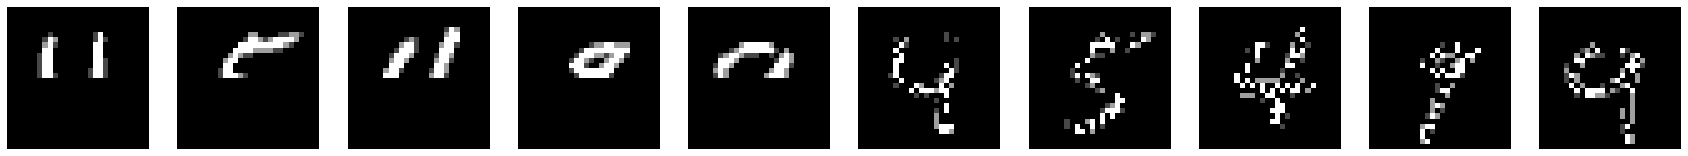

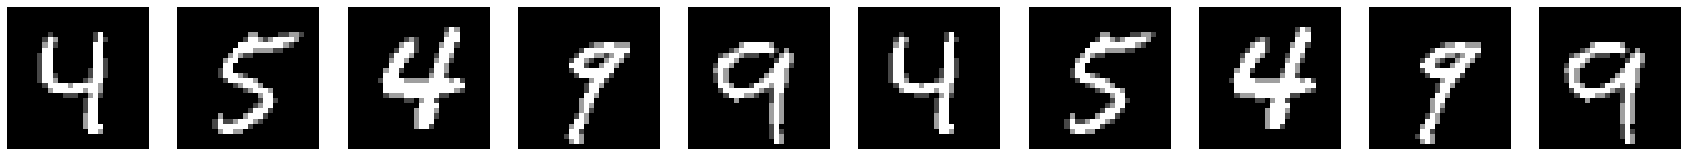

Step 1000, Loss (last minibatch): 0.3983316123485565, Loss (500 step avg.): 0.43886794337255514


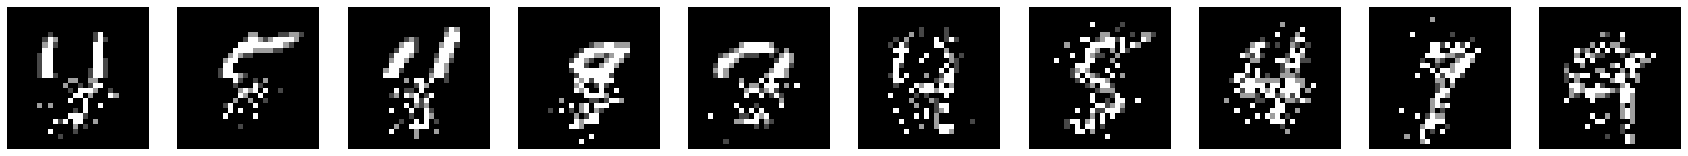

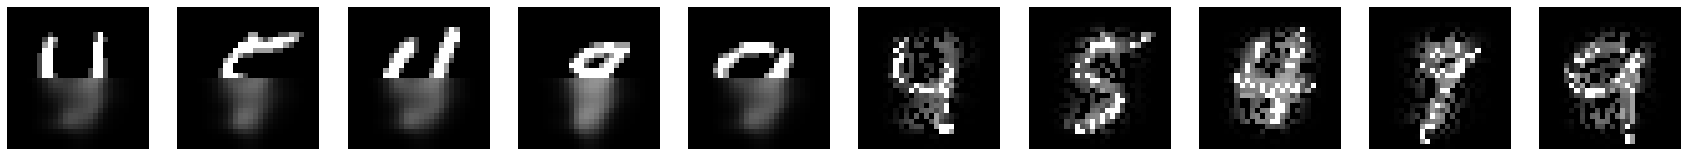

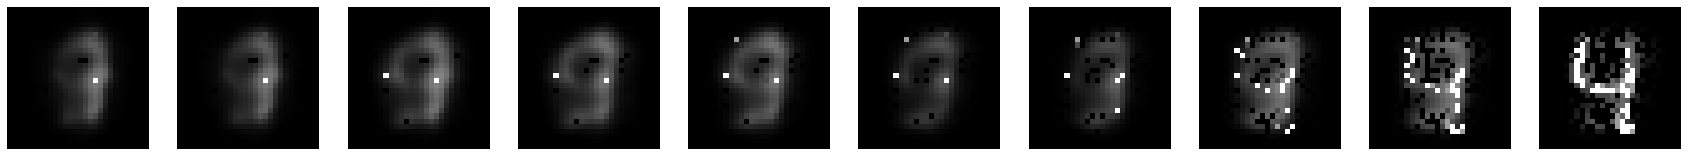

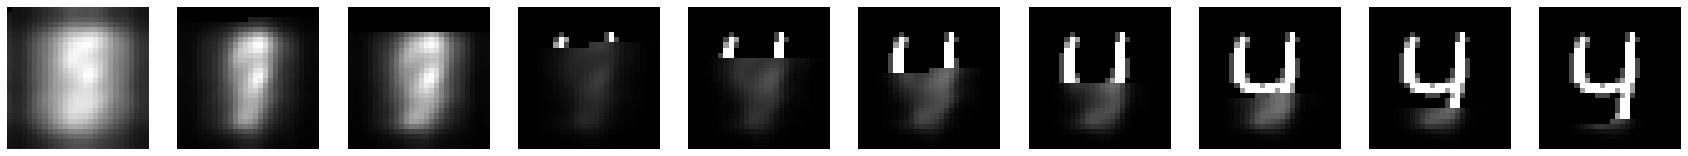

Step 1336, Loss (last minibatch): 0.35963279008865356, Loss (500 step avg.): 0.3948563919690793


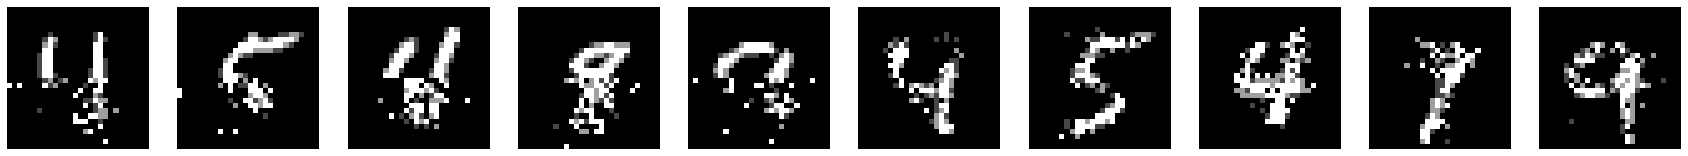

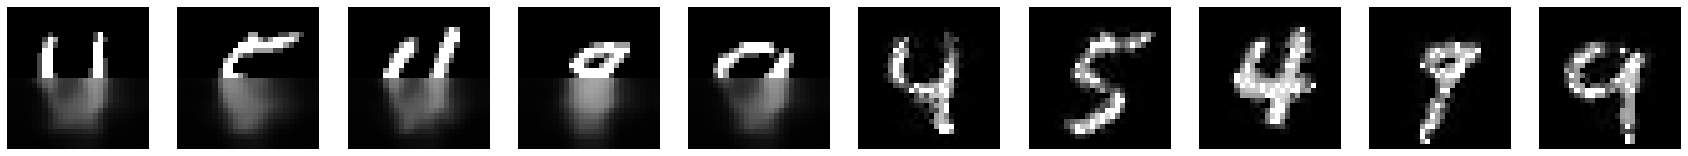

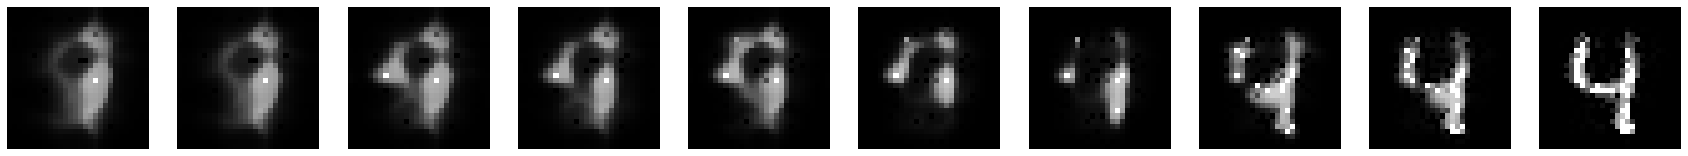

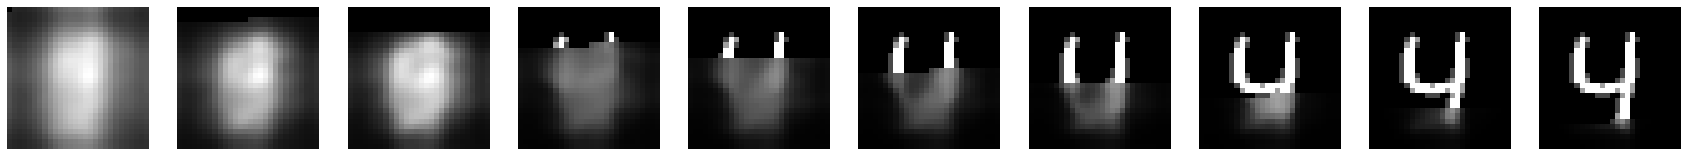

Step 1580, Loss (last minibatch): 0.3274543881416321, Loss (500 step avg.): 0.35527529021699034


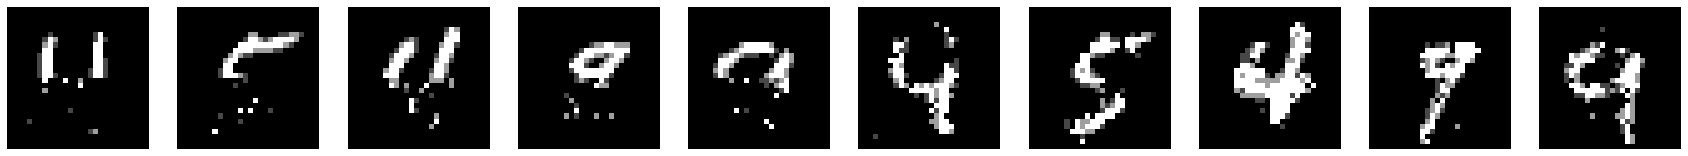

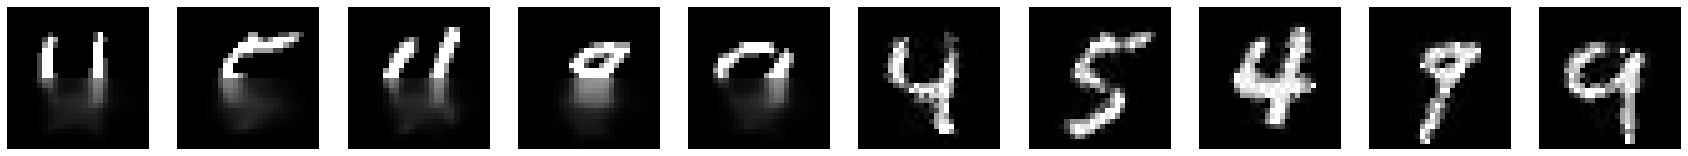

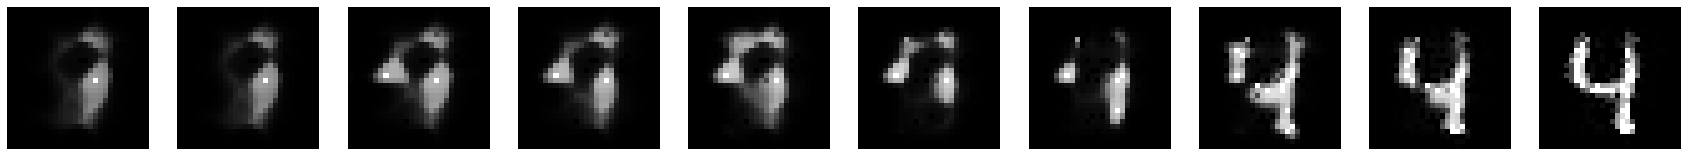

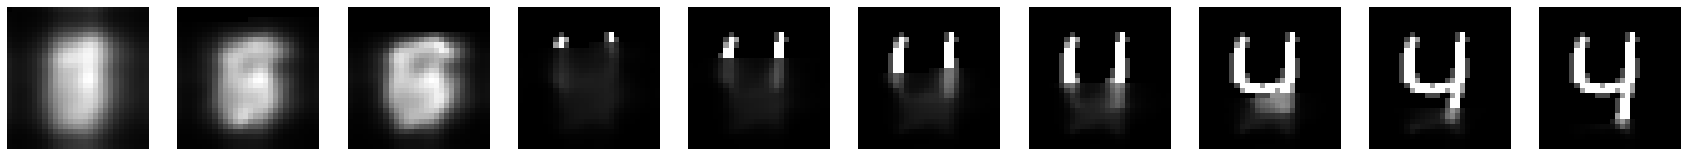

Step 2111, Loss (last minibatch): 0.3458434045314789, Loss (500 step avg.): 0.3196559999874252


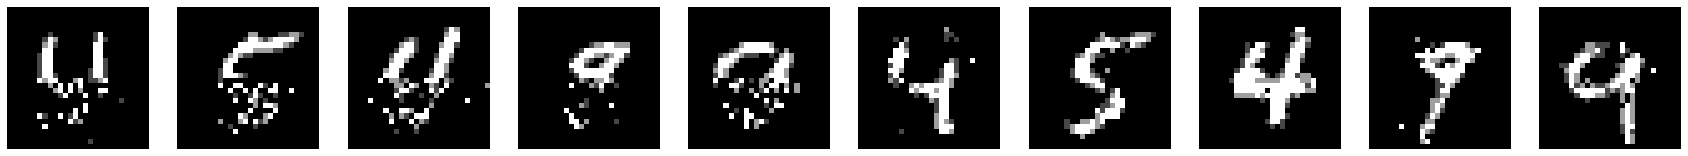

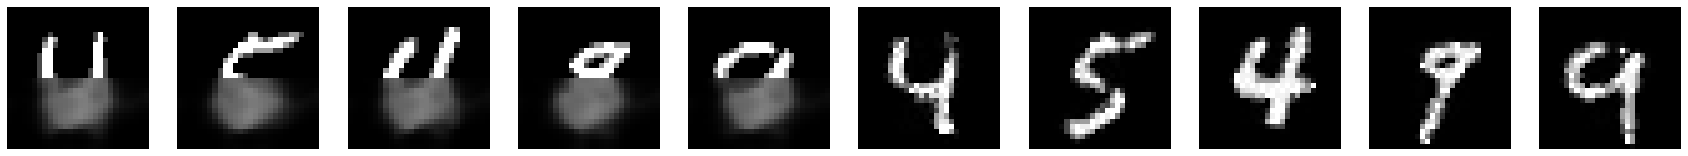

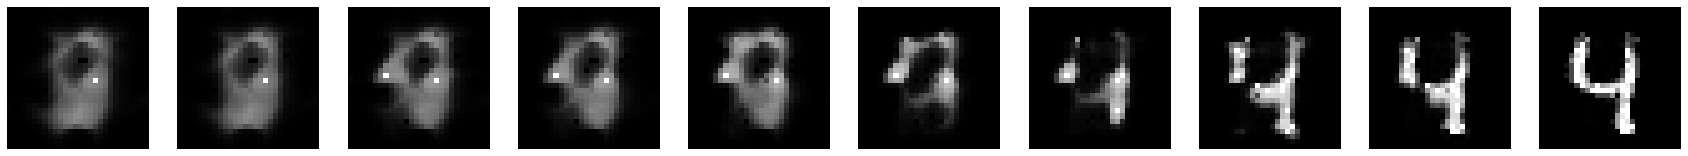

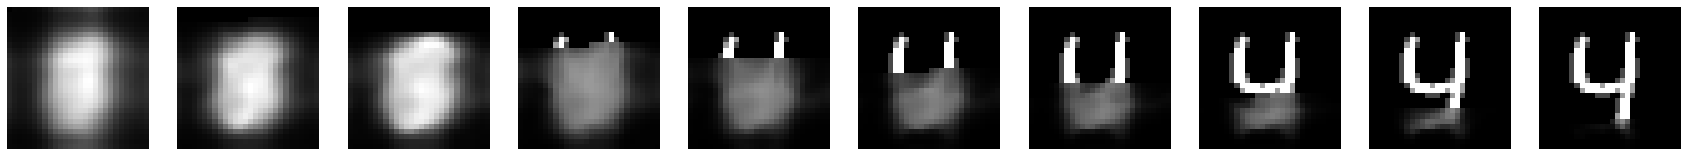

Step 3111, Loss (last minibatch): 0.3253431022167206, Loss (500 step avg.): 0.30153757247501267


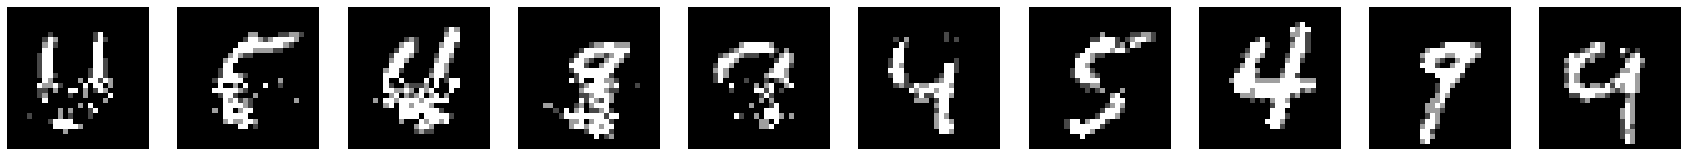

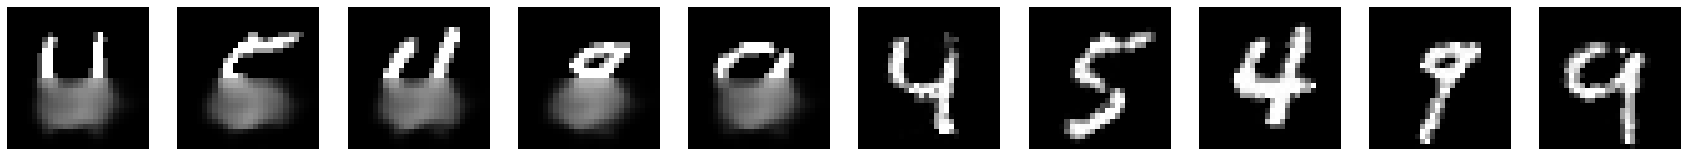

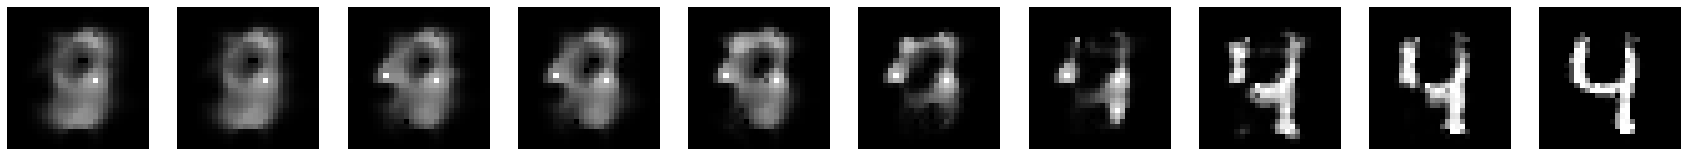

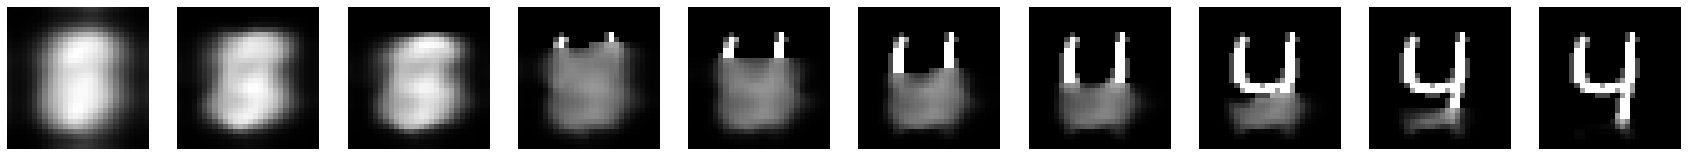

Step 4111, Loss (last minibatch): 0.27535346150398254, Loss (500 step avg.): 0.2907404197071365


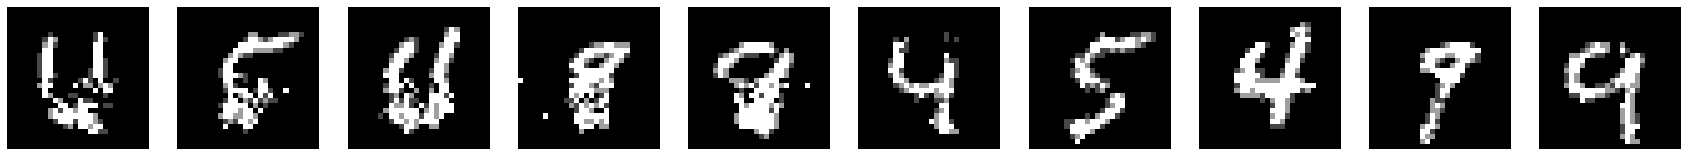

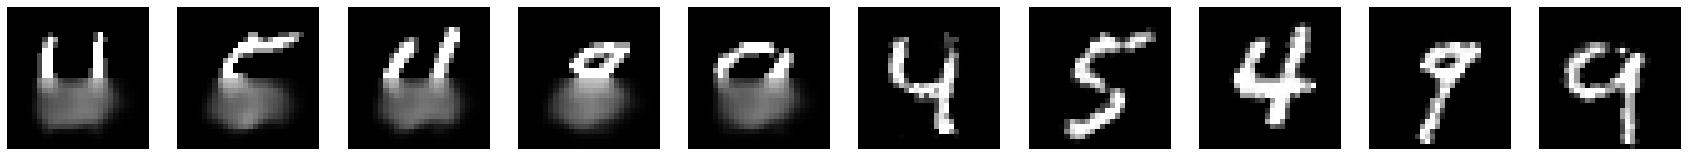

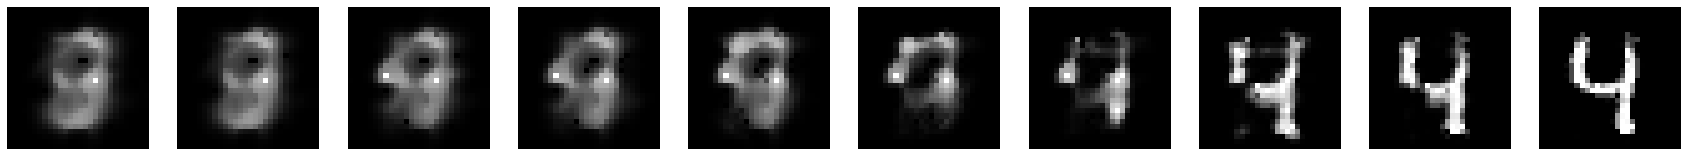

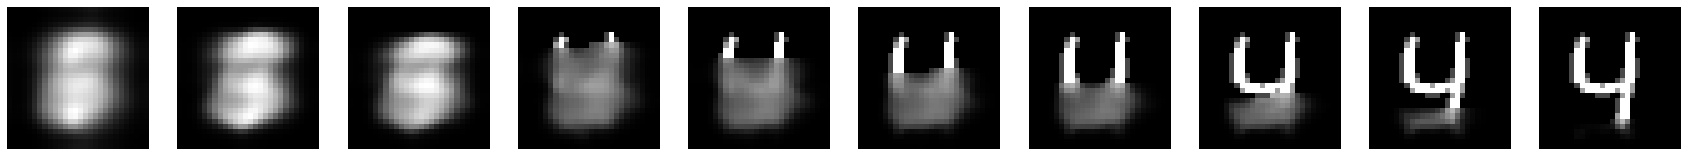

Step 5111, Loss (last minibatch): 0.3112901449203491, Loss (500 step avg.): 0.28423083821932477


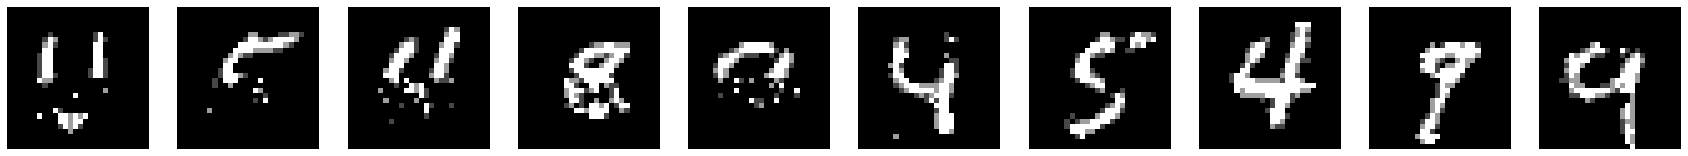

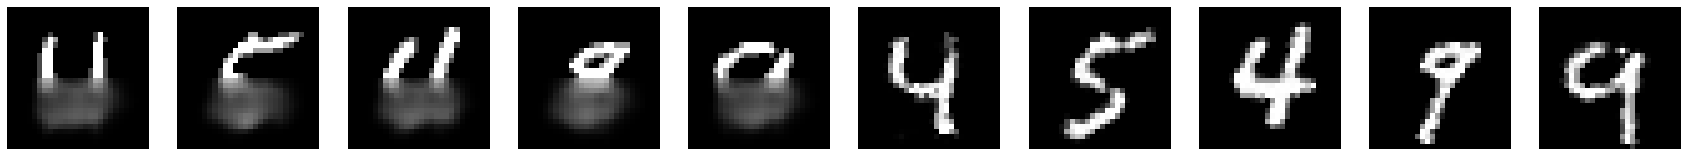

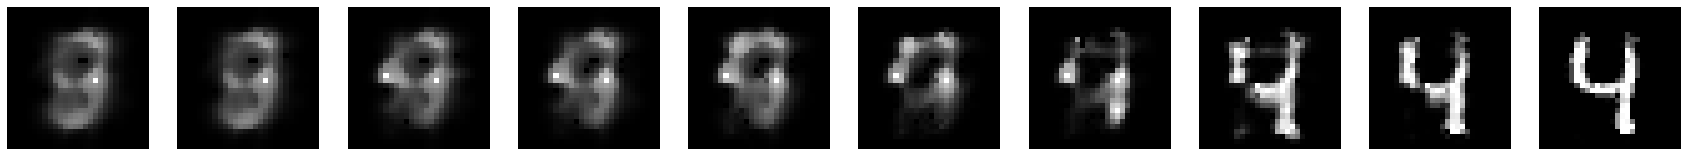

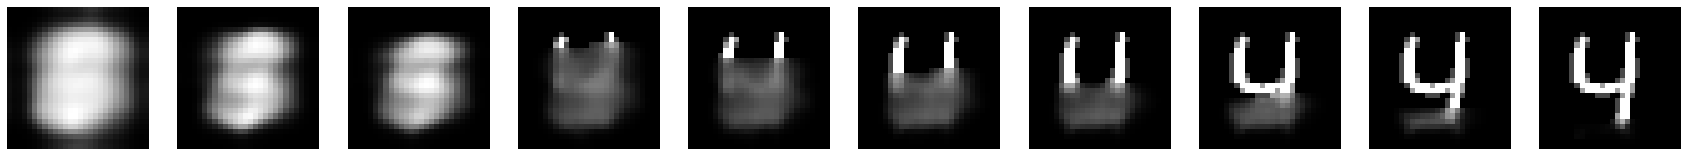

Step 6111, Loss (last minibatch): 0.27026861906051636, Loss (500 step avg.): 0.27920542594915376


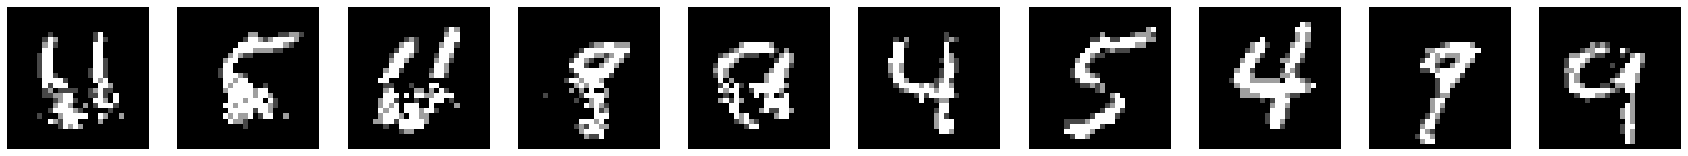

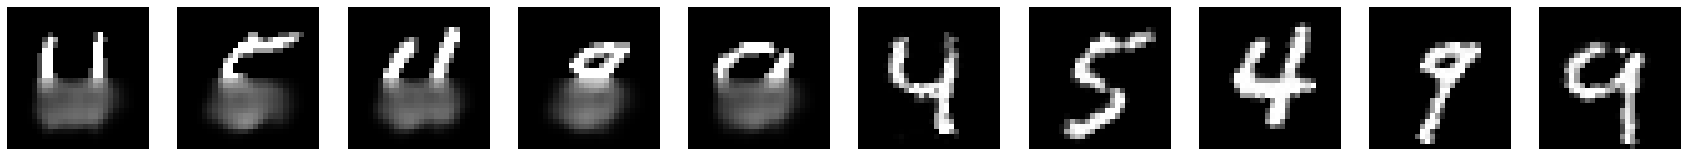

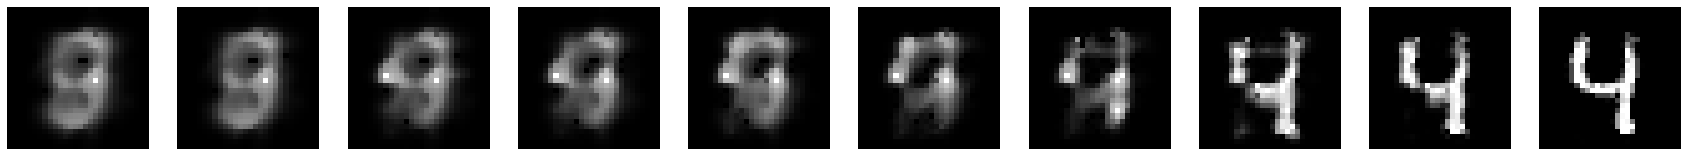

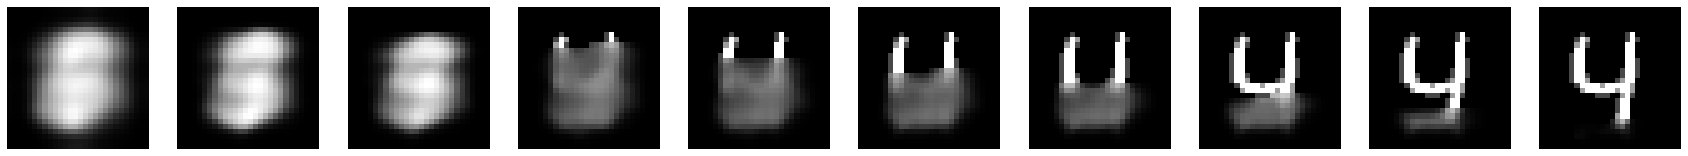

Step 7111, Loss (last minibatch): 0.3294871151447296, Loss (500 step avg.): 0.2693895714547106


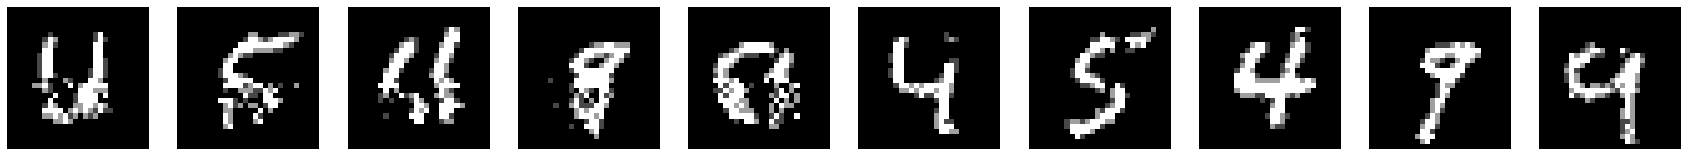

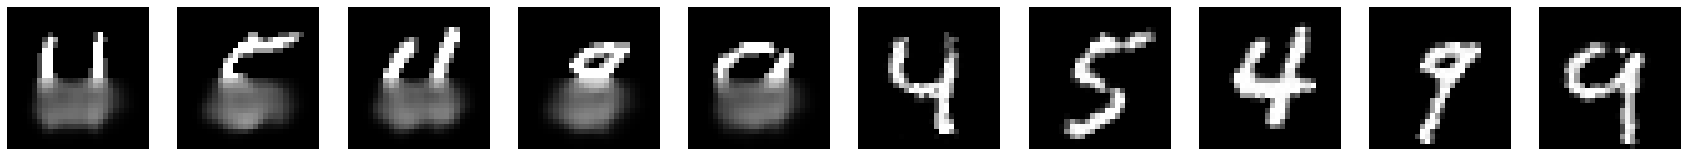

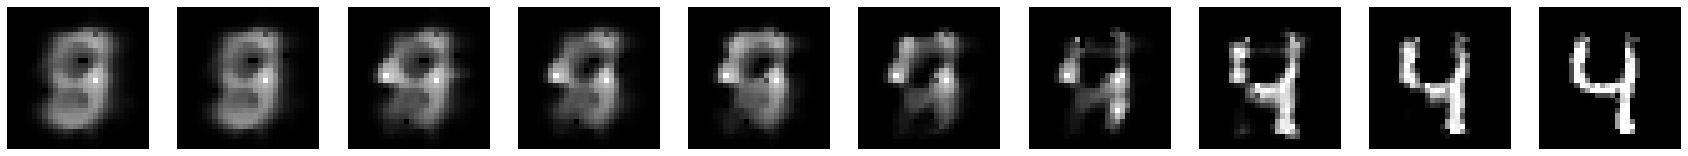

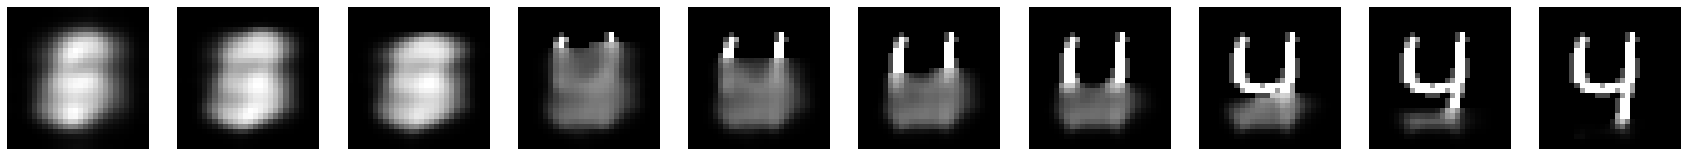

Step 8111, Loss (last minibatch): 0.2488427460193634, Loss (500 step avg.): 0.2647226502497991


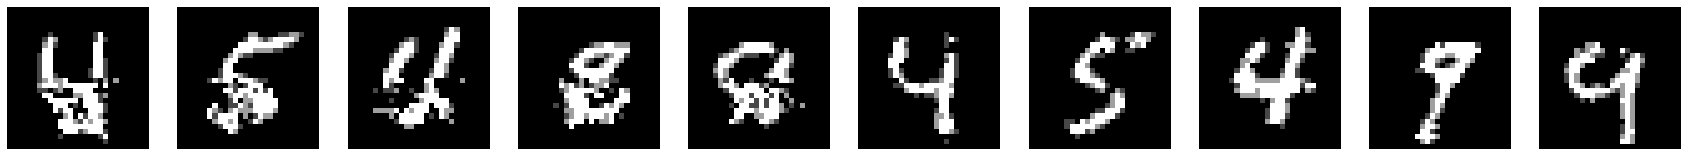

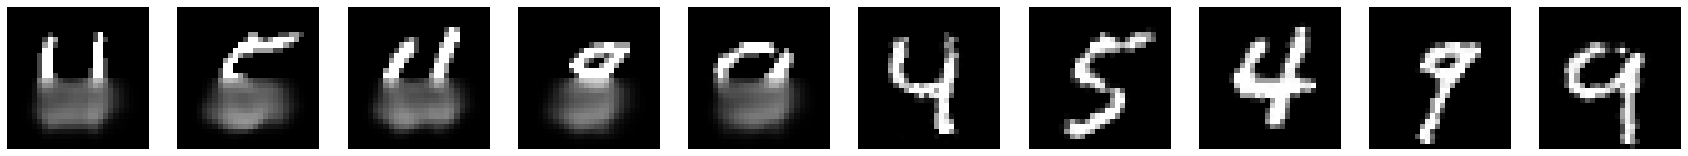

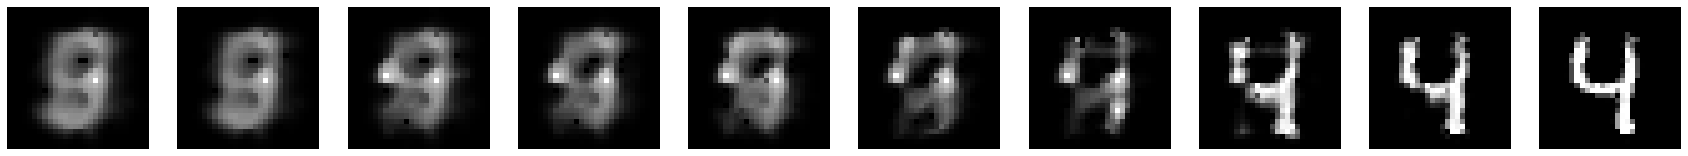

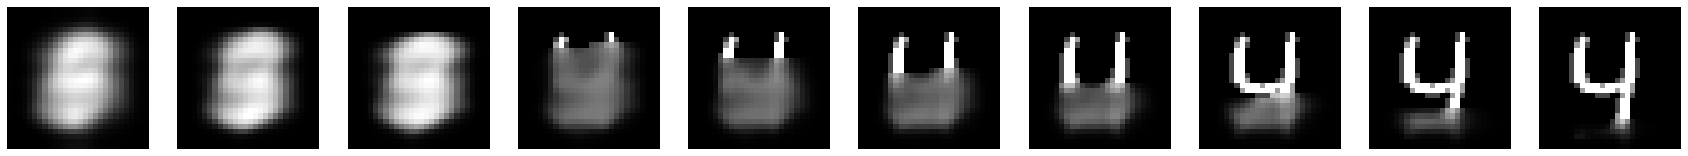

Step 9111, Loss (last minibatch): 0.3003126084804535, Loss (500 step avg.): 0.26292789749756545


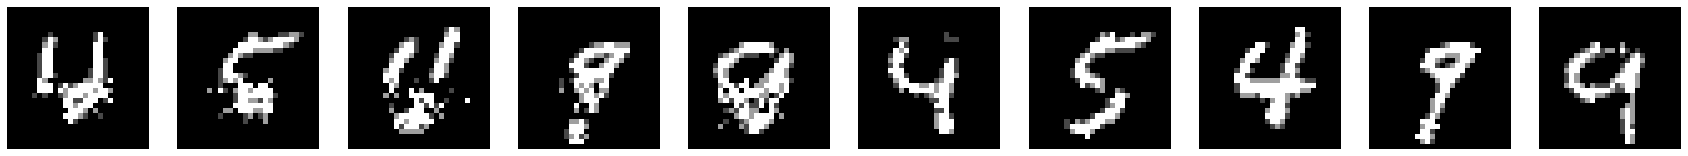

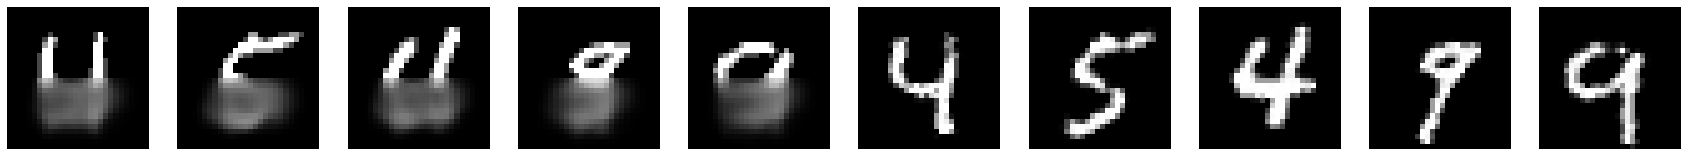

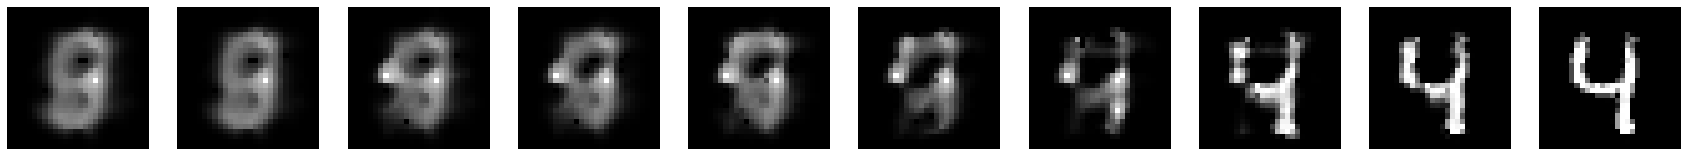

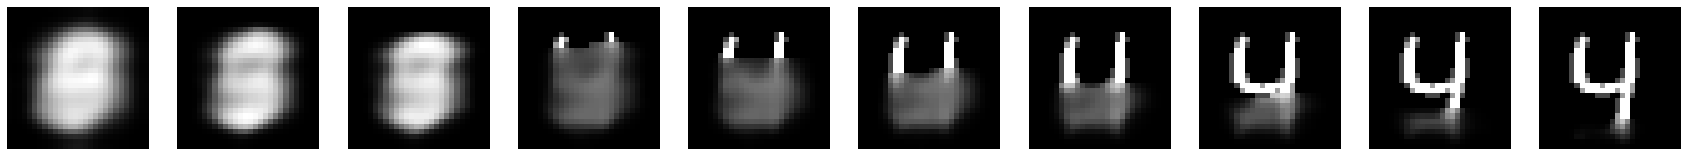

Step 10111, Loss (last minibatch): 0.19059014320373535, Loss (500 step avg.): 0.25807372746829266


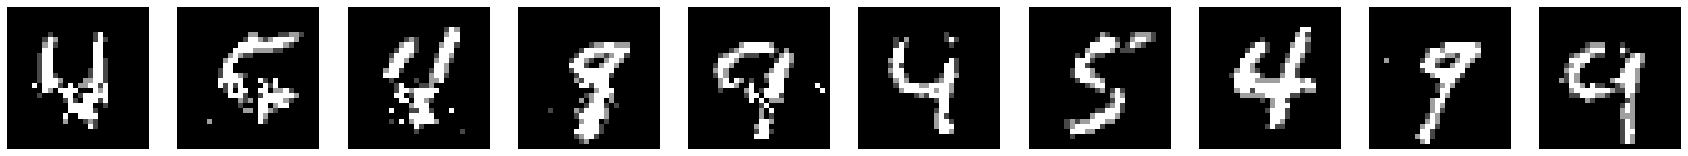

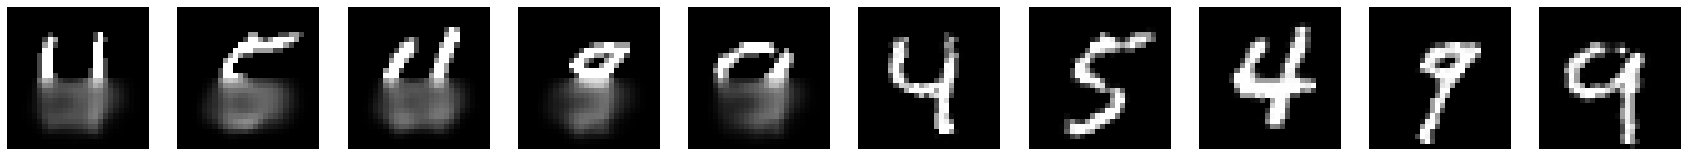

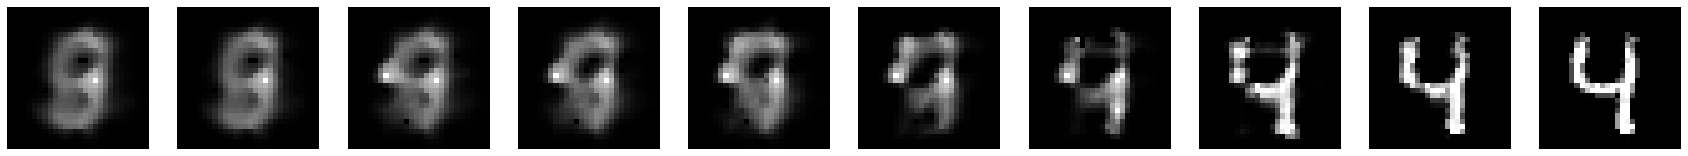

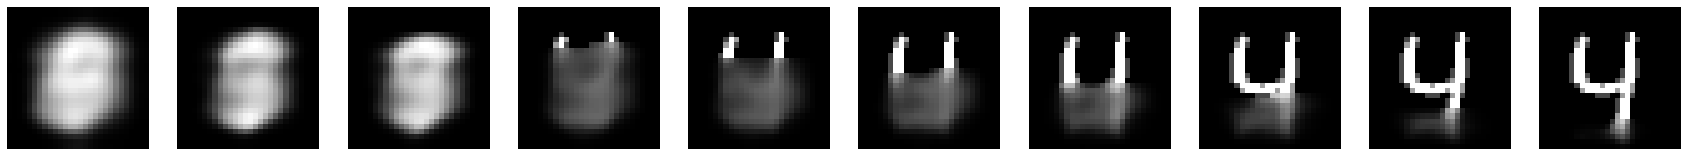

Step 11111, Loss (last minibatch): 0.22547012567520142, Loss (500 step avg.): 0.25024001588840444


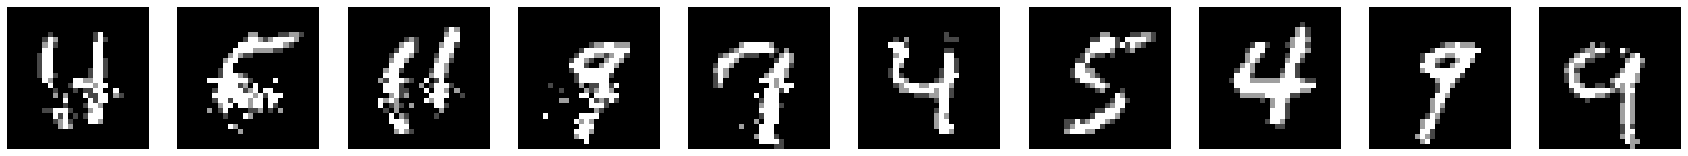

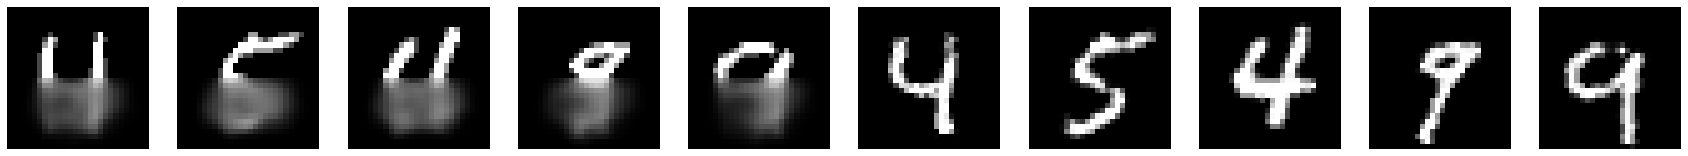

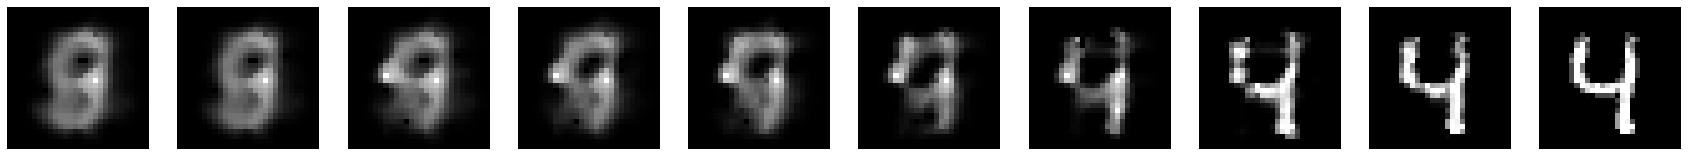

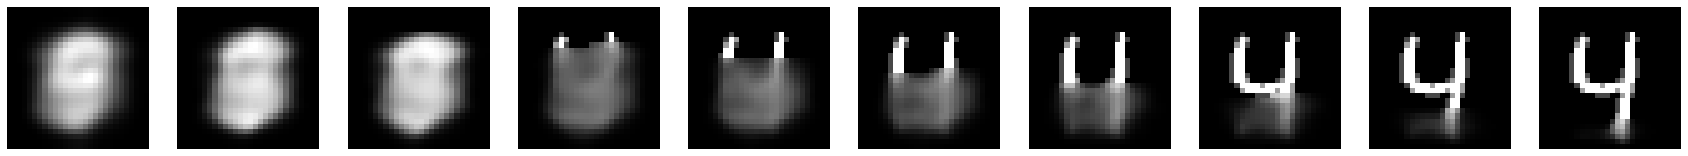

Step 12111, Loss (last minibatch): 0.29852455854415894, Loss (500 step avg.): 0.24827787800582346


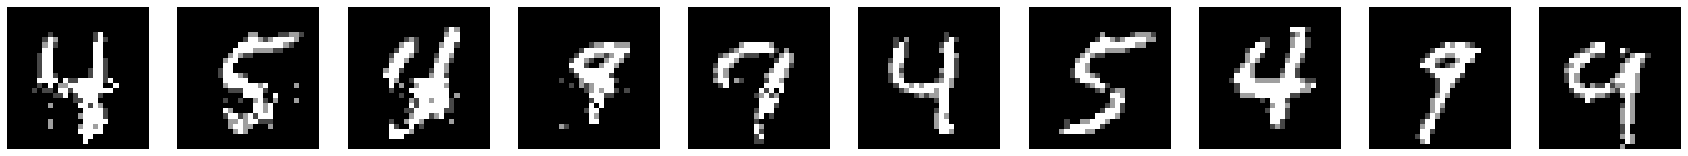

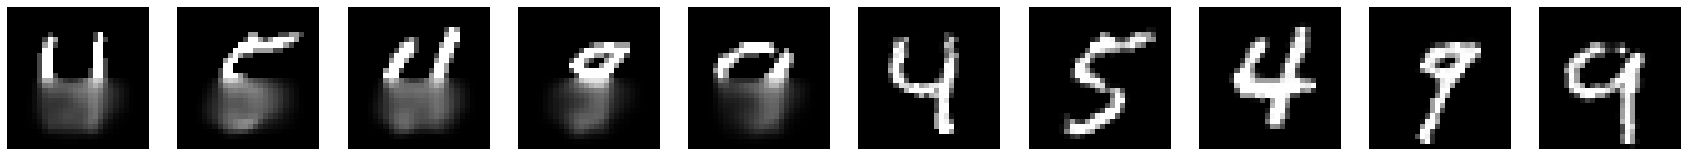

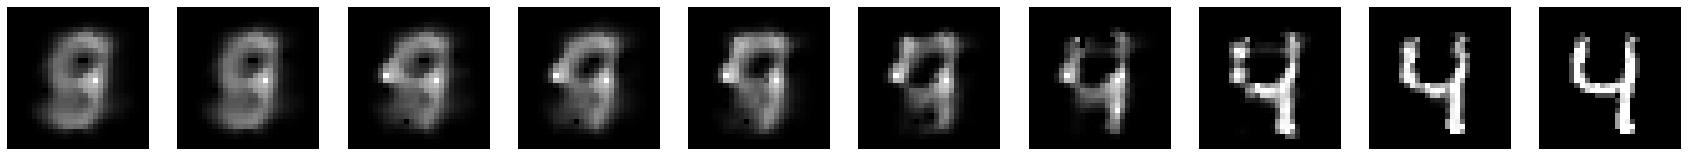

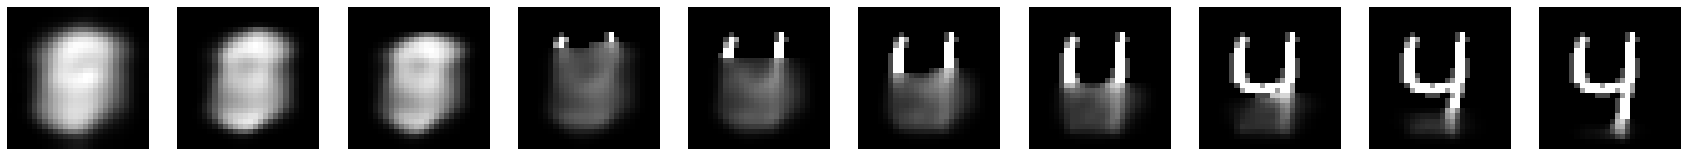

Step 13111, Loss (last minibatch): 0.2542811930179596, Loss (500 step avg.): 0.24399461497565705


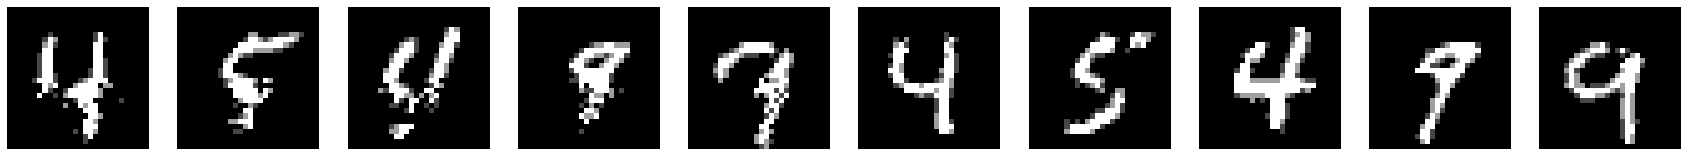

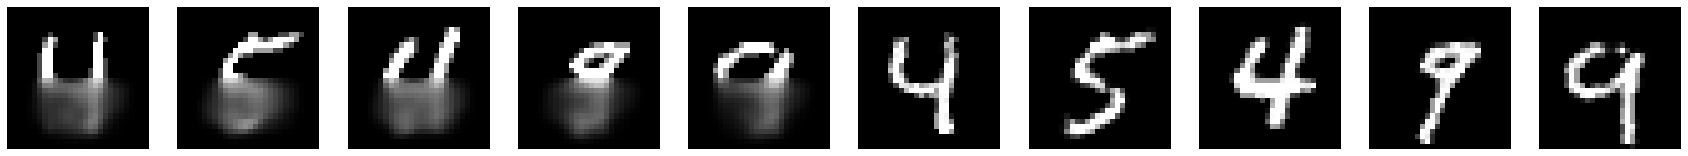

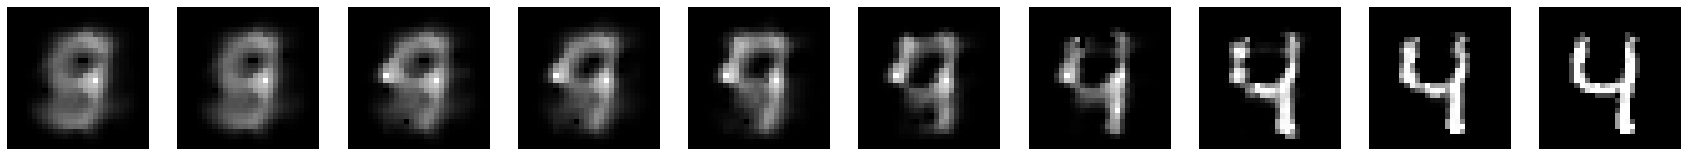

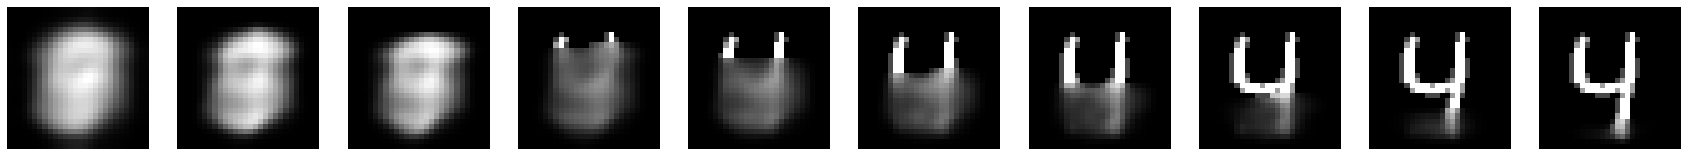

Step 14111, Loss (last minibatch): 0.1828419417142868, Loss (500 step avg.): 0.24080068402423593


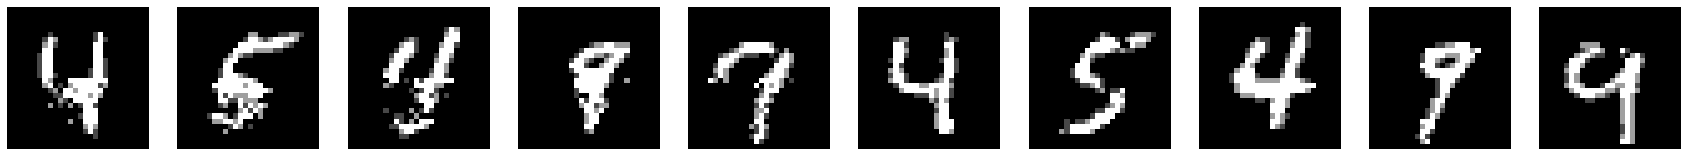

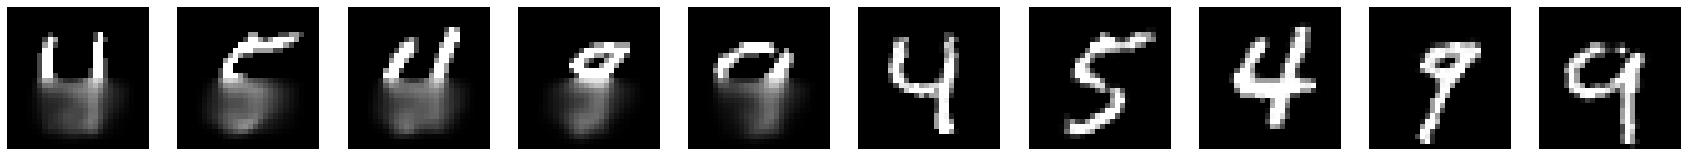

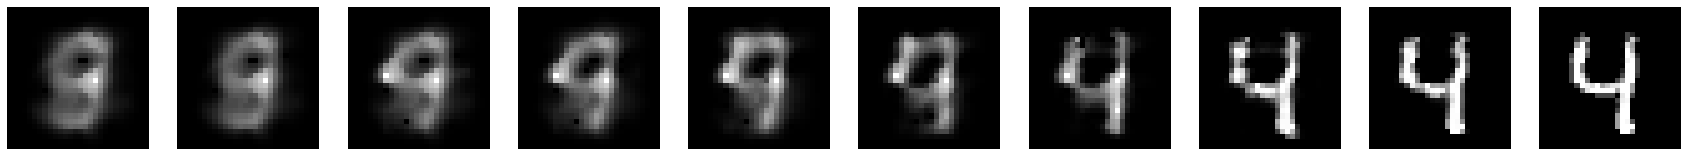

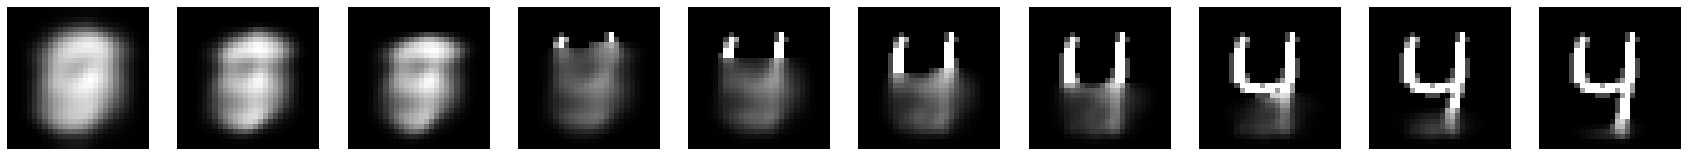

Step 15111, Loss (last minibatch): 0.1943672150373459, Loss (500 step avg.): 0.2397920244527672


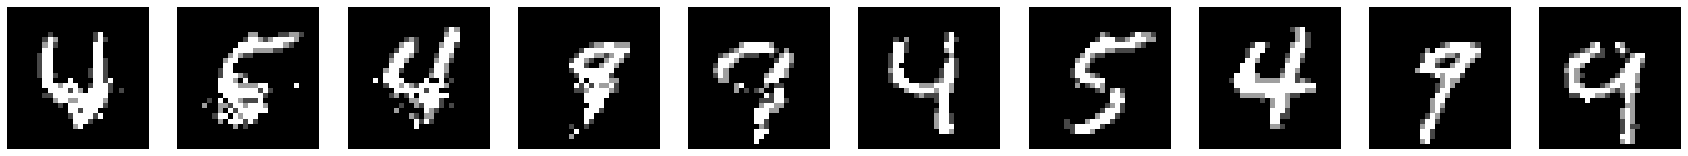

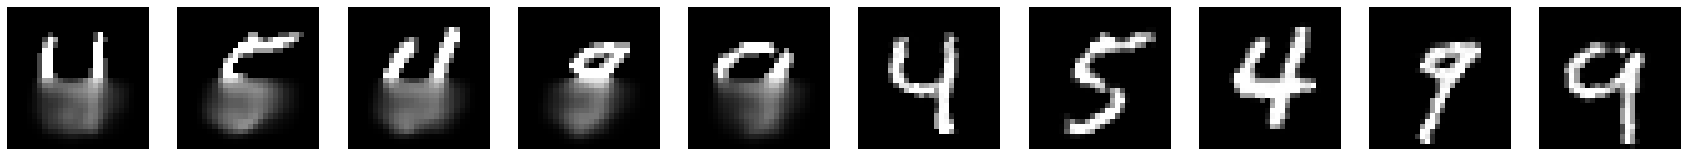

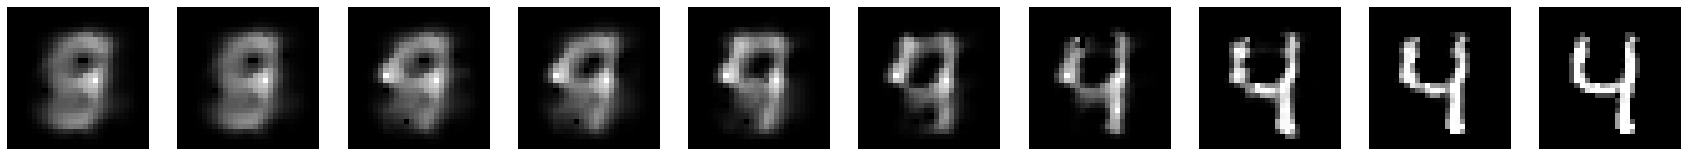

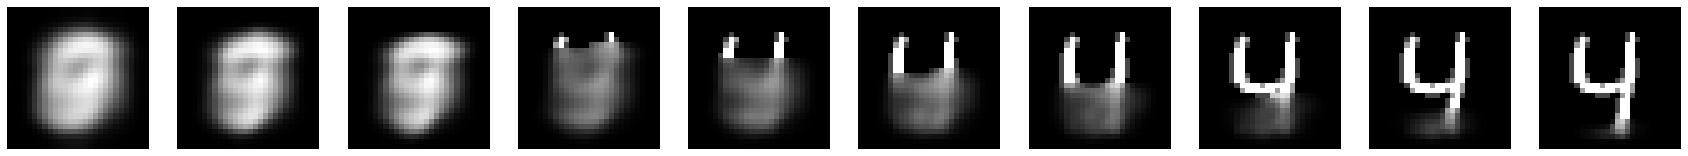

Step 16111, Loss (last minibatch): 0.18157744407653809, Loss (500 step avg.): 0.2332377323430931


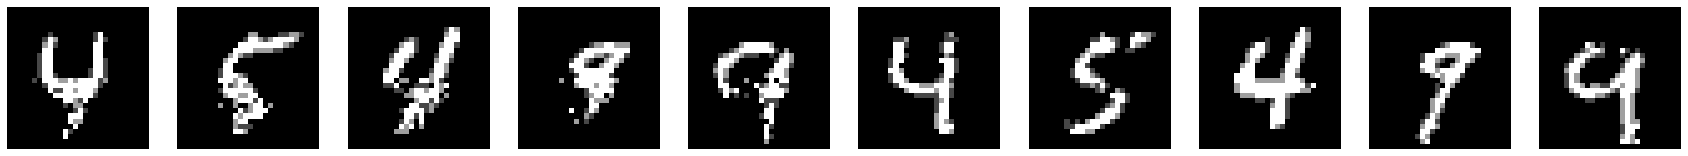

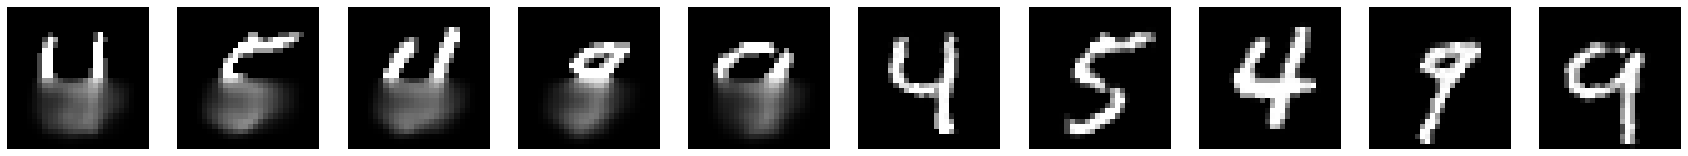

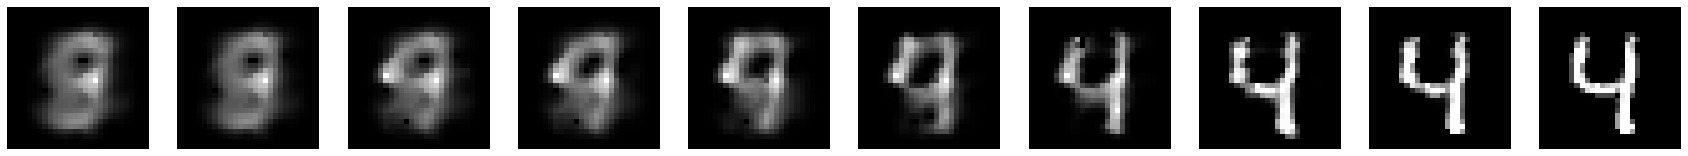

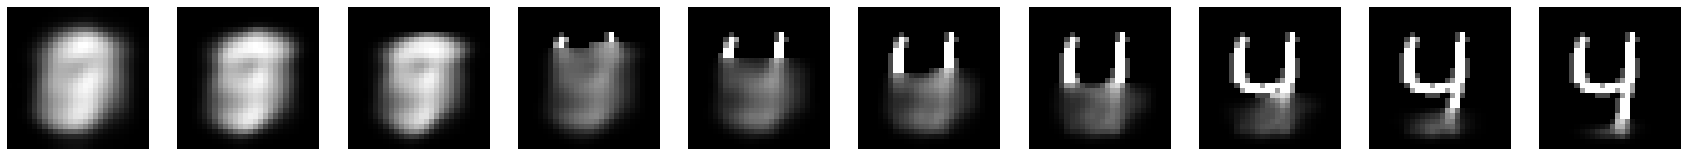

Step 17111, Loss (last minibatch): 0.236738920211792, Loss (500 step avg.): 0.2306697934628009


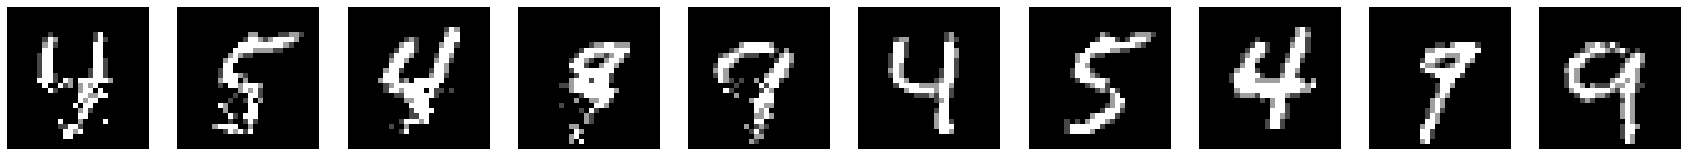

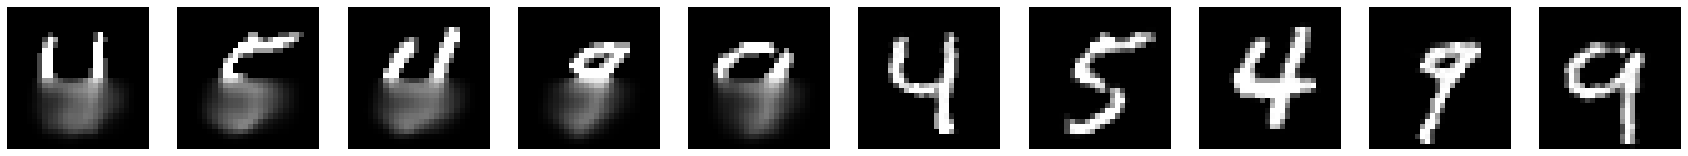

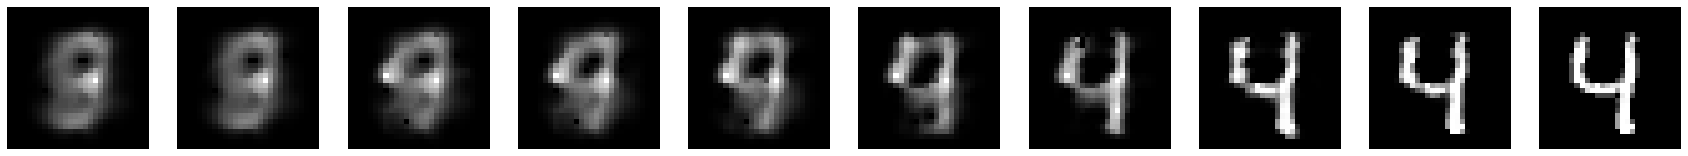

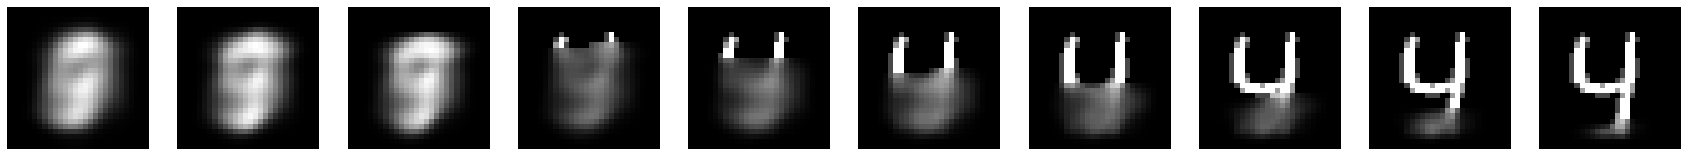

Step 18111, Loss (last minibatch): 0.32329997420310974, Loss (500 step avg.): 0.2290394575652962


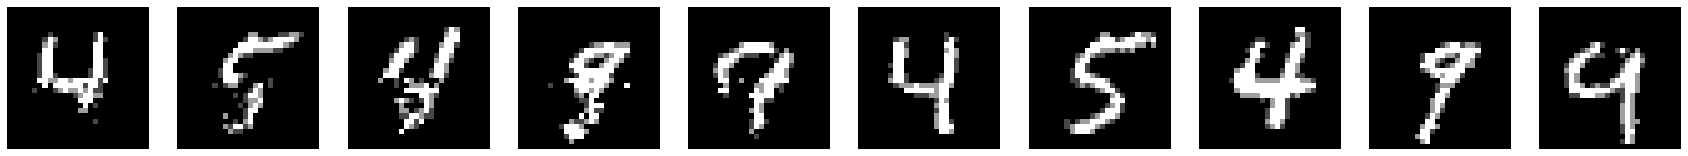

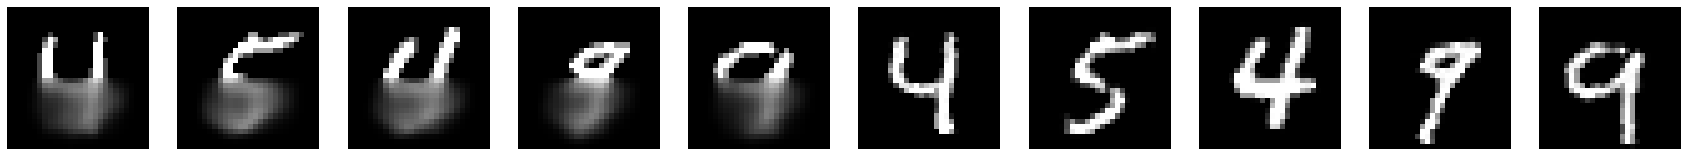

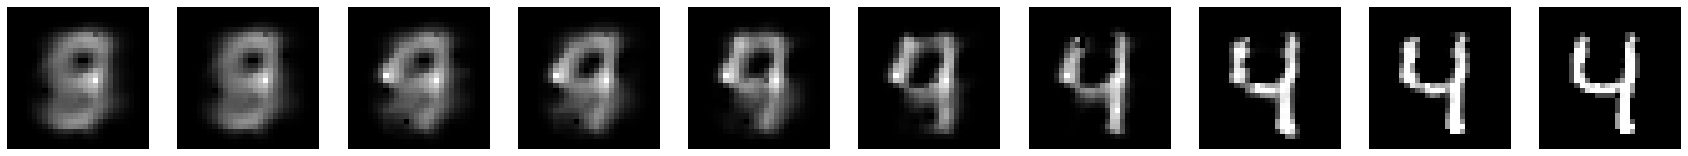

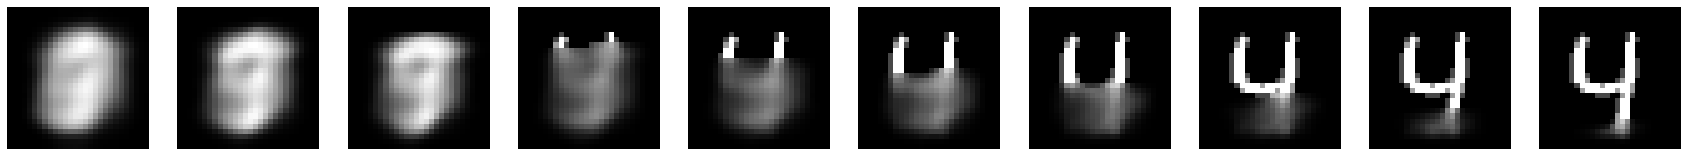

Step 19111, Loss (last minibatch): 0.19615845382213593, Loss (500 step avg.): 0.22637844124359047


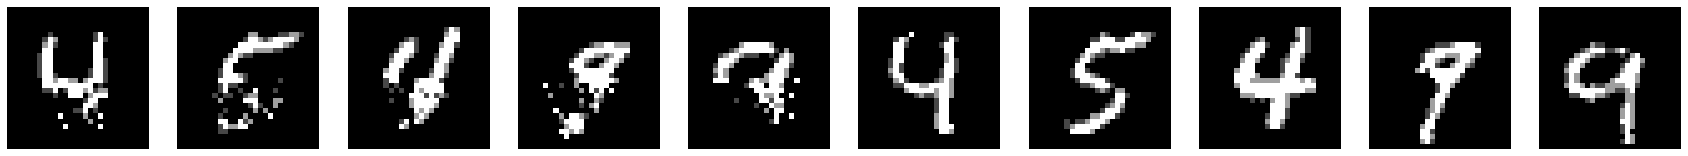

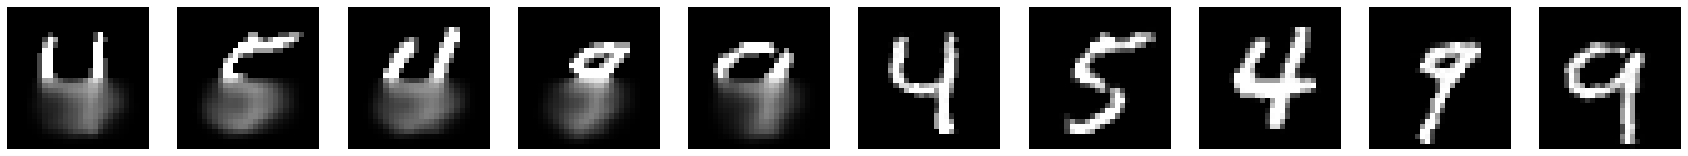

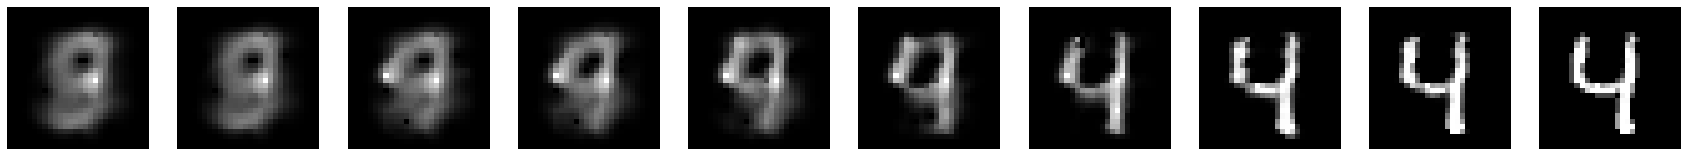

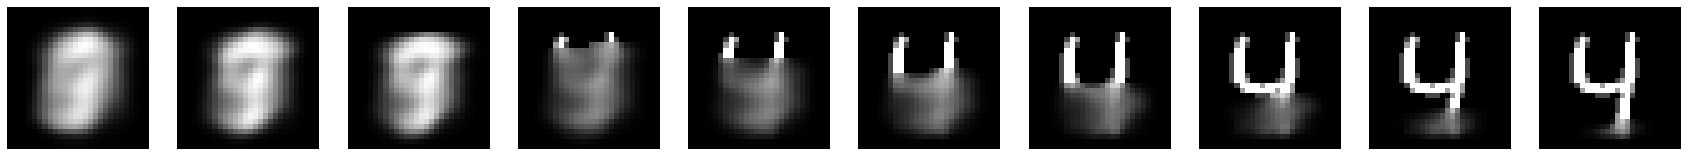

Step 20111, Loss (last minibatch): 0.26465103030204773, Loss (500 step avg.): 0.2274217504019033


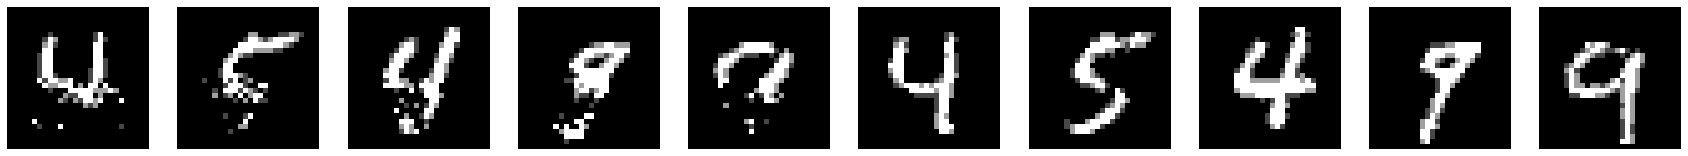

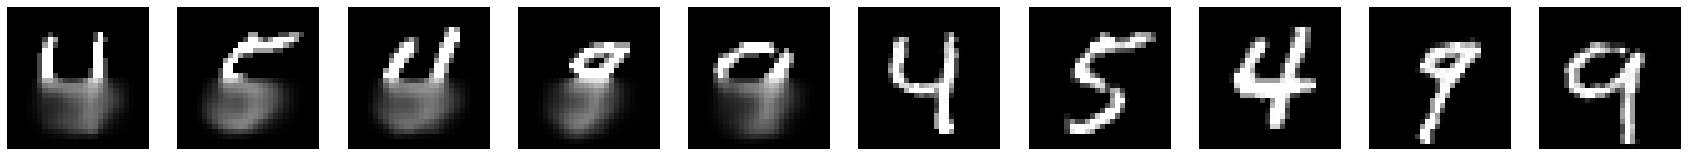

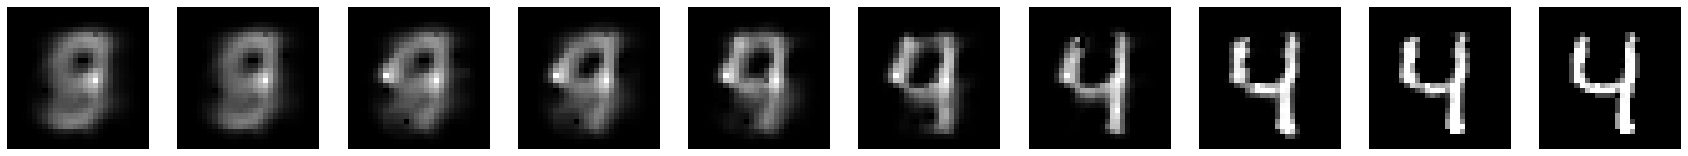

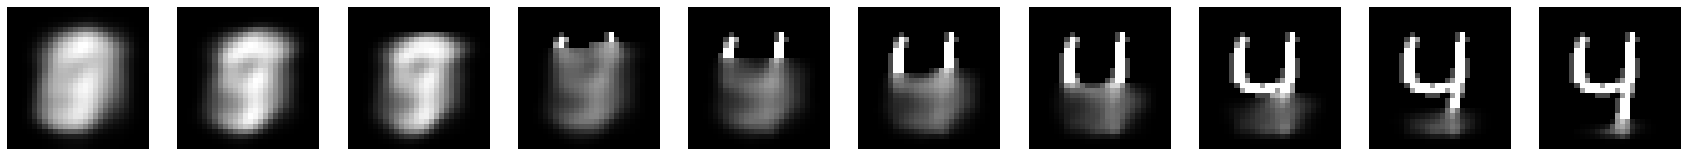

Step 21111, Loss (last minibatch): 0.23741470277309418, Loss (500 step avg.): 0.2218932220916786


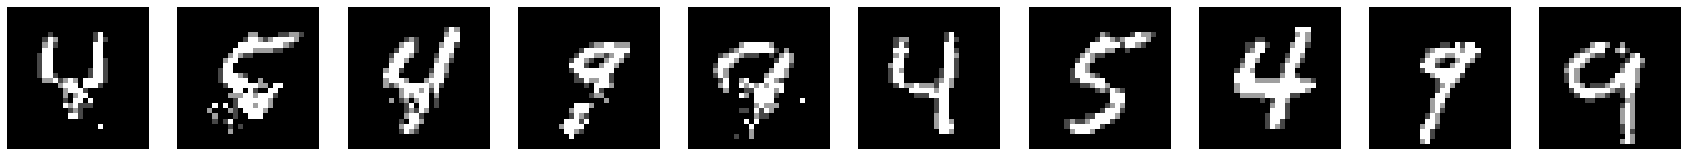

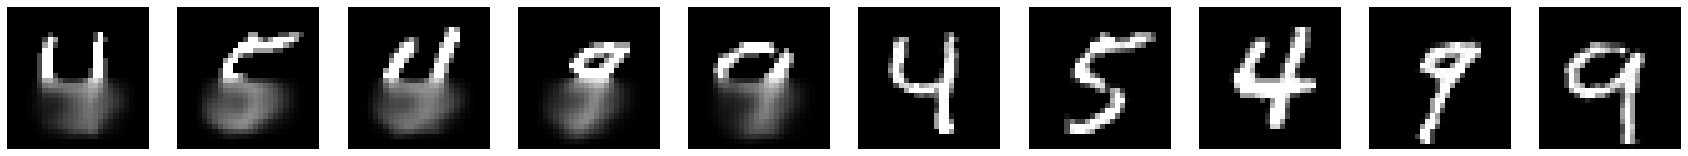

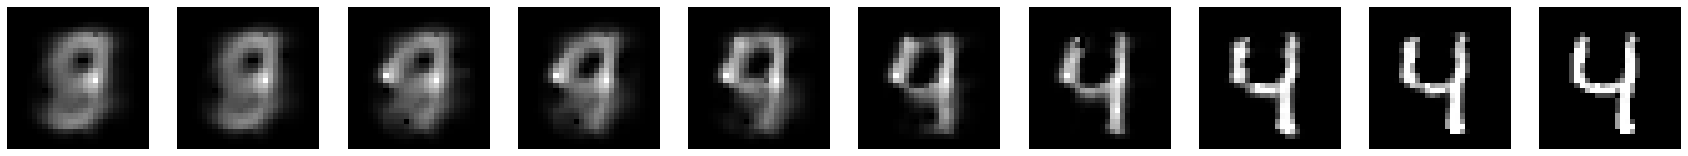

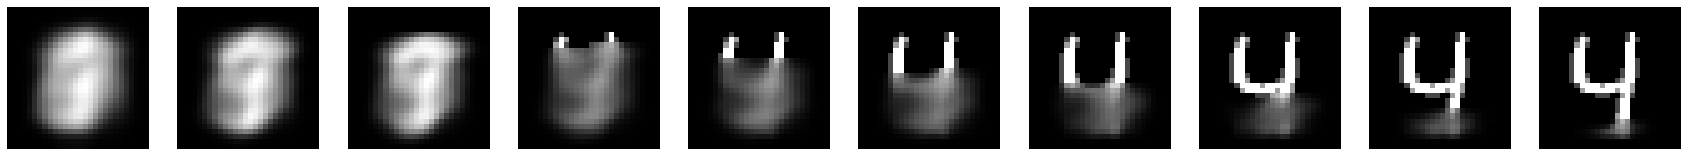

Step 22111, Loss (last minibatch): 0.3070131242275238, Loss (500 step avg.): 0.22275748438463955


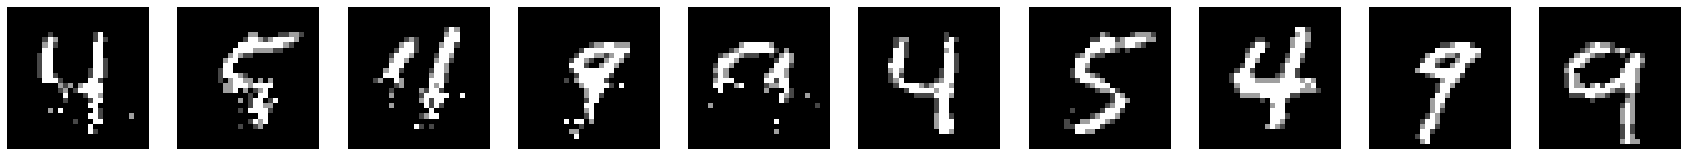

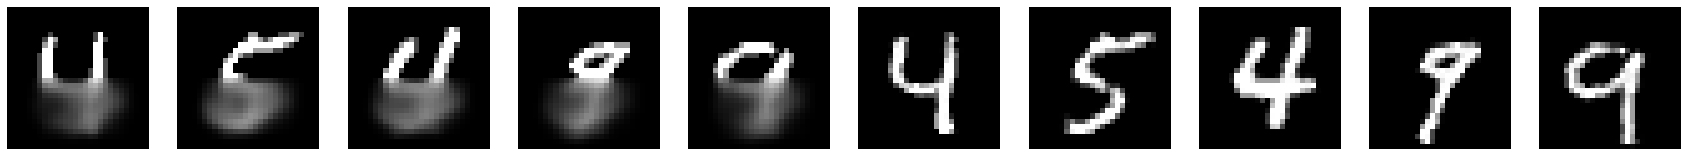

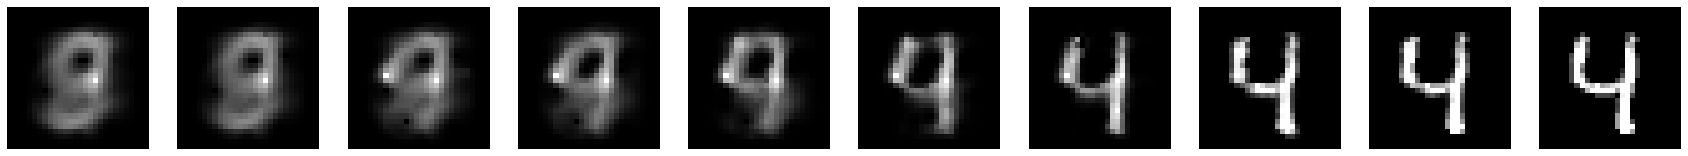

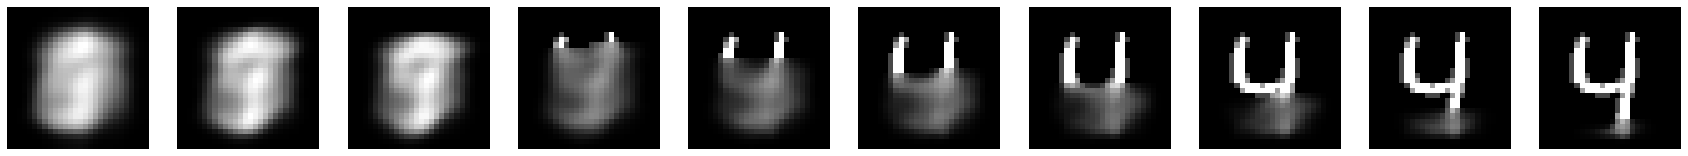

Step 23111, Loss (last minibatch): 0.18264202773571014, Loss (500 step avg.): 0.21993382932421215


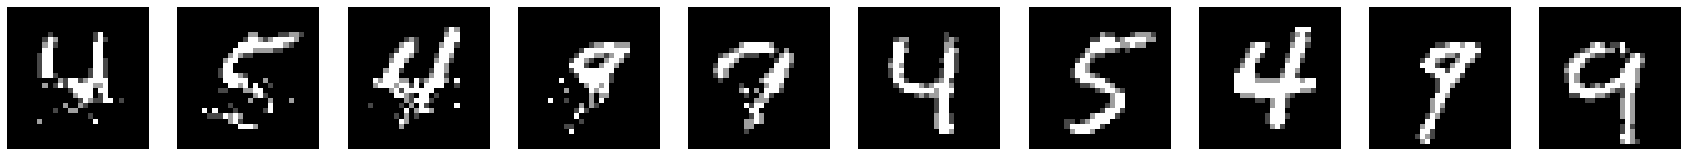

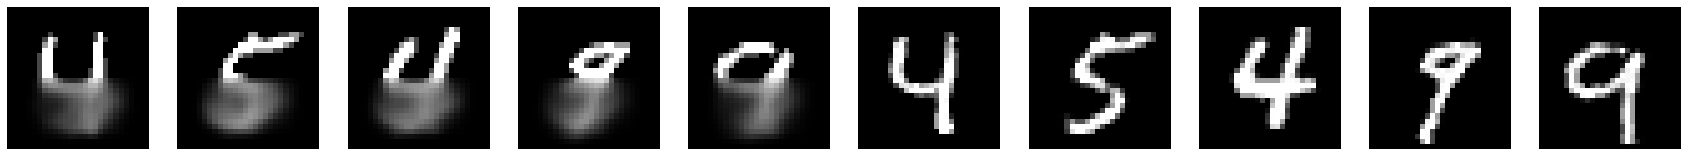

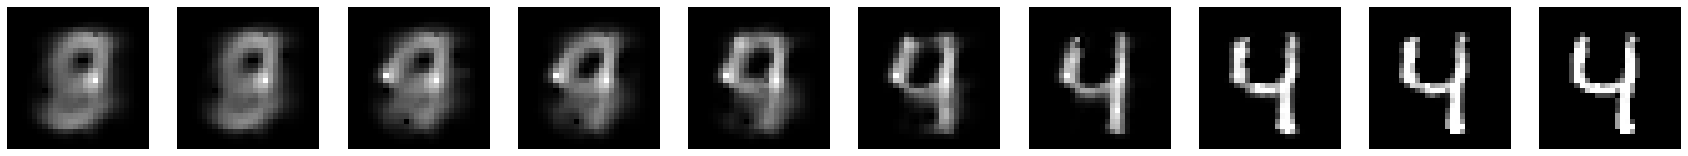

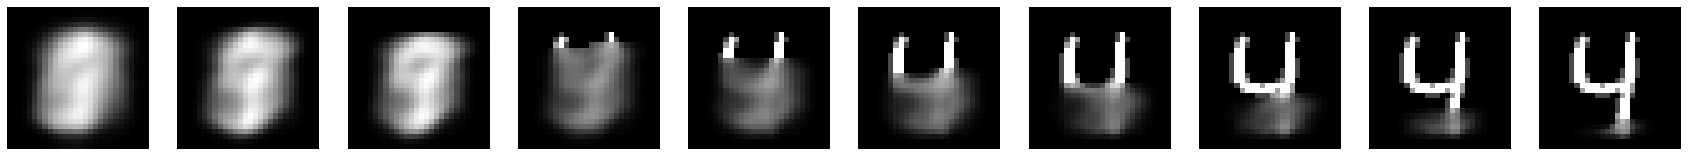

Step 24111, Loss (last minibatch): 0.22737066447734833, Loss (500 step avg.): 0.21754925991008858


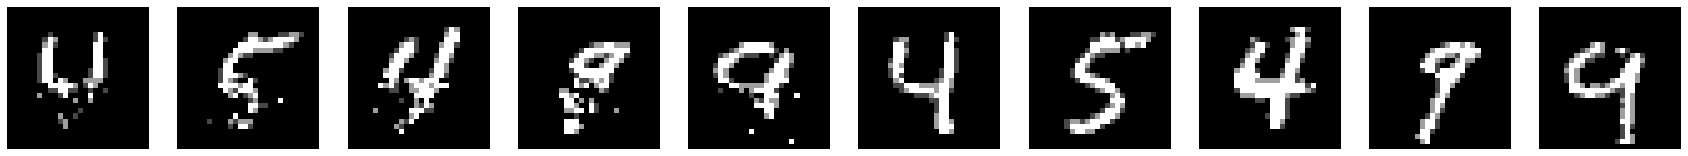

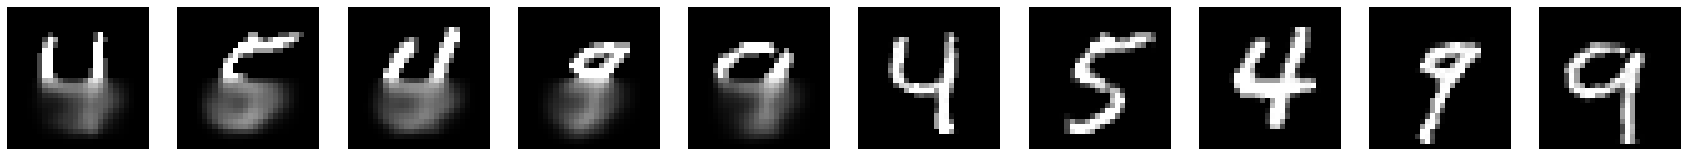

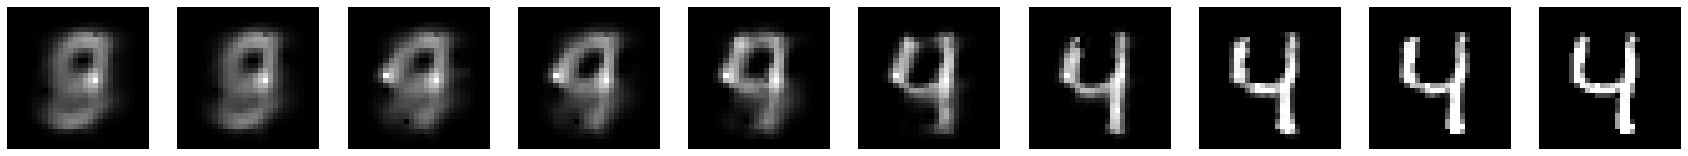

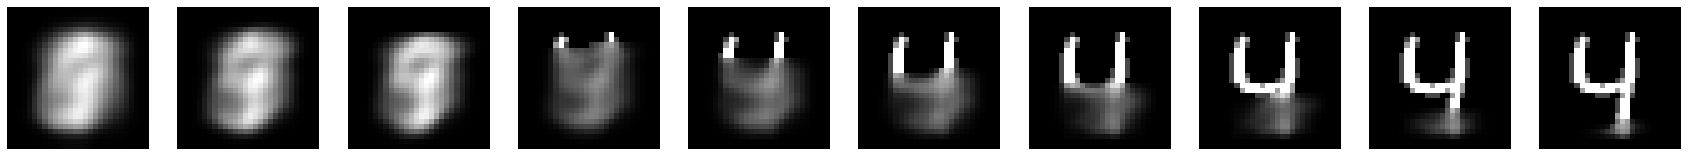

Step 25111, Loss (last minibatch): 0.18800672888755798, Loss (500 step avg.): 0.217134367295368


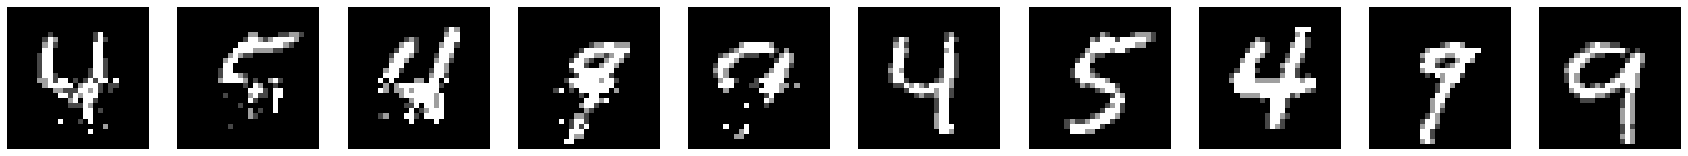

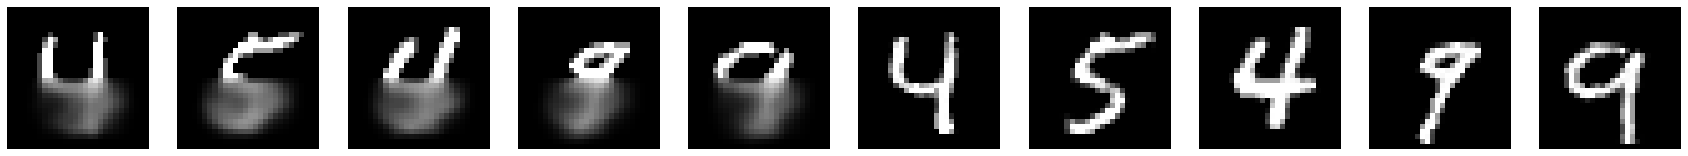

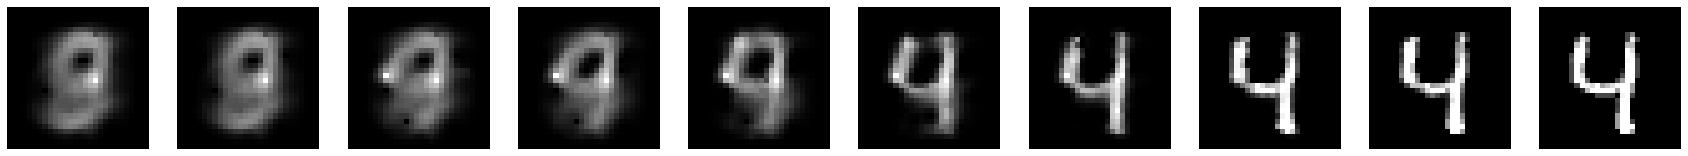

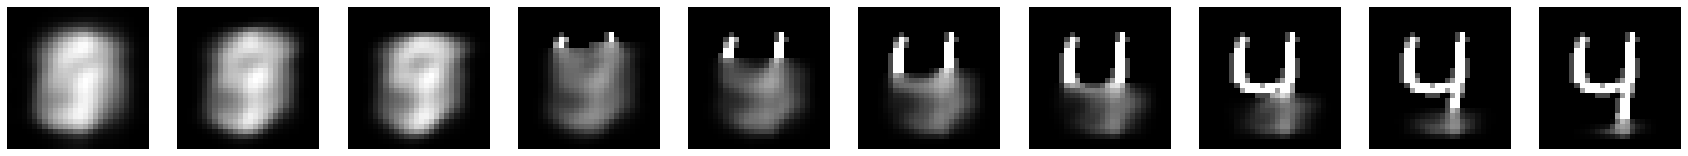

Step 26111, Loss (last minibatch): 0.1869678944349289, Loss (500 step avg.): 0.21530843195979465


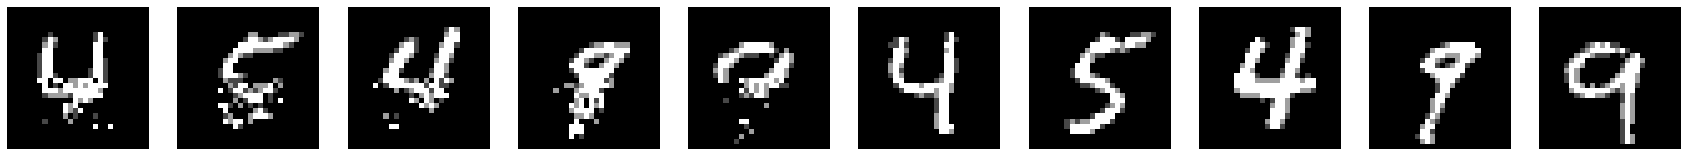

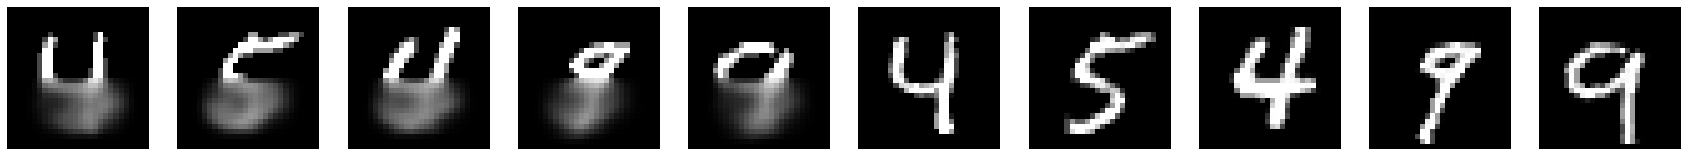

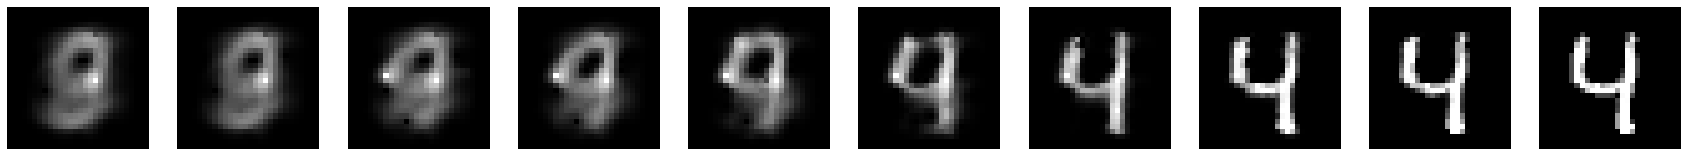

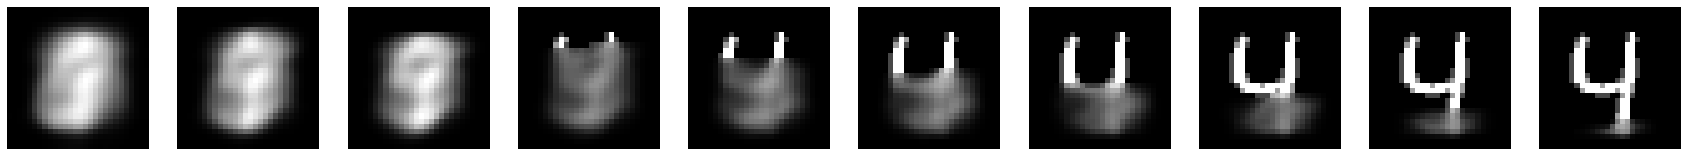

Step 27111, Loss (last minibatch): 0.22169756889343262, Loss (500 step avg.): 0.21159983850167896


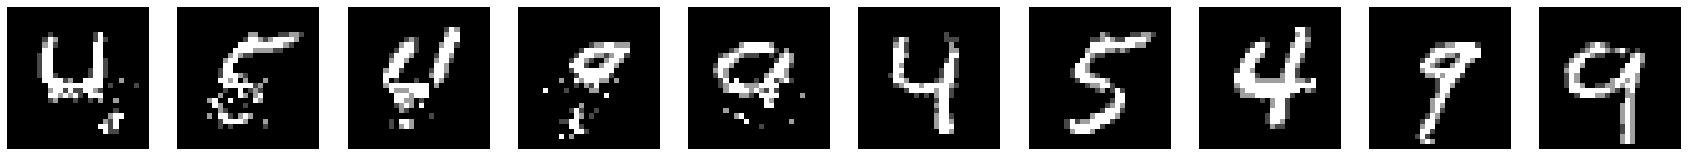

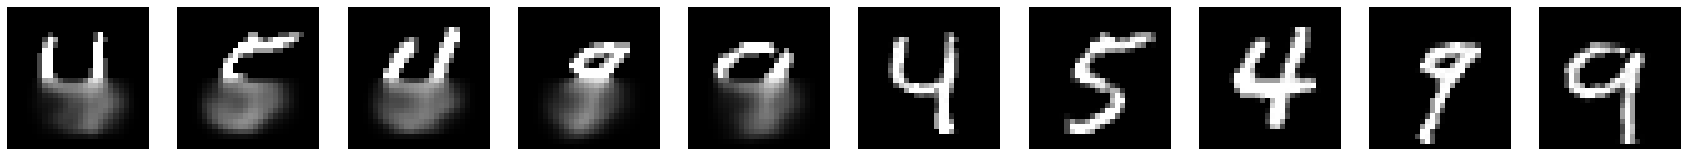

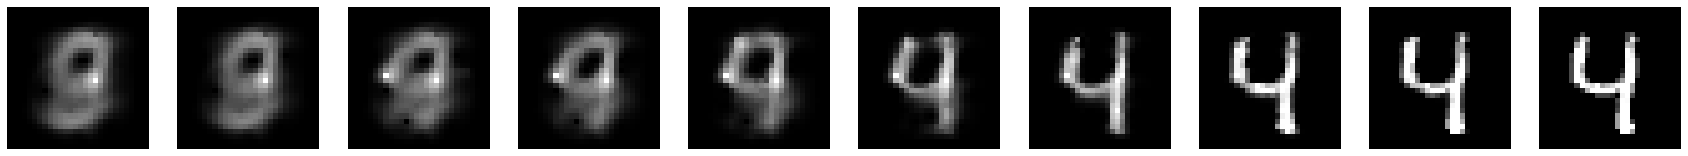

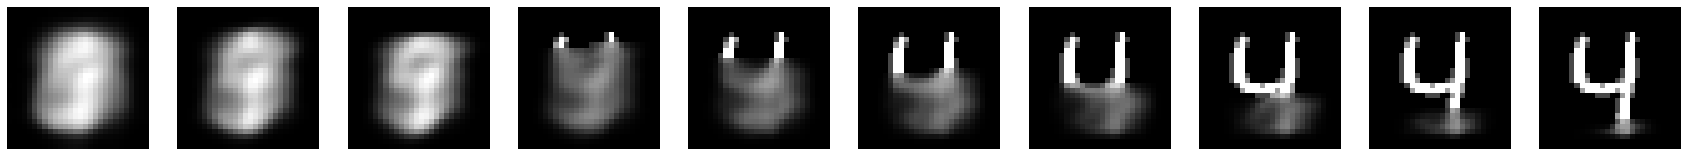

Step 28111, Loss (last minibatch): 0.2479424774646759, Loss (500 step avg.): 0.20593800177117308


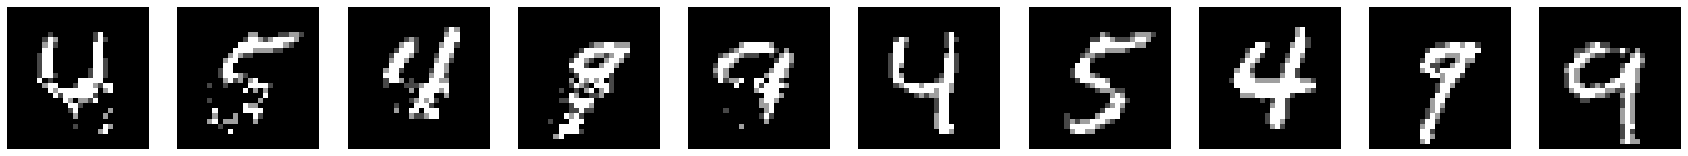

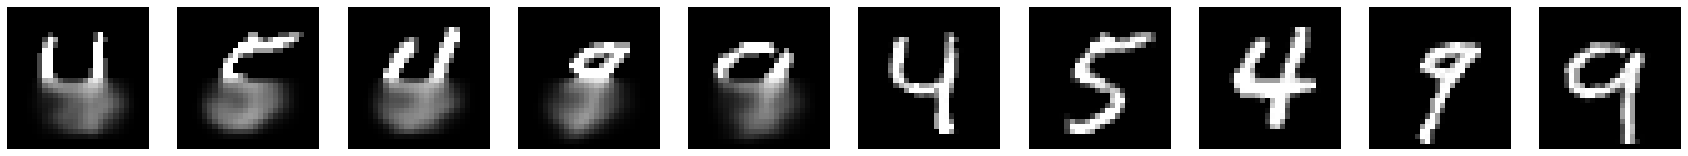

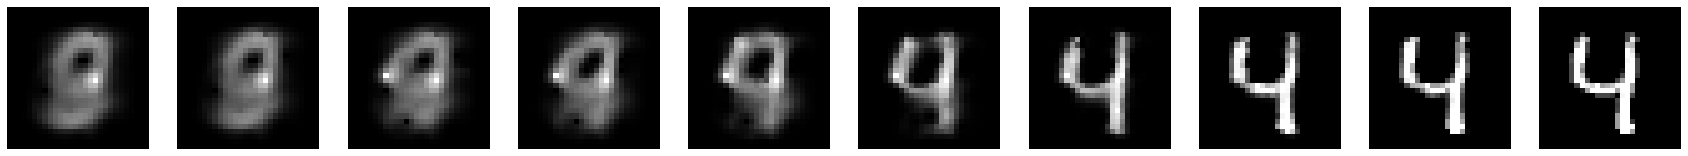

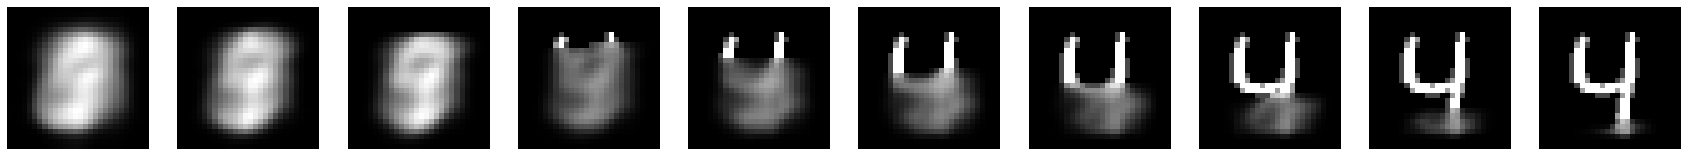

Step 29111, Loss (last minibatch): 0.24437642097473145, Loss (500 step avg.): 0.20996670653958044


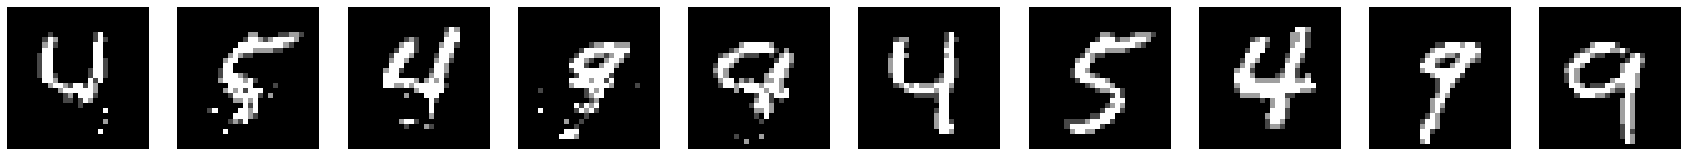

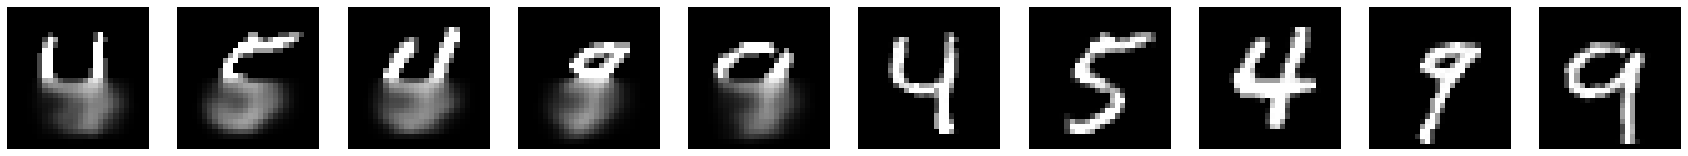

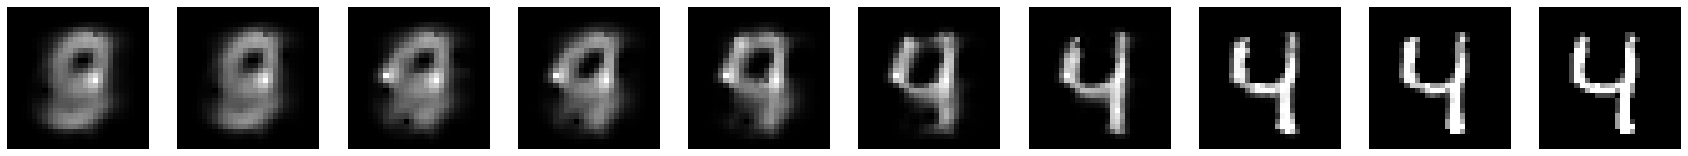

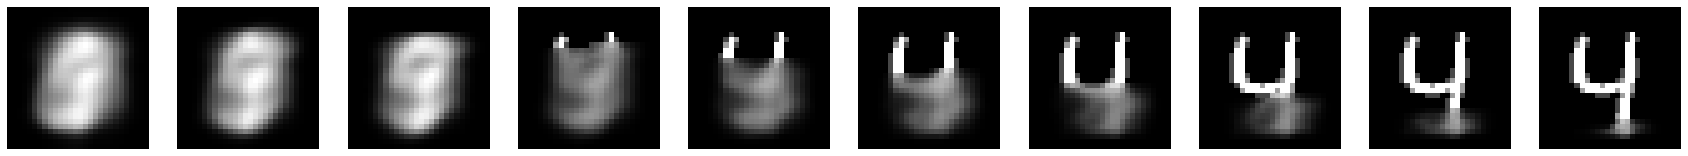

Step 30111, Loss (last minibatch): 0.12710867822170258, Loss (500 step avg.): 0.21049252156904358


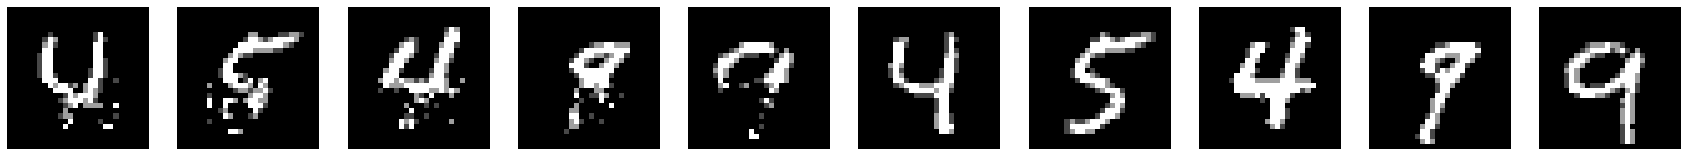

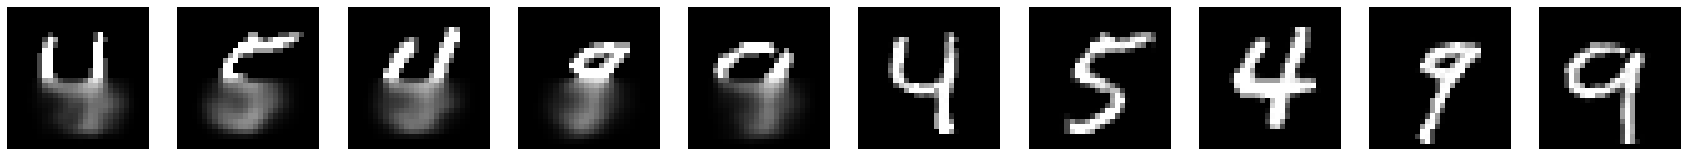

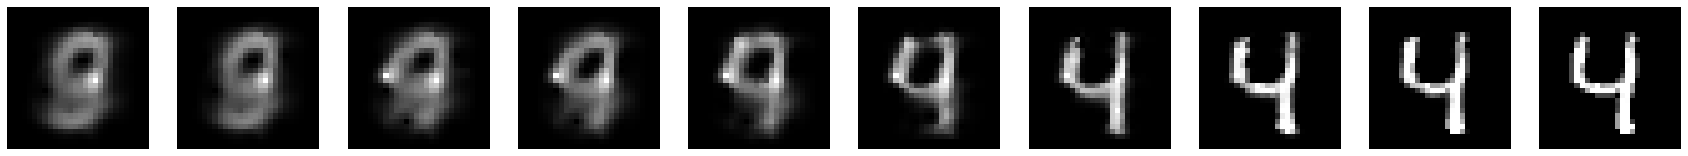

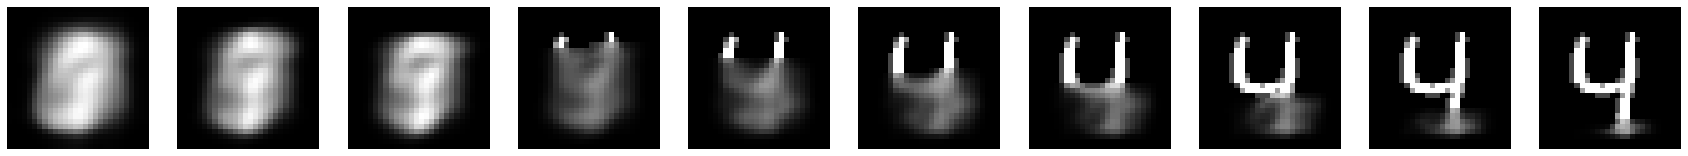

Step 31111, Loss (last minibatch): 0.22040955722332, Loss (500 step avg.): 0.21163627978213534


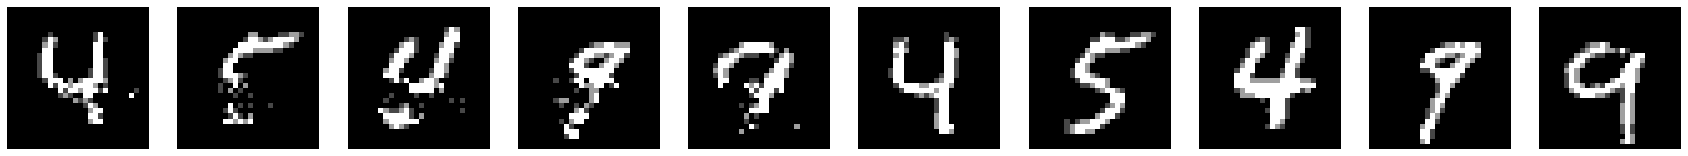

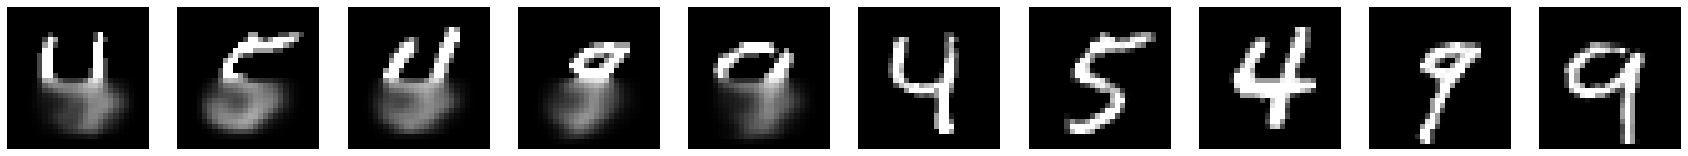

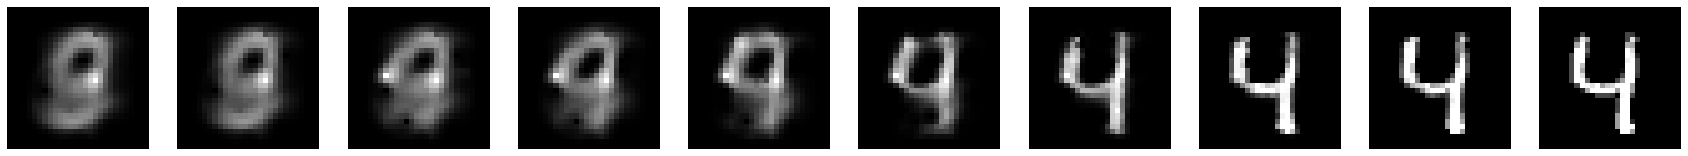

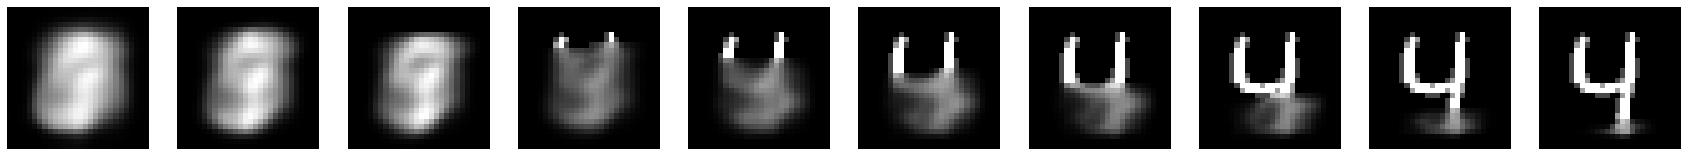

Step 32111, Loss (last minibatch): 0.28404828906059265, Loss (500 step avg.): 0.2038368522942423


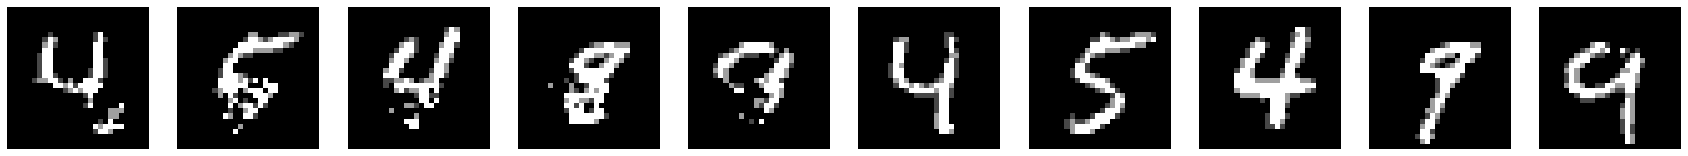

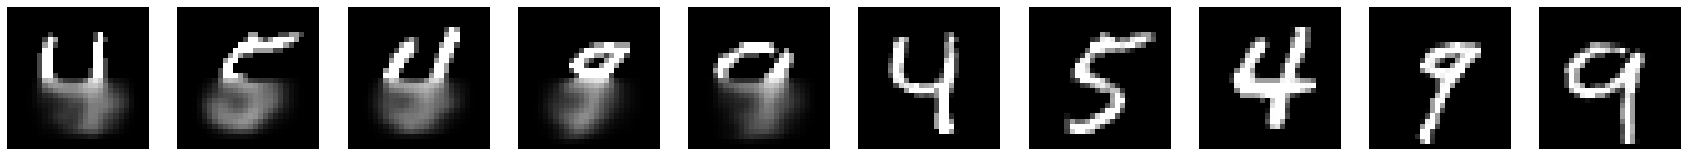

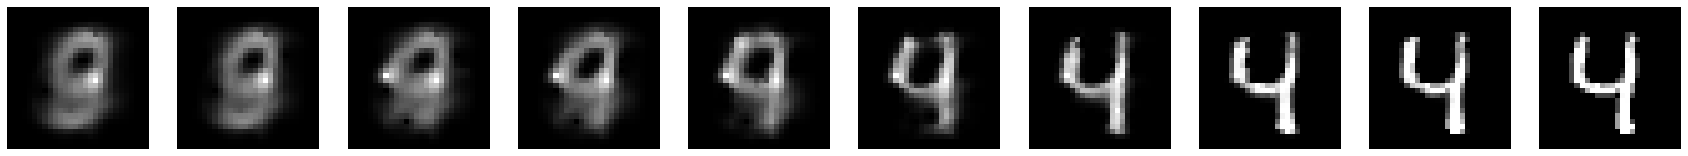

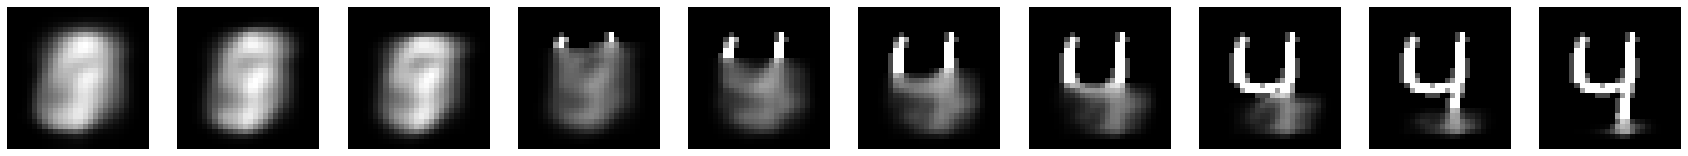

Step 33111, Loss (last minibatch): 0.24103312194347382, Loss (500 step avg.): 0.20695490864460578


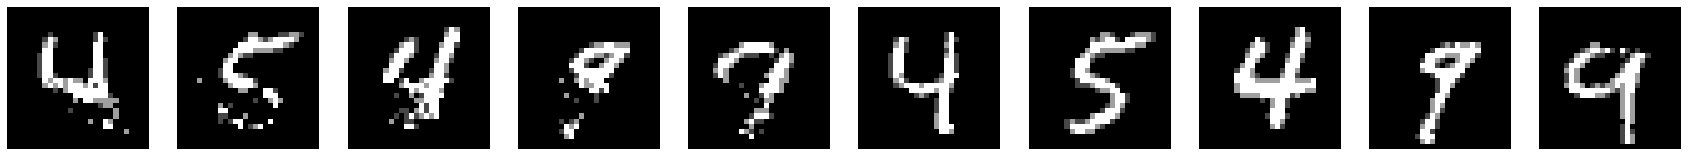

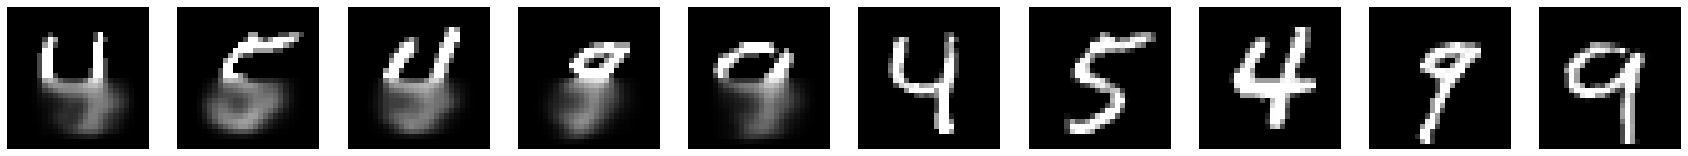

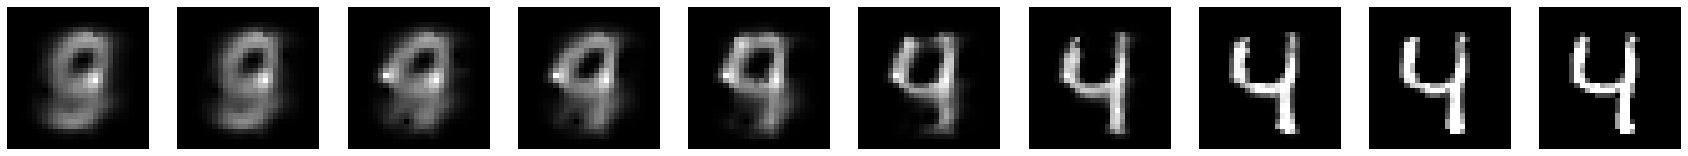

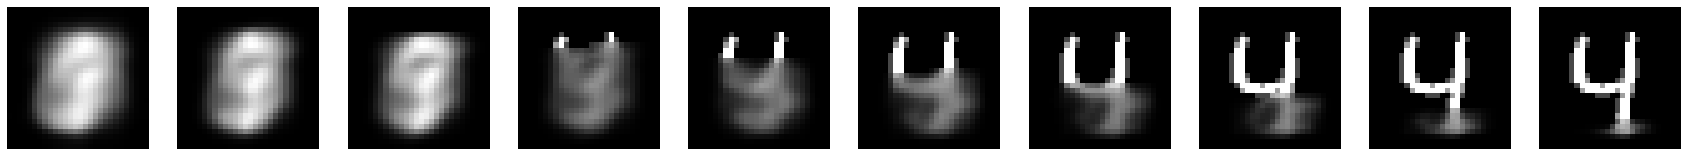

Step 34111, Loss (last minibatch): 0.15391287207603455, Loss (500 step avg.): 0.2029640427874234


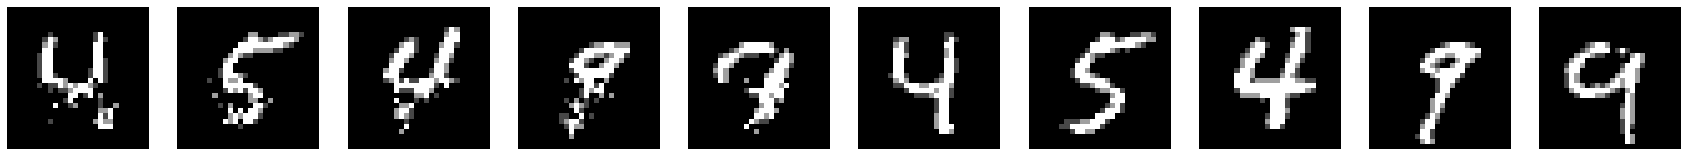

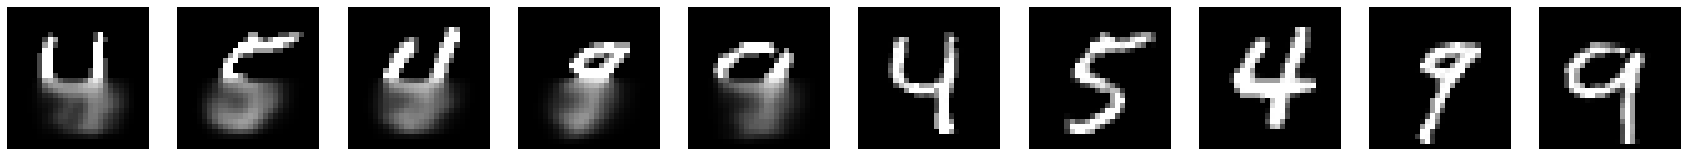

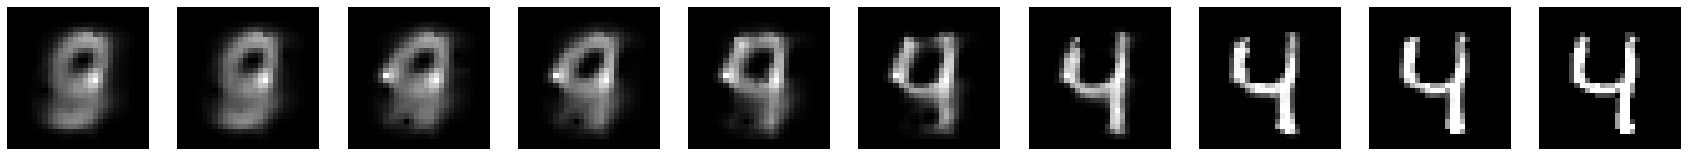

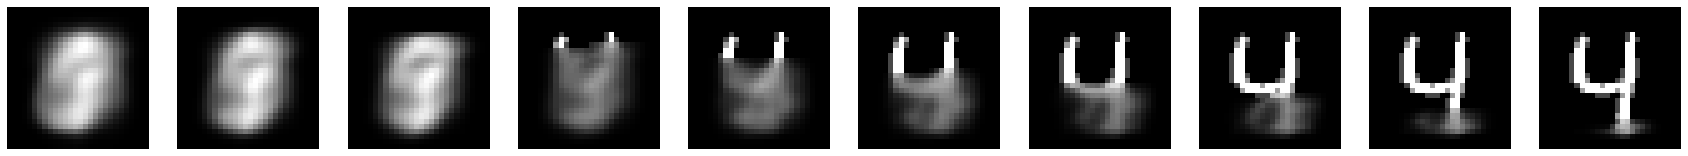

Step 35111, Loss (last minibatch): 0.26315686106681824, Loss (500 step avg.): 0.20565550484343204


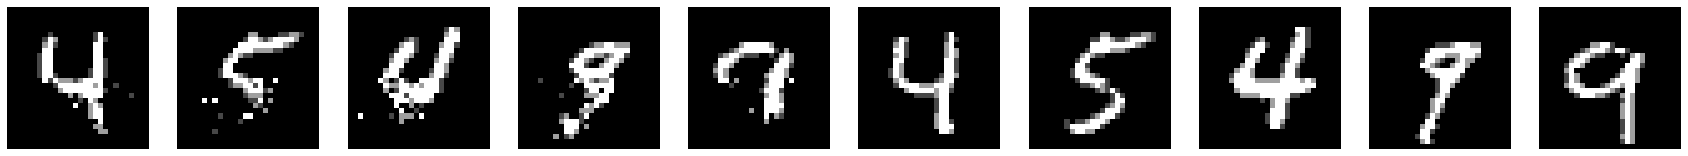

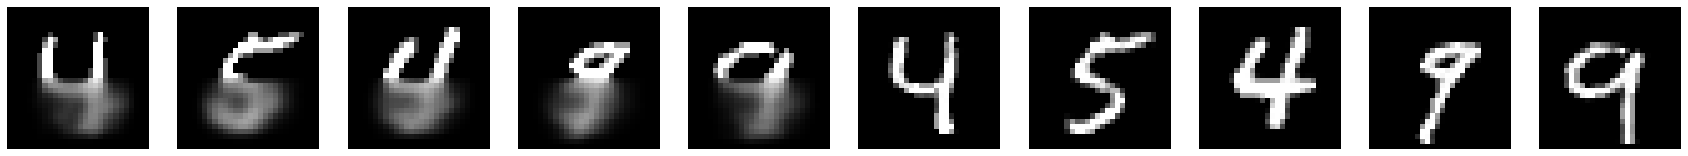

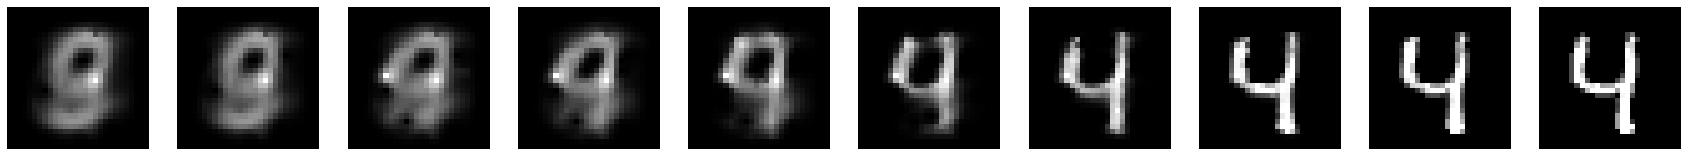

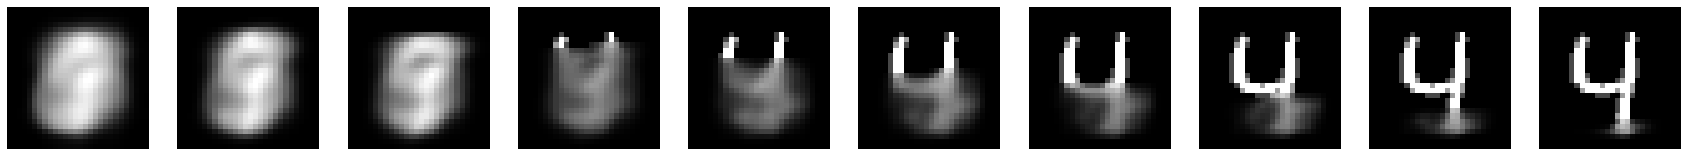

Step 36111, Loss (last minibatch): 0.13569216430187225, Loss (500 step avg.): 0.20184860052819736


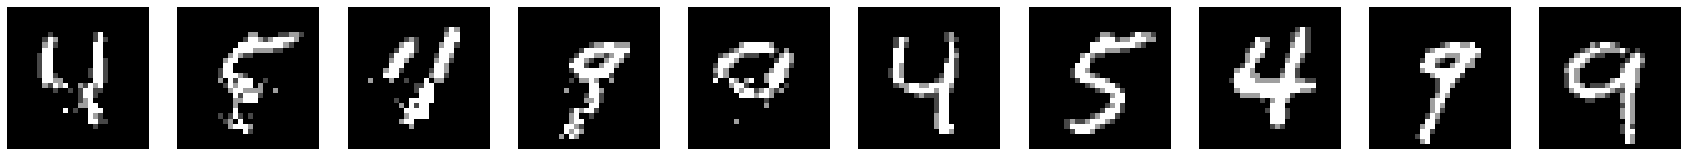

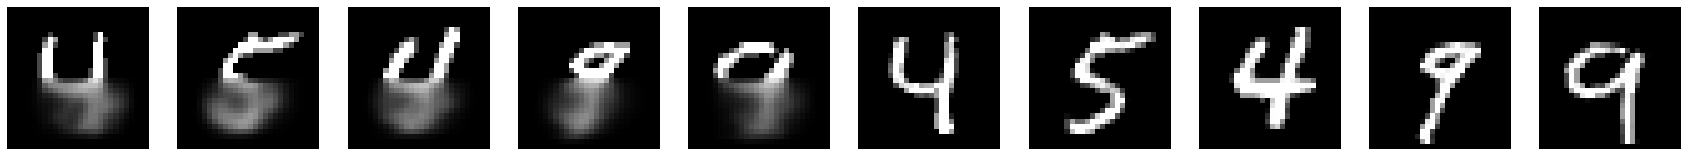

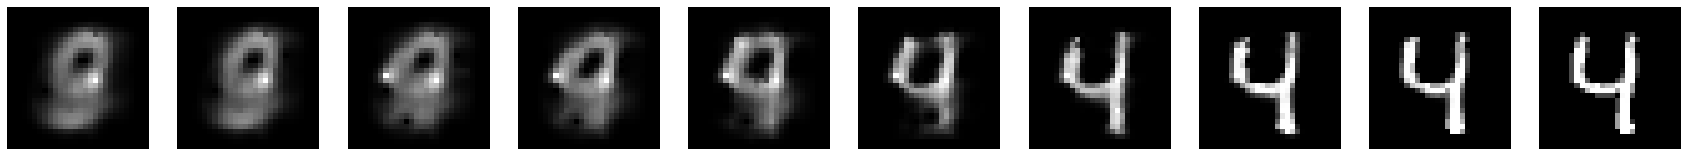

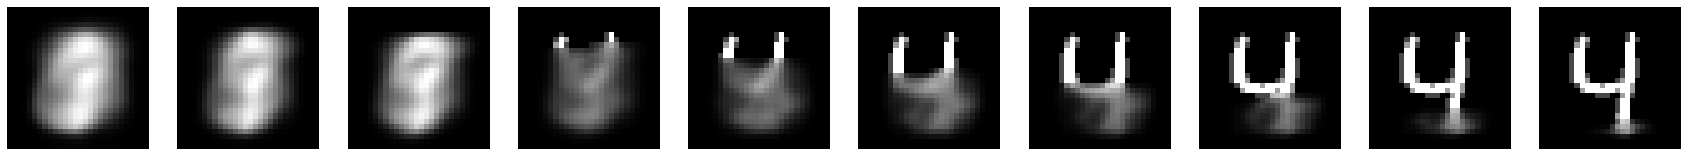

Step 37111, Loss (last minibatch): 0.2855796813964844, Loss (500 step avg.): 0.2018811237252877


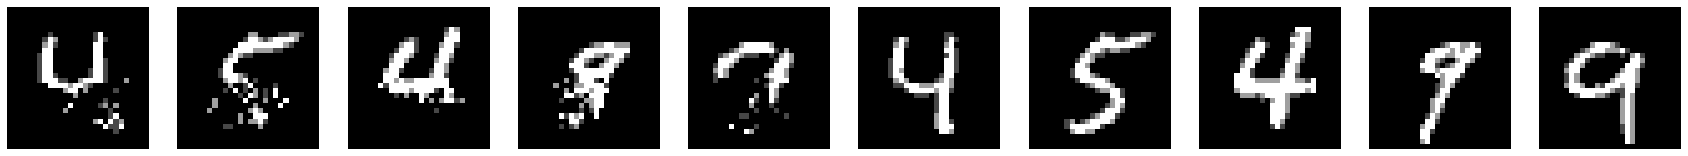

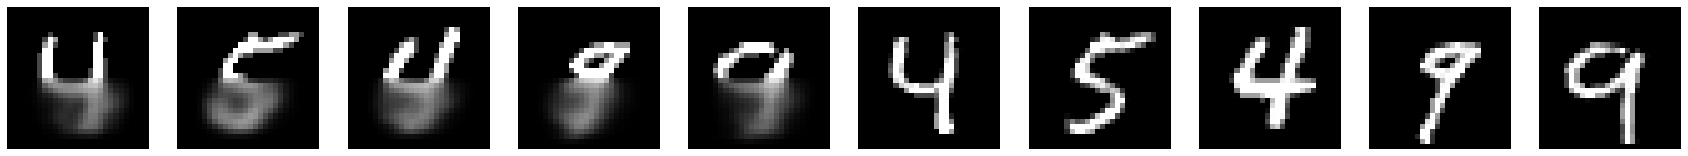

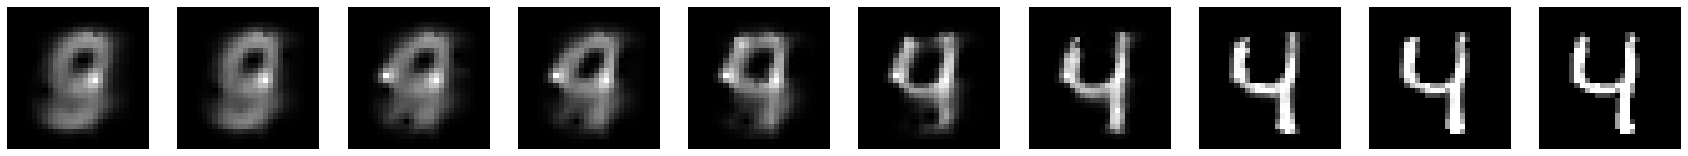

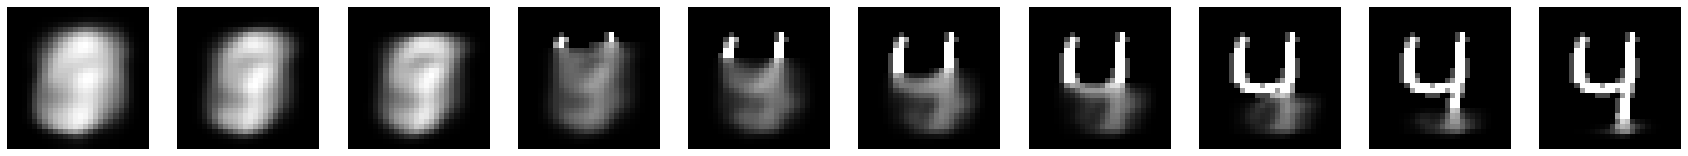

Step 38111, Loss (last minibatch): 0.21644026041030884, Loss (500 step avg.): 0.2028186454357739


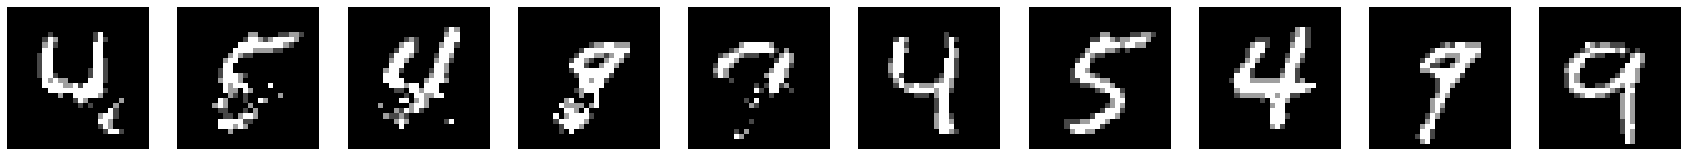

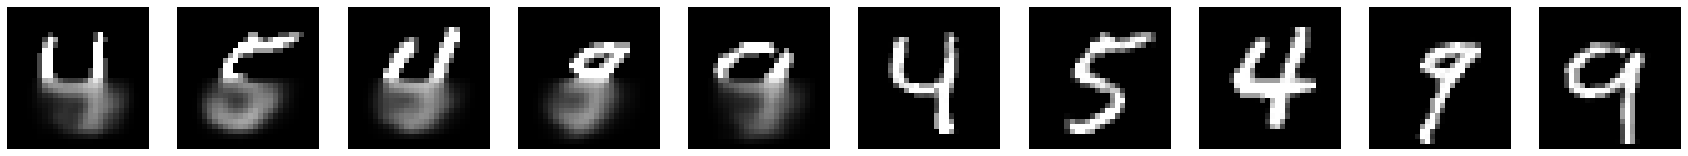

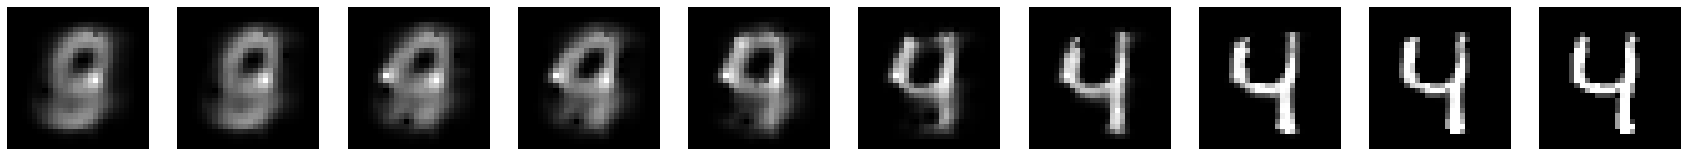

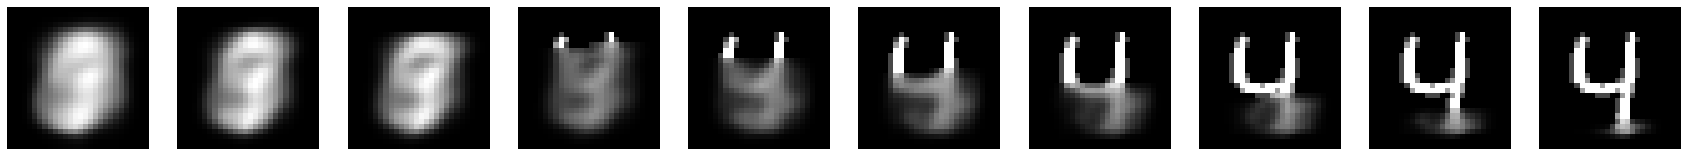

Step 39111, Loss (last minibatch): 0.20628374814987183, Loss (500 step avg.): 0.20039559683637942


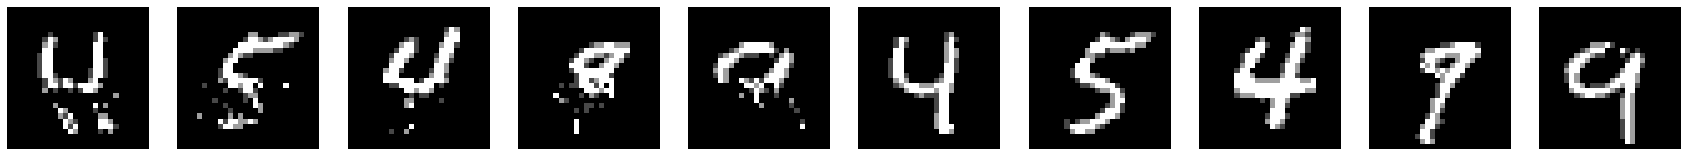

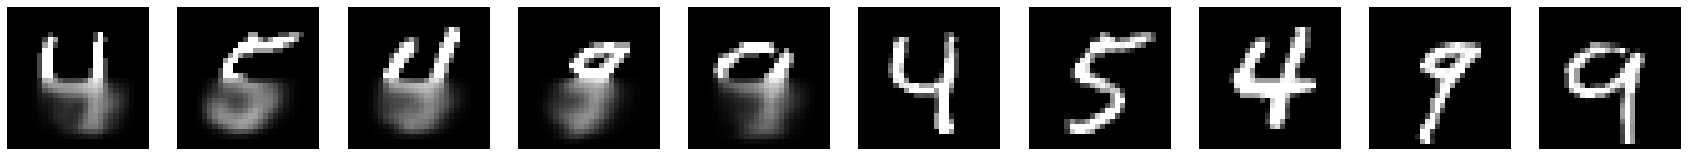

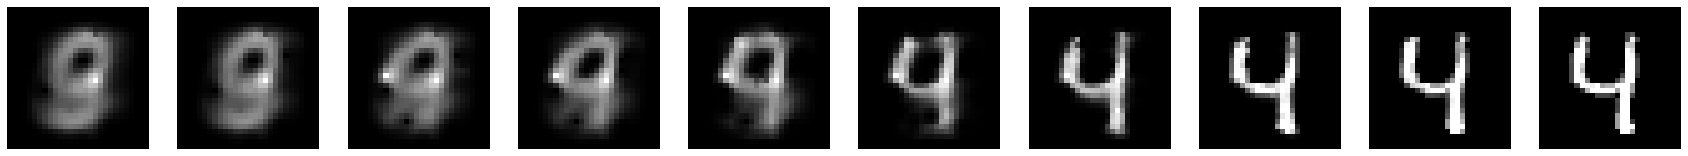

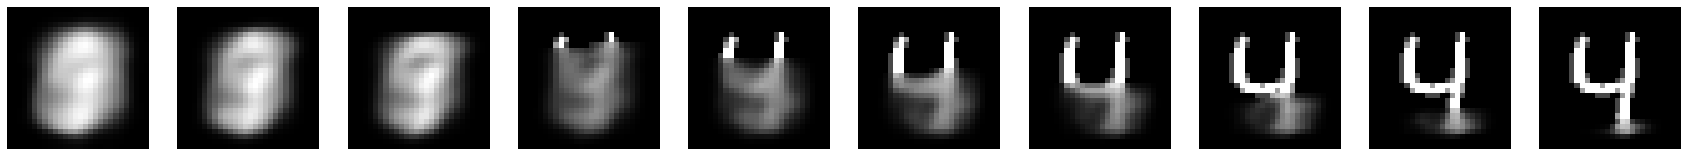

Step 40111, Loss (last minibatch): 0.27422207593917847, Loss (500 step avg.): 0.20041656291889334


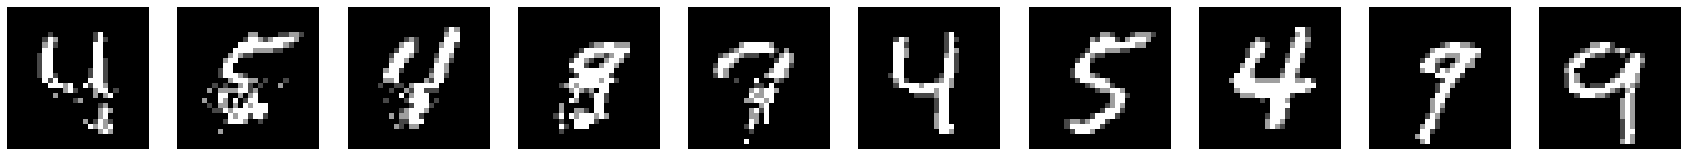

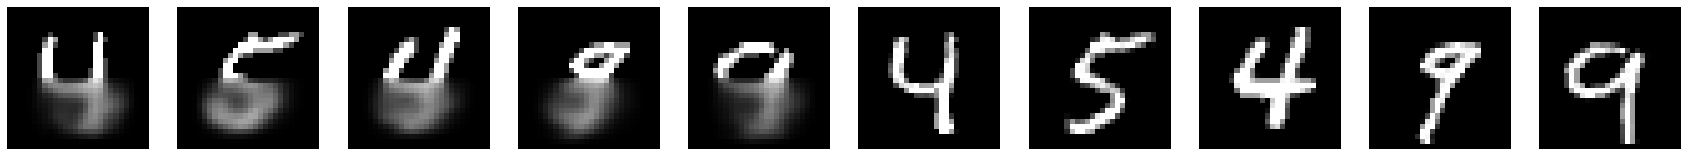

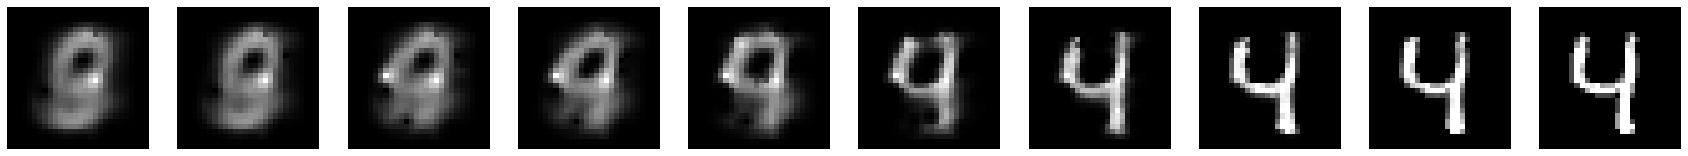

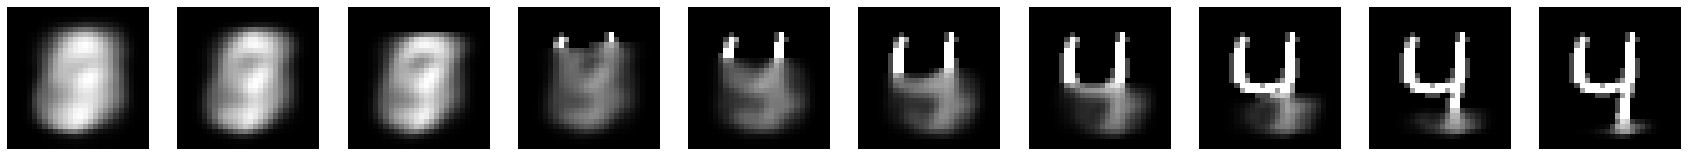

Step 41111, Loss (last minibatch): 0.20181328058242798, Loss (500 step avg.): 0.20190072667872358


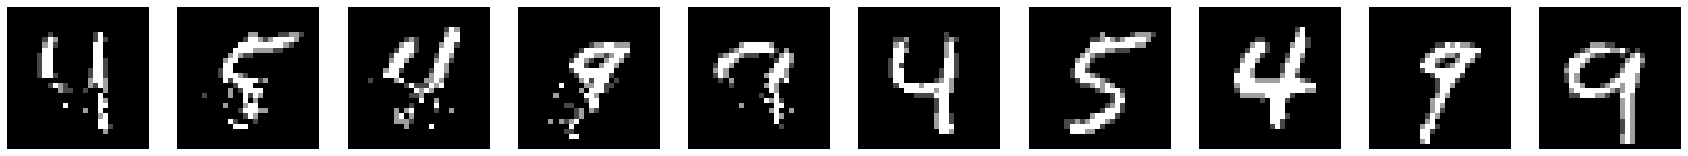

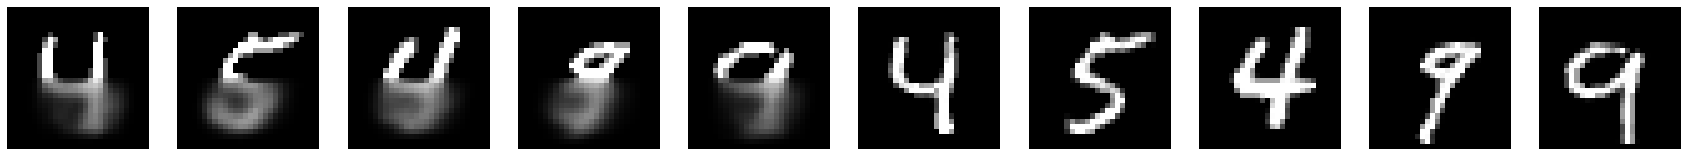

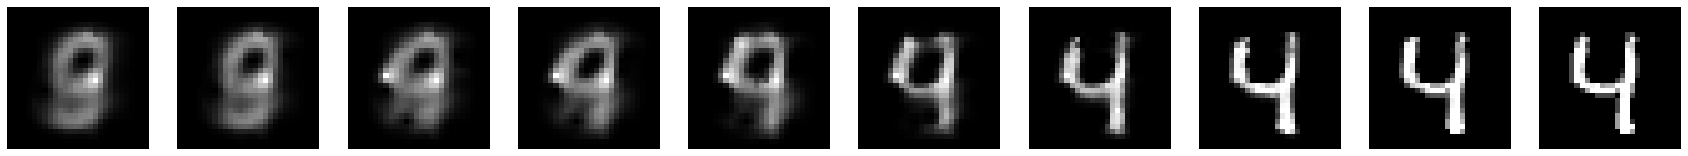

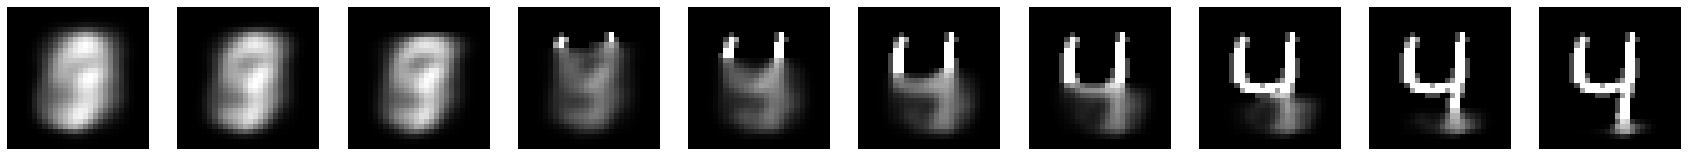

Step 42111, Loss (last minibatch): 0.14303436875343323, Loss (500 step avg.): 0.20246439773641423


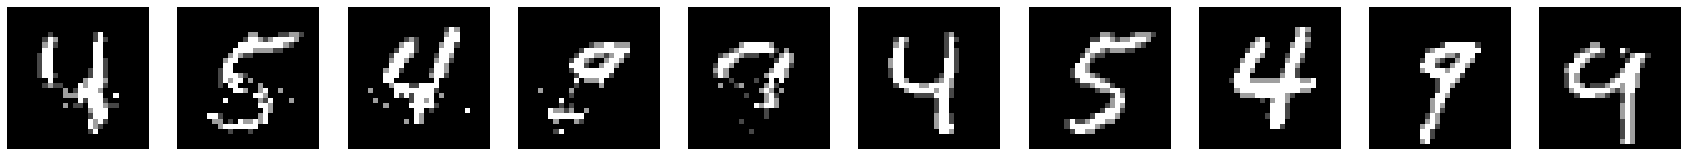

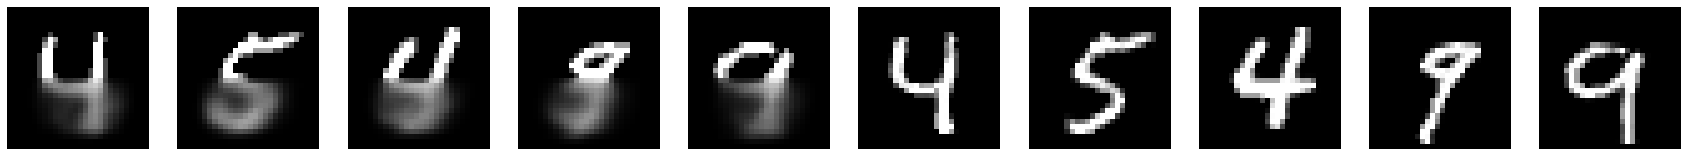

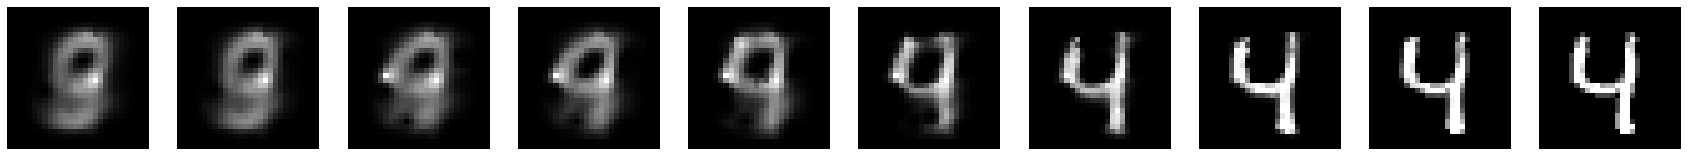

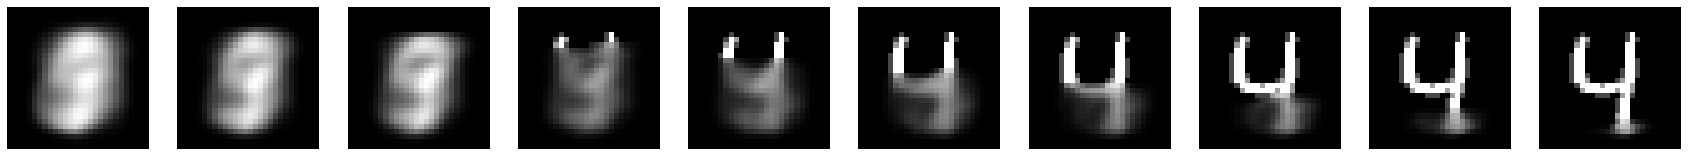

Step 43111, Loss (last minibatch): 0.2042829692363739, Loss (500 step avg.): 0.19609630742889203


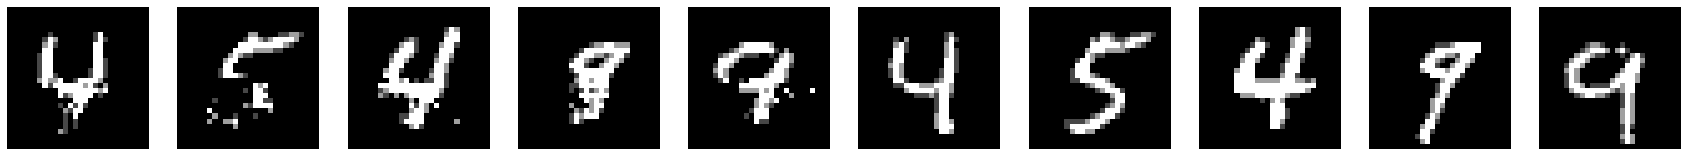

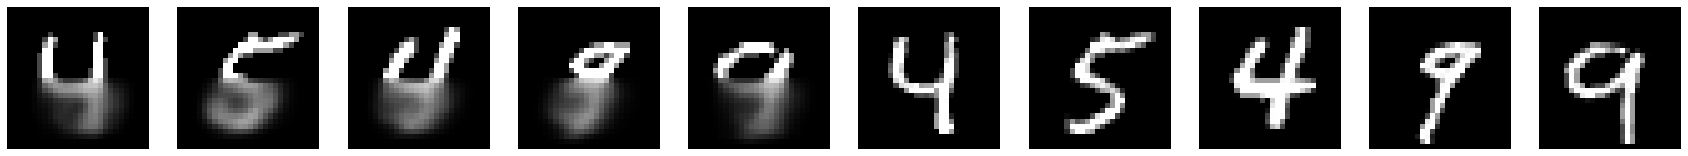

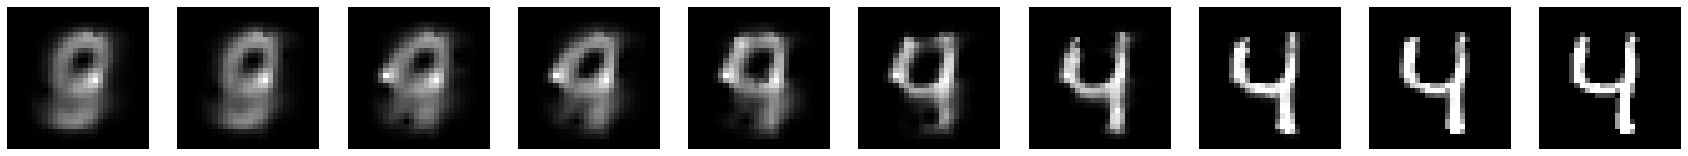

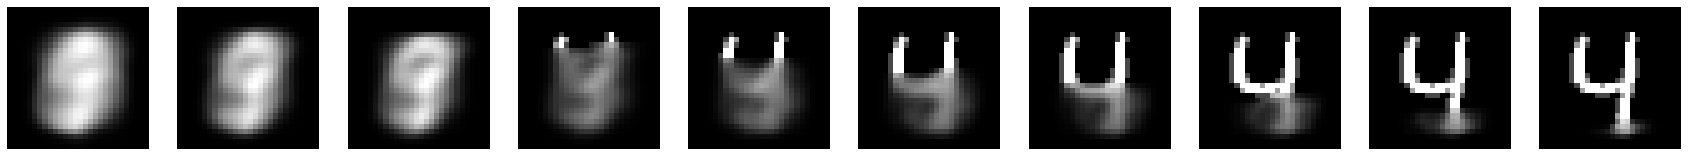

Step 44111, Loss (last minibatch): 0.18953382968902588, Loss (500 step avg.): 0.1996053821015025


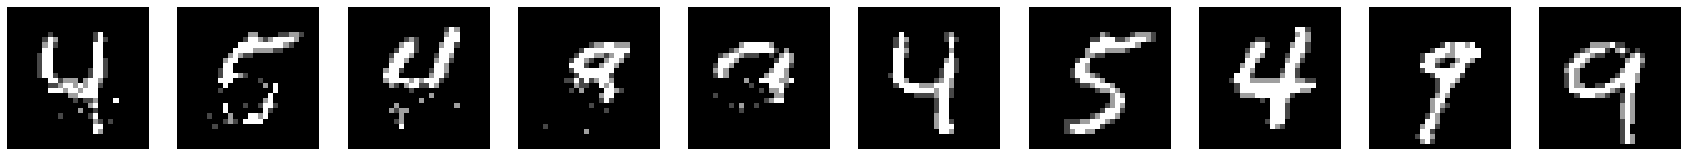

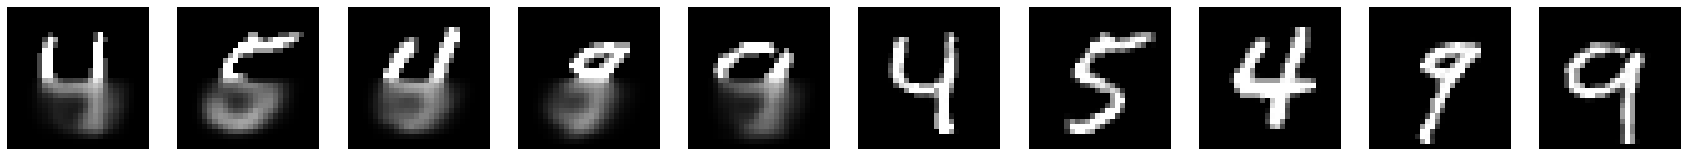

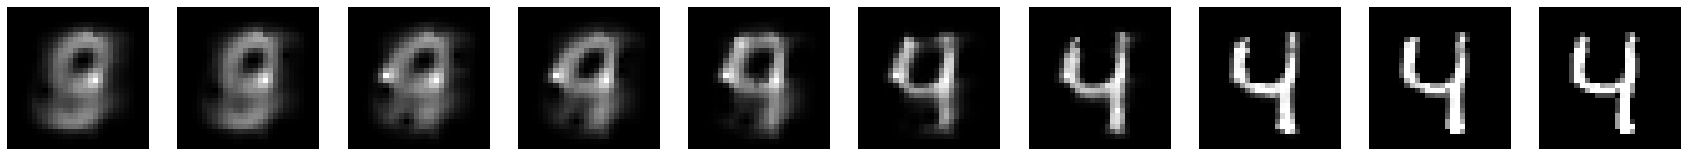

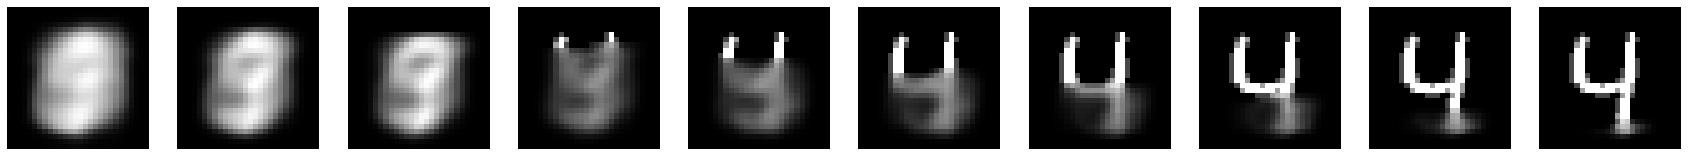

Step 45111, Loss (last minibatch): 0.14675161242485046, Loss (500 step avg.): 0.19623897902801365


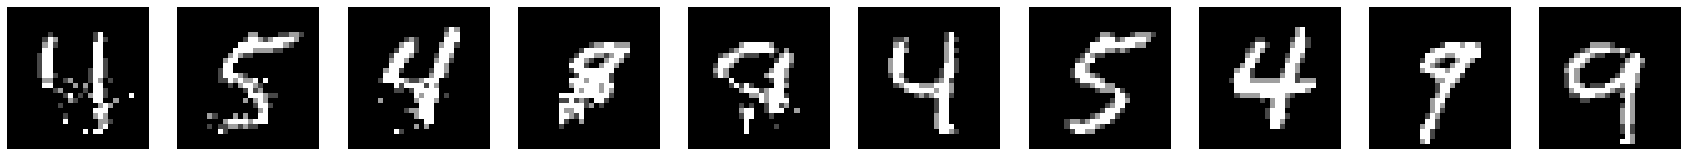

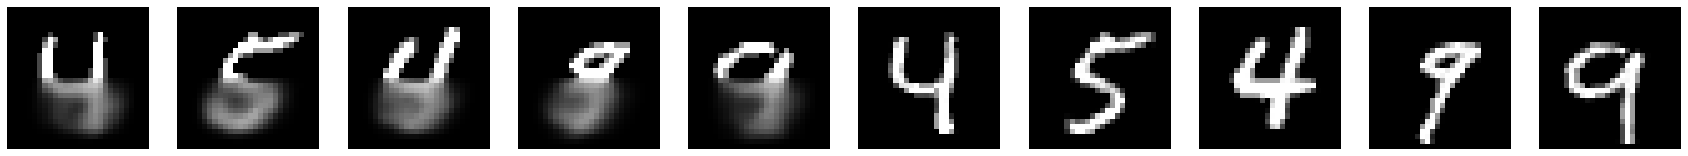

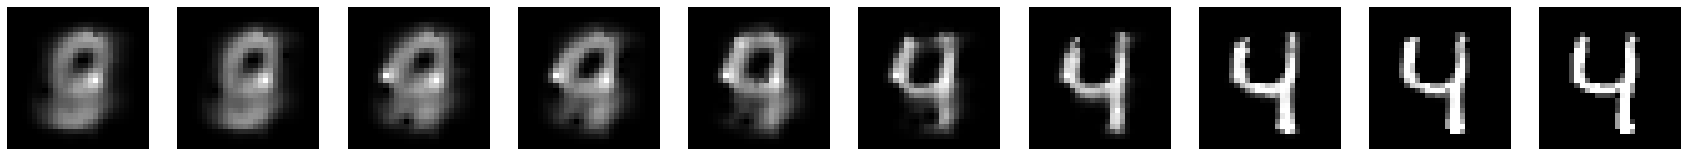

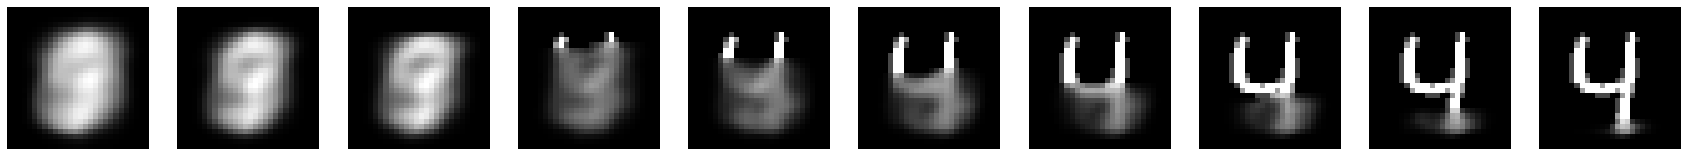

Step 46111, Loss (last minibatch): 0.21036851406097412, Loss (500 step avg.): 0.20055465467140346


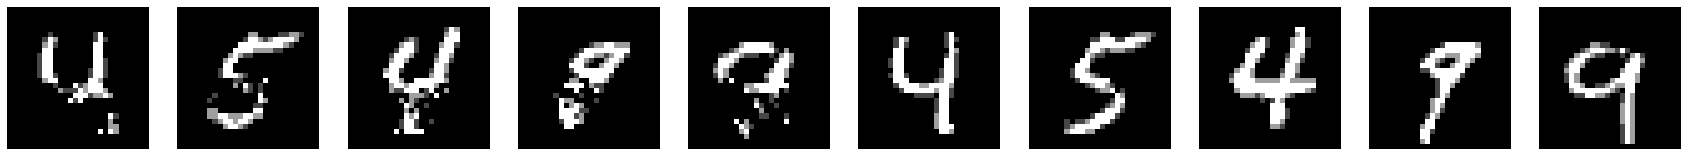

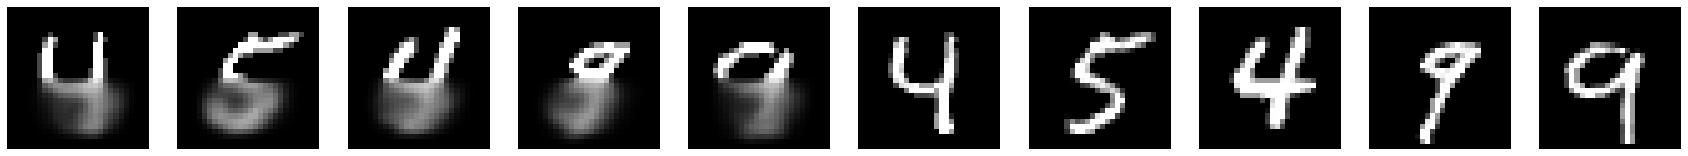

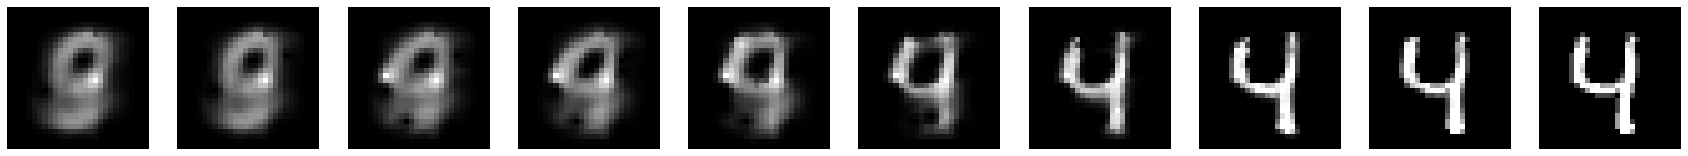

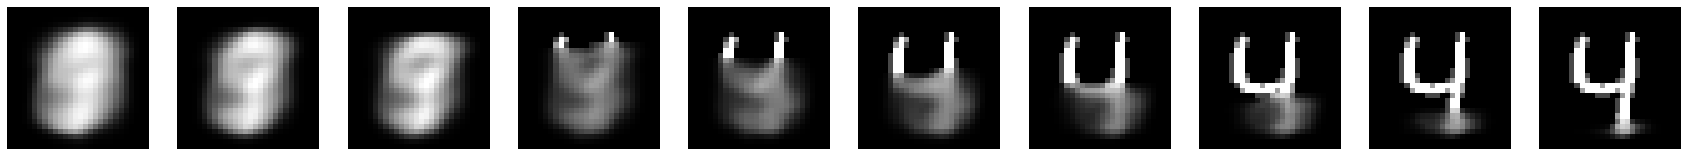

Step 47111, Loss (last minibatch): 0.20496785640716553, Loss (500 step avg.): 0.19248725302859457


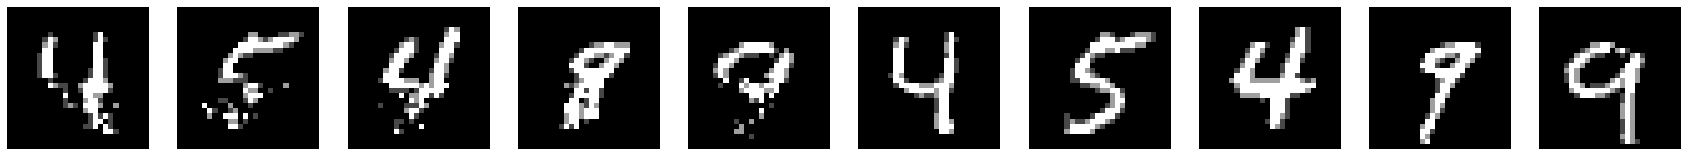

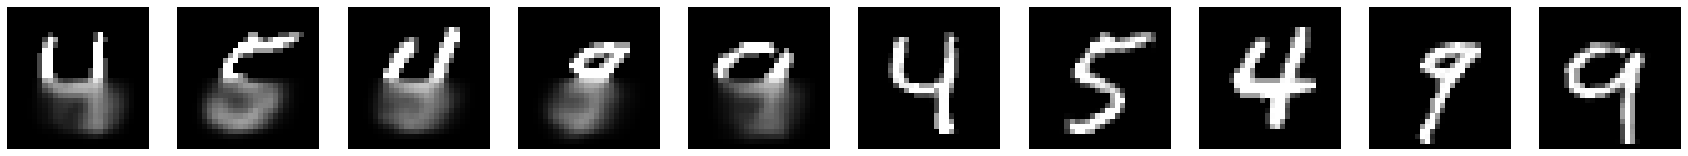

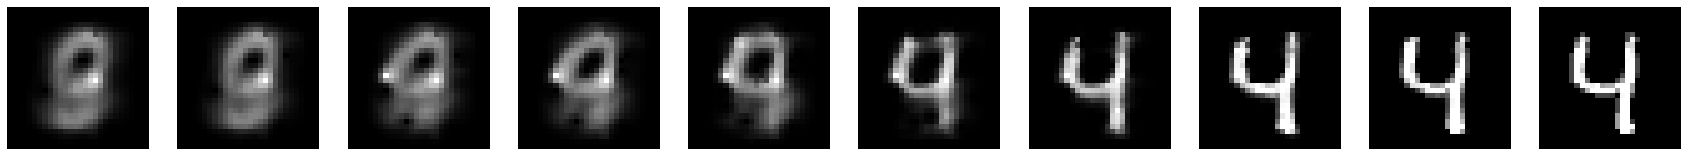

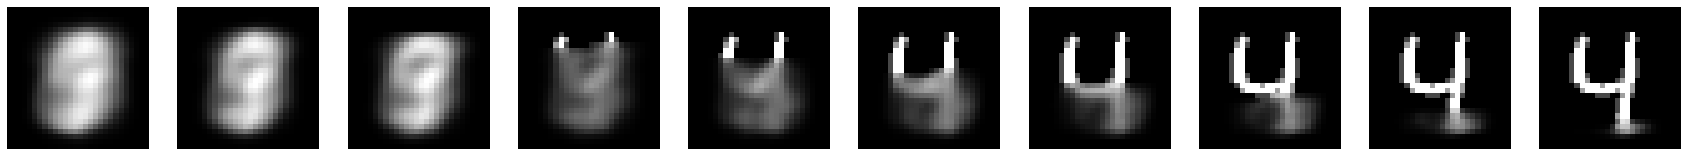

Step 48111, Loss (last minibatch): 0.14236024022102356, Loss (500 step avg.): 0.19349616956330107


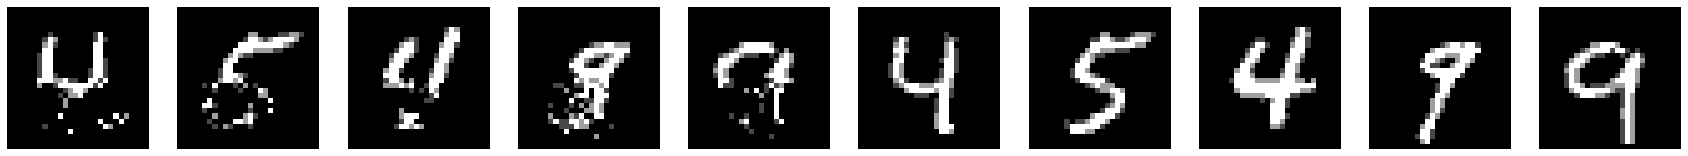

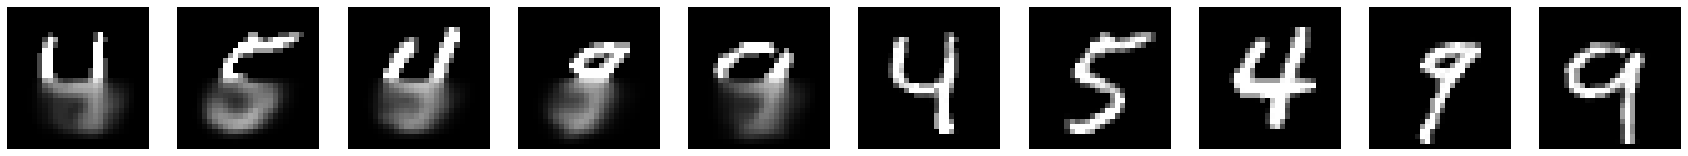

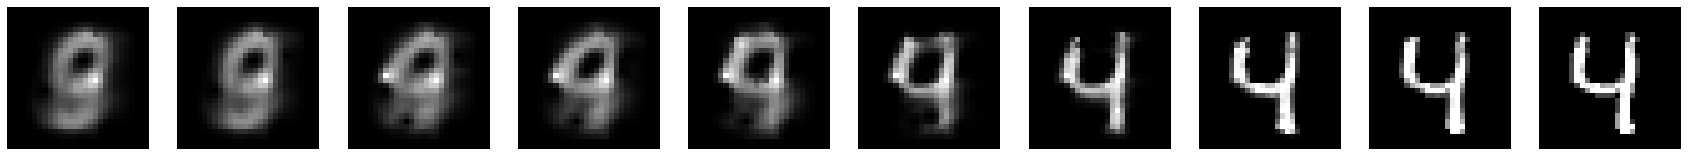

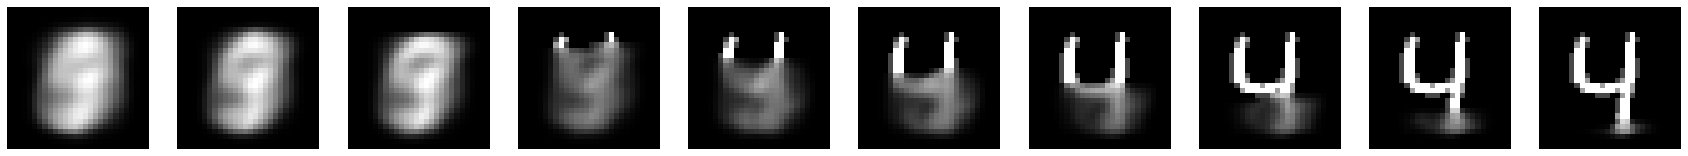

Step 49111, Loss (last minibatch): 0.18559333682060242, Loss (500 step avg.): 0.1972387521388288


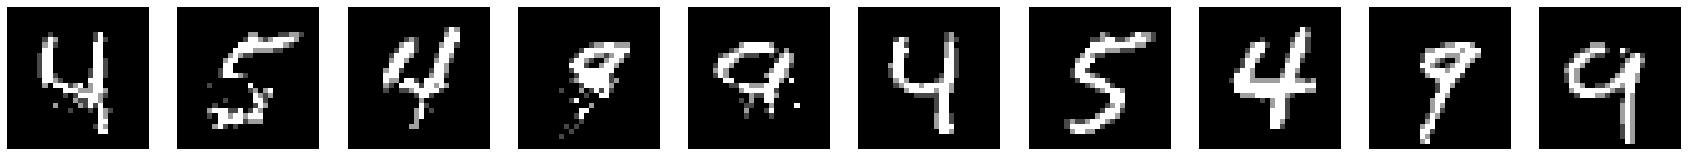

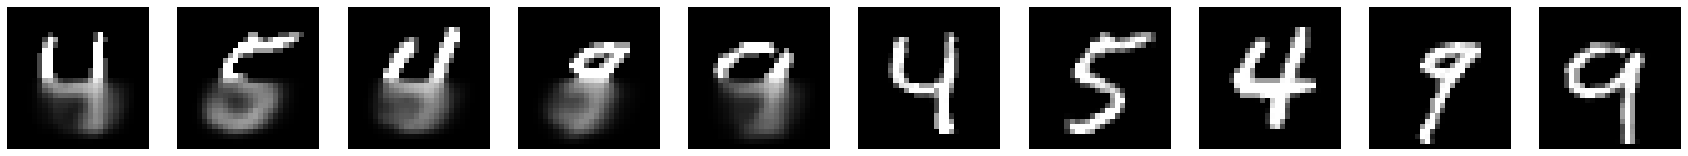

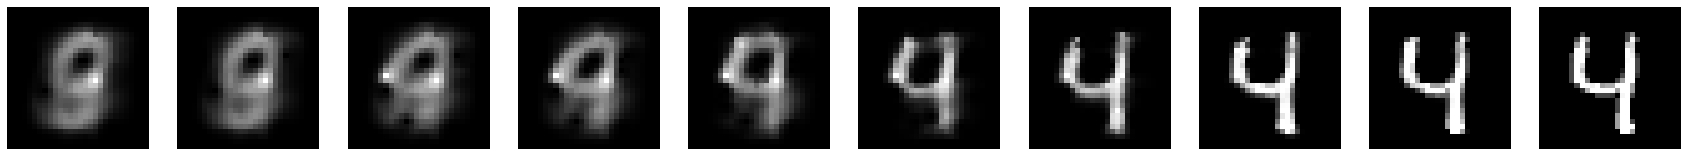

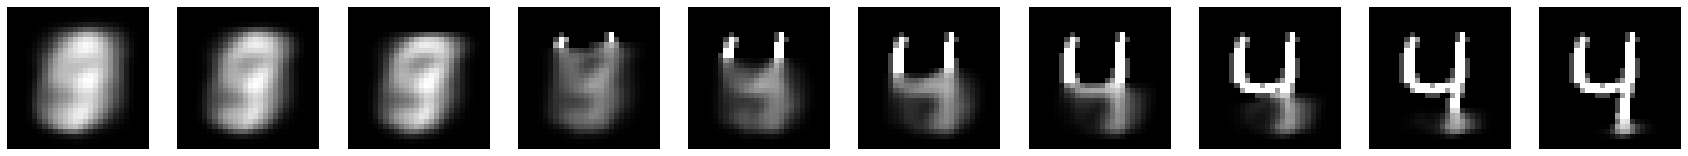

Step 50111, Loss (last minibatch): 0.28270506858825684, Loss (500 step avg.): 0.19479612039472766


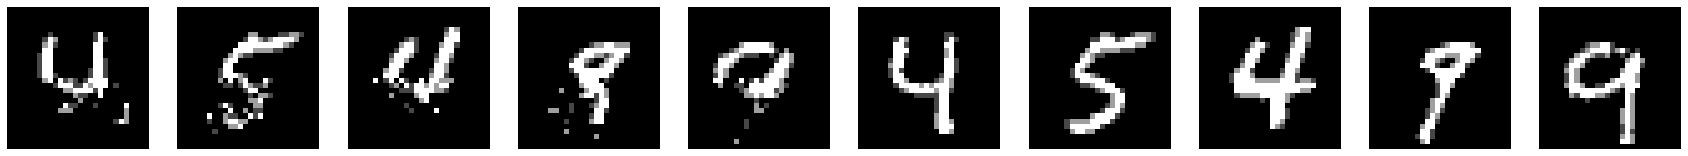

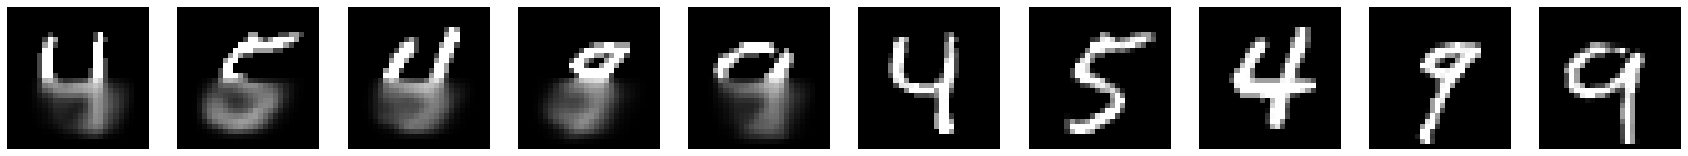

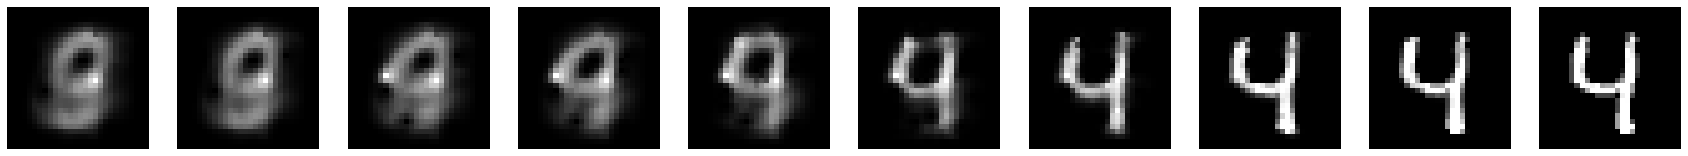

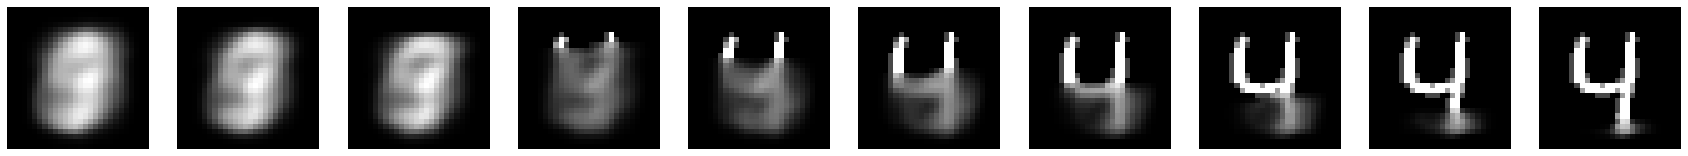

Step 51111, Loss (last minibatch): 0.23523855209350586, Loss (500 step avg.): 0.19377079296730712


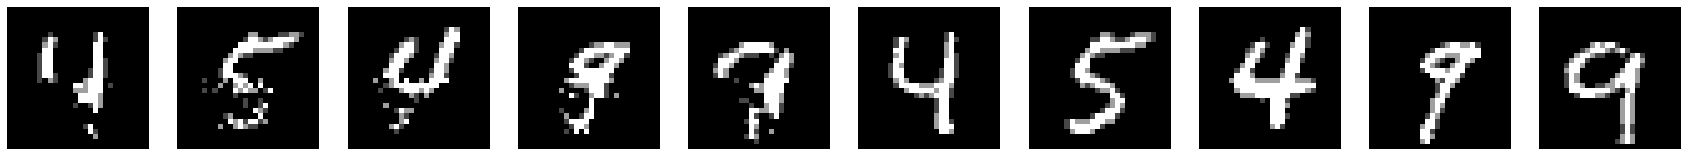

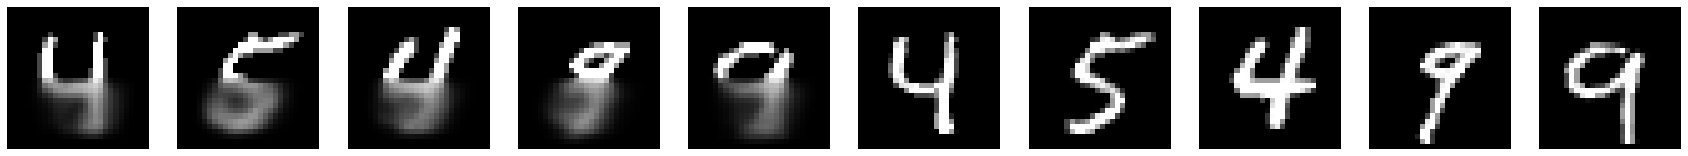

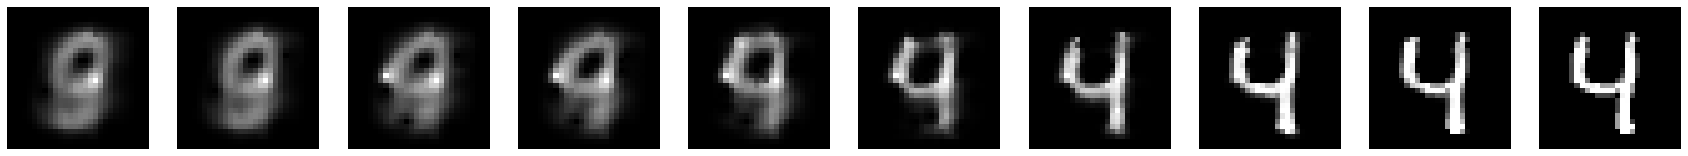

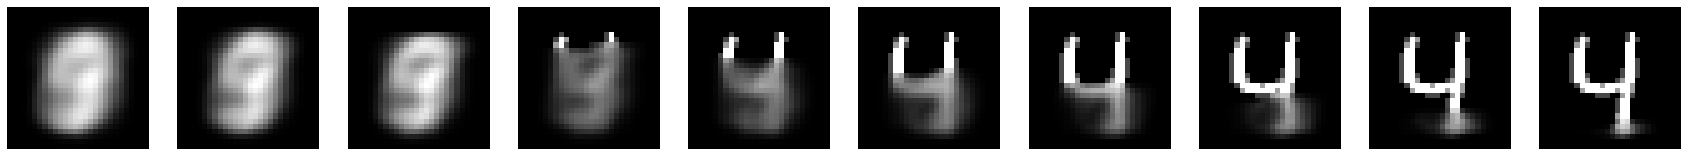

Step 52111, Loss (last minibatch): 0.21006213128566742, Loss (500 step avg.): 0.19320298543947187


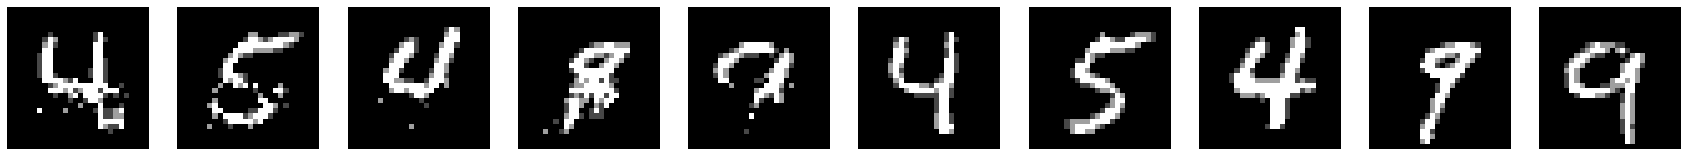

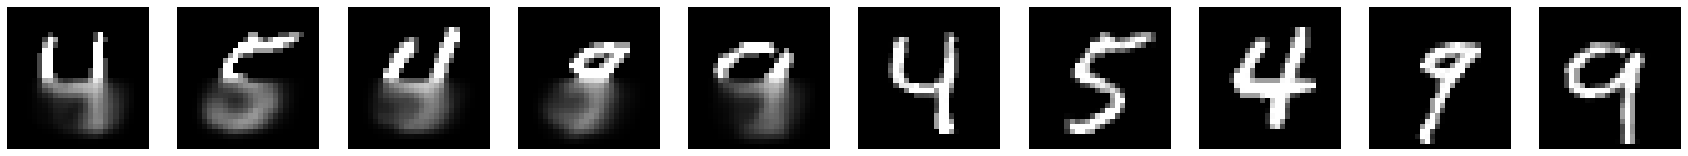

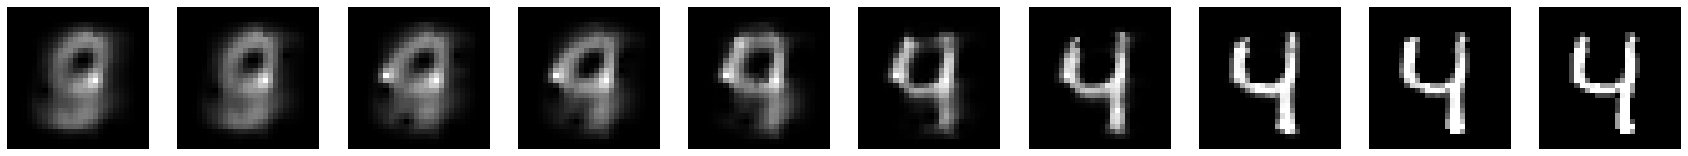

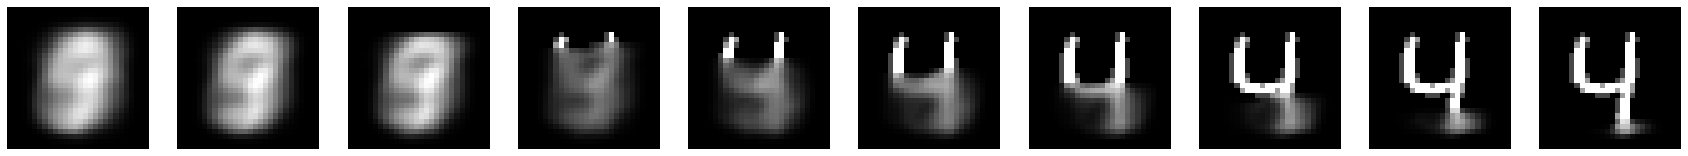

Step 53111, Loss (last minibatch): 0.1890650987625122, Loss (500 step avg.): 0.1955100819319784


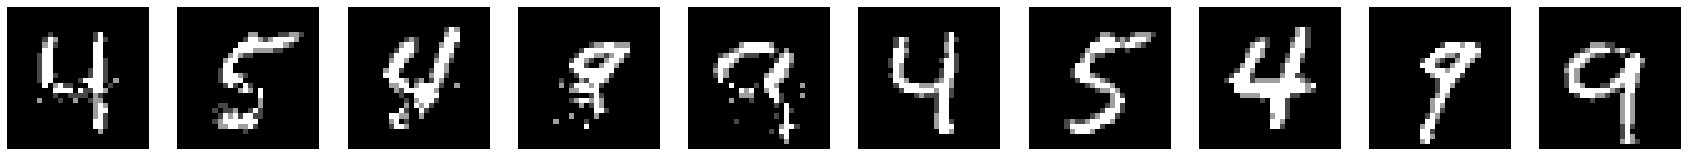

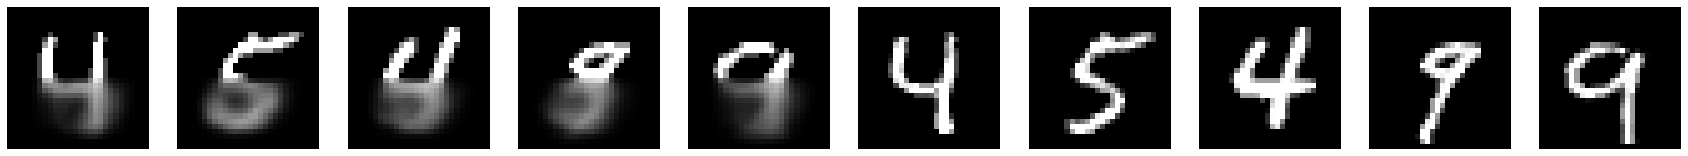

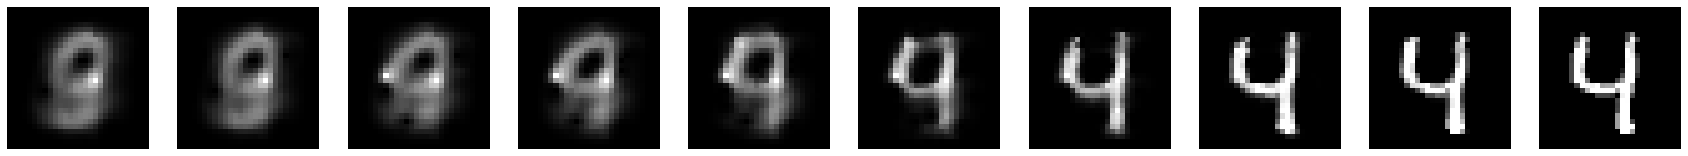

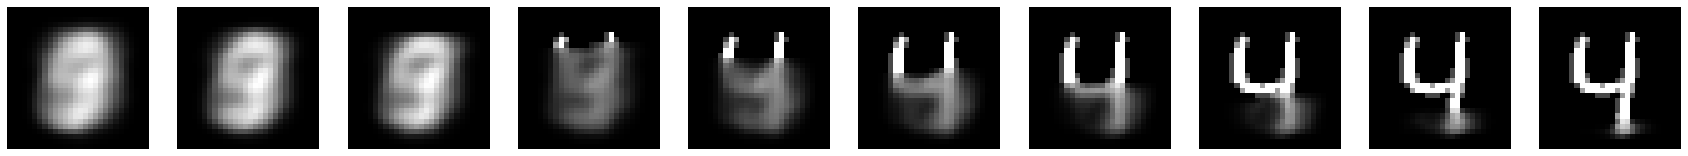

Step 54111, Loss (last minibatch): 0.2223268449306488, Loss (500 step avg.): 0.19465827758976084


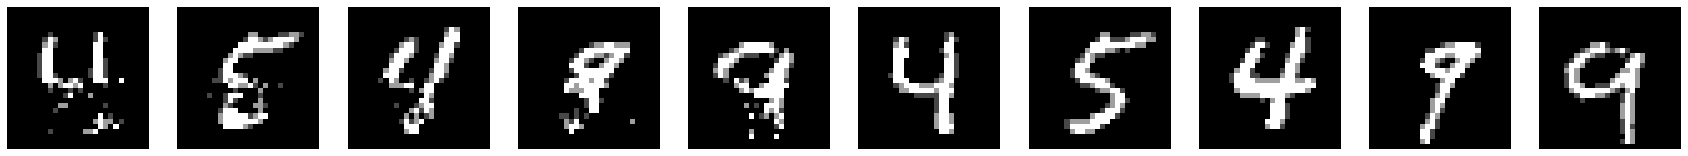

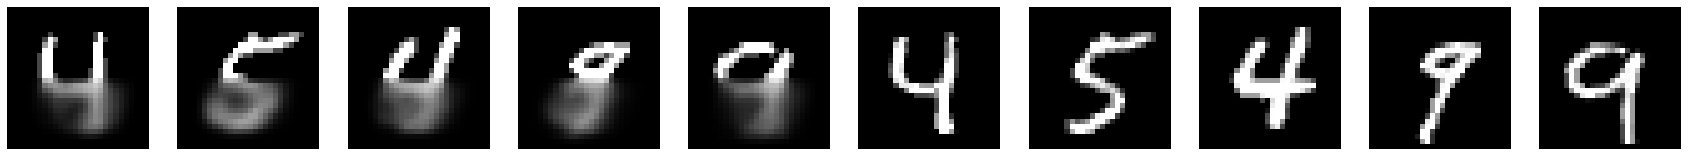

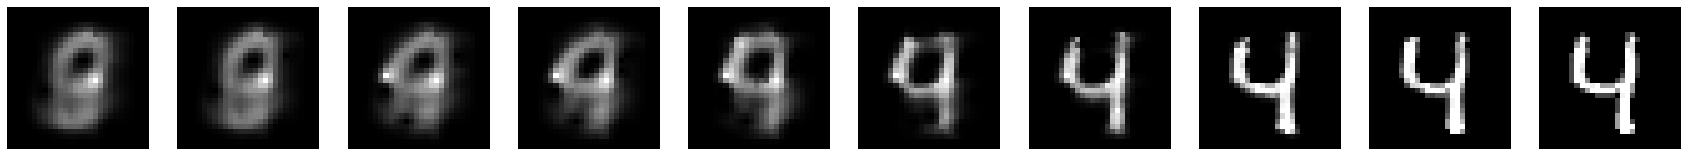

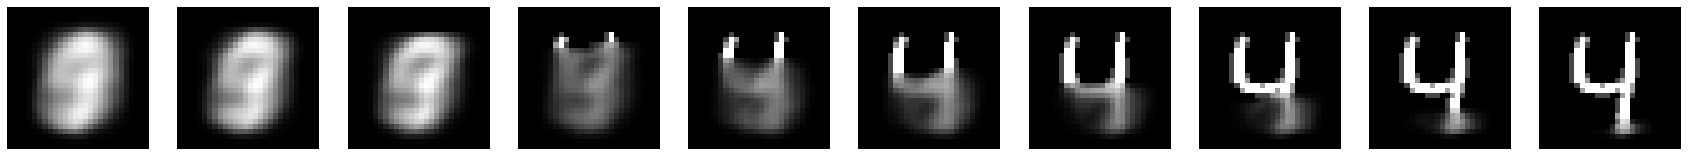

Step 55111, Loss (last minibatch): 0.2753832936286926, Loss (500 step avg.): 0.19565831932300579


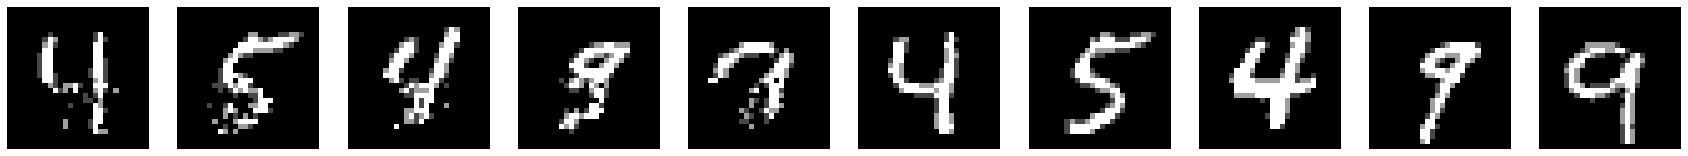

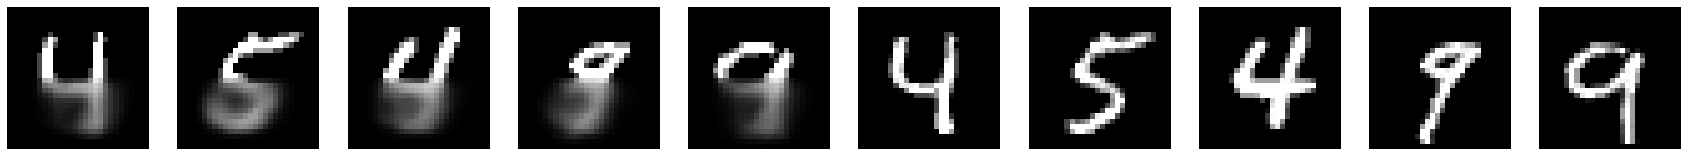

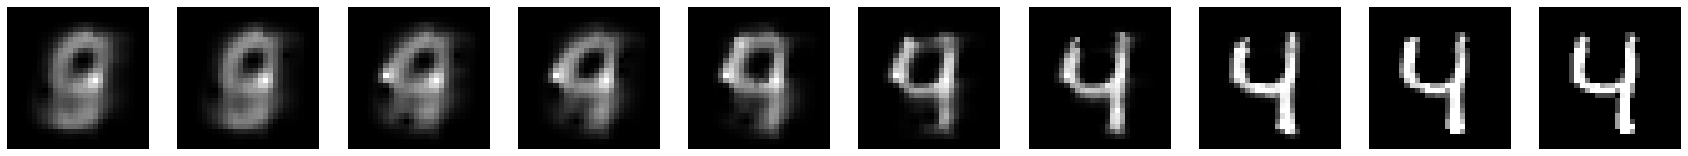

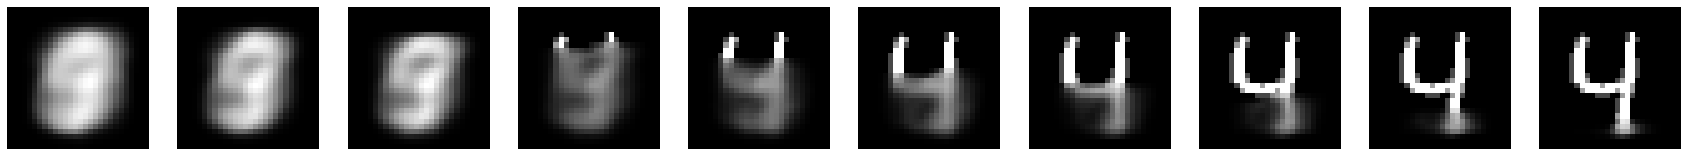

Step 56111, Loss (last minibatch): 0.19120627641677856, Loss (500 step avg.): 0.192114882810625


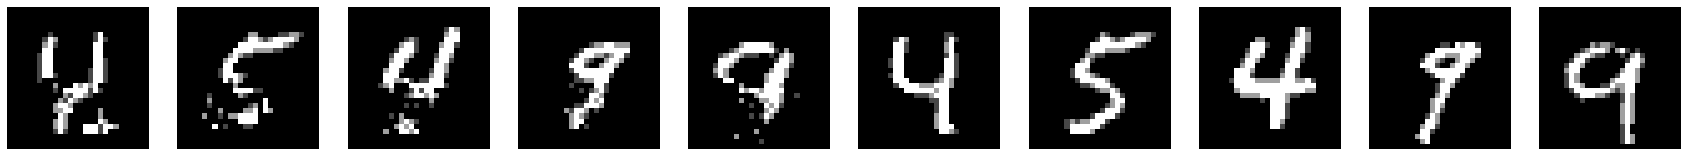

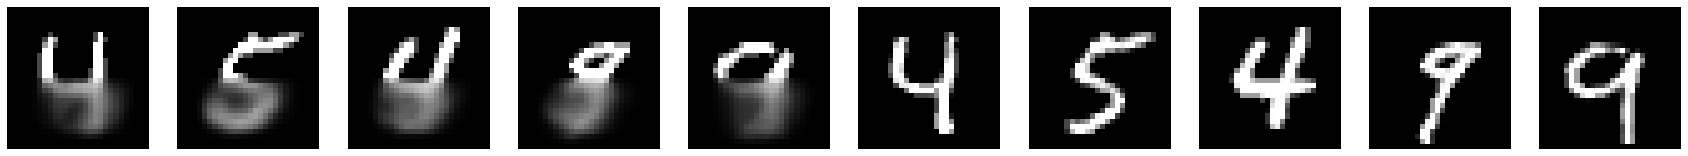

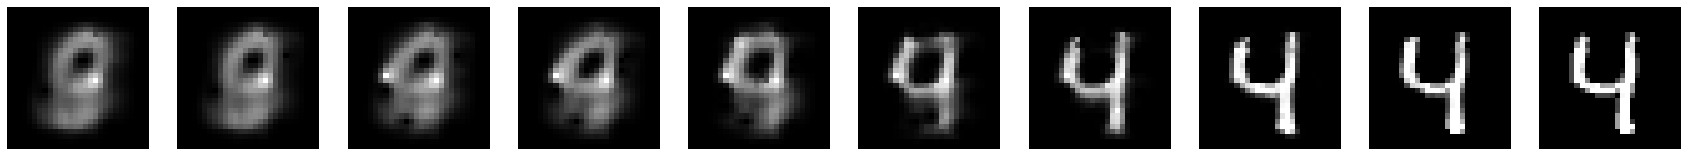

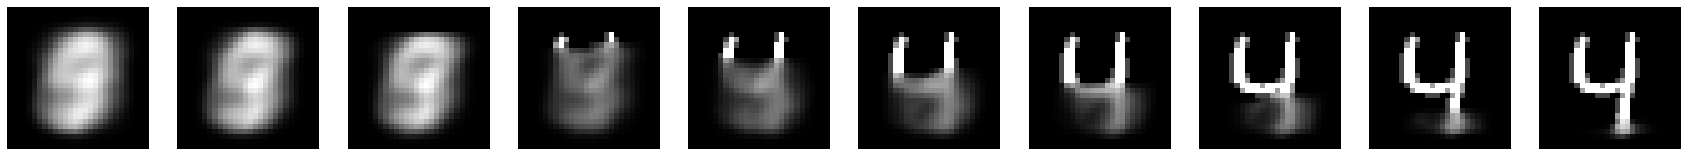

Step 57111, Loss (last minibatch): 0.15304218232631683, Loss (500 step avg.): 0.19314799683834027


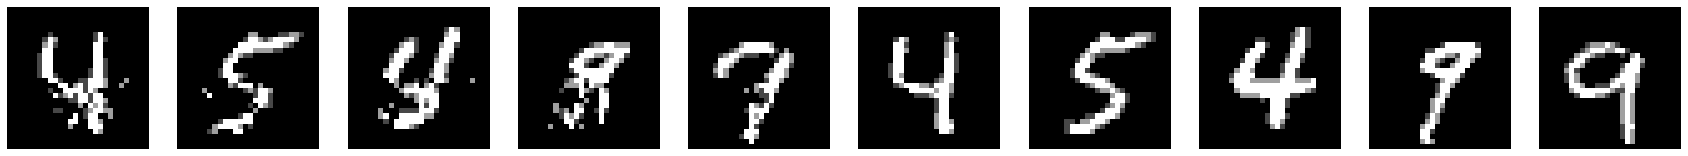

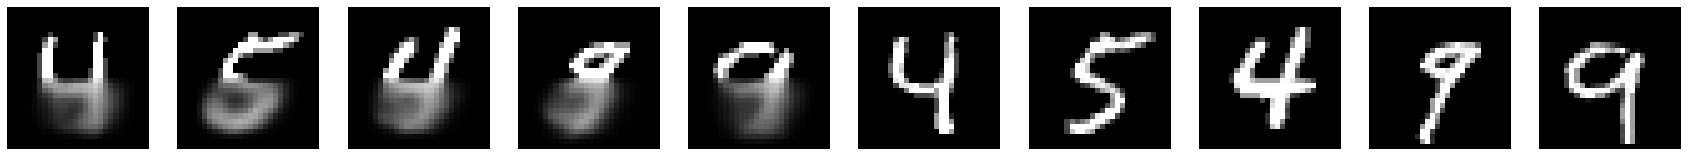

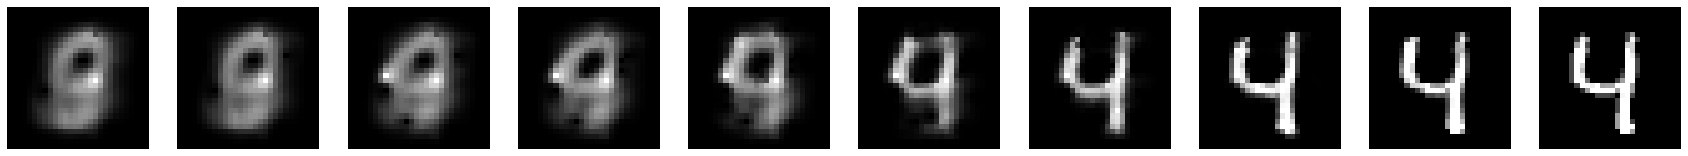

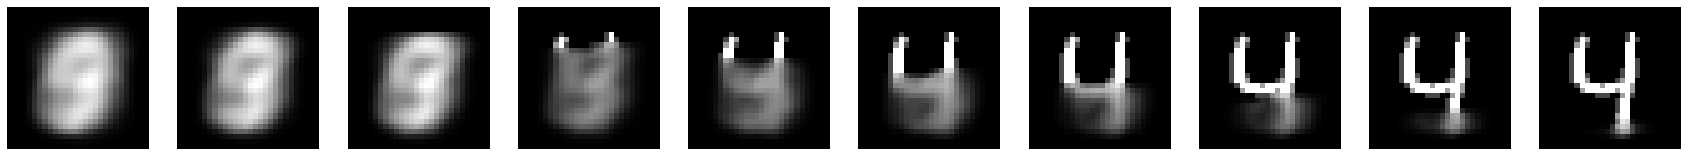

Step 58111, Loss (last minibatch): 0.22282475233078003, Loss (500 step avg.): 0.19068239699164313


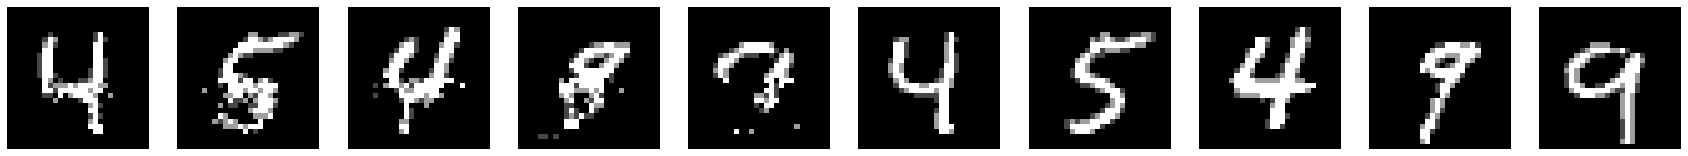

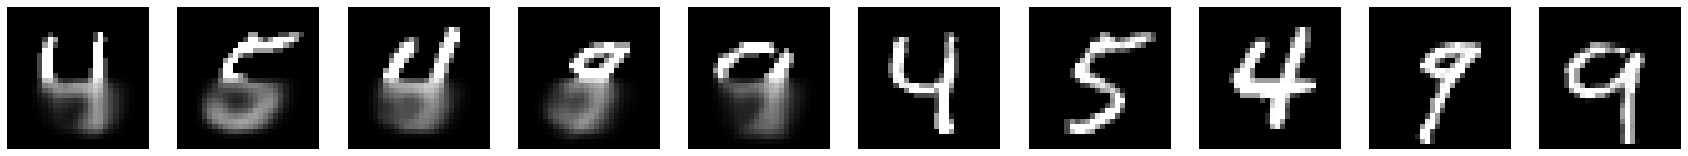

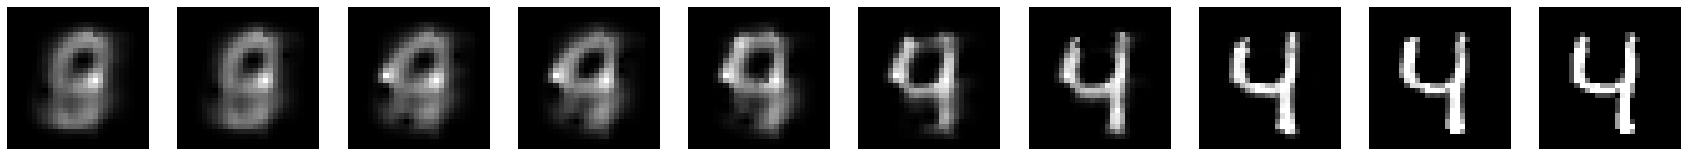

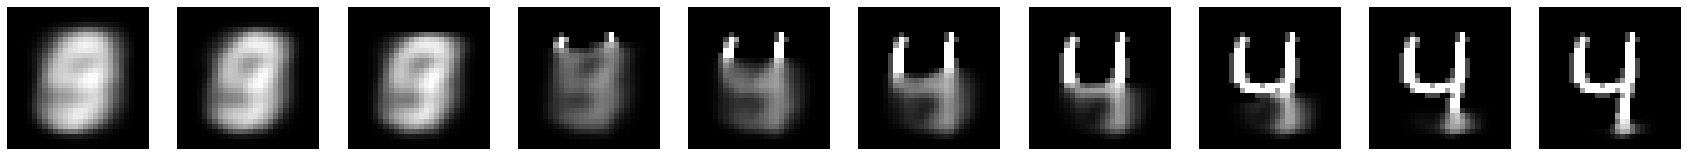

Step 59111, Loss (last minibatch): 0.1357325166463852, Loss (500 step avg.): 0.1913449495376465


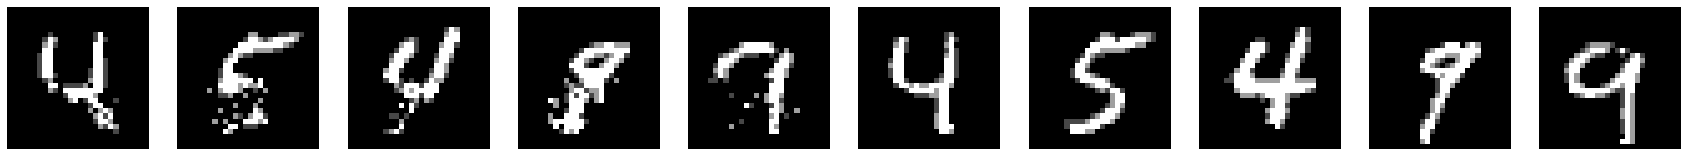

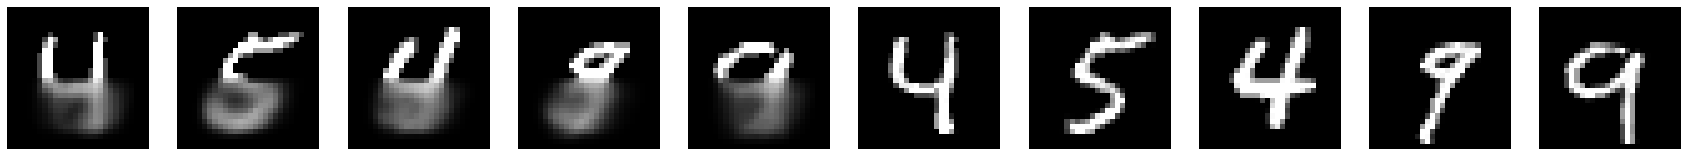

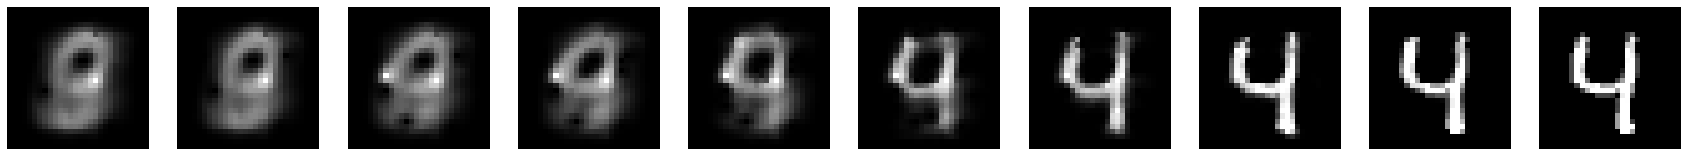

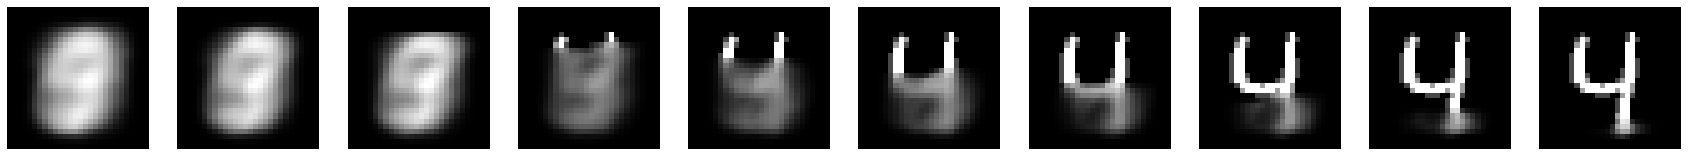

Step 60111, Loss (last minibatch): 0.20212161540985107, Loss (500 step avg.): 0.19458597052299573


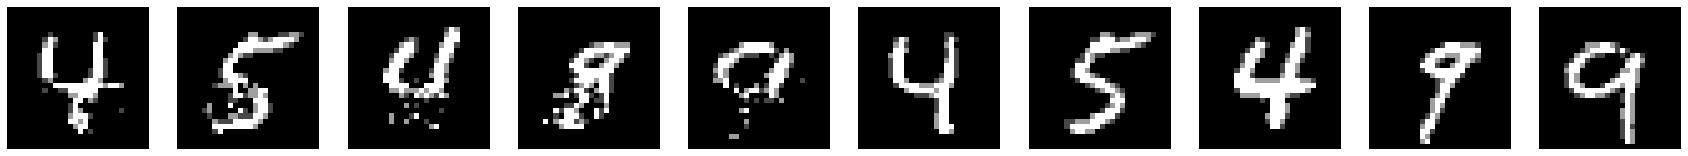

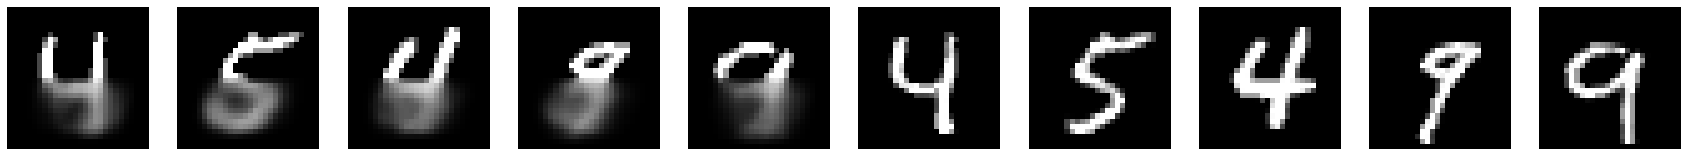

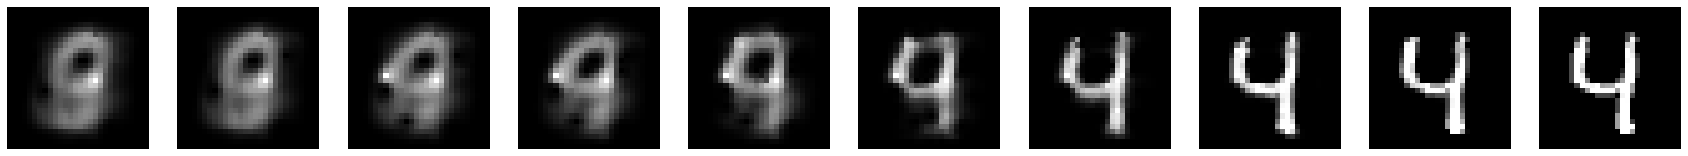

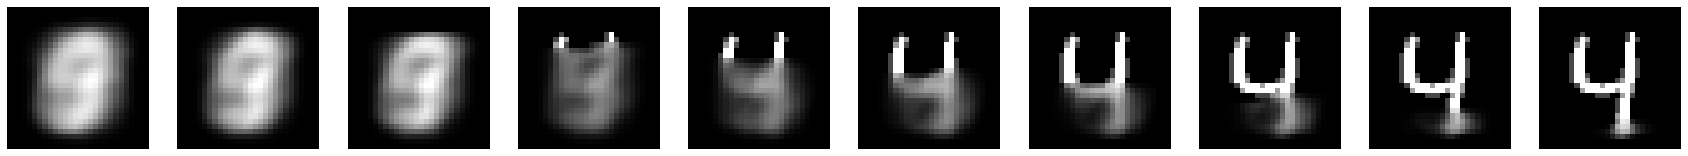

Step 61111, Loss (last minibatch): 0.2892041504383087, Loss (500 step avg.): 0.18898620391022897


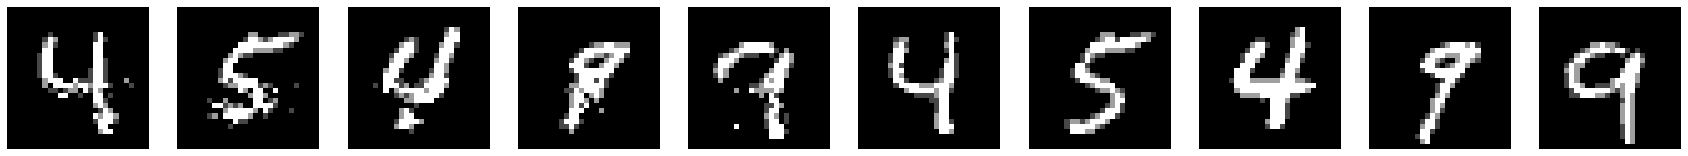

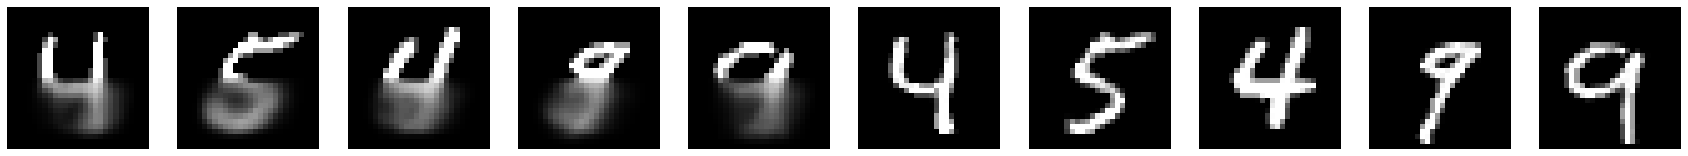

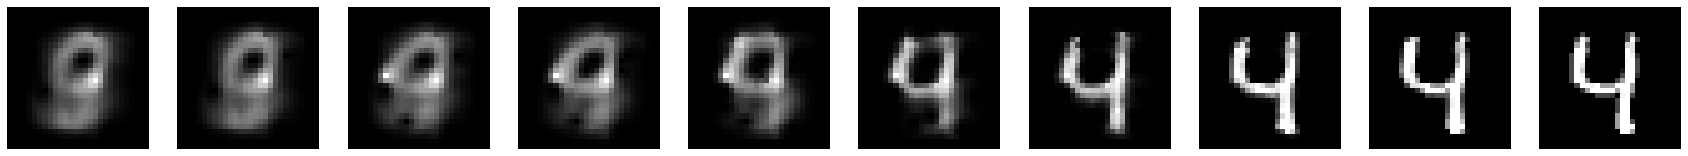

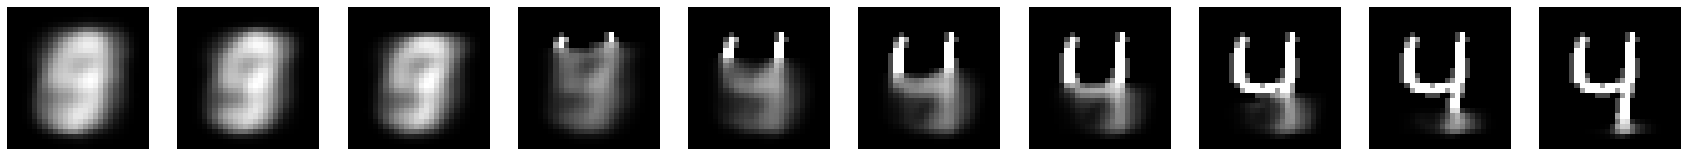

Step 62111, Loss (last minibatch): 0.2755827009677887, Loss (500 step avg.): 0.1900045923487155


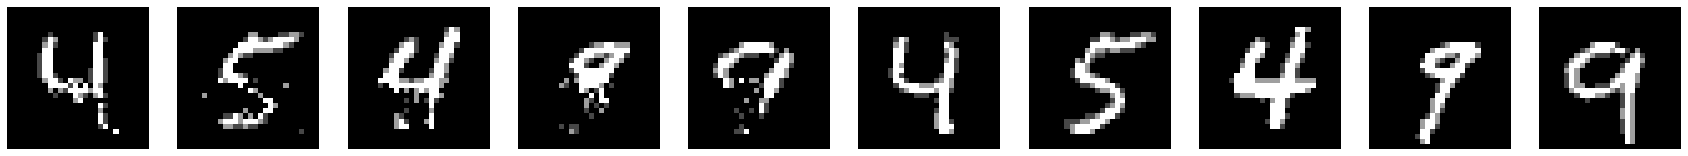

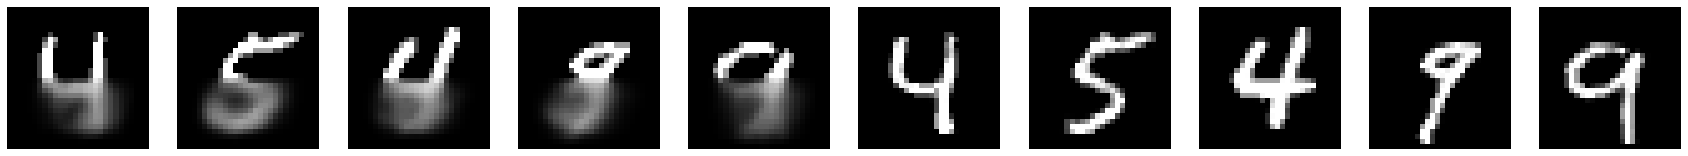

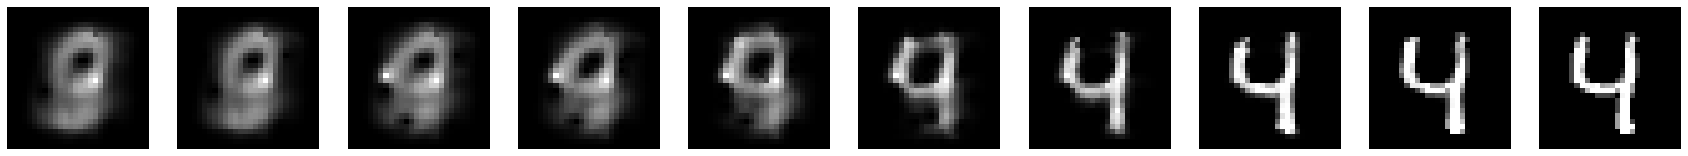

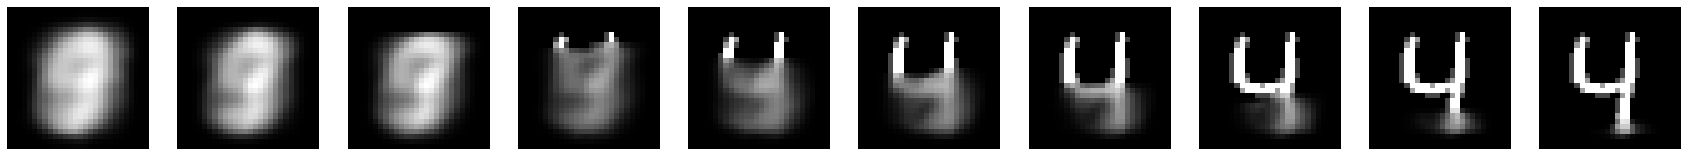

Step 63111, Loss (last minibatch): 0.15136945247650146, Loss (500 step avg.): 0.1879049279613647


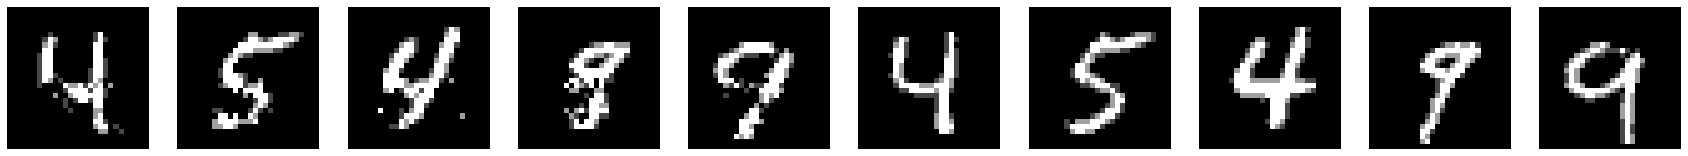

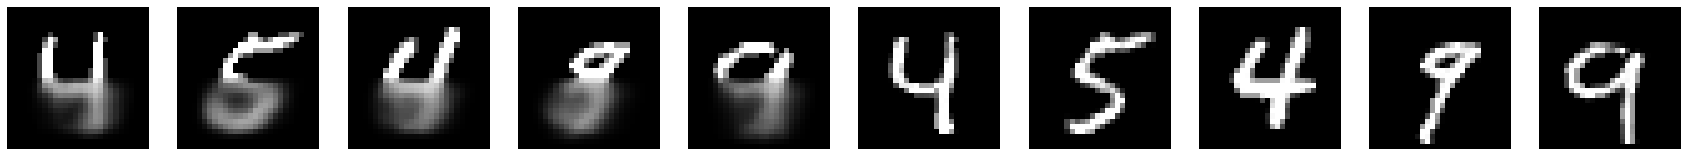

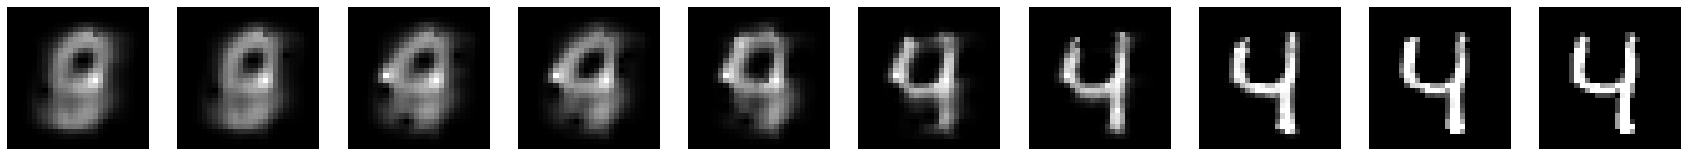

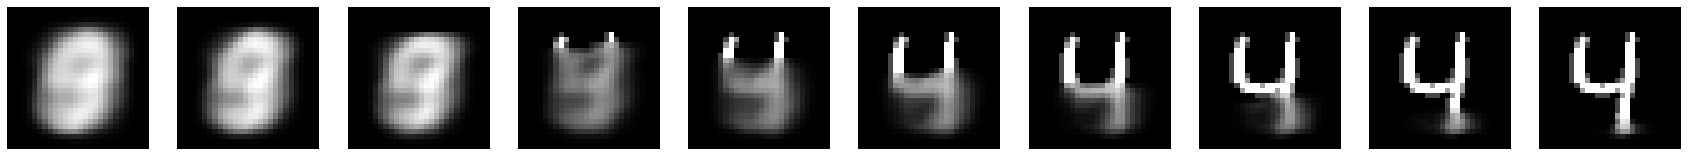

Step 64111, Loss (last minibatch): 0.20203897356987, Loss (500 step avg.): 0.18622891188500645


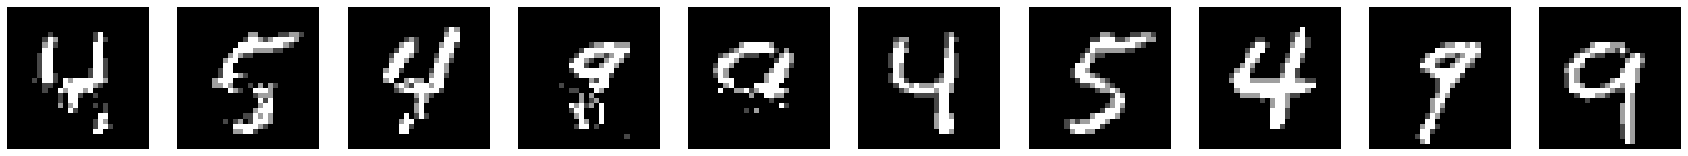

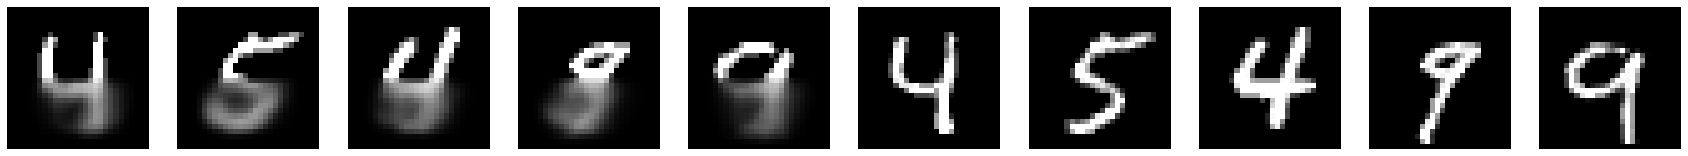

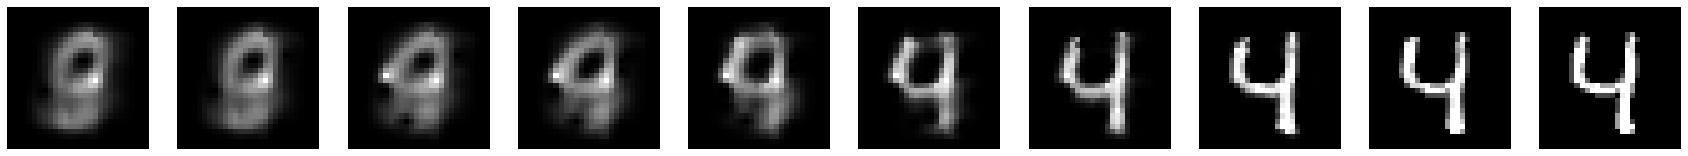

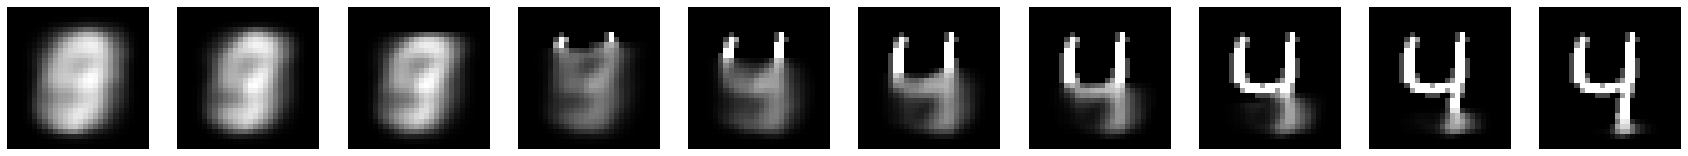

Step 65111, Loss (last minibatch): 0.22233819961547852, Loss (500 step avg.): 0.18739637055856262


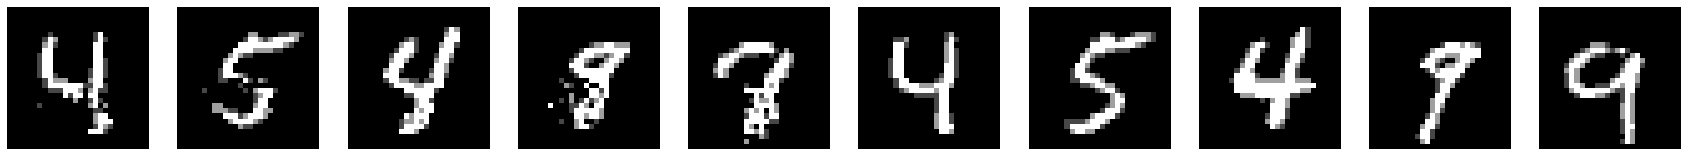

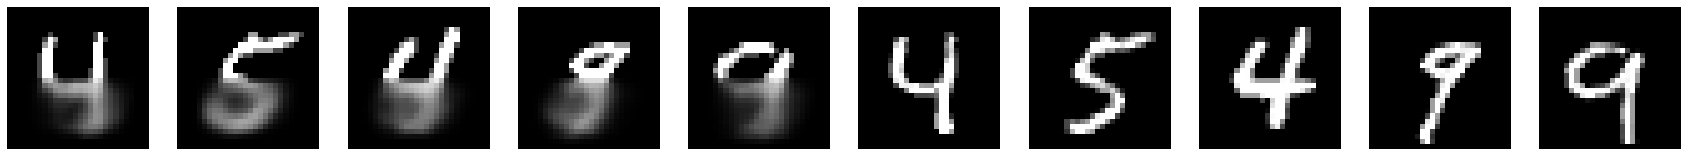

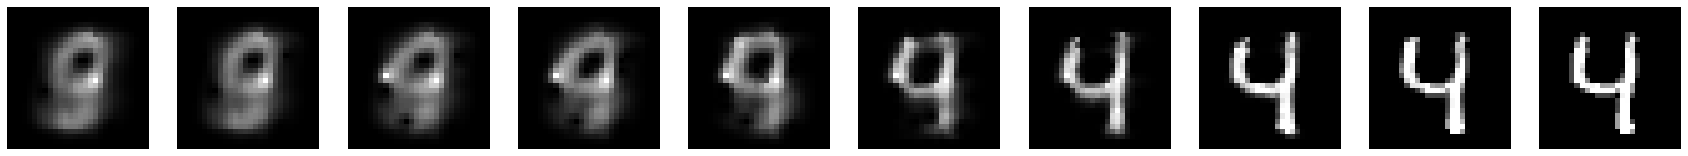

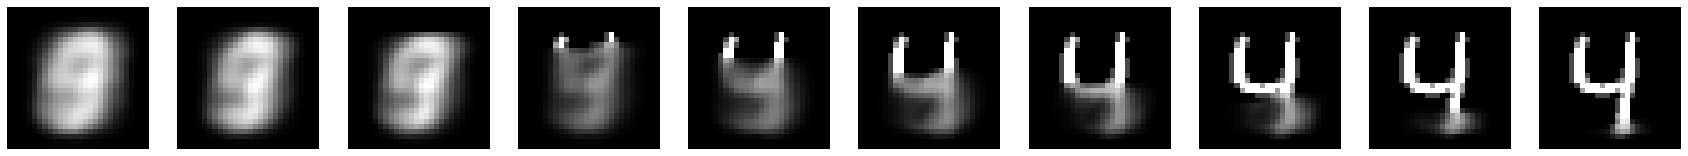

Step 66111, Loss (last minibatch): 0.22887885570526123, Loss (500 step avg.): 0.18692518511932052


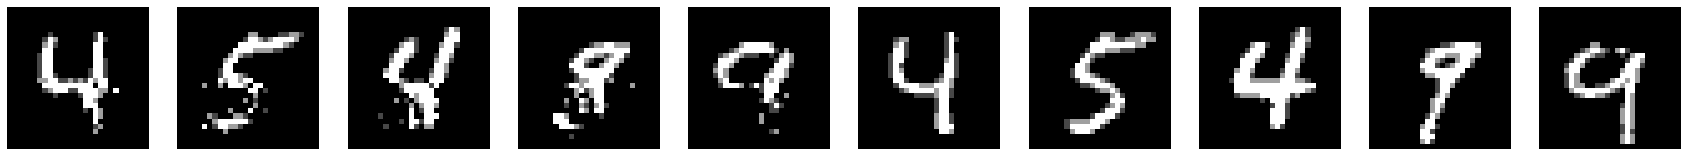

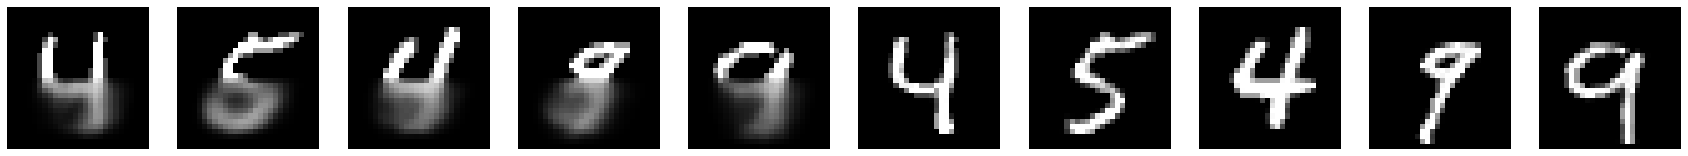

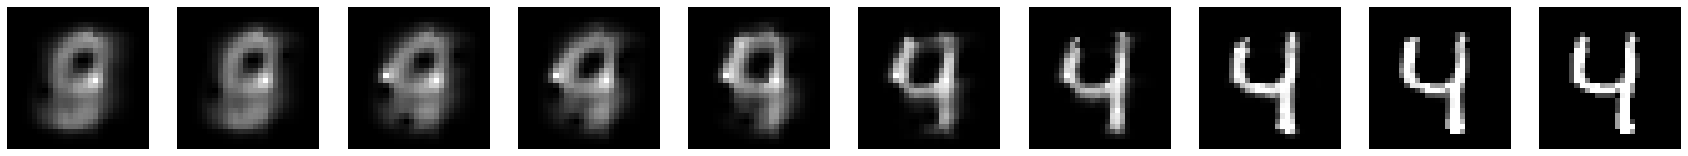

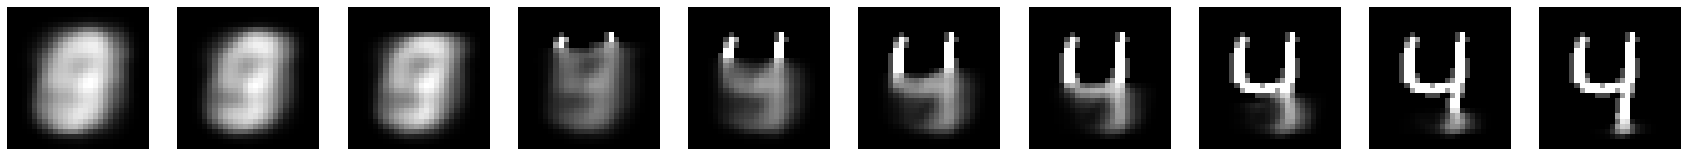

Step 67111, Loss (last minibatch): 0.27772295475006104, Loss (500 step avg.): 0.18841609397453224


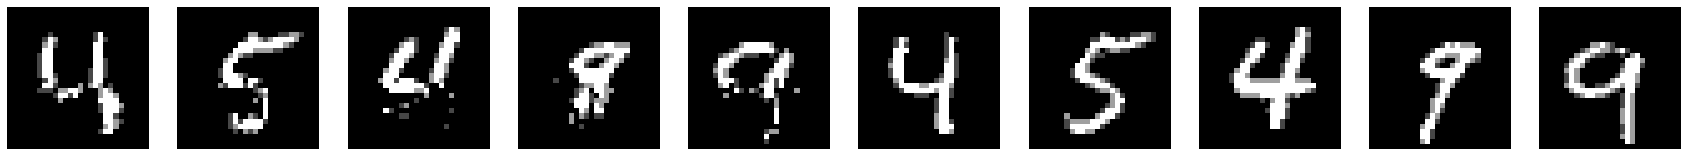

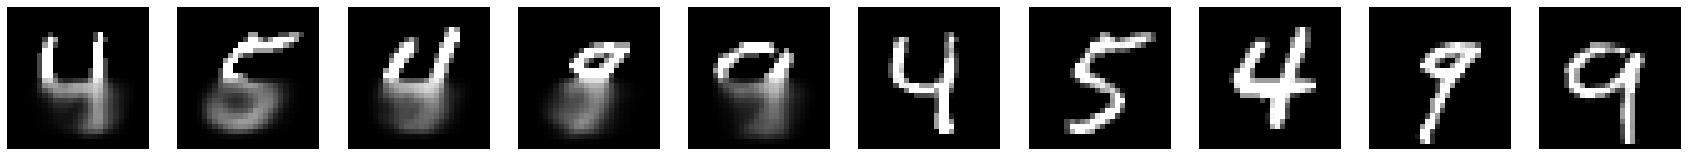

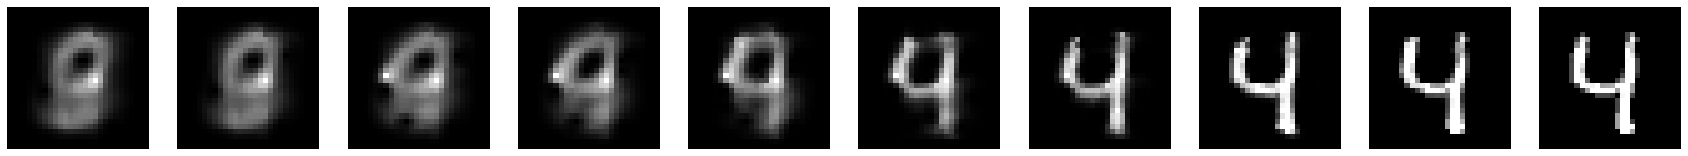

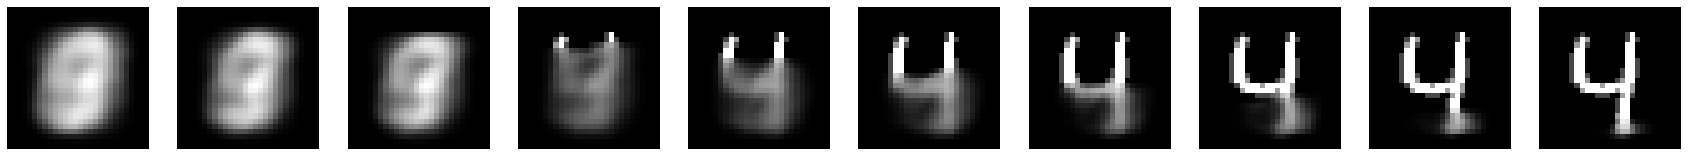

Step 68111, Loss (last minibatch): 0.19513492286205292, Loss (500 step avg.): 0.1865609206274122


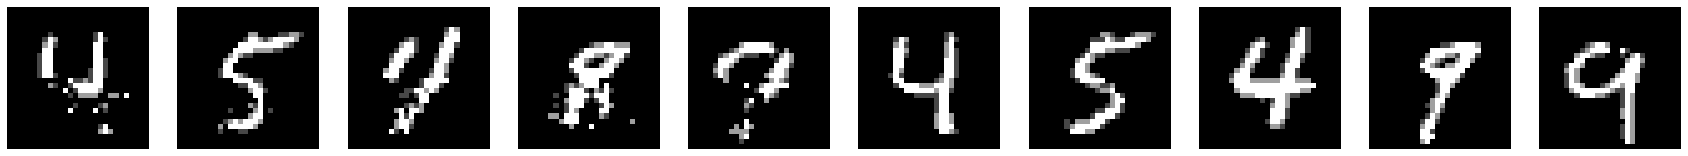

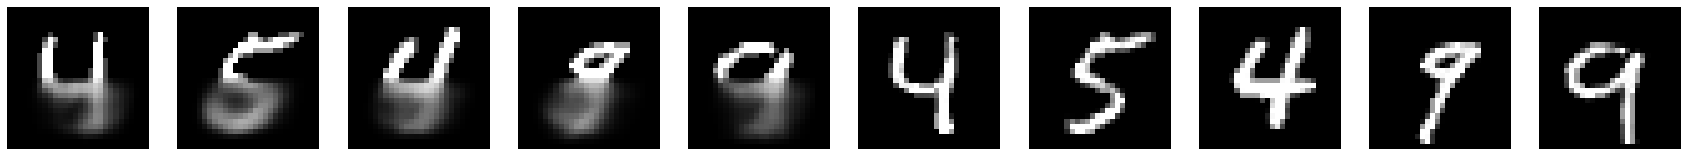

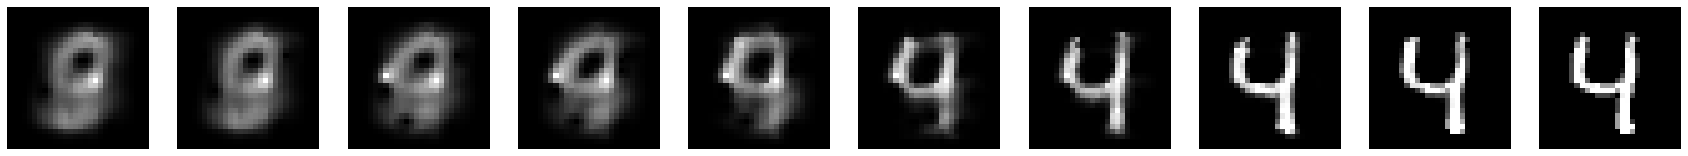

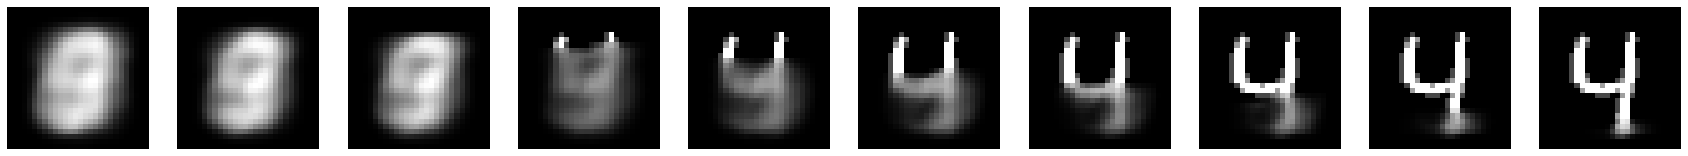

Step 69111, Loss (last minibatch): 0.1925859898328781, Loss (500 step avg.): 0.18608134162580658


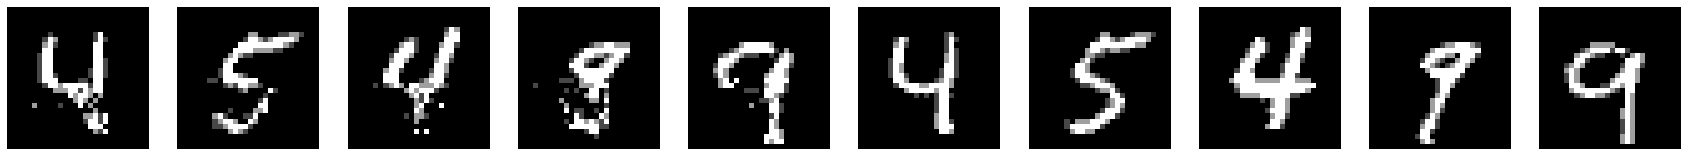

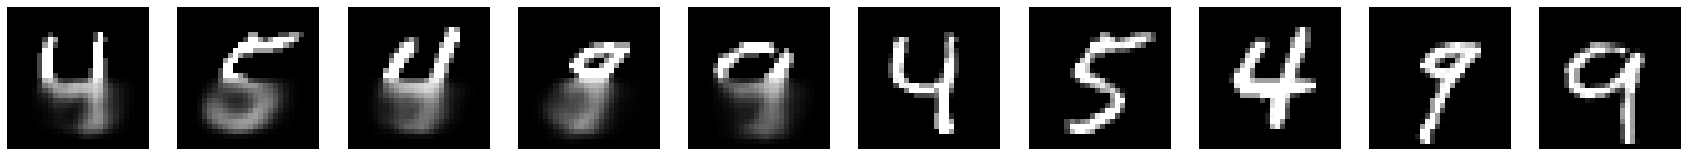

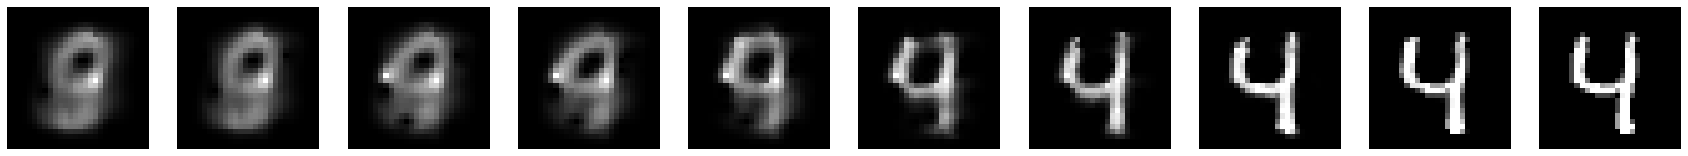

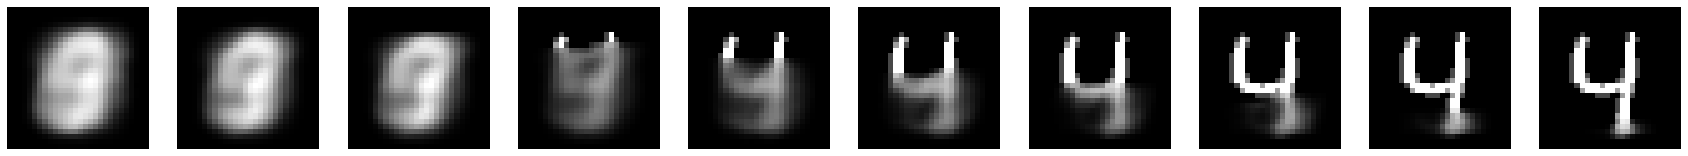

Step 70111, Loss (last minibatch): 0.1636747419834137, Loss (500 step avg.): 0.18554917288695028


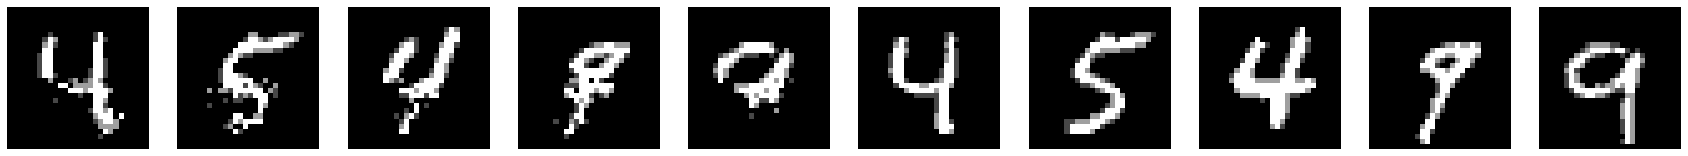

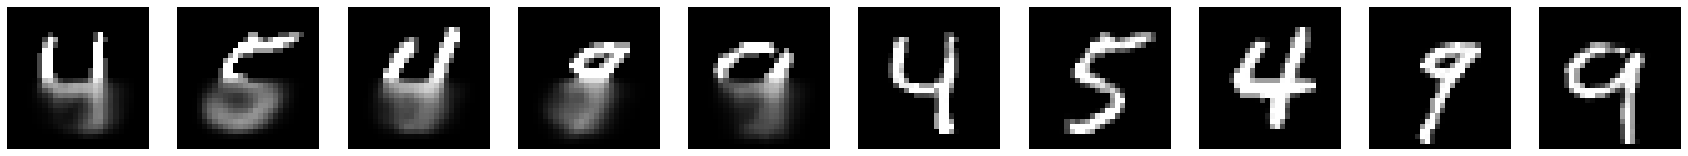

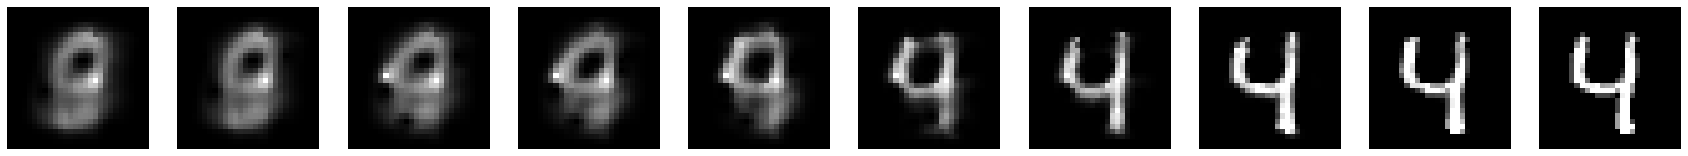

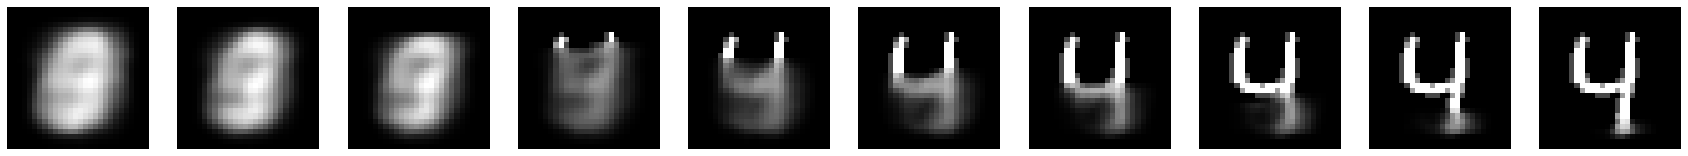

Step 71111, Loss (last minibatch): 0.1762019842863083, Loss (500 step avg.): 0.18775379275549908


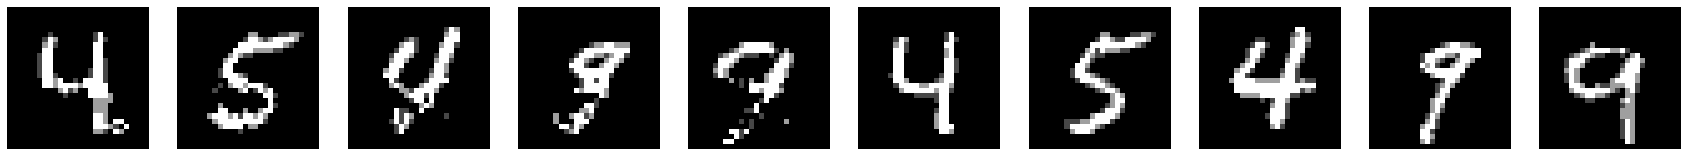

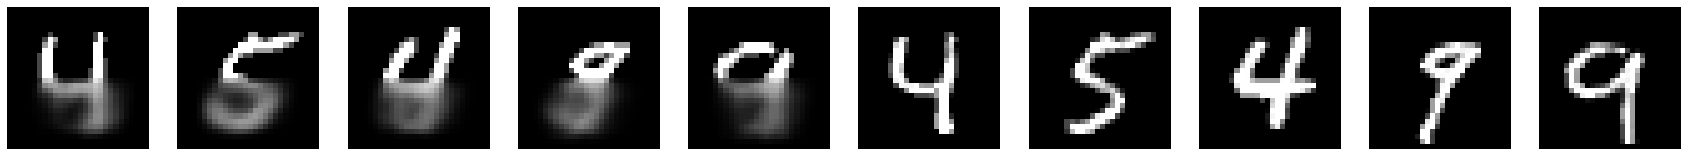

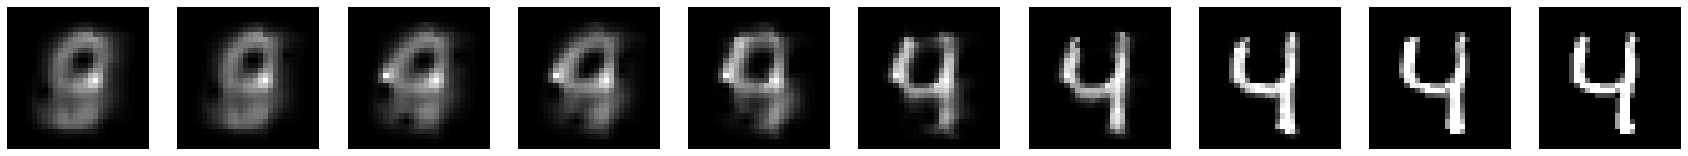

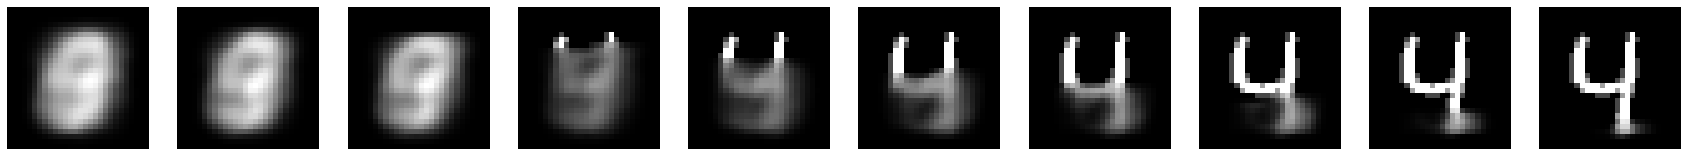

Step 72111, Loss (last minibatch): 0.22572946548461914, Loss (500 step avg.): 0.18416079133749008


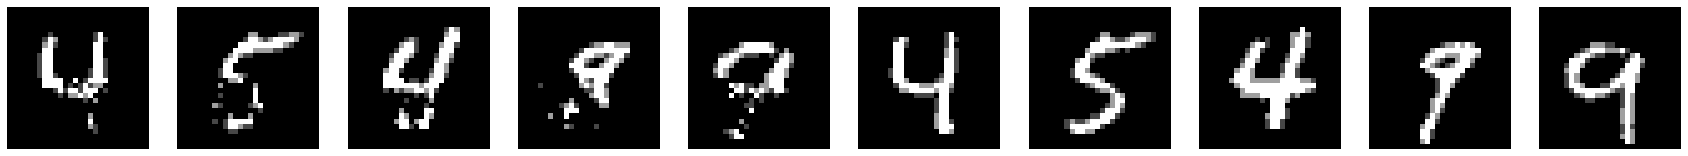

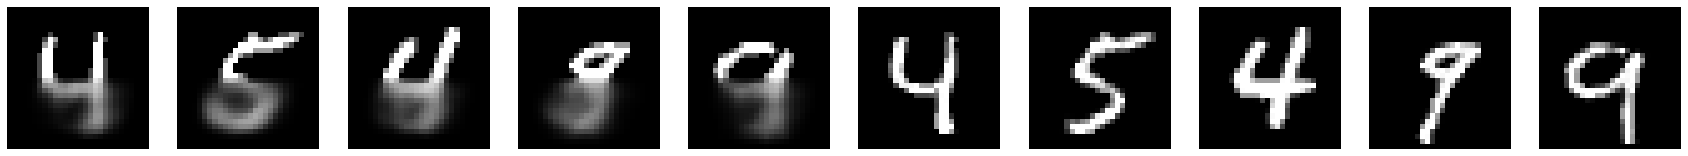

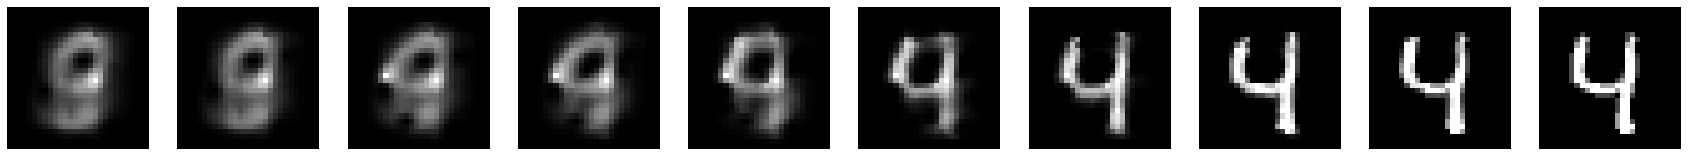

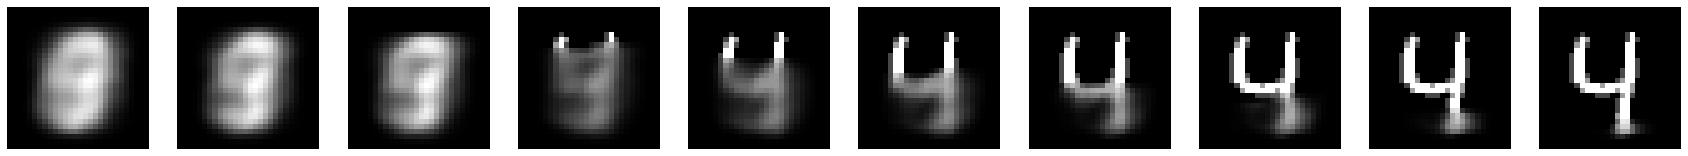

Step 73111, Loss (last minibatch): 0.14553721249103546, Loss (500 step avg.): 0.18560689479529024


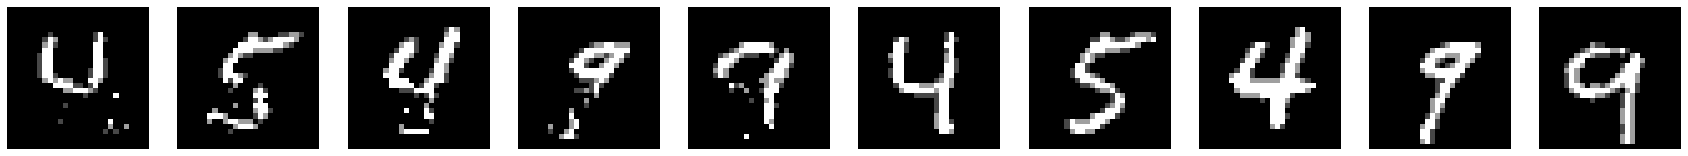

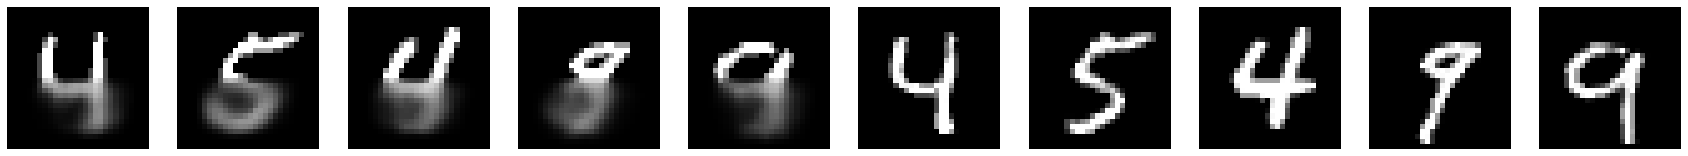

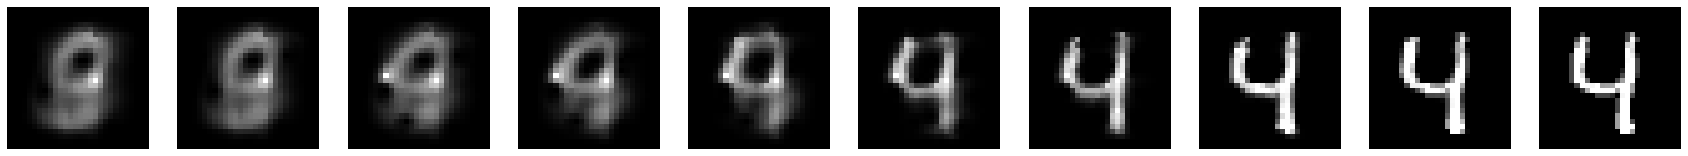

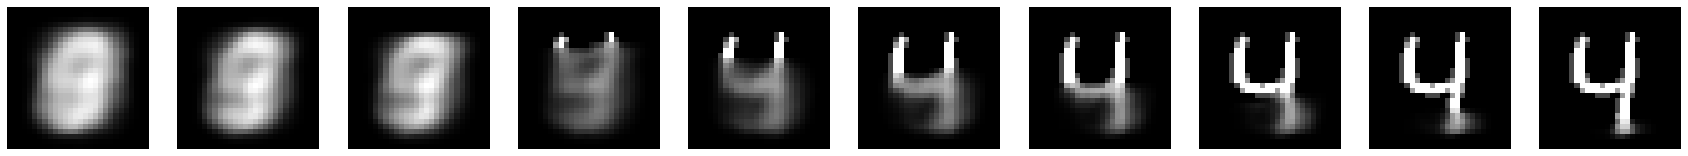

Step 74111, Loss (last minibatch): 0.13418520987033844, Loss (500 step avg.): 0.1832971989721833


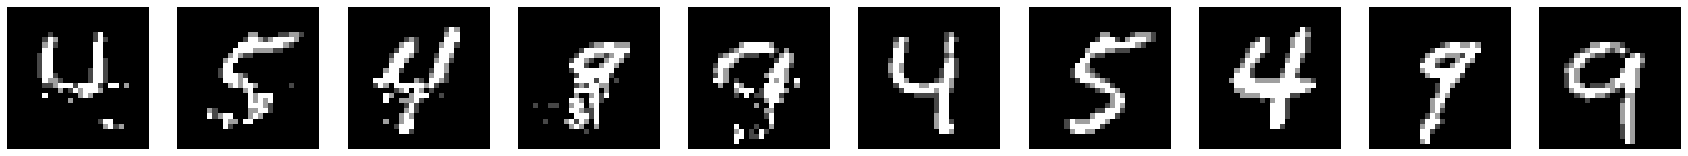

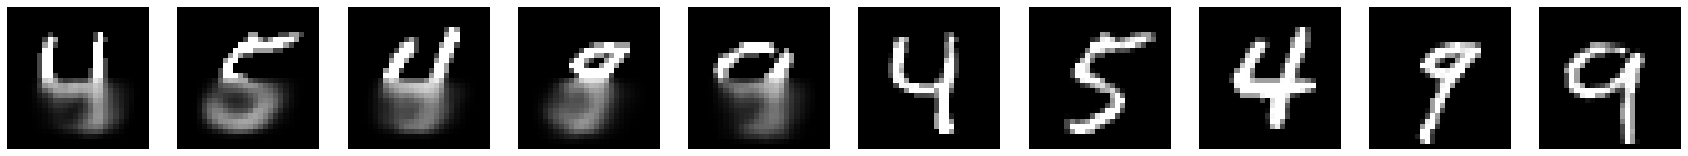

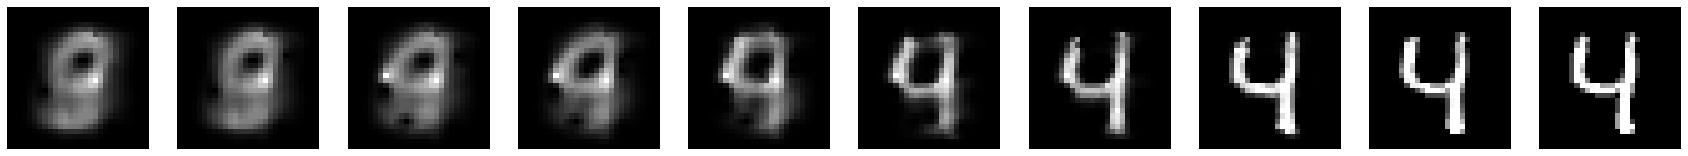

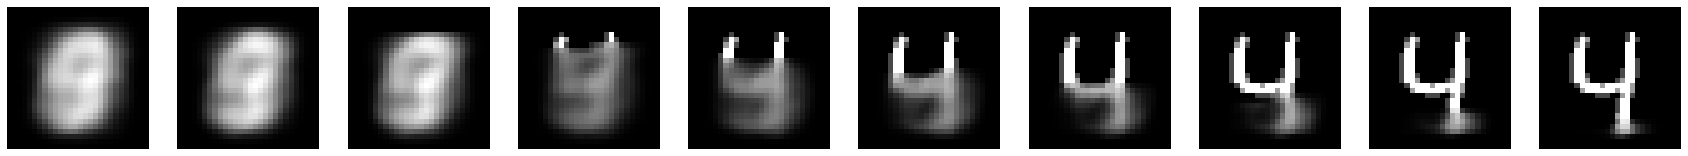

Step 75111, Loss (last minibatch): 0.209926038980484, Loss (500 step avg.): 0.1852715068948483


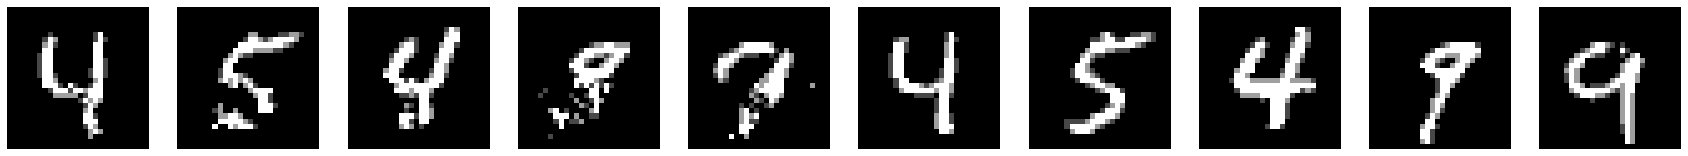

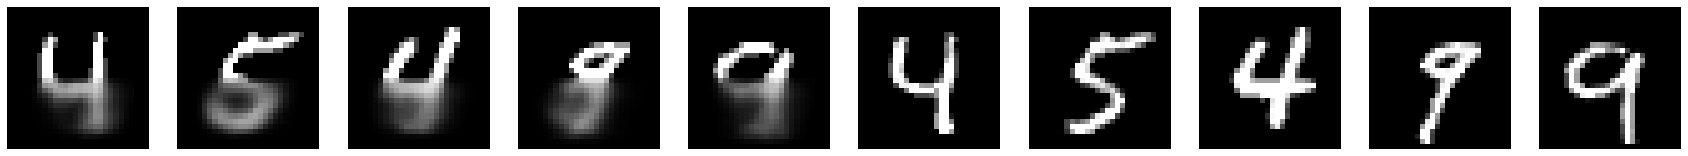

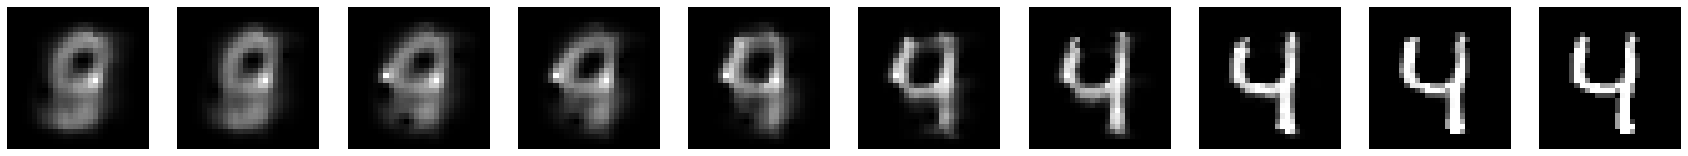

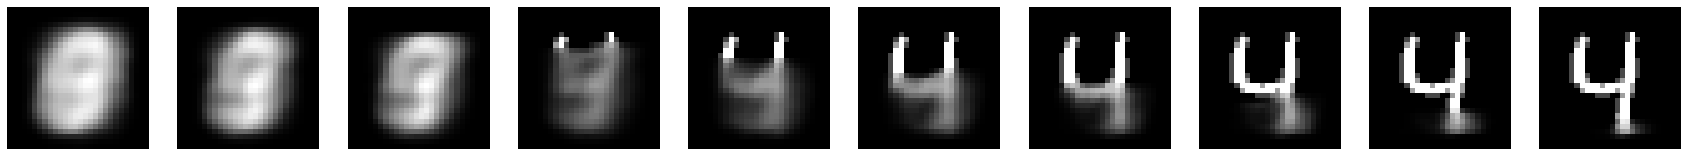

Step 76111, Loss (last minibatch): 0.17218391597270966, Loss (500 step avg.): 0.18419529805461804


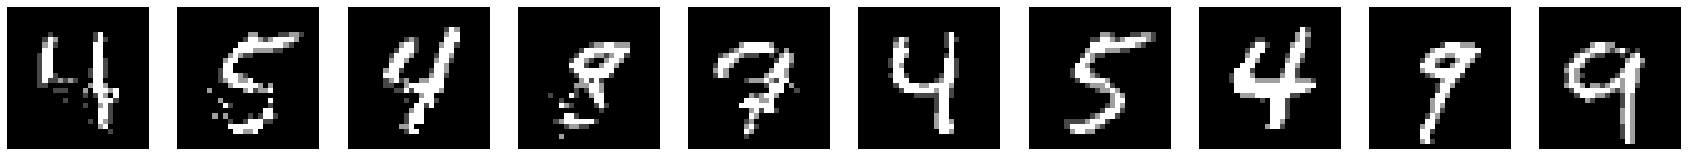

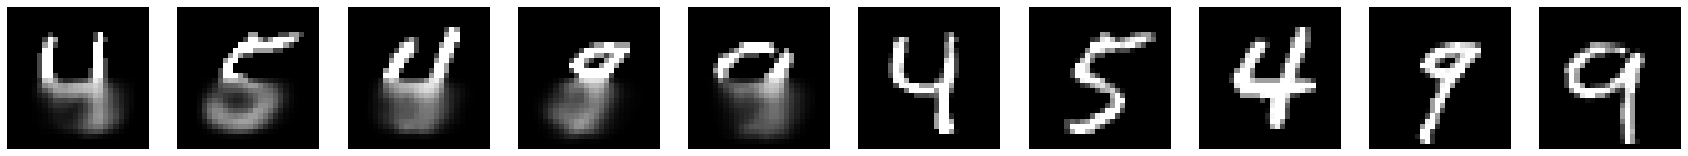

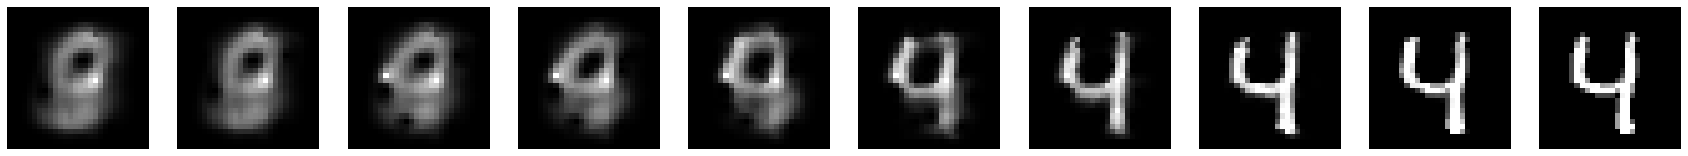

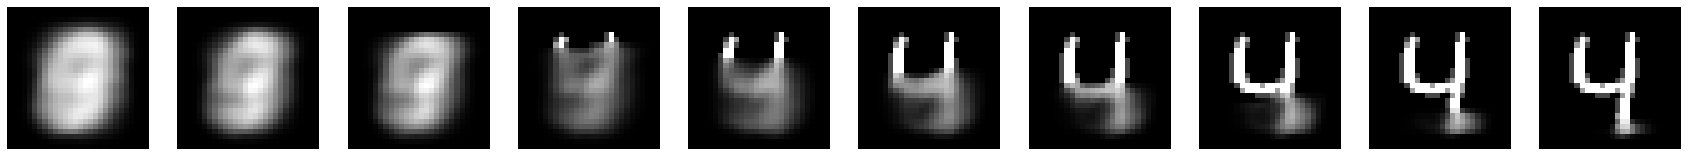

Step 77111, Loss (last minibatch): 0.16134093701839447, Loss (500 step avg.): 0.18311153502461916


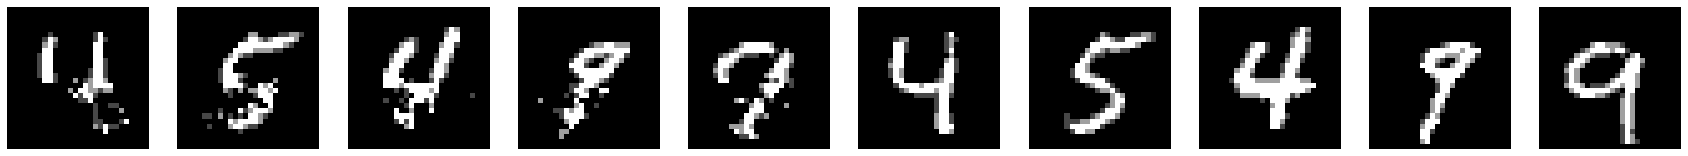

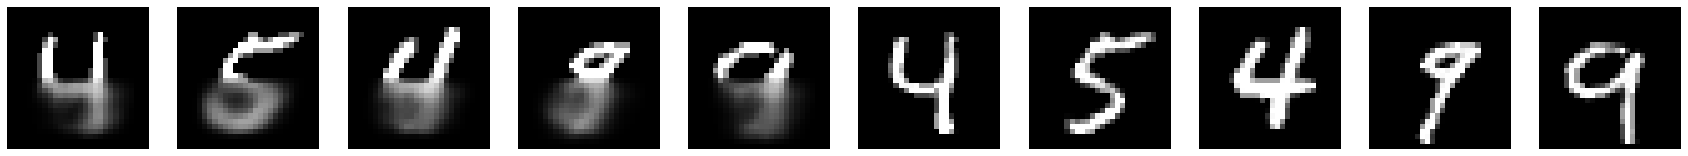

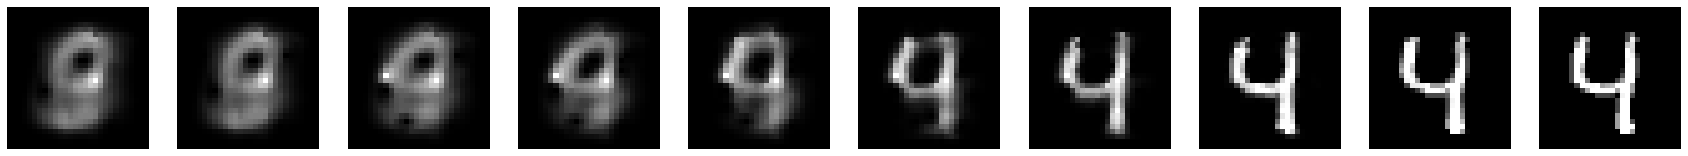

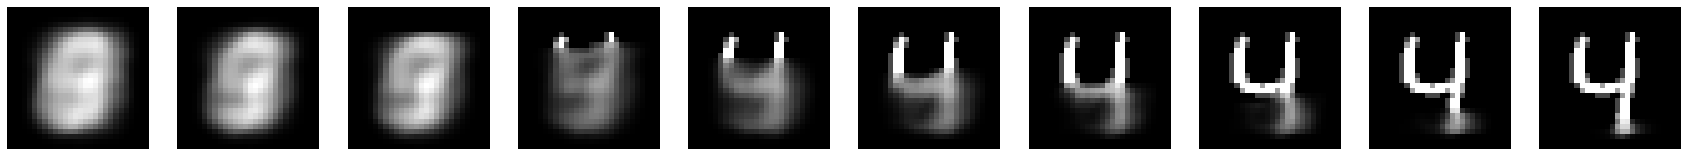

Step 78111, Loss (last minibatch): 0.2673823833465576, Loss (500 step avg.): 0.18650366893844927


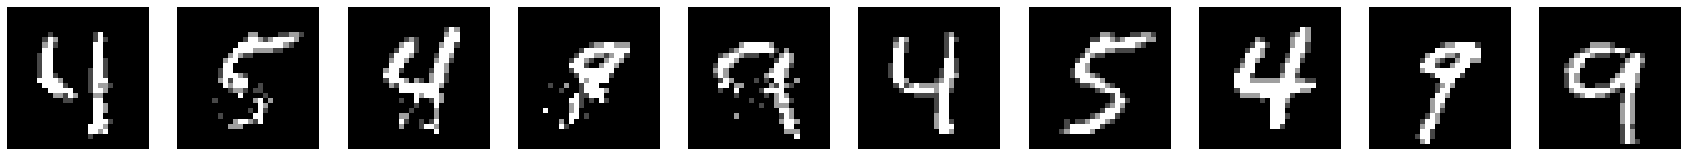

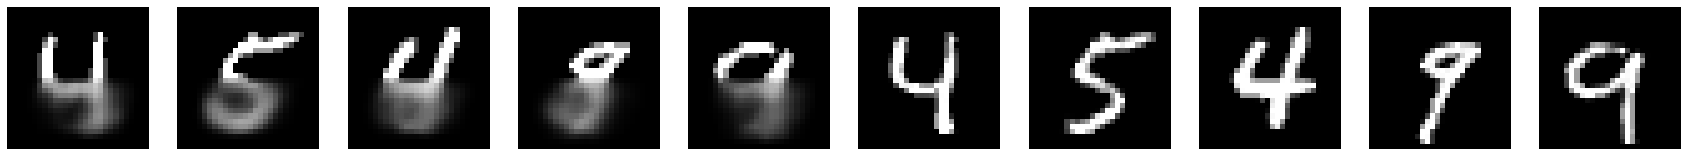

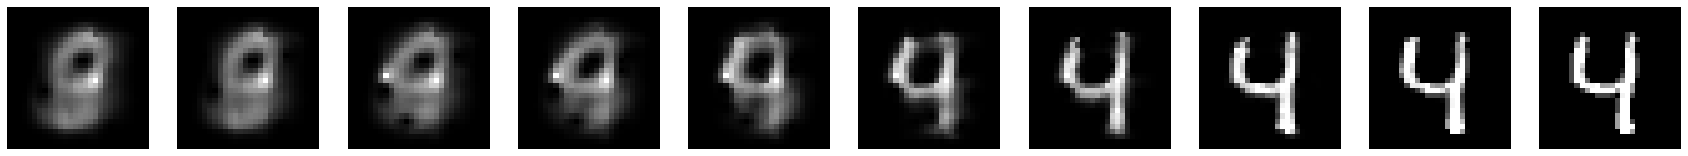

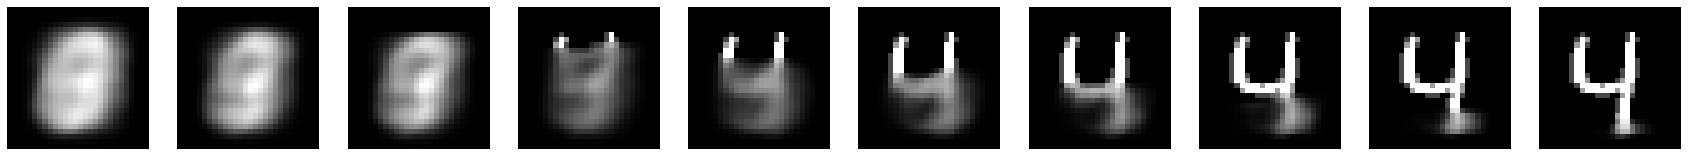

Step 79111, Loss (last minibatch): 0.16700641810894012, Loss (500 step avg.): 0.18298278326640824


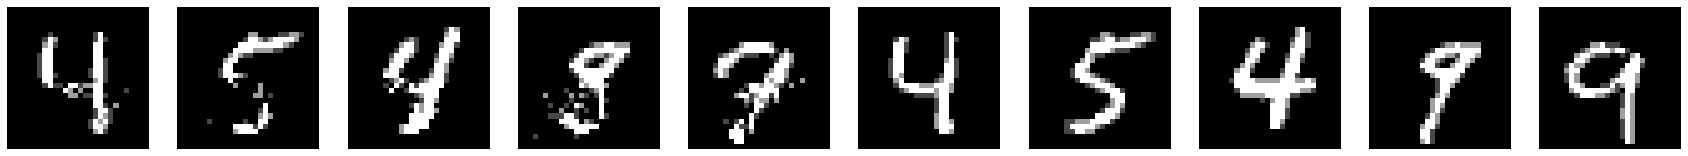

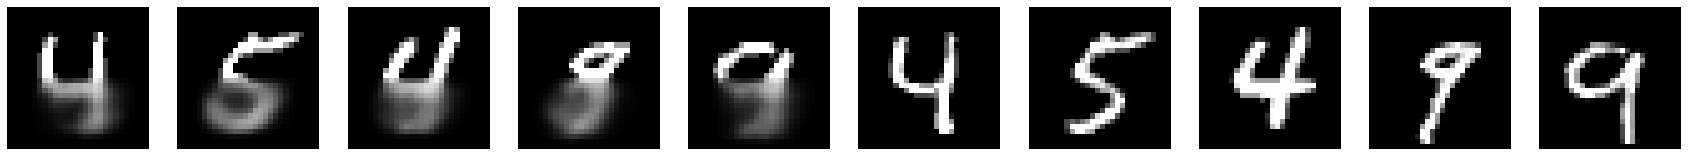

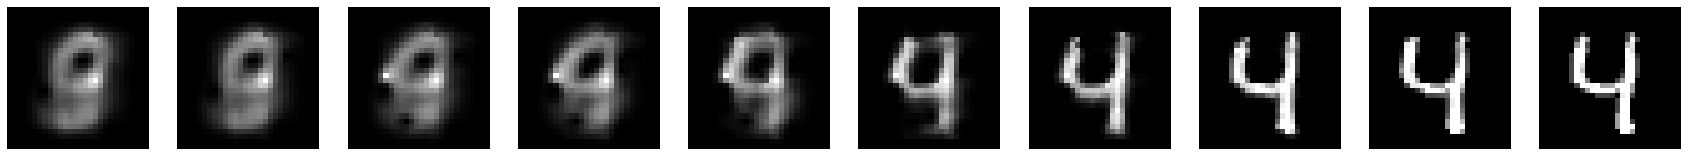

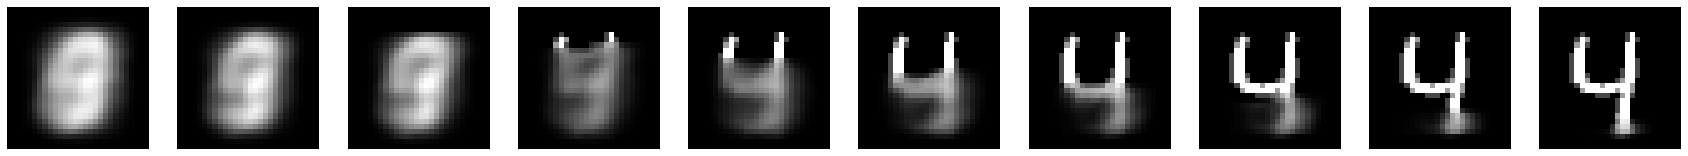

Step 80111, Loss (last minibatch): 0.17503011226654053, Loss (500 step avg.): 0.18603106991140667


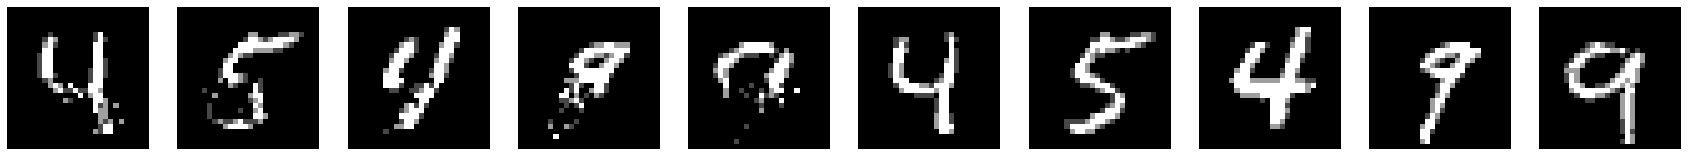

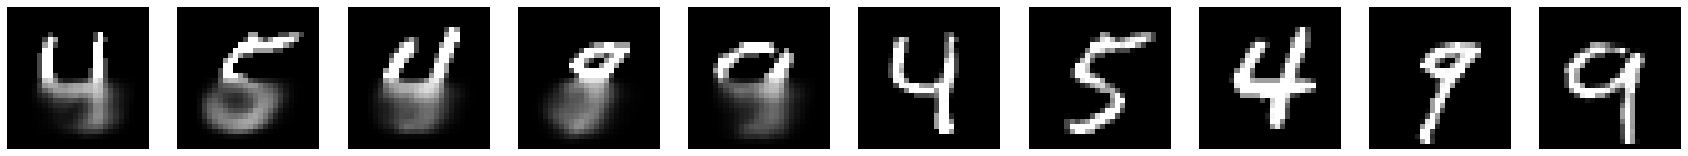

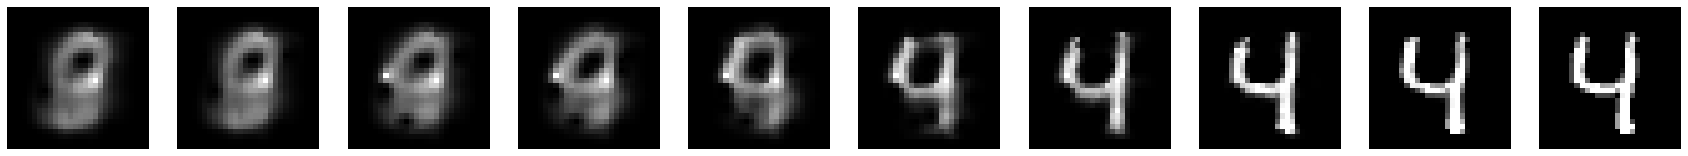

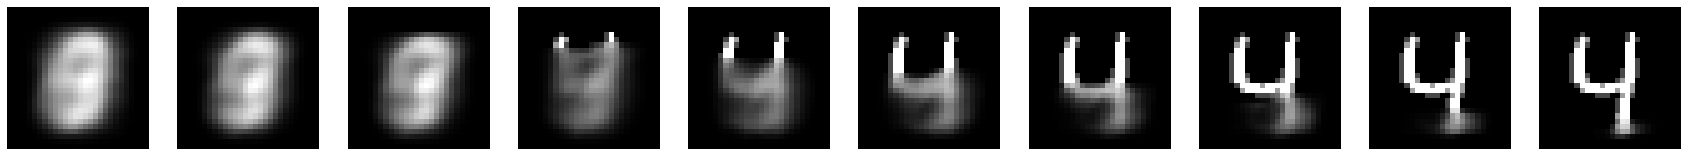

Step 81111, Loss (last minibatch): 0.143214151263237, Loss (500 step avg.): 0.18036285103735572


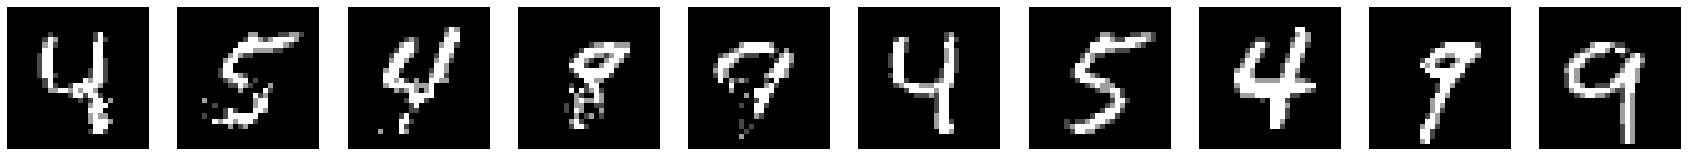

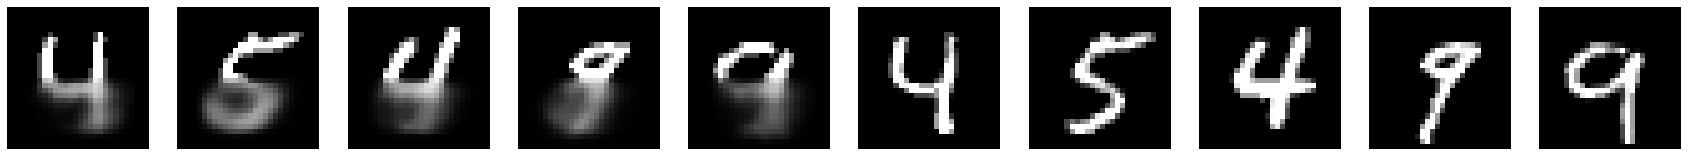

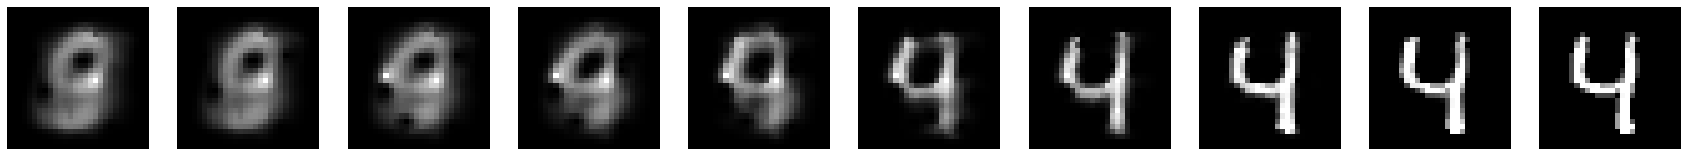

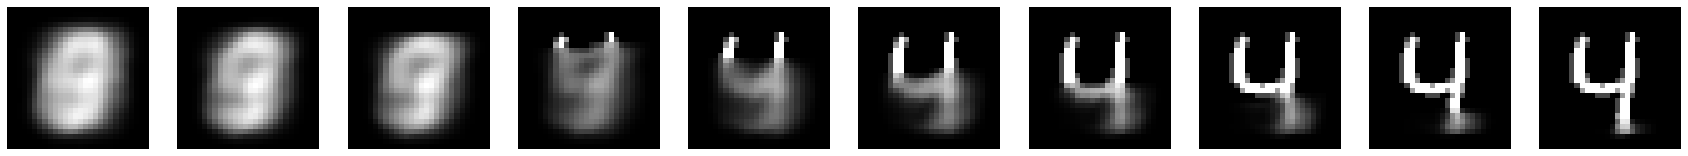

Step 82111, Loss (last minibatch): 0.12567594647407532, Loss (500 step avg.): 0.1838155569371111


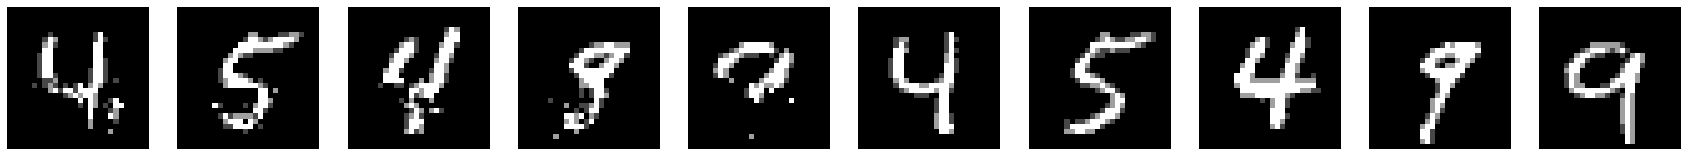

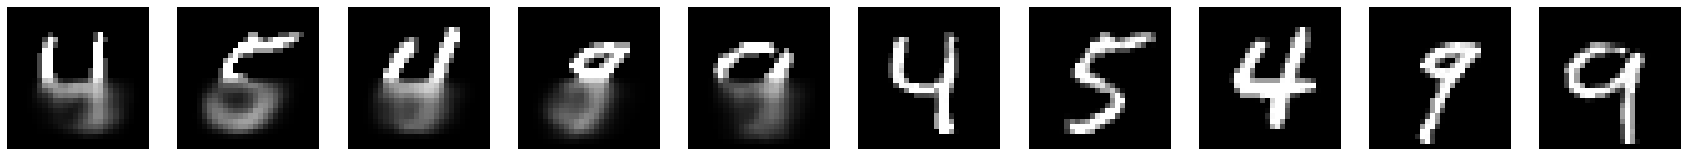

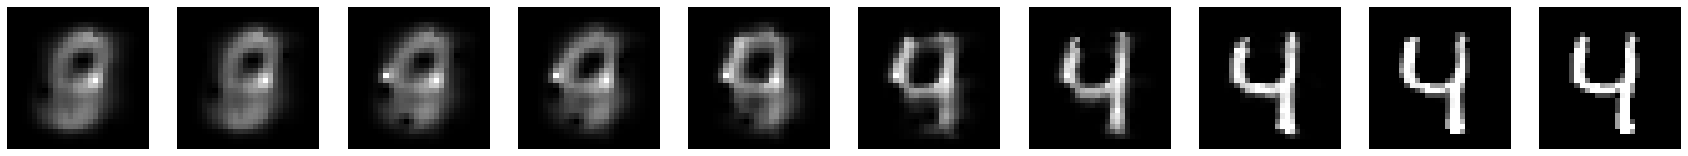

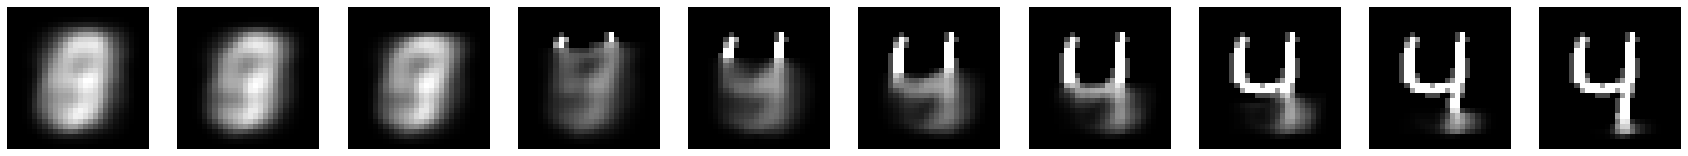

Step 83111, Loss (last minibatch): 0.20410758256912231, Loss (500 step avg.): 0.18183414563685357


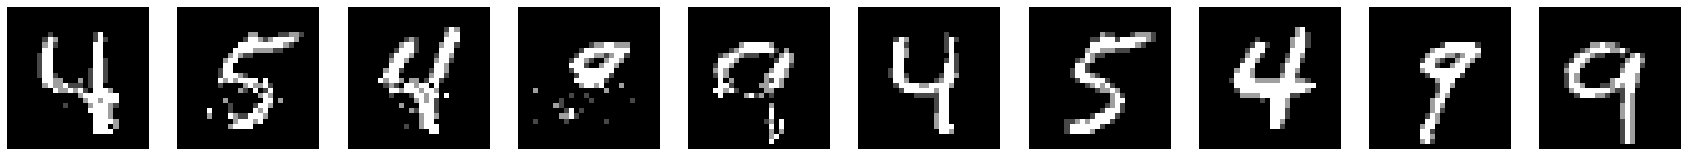

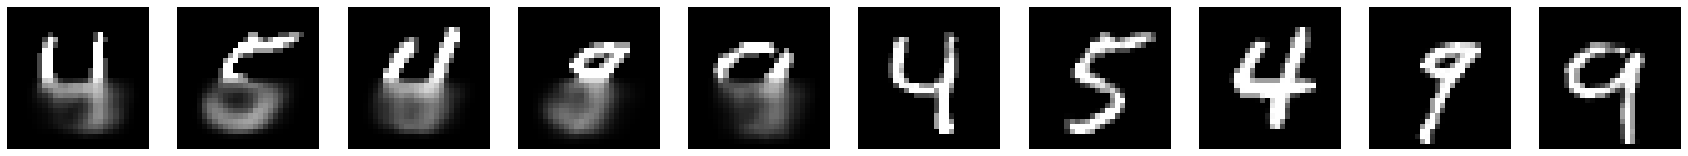

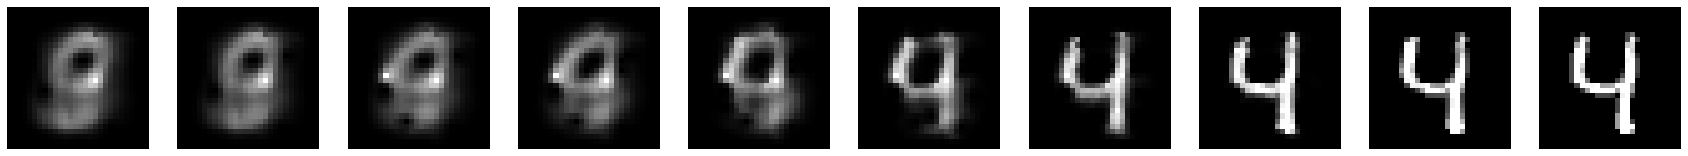

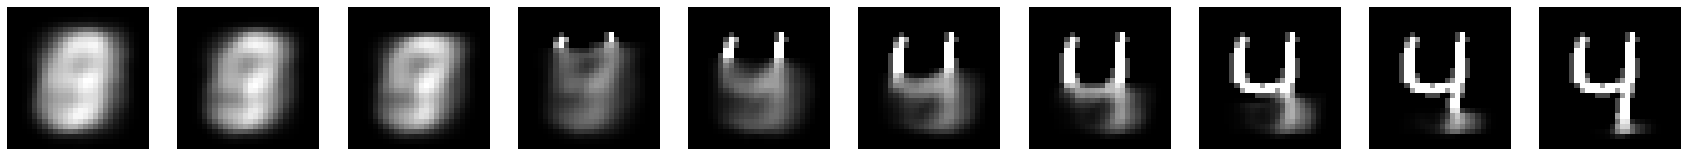

Step 84111, Loss (last minibatch): 0.21283060312271118, Loss (500 step avg.): 0.18153529075864785


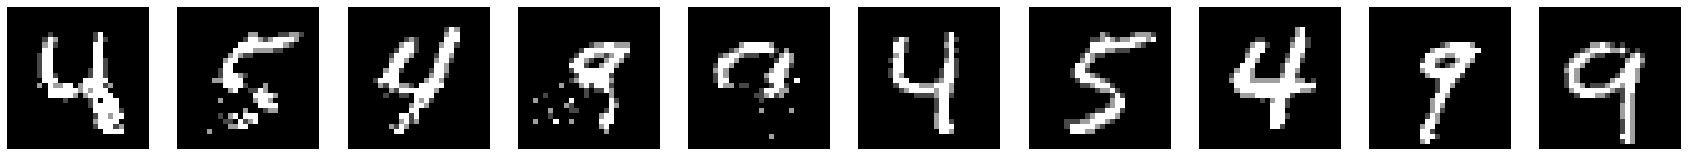

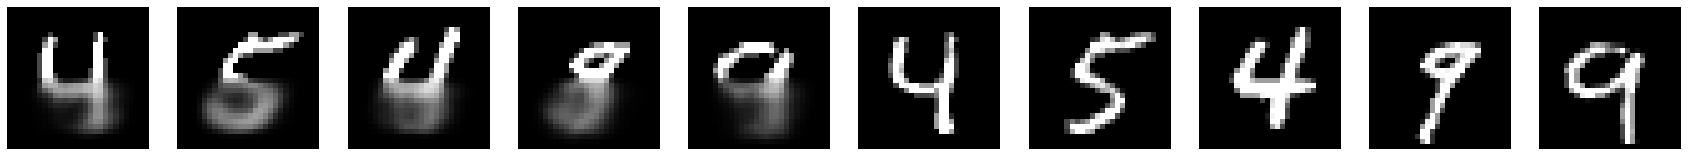

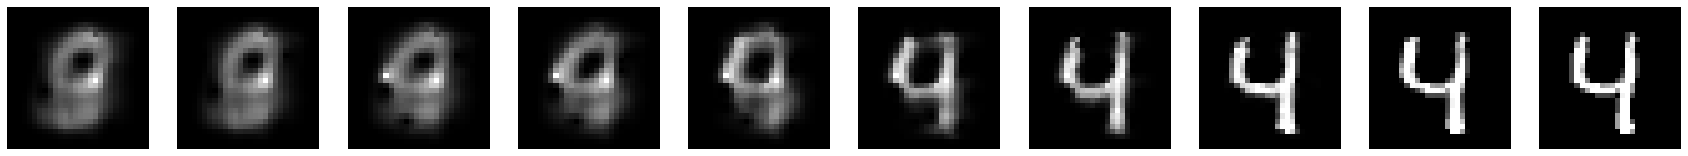

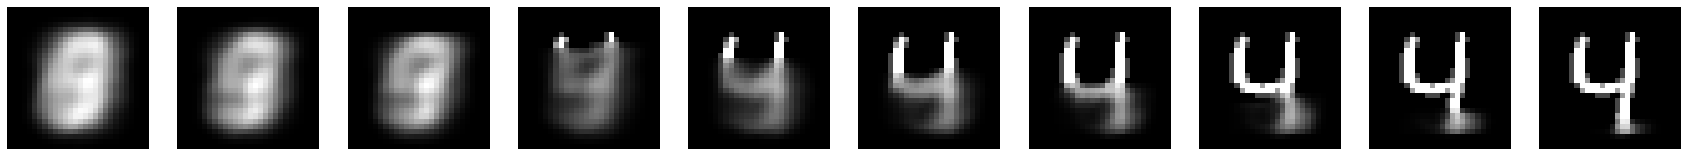

Step 85111, Loss (last minibatch): 0.2803994417190552, Loss (500 step avg.): 0.18471091752221247


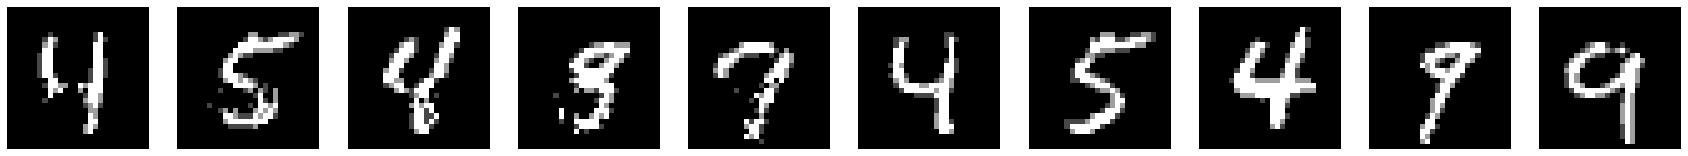

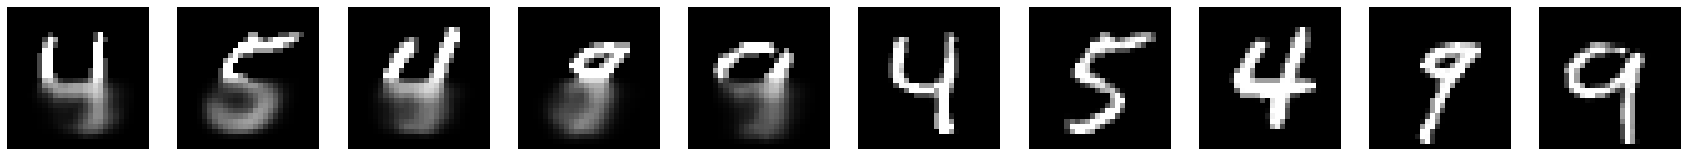

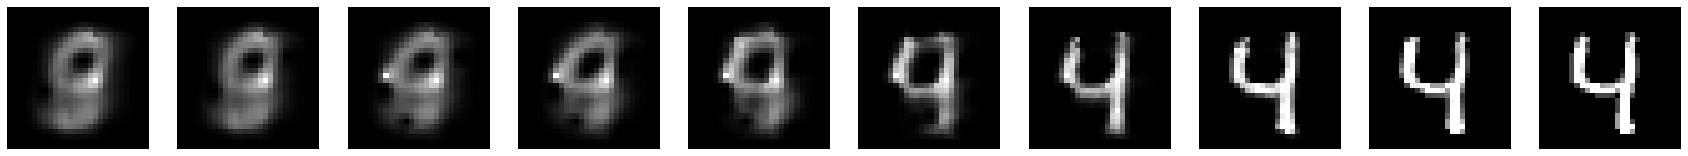

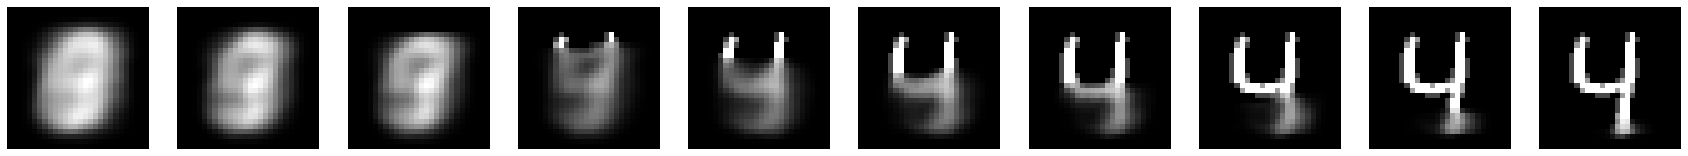

Step 86111, Loss (last minibatch): 0.1629423350095749, Loss (500 step avg.): 0.1835144462283262


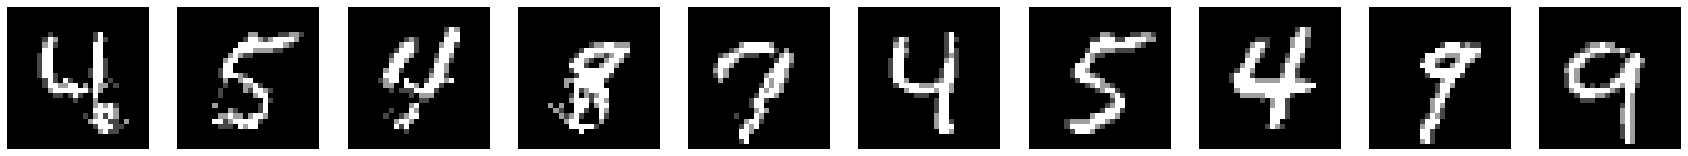

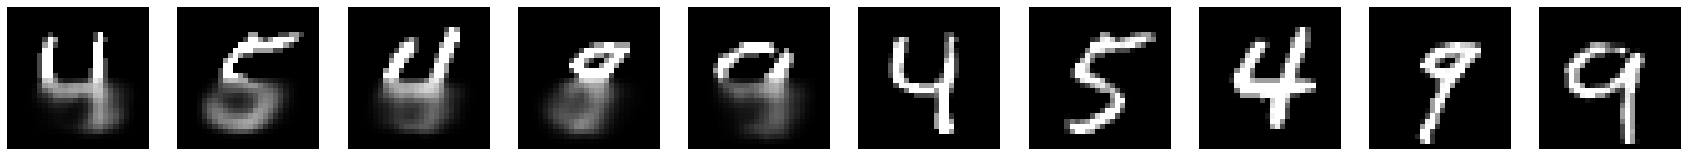

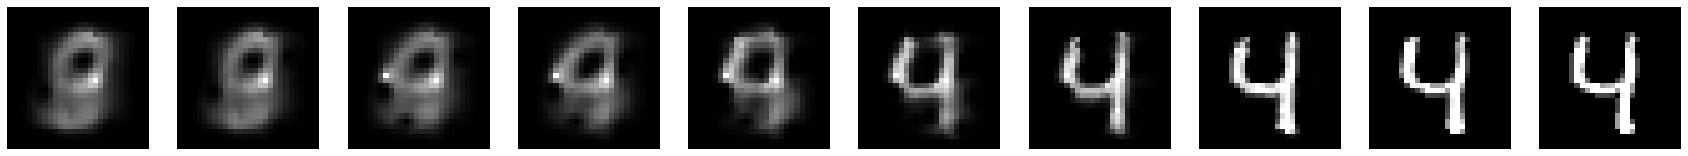

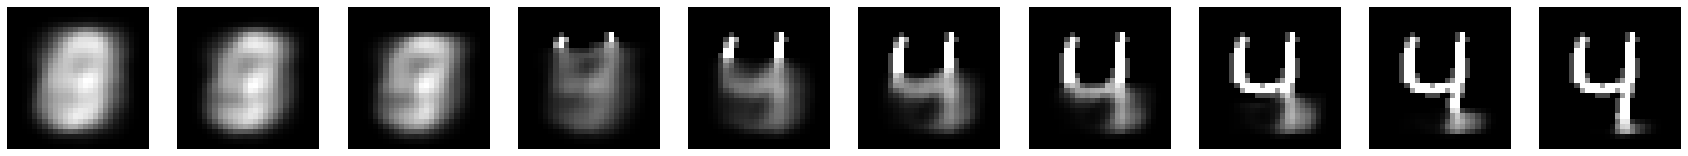

Step 87111, Loss (last minibatch): 0.20715683698654175, Loss (500 step avg.): 0.1813738622559521


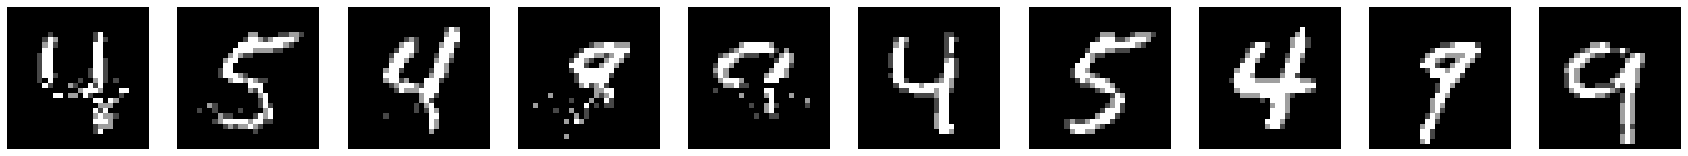

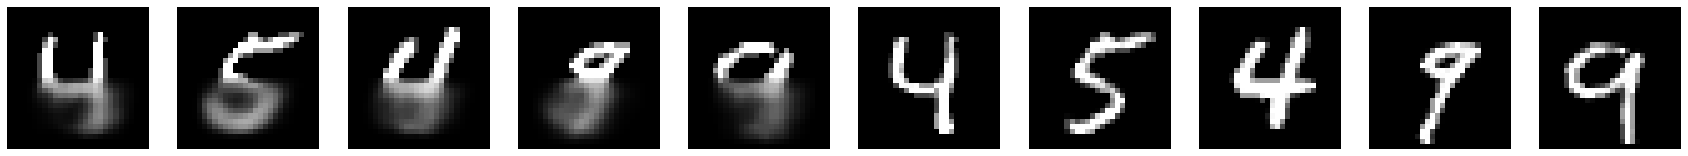

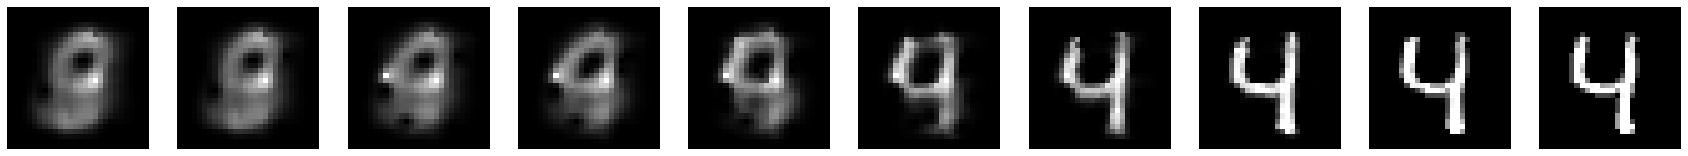

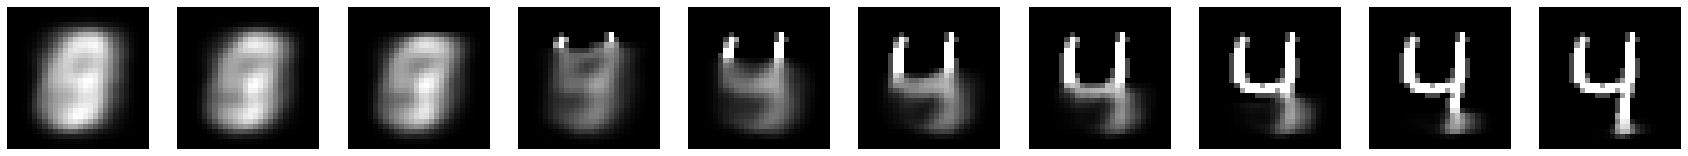

Step 88111, Loss (last minibatch): 0.1617874950170517, Loss (500 step avg.): 0.18123529463292595


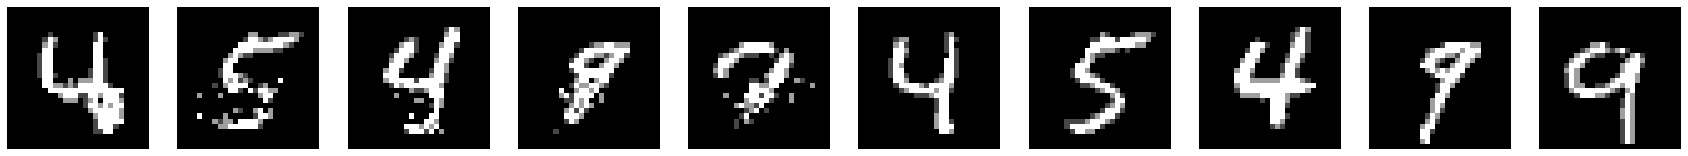

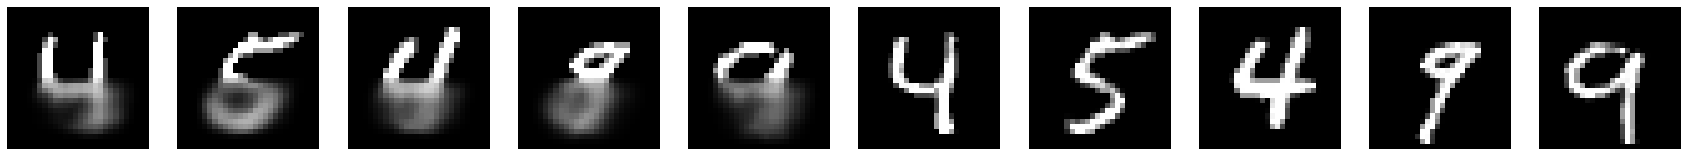

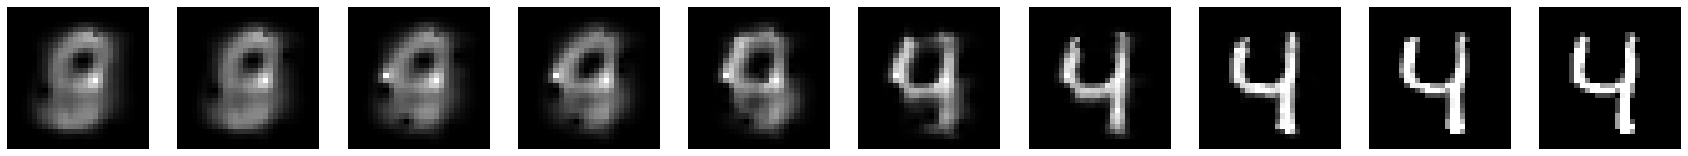

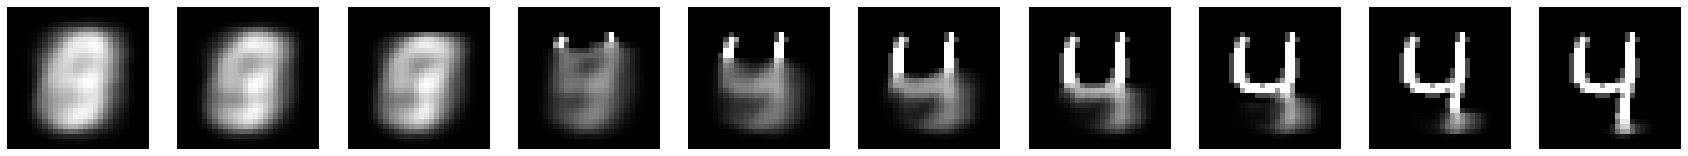

Step 89111, Loss (last minibatch): 0.14093953371047974, Loss (500 step avg.): 0.18328825732369622


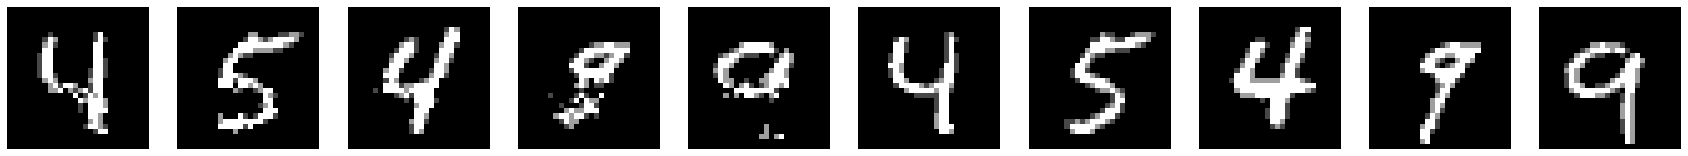

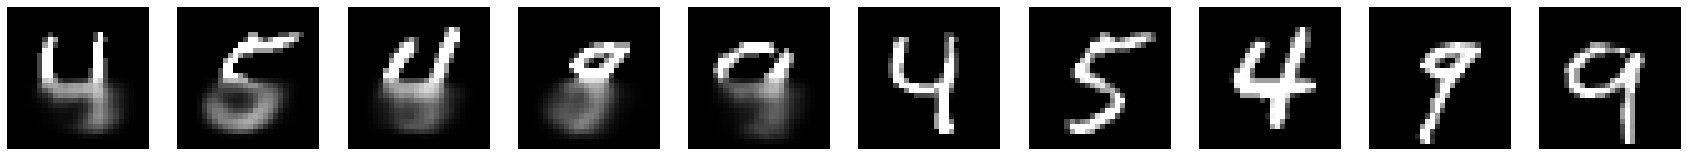

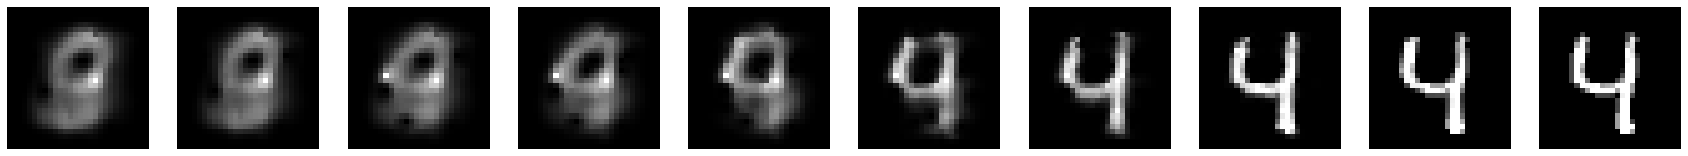

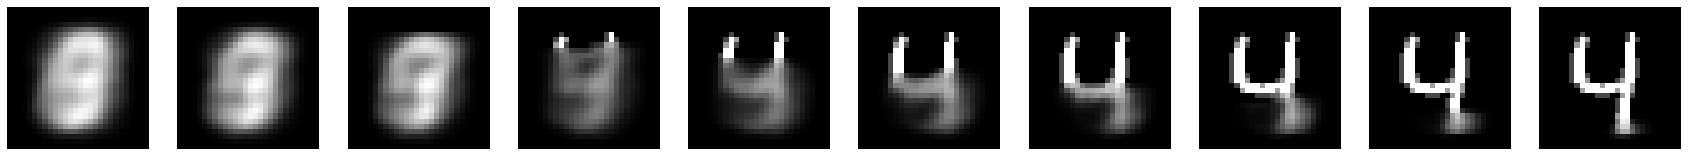

Step 90111, Loss (last minibatch): 0.2270585298538208, Loss (500 step avg.): 0.18371061922725804


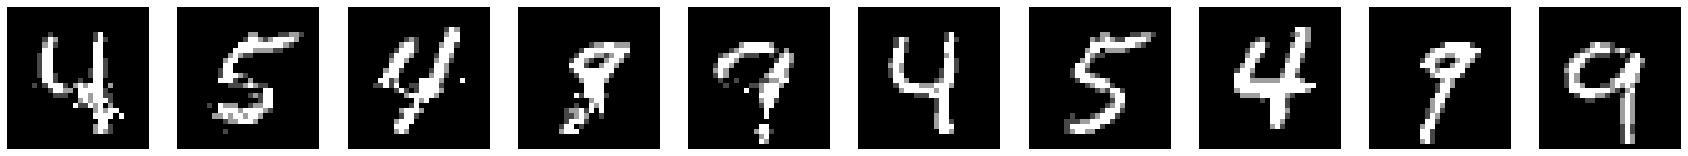

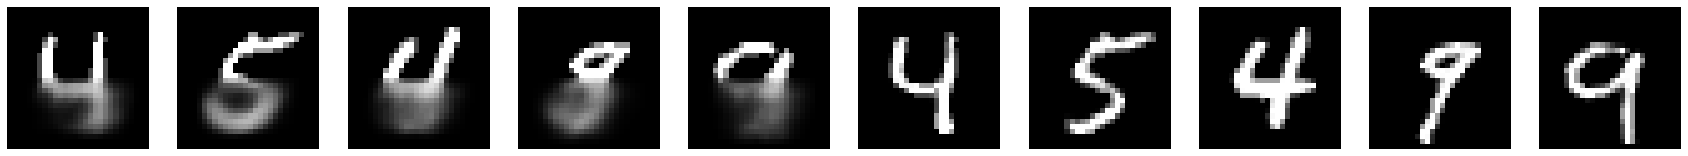

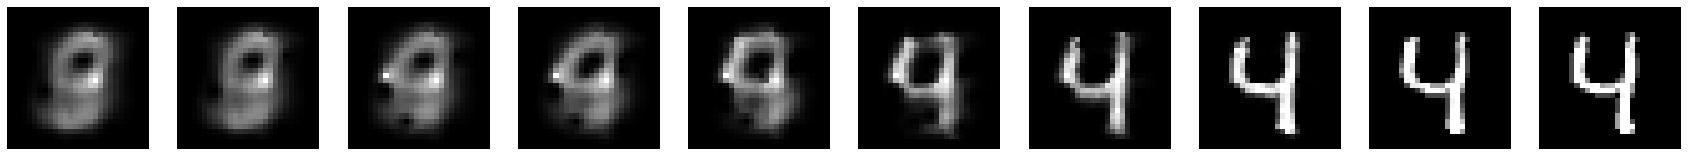

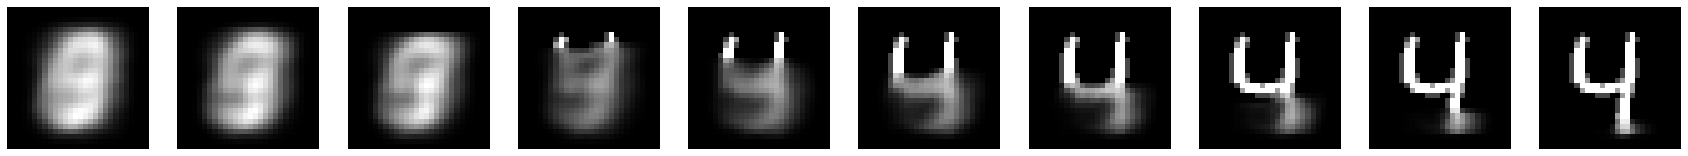

Step 91111, Loss (last minibatch): 0.2342793196439743, Loss (500 step avg.): 0.18121800762034224


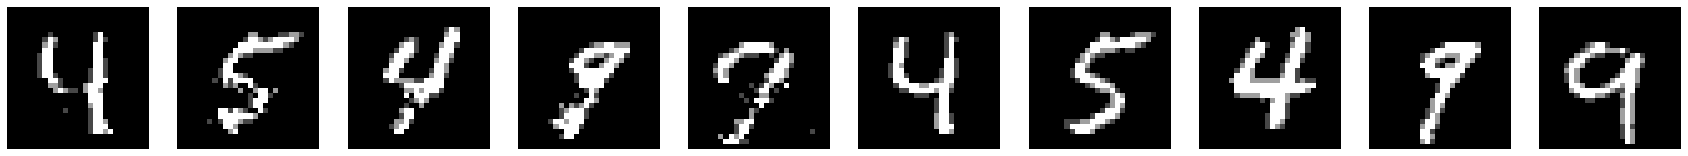

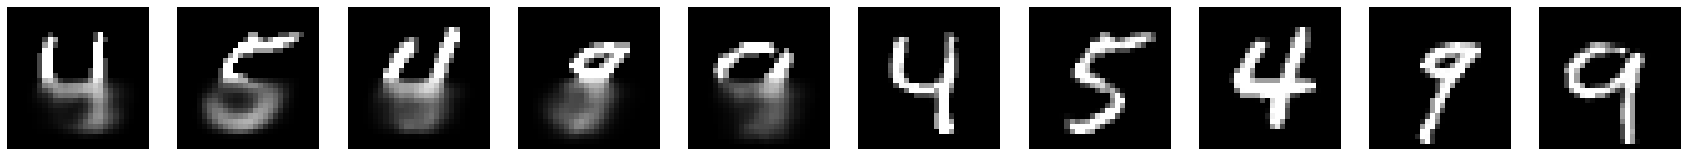

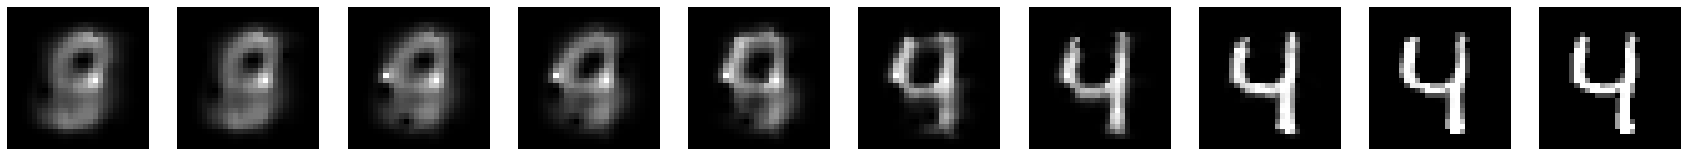

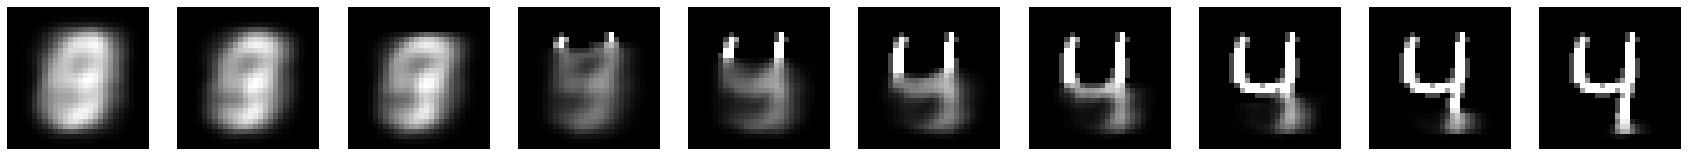

Step 92111, Loss (last minibatch): 0.17345373332500458, Loss (500 step avg.): 0.18229260609416428


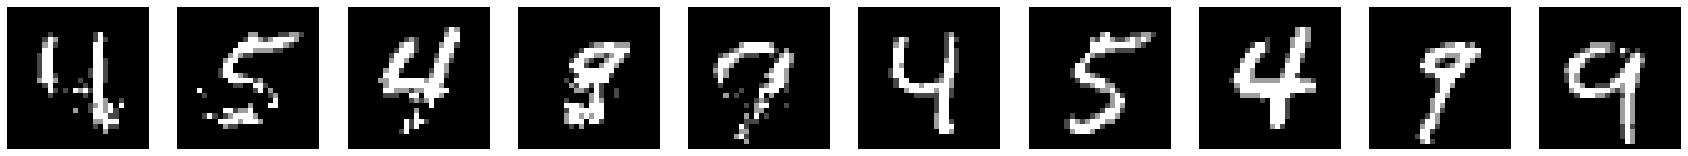

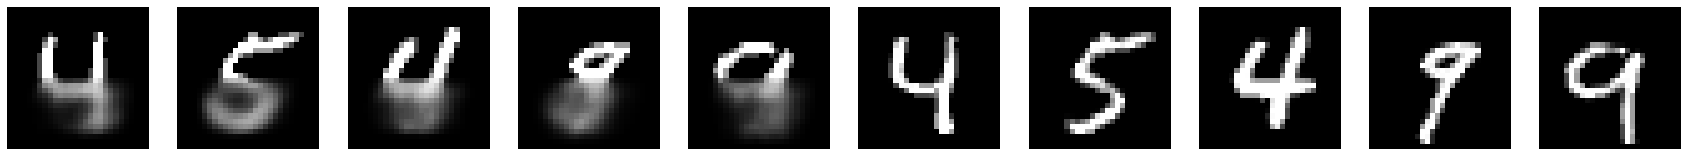

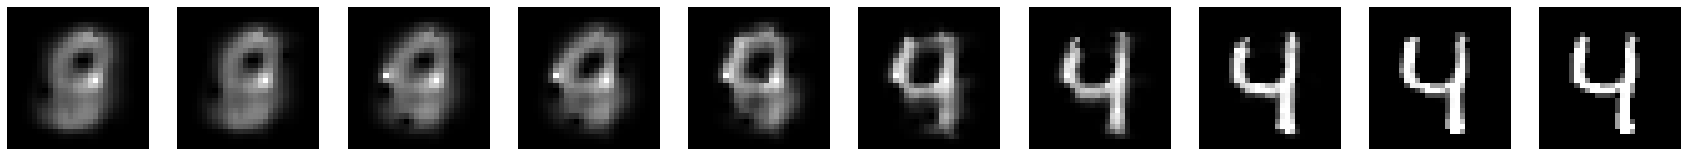

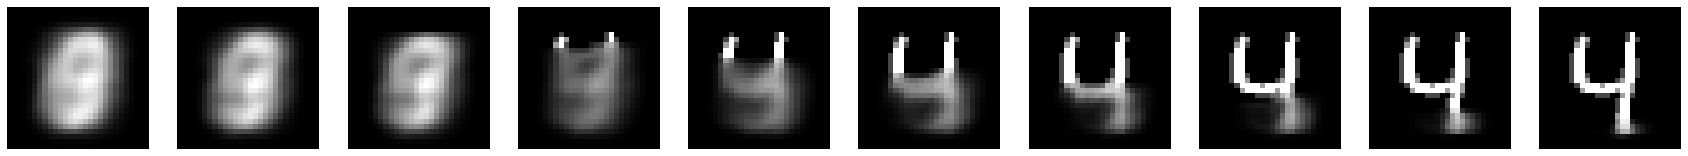

Step 93111, Loss (last minibatch): 0.15904170274734497, Loss (500 step avg.): 0.18239312183238313


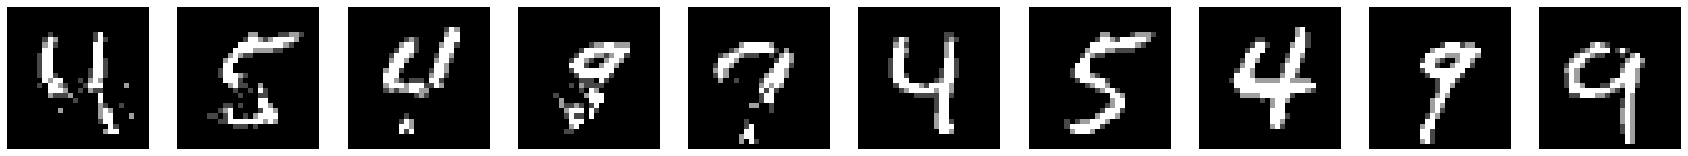

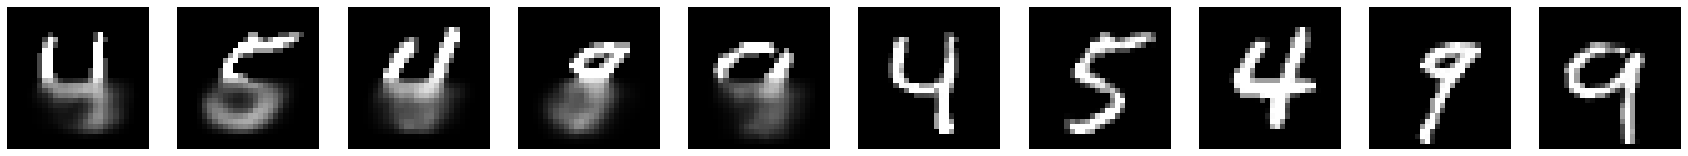

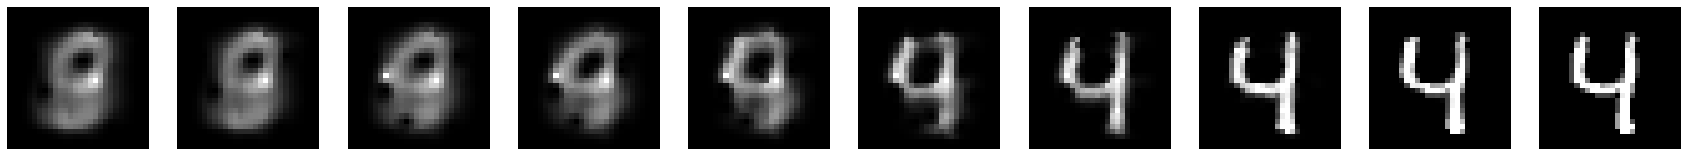

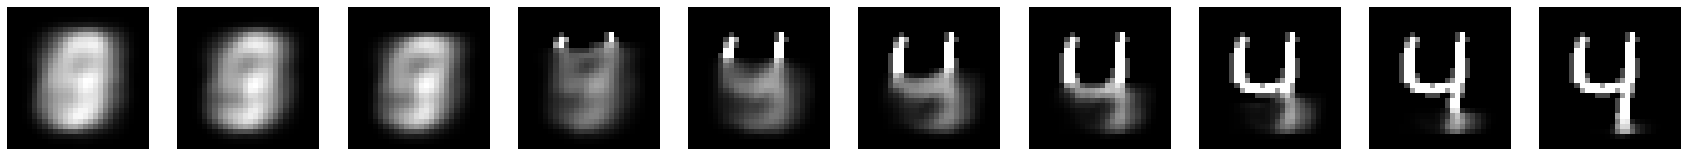

Step 94111, Loss (last minibatch): 0.1990101933479309, Loss (500 step avg.): 0.18019526375981862


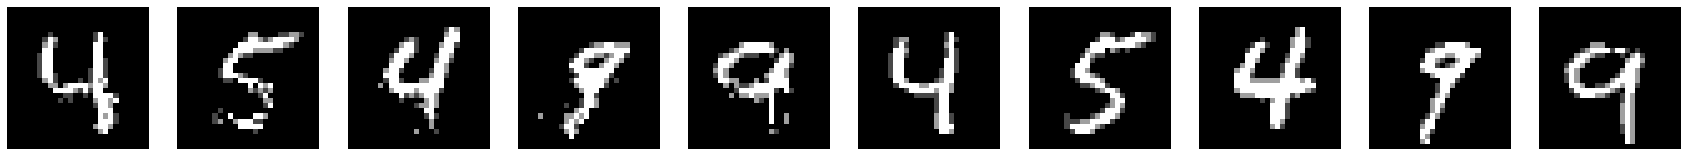

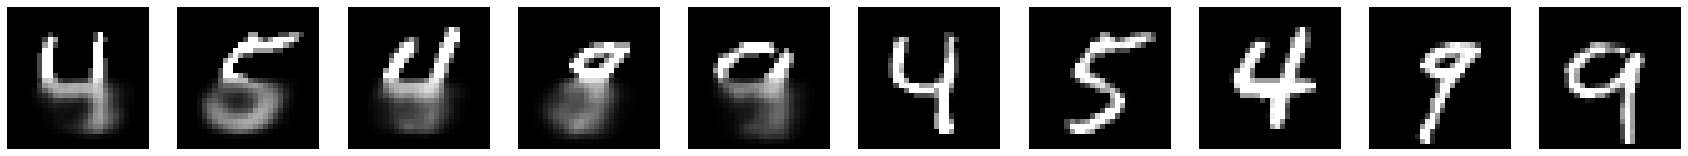

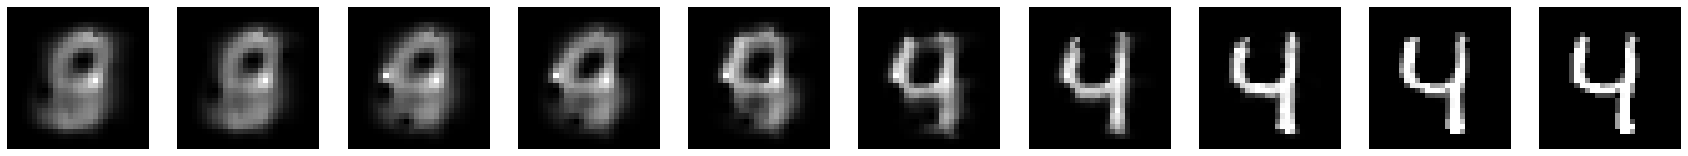

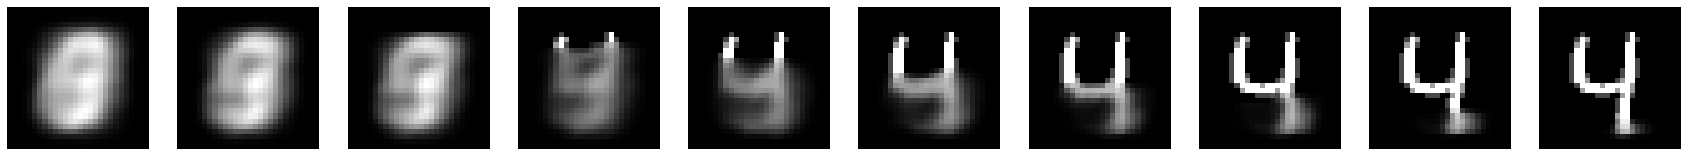

Step 95111, Loss (last minibatch): 0.1275038719177246, Loss (500 step avg.): 0.17815763161270443


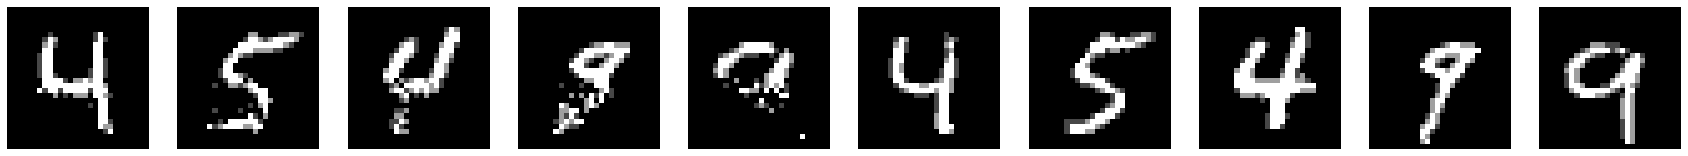

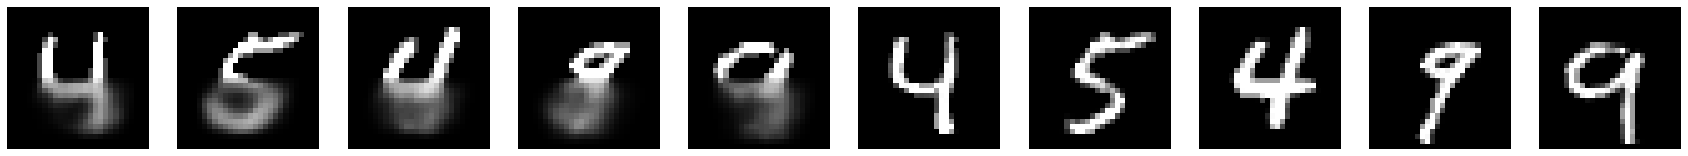

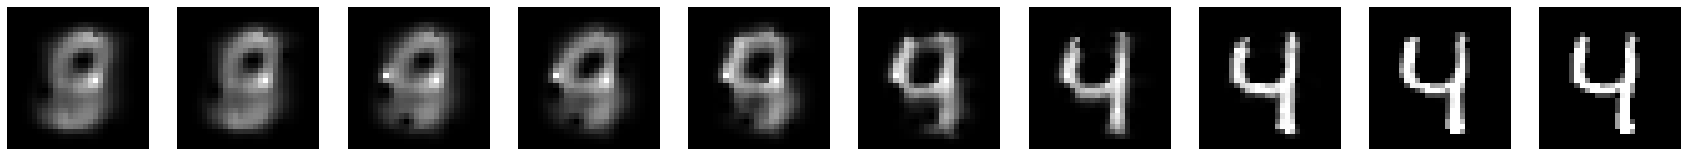

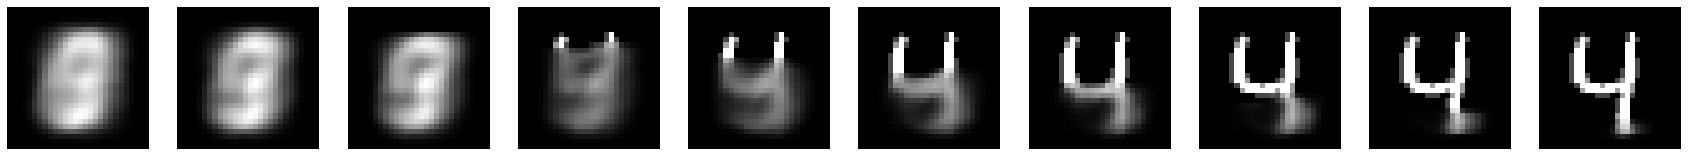

Step 96111, Loss (last minibatch): 0.14046260714530945, Loss (500 step avg.): 0.18003824393370907


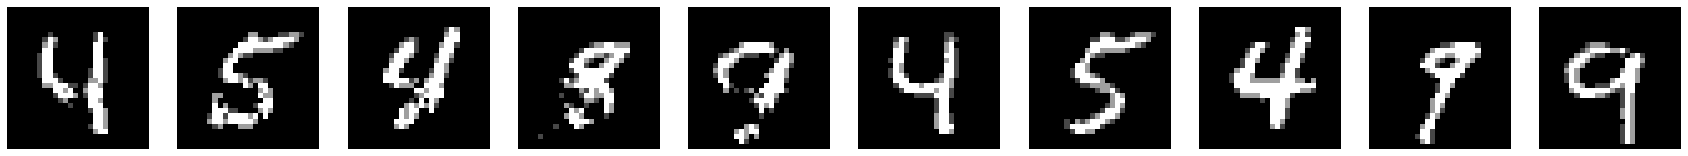

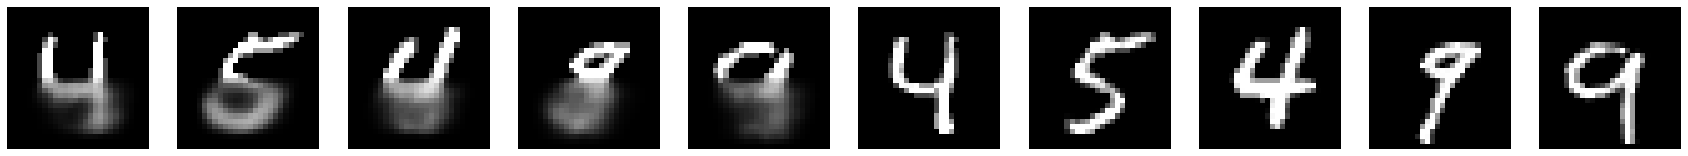

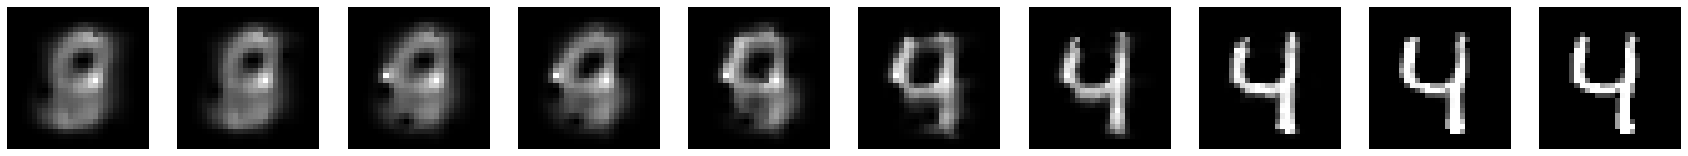

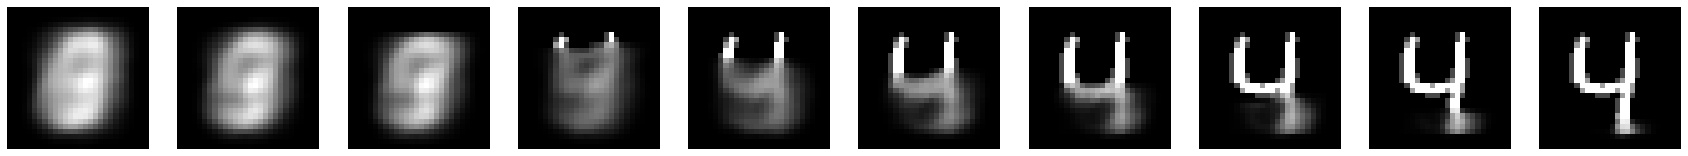

Step 97111, Loss (last minibatch): 0.17668697237968445, Loss (500 step avg.): 0.17998232343001755


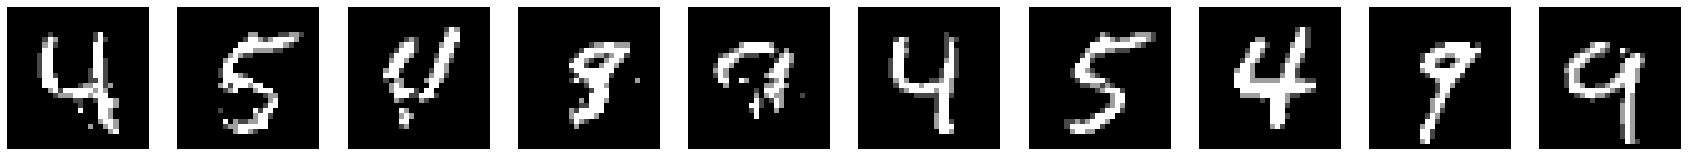

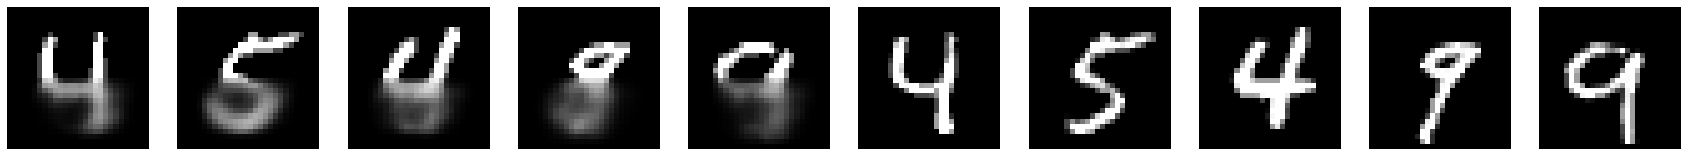

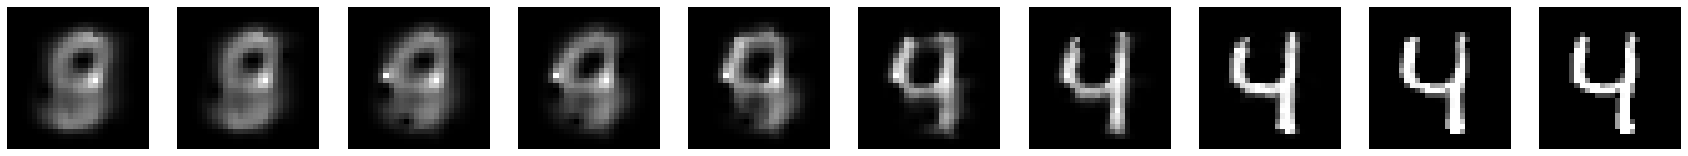

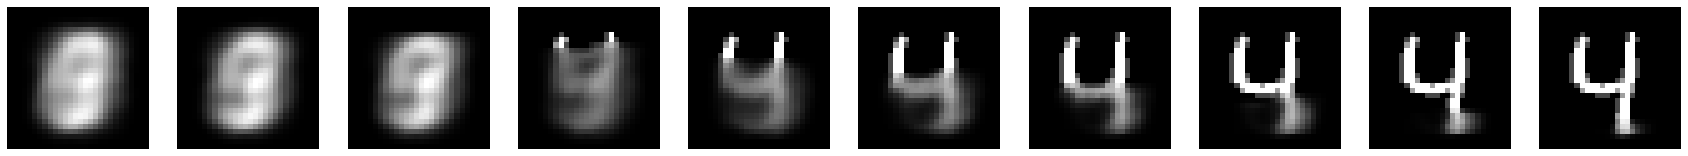

Step 98111, Loss (last minibatch): 0.13671532273292542, Loss (500 step avg.): 0.18025715012631255


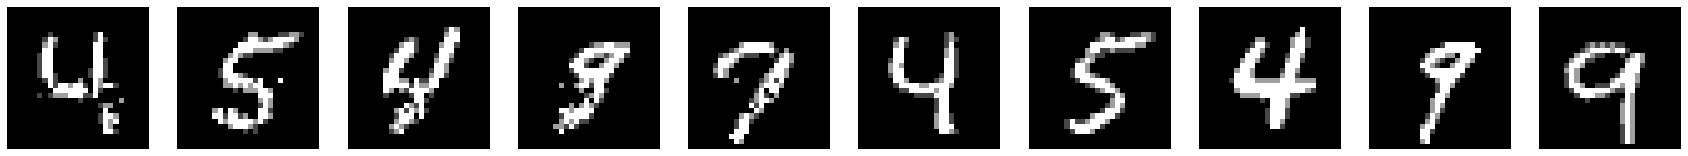

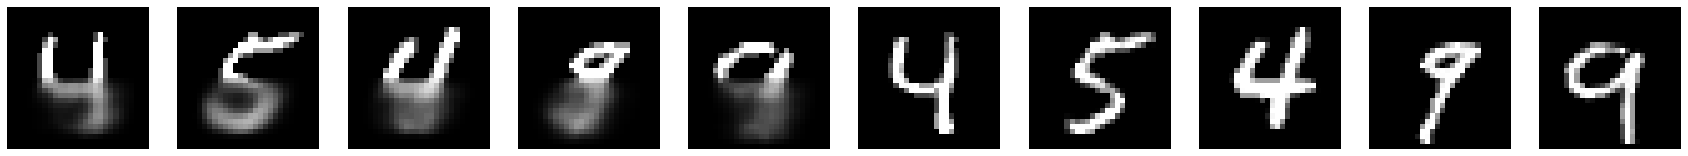

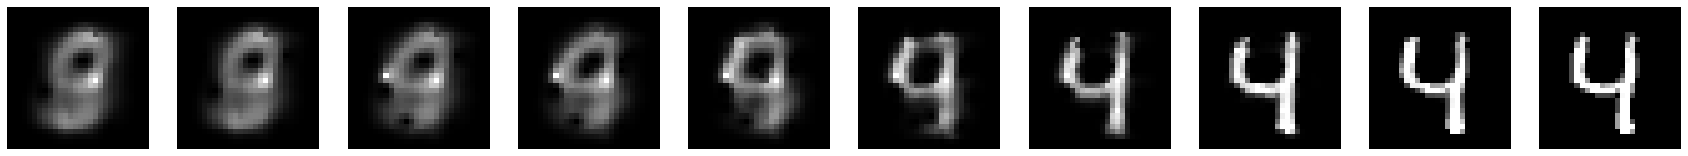

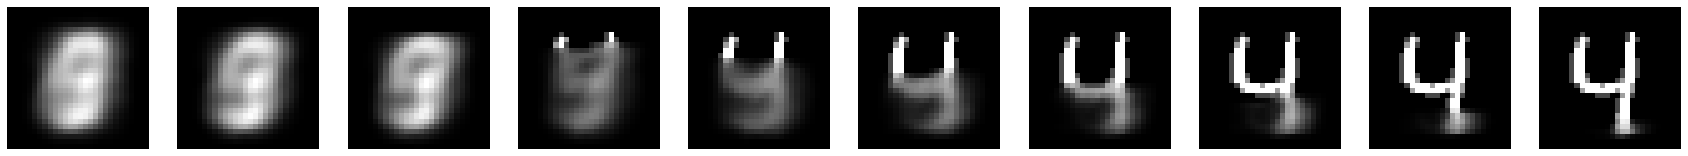

Step 99111, Loss (last minibatch): 0.13673144578933716, Loss (500 step avg.): 0.18158775334527155


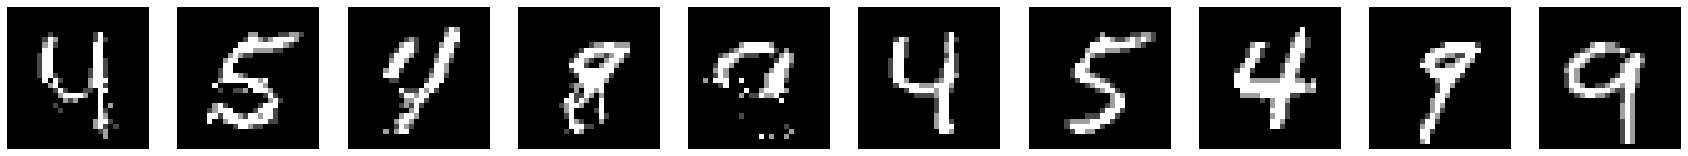

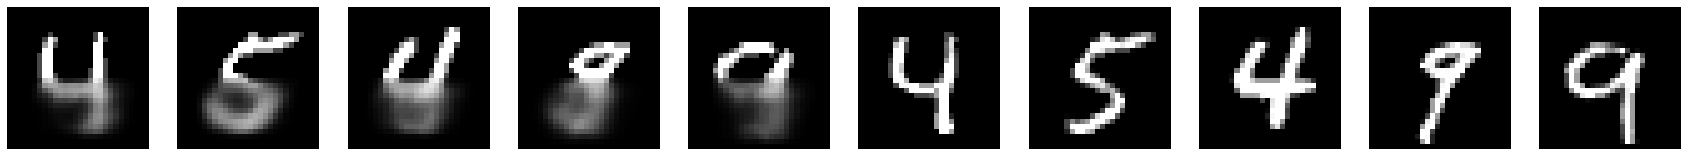

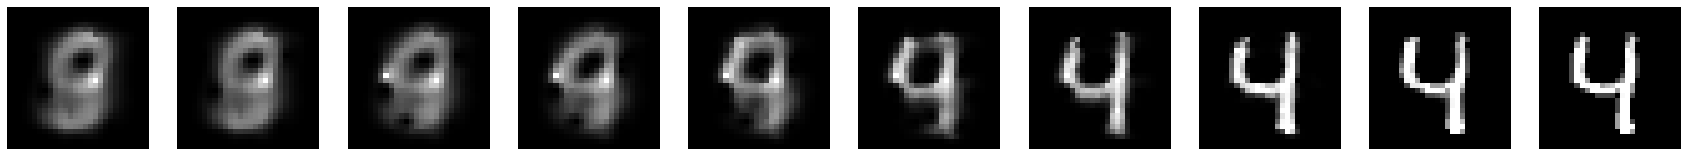

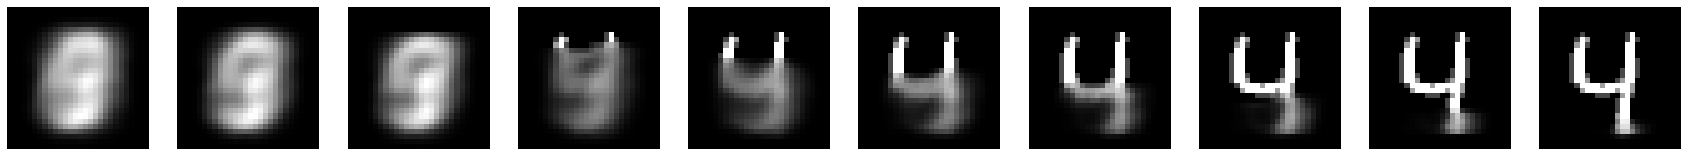

Step 100111, Loss (last minibatch): 0.14843147993087769, Loss (500 step avg.): 0.18376523416913199


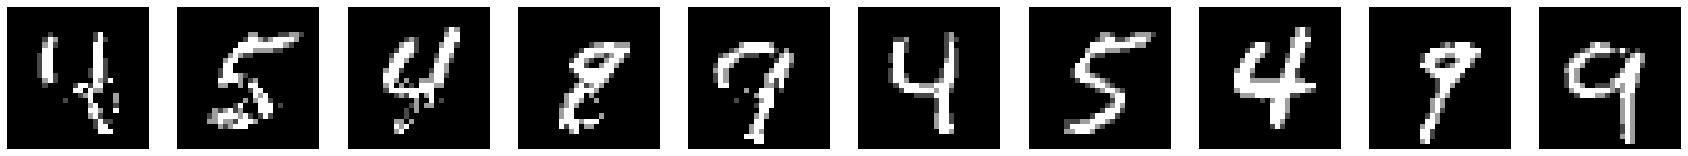

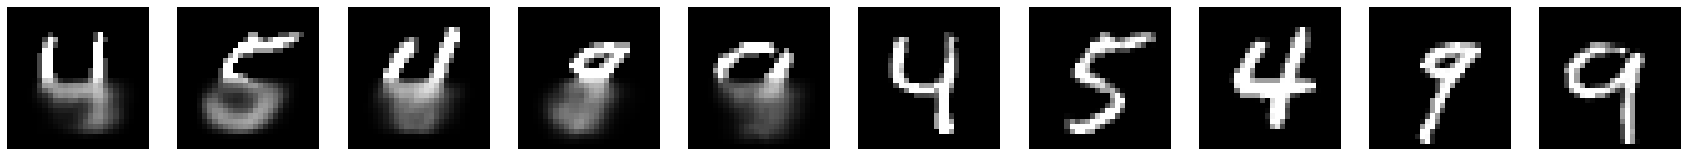

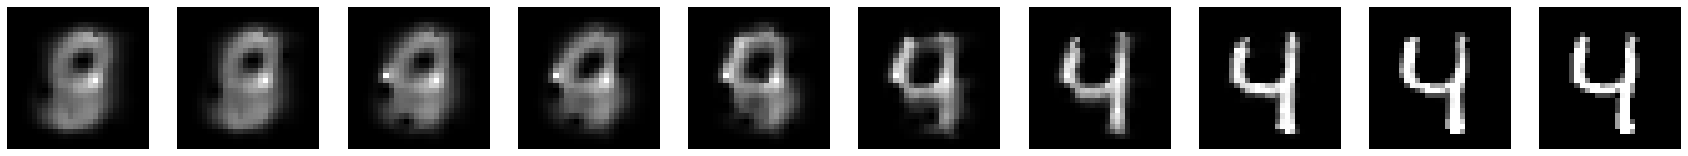

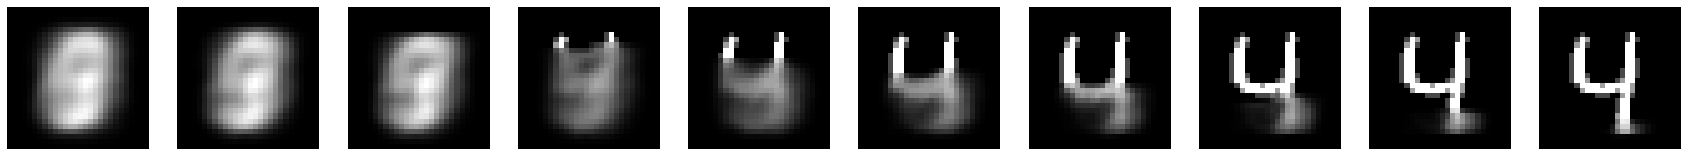

Step 101111, Loss (last minibatch): 0.21610328555107117, Loss (500 step avg.): 0.17709729060560406


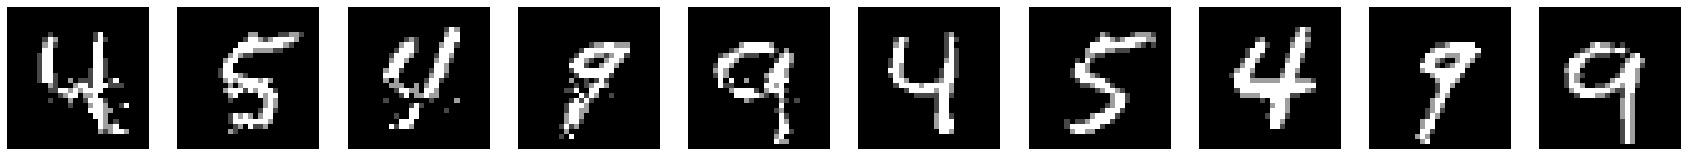

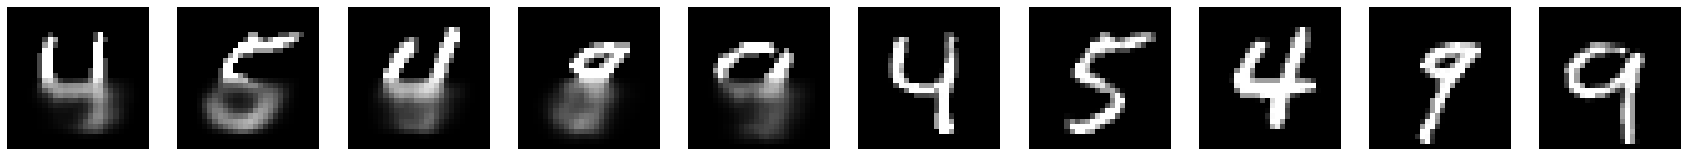

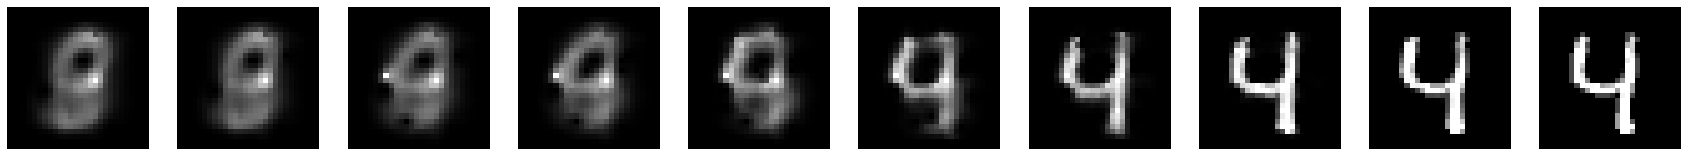

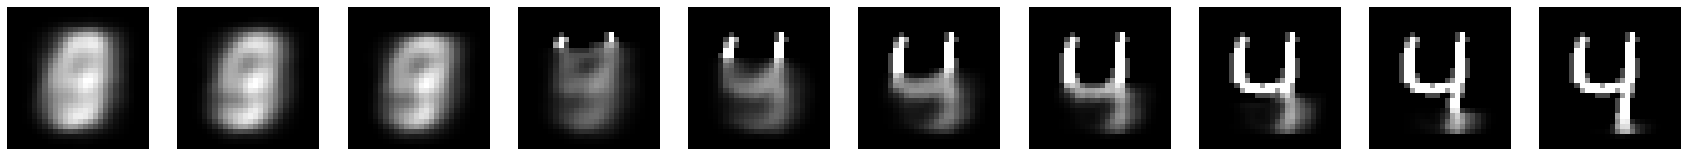

Step 102111, Loss (last minibatch): 0.22175654768943787, Loss (500 step avg.): 0.1784333315140711


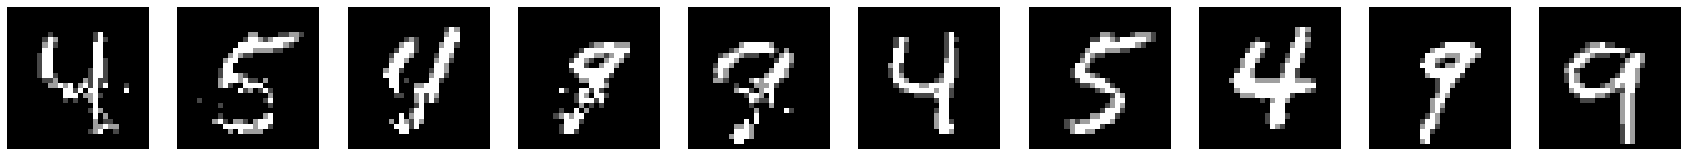

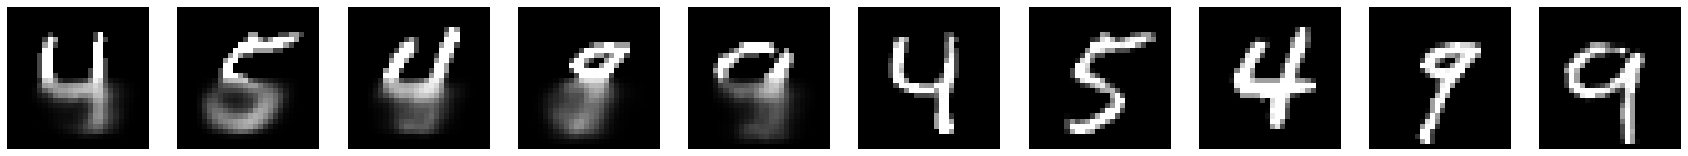

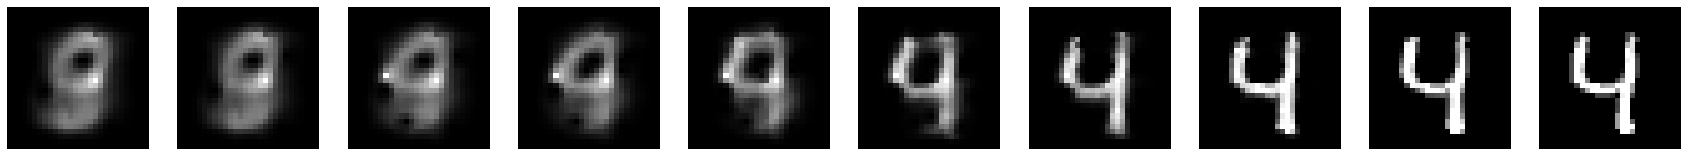

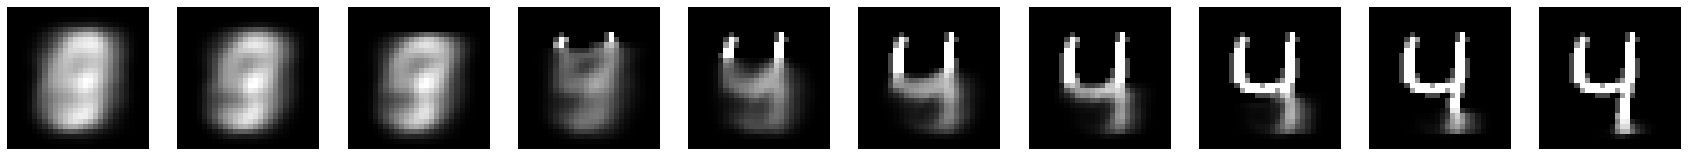

Step 103111, Loss (last minibatch): 0.13660091161727905, Loss (500 step avg.): 0.18107086879586032


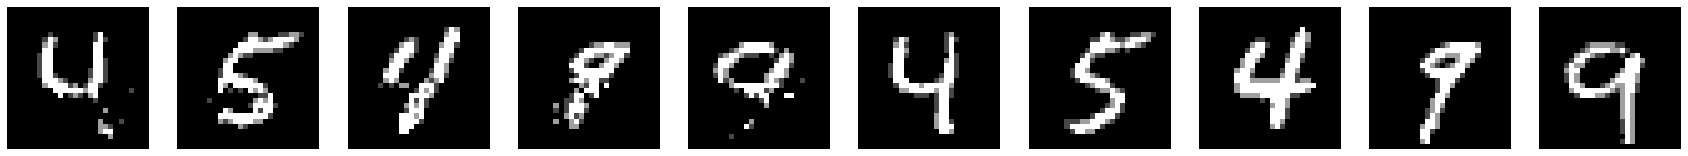

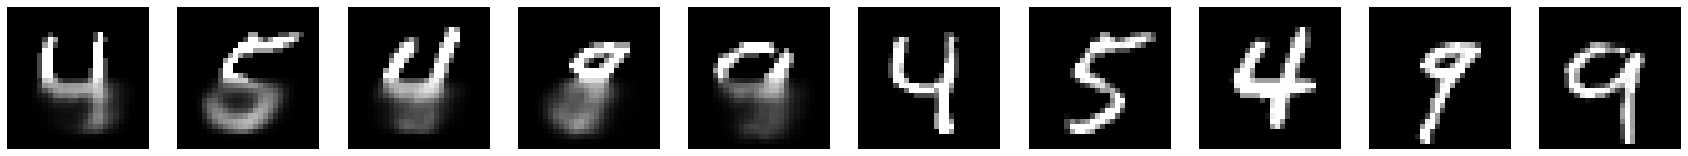

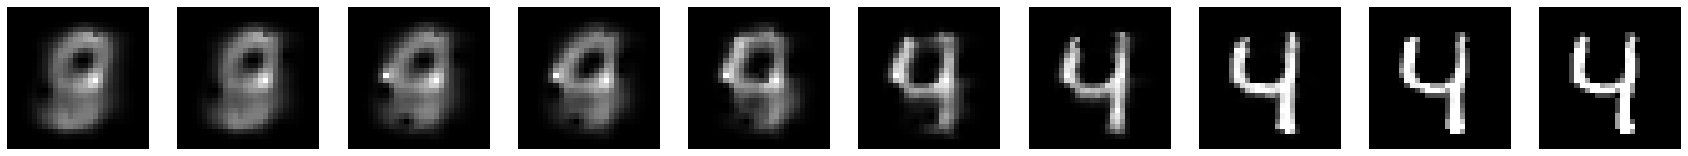

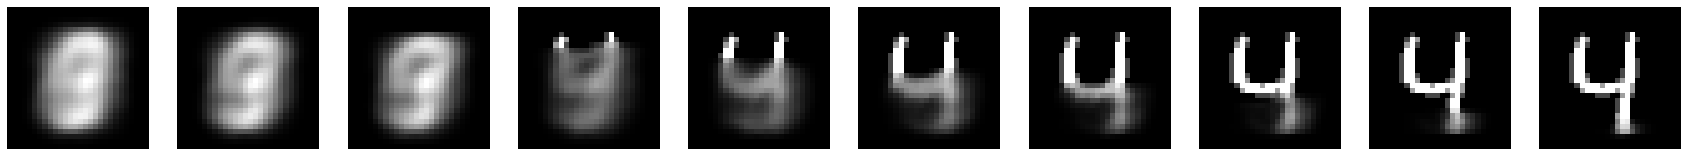

Step 104111, Loss (last minibatch): 0.18119525909423828, Loss (500 step avg.): 0.18200732819631904


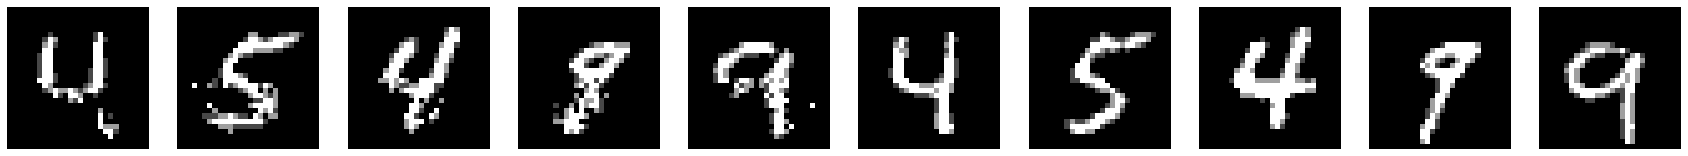

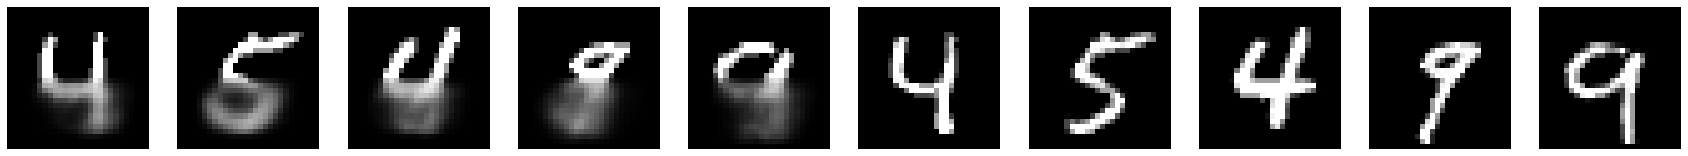

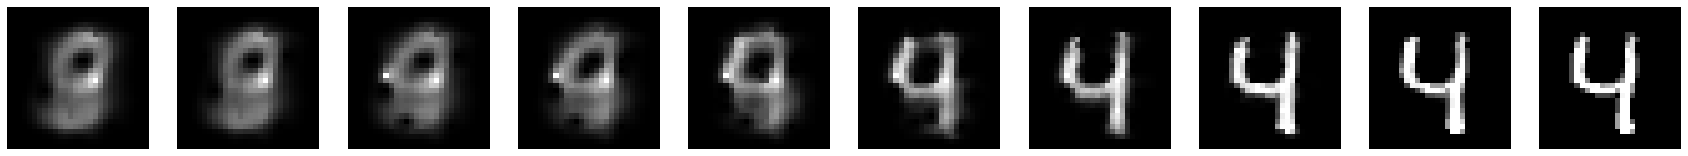

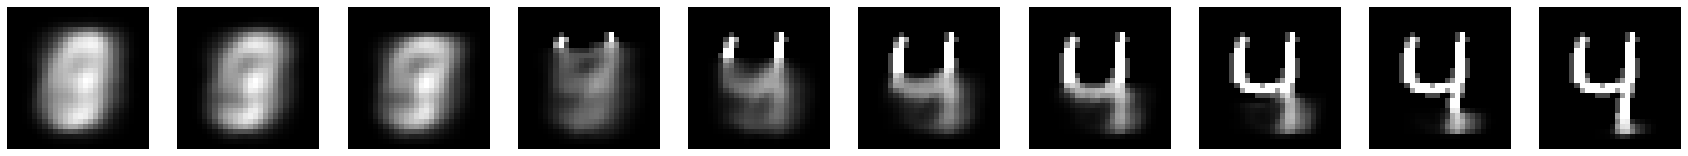

Step 105111, Loss (last minibatch): 0.22949926555156708, Loss (500 step avg.): 0.1832776875523274


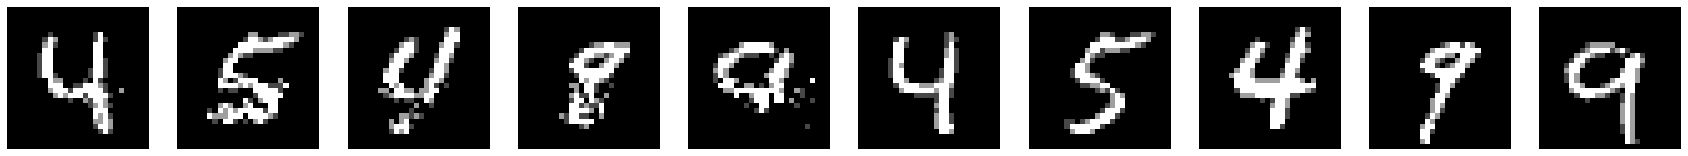

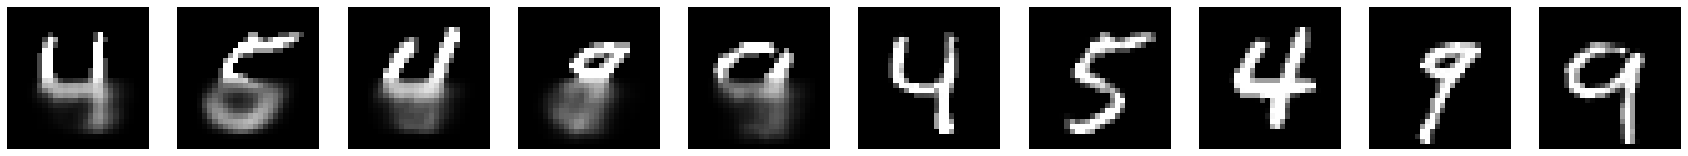

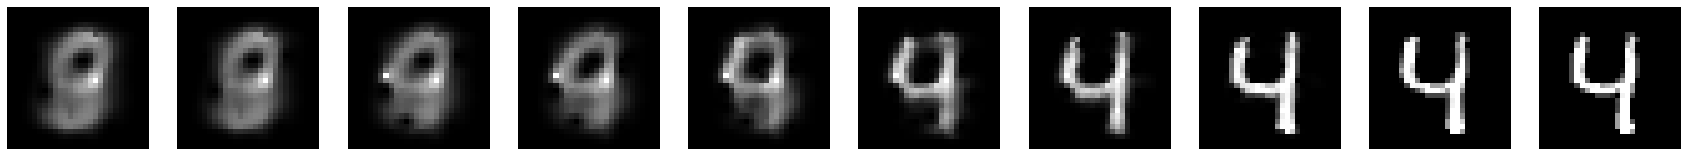

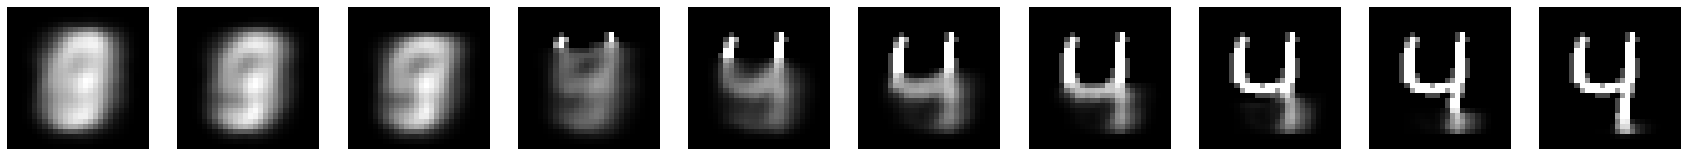

Step 106111, Loss (last minibatch): 0.17228388786315918, Loss (500 step avg.): 0.17692529149874003


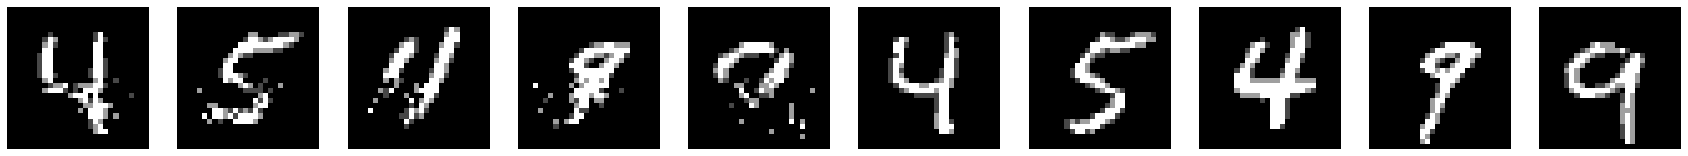

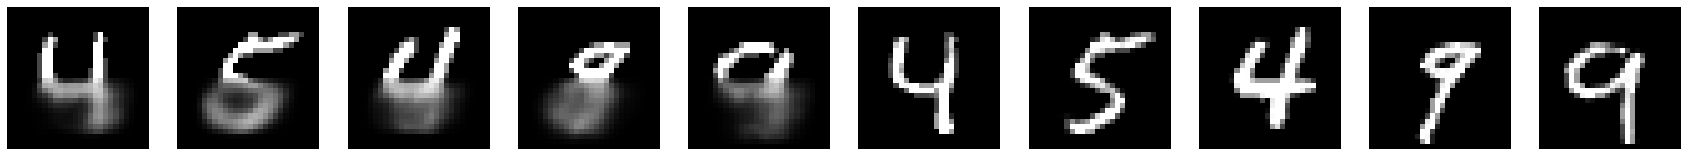

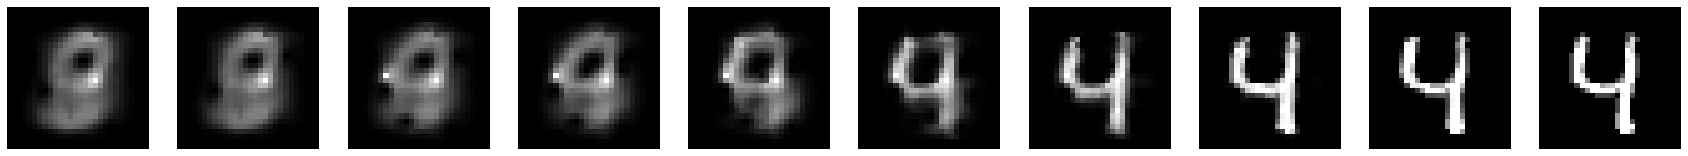

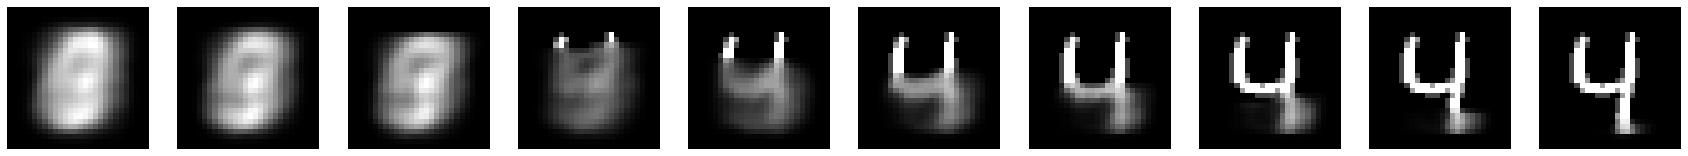

Step 107111, Loss (last minibatch): 0.16371795535087585, Loss (500 step avg.): 0.1780601331662989


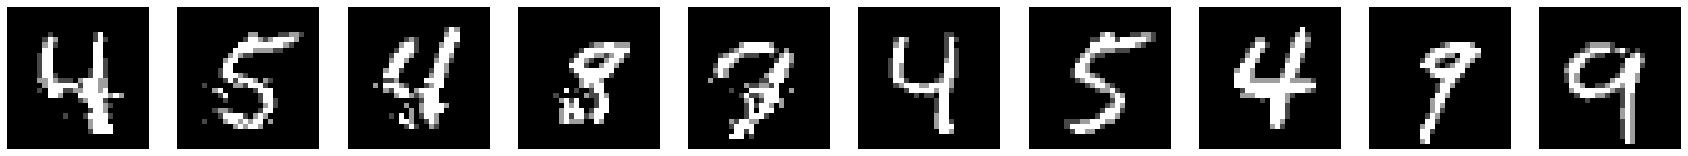

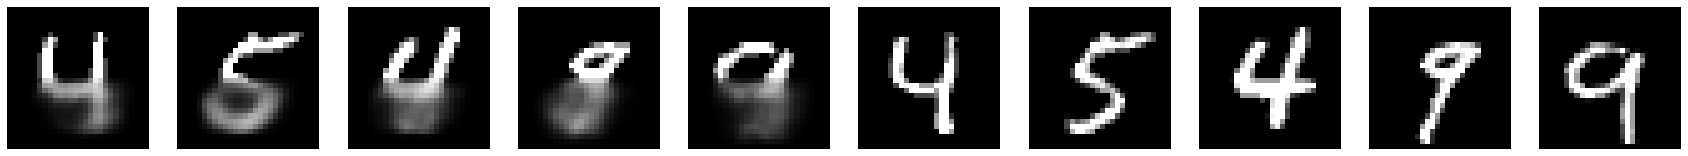

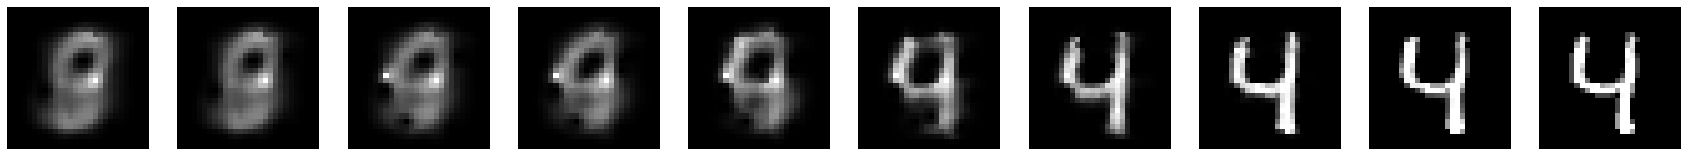

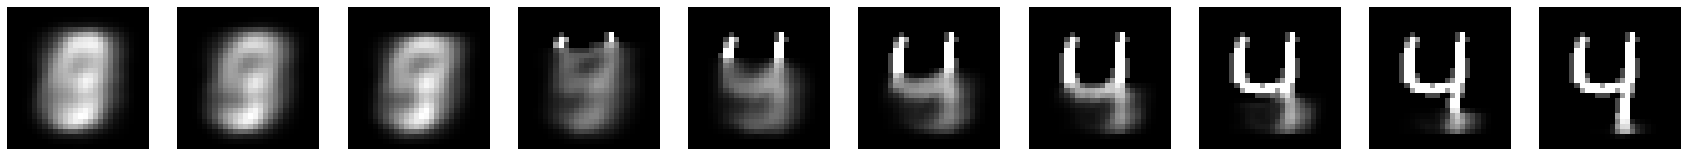

Step 108111, Loss (last minibatch): 0.1939198076725006, Loss (500 step avg.): 0.17927300946381752


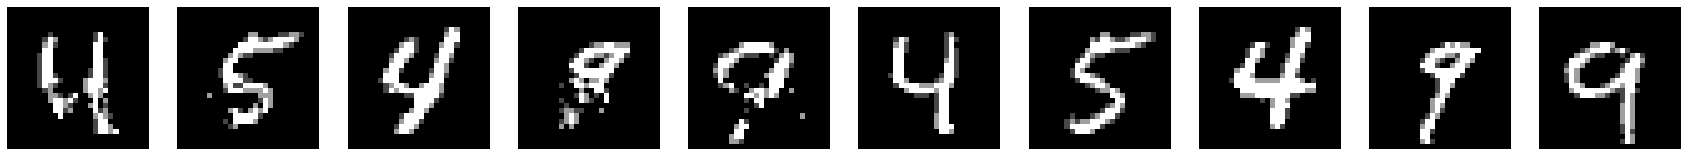

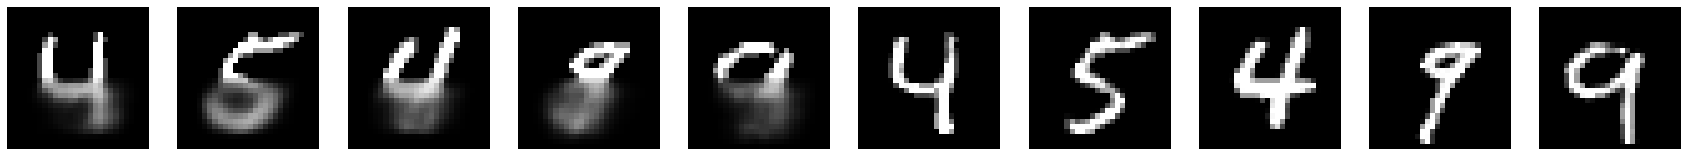

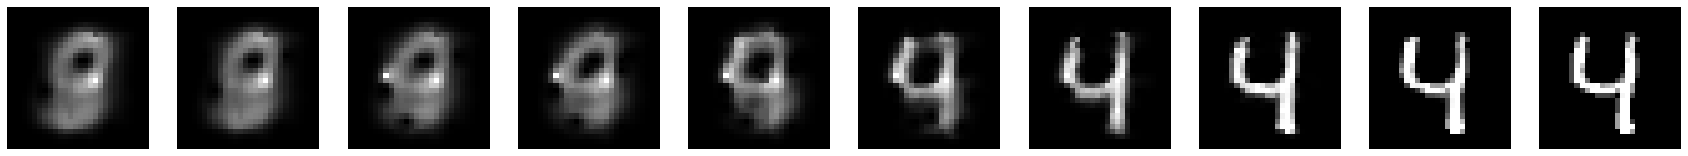

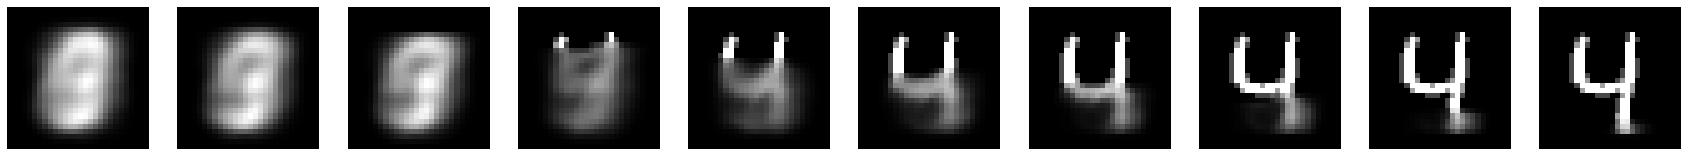

Step 109111, Loss (last minibatch): 0.18528197705745697, Loss (500 step avg.): 0.17759154638844335


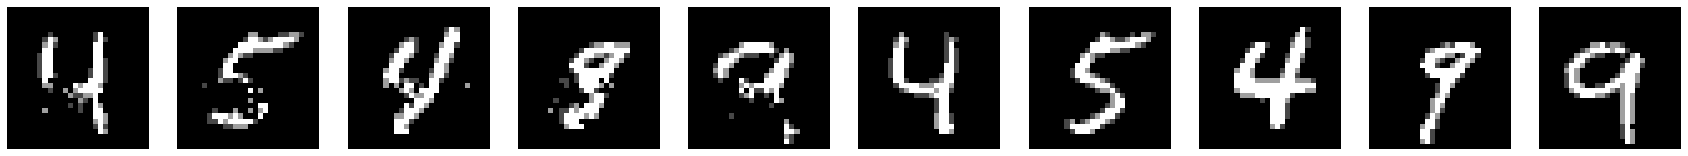

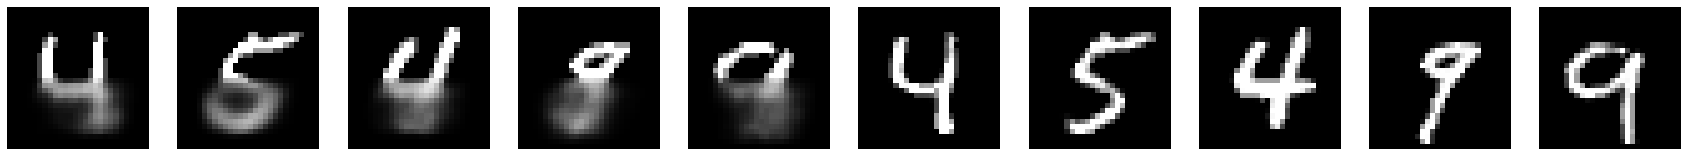

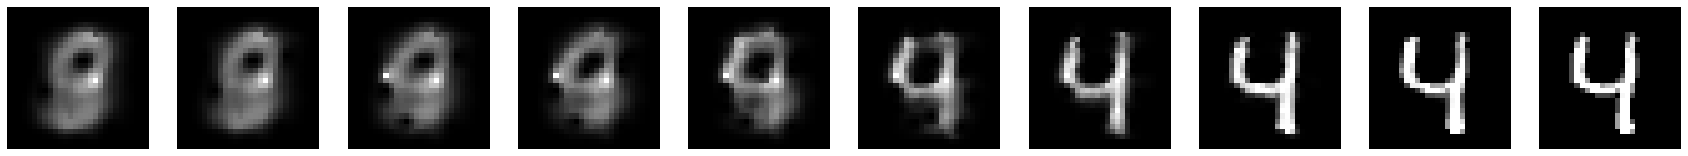

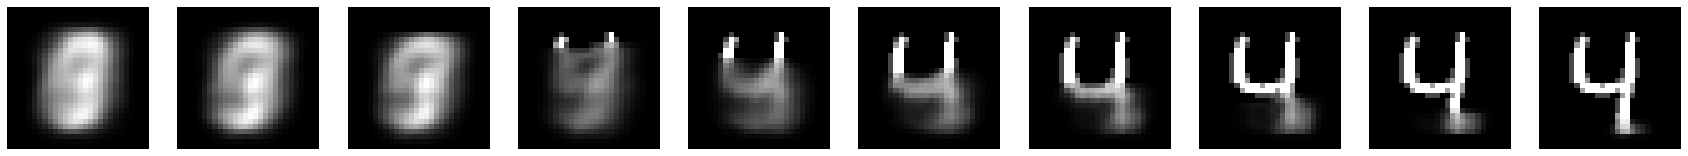

Step 110111, Loss (last minibatch): 0.1333380937576294, Loss (500 step avg.): 0.17697631136445466


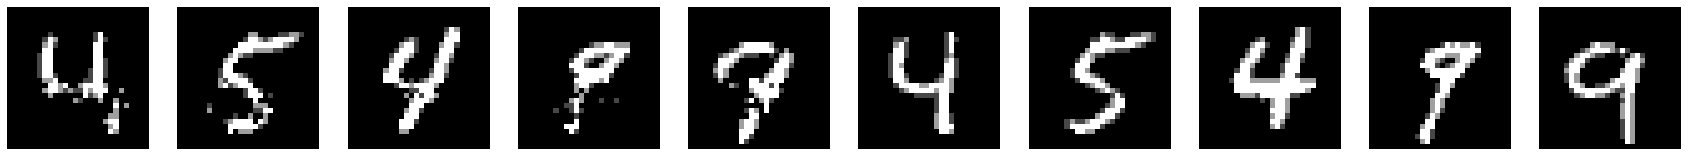

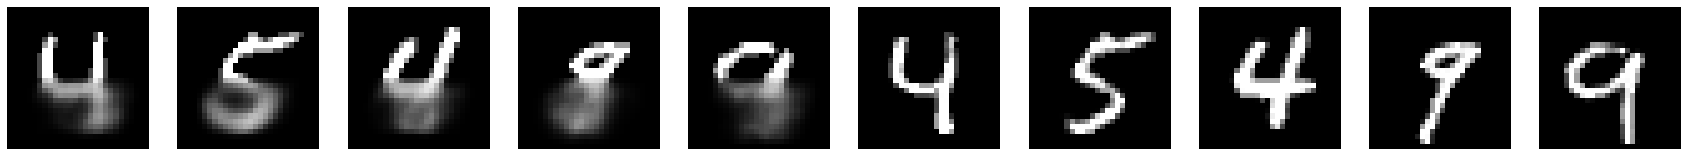

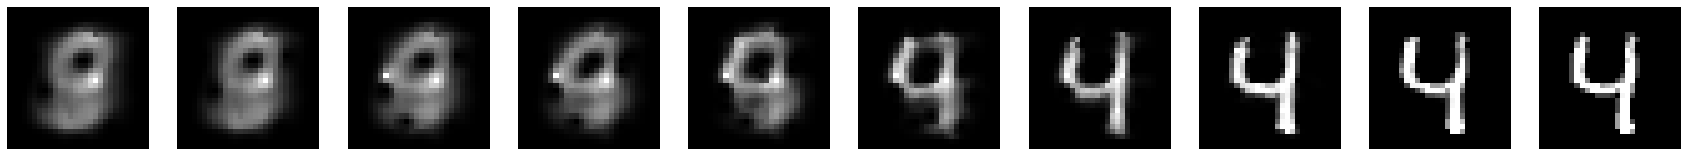

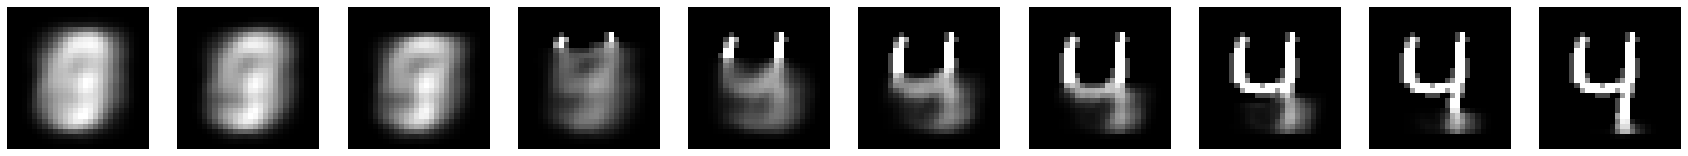

Step 111111, Loss (last minibatch): 0.17304691672325134, Loss (500 step avg.): 0.17696449889275367


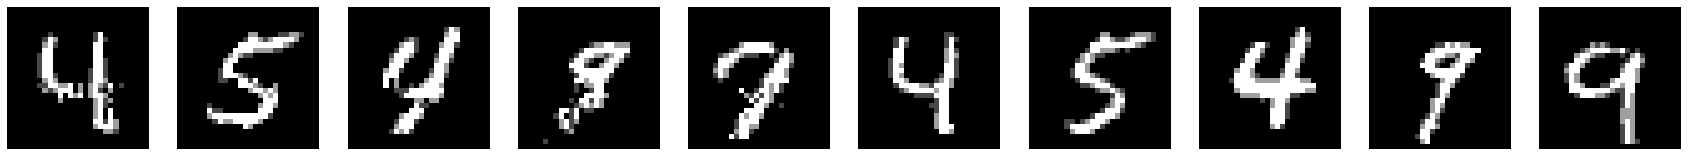

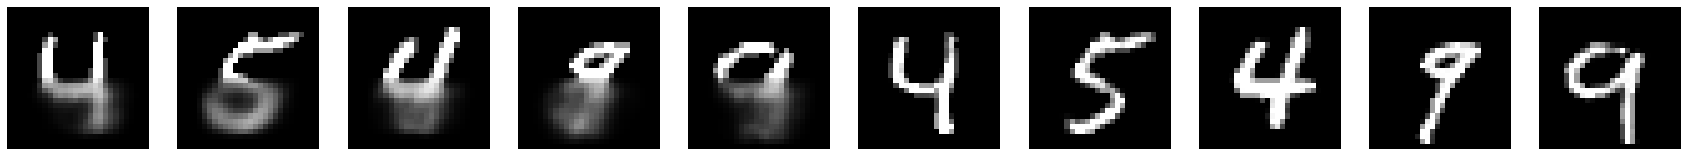

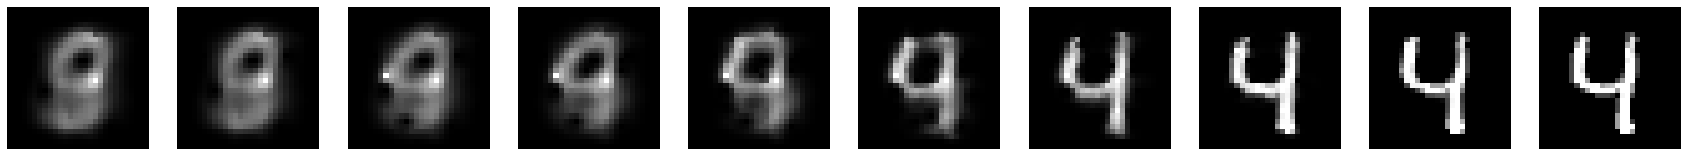

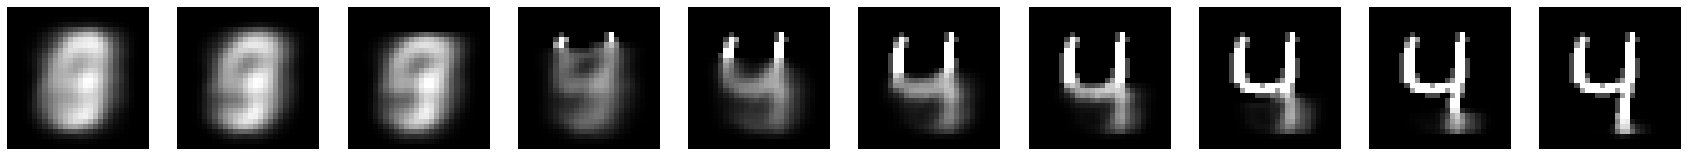

Step 112111, Loss (last minibatch): 0.2199770212173462, Loss (500 step avg.): 0.17776526875065235


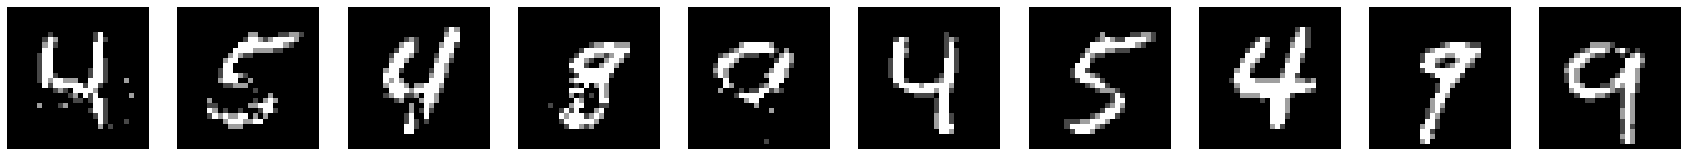

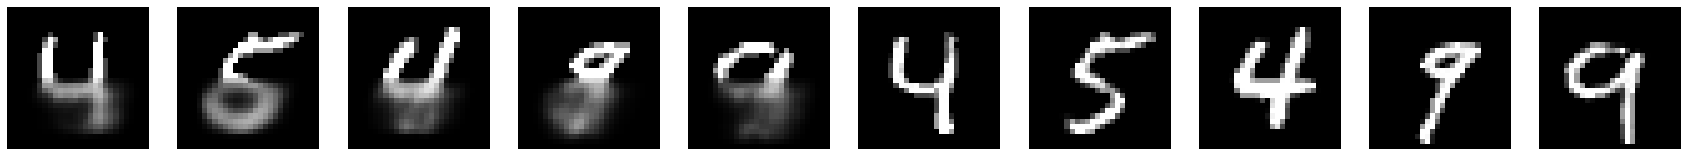

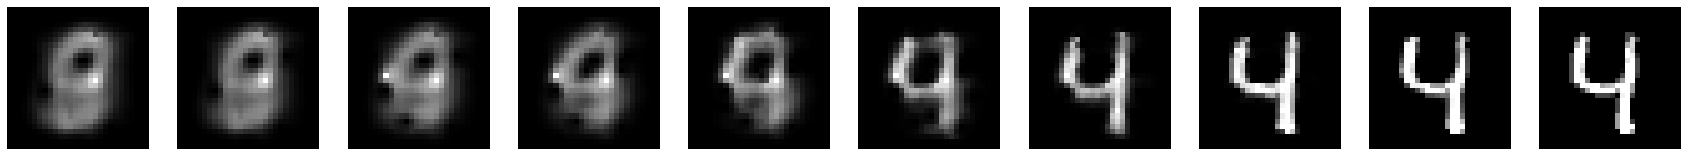

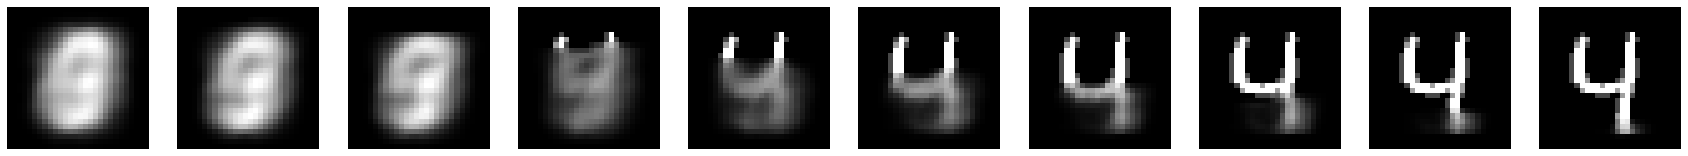

Step 113111, Loss (last minibatch): 0.18116633594036102, Loss (500 step avg.): 0.17874827450085543


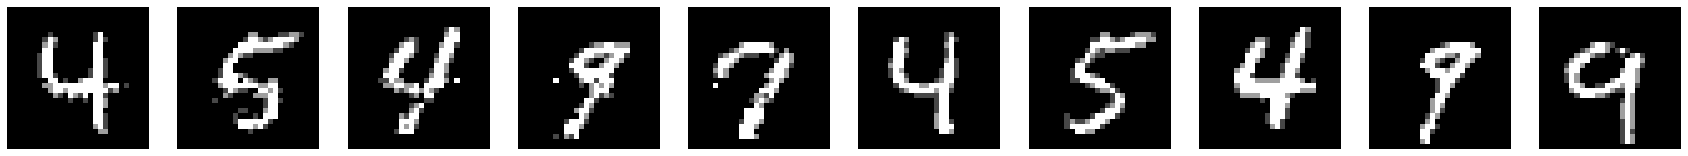

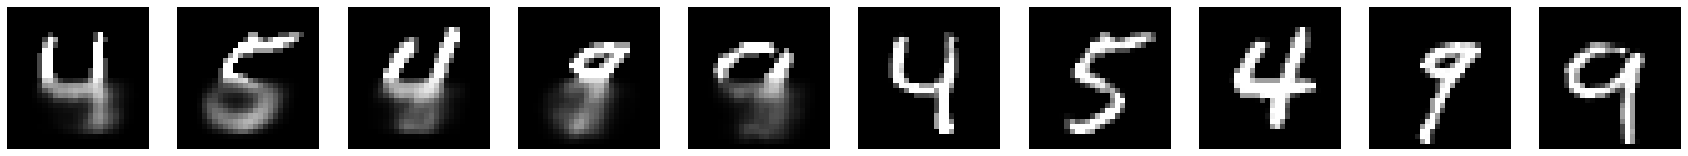

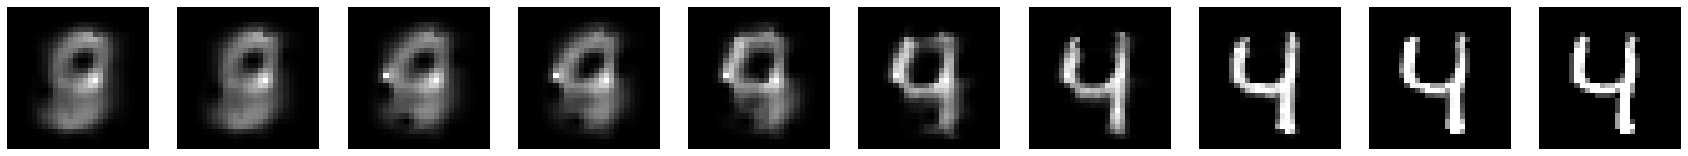

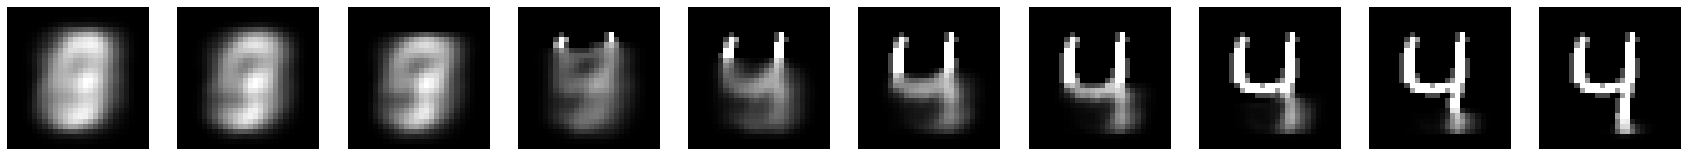

Step 114111, Loss (last minibatch): 0.2685222625732422, Loss (500 step avg.): 0.17805030445257822


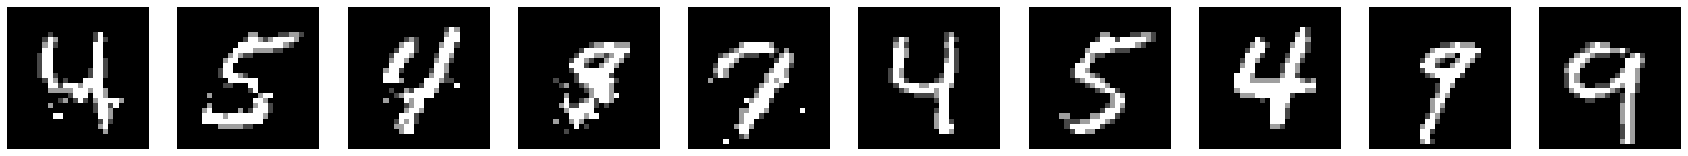

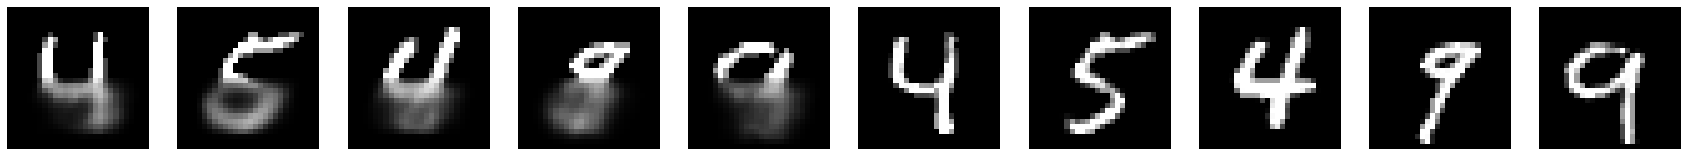

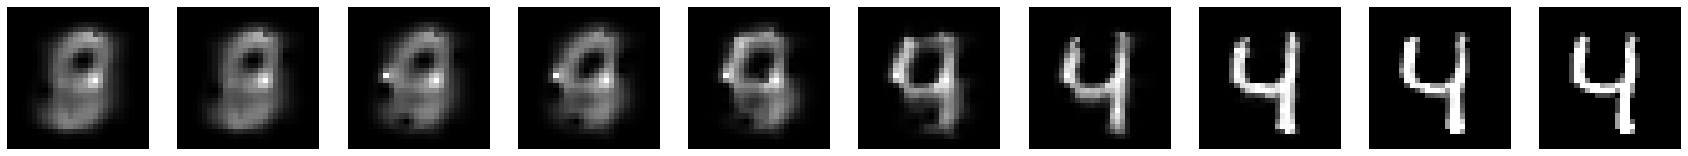

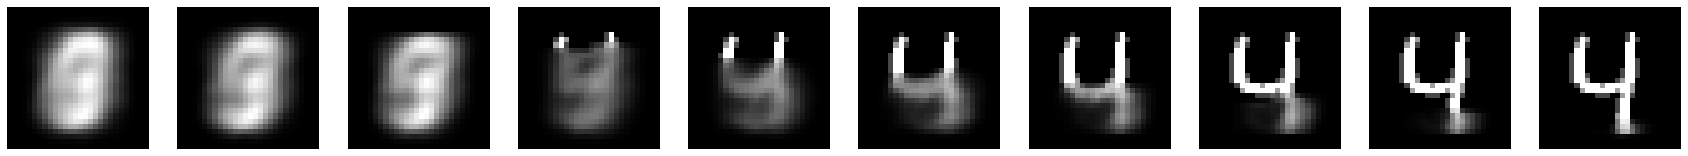

Step 115111, Loss (last minibatch): 0.13171665370464325, Loss (500 step avg.): 0.17952611685513023


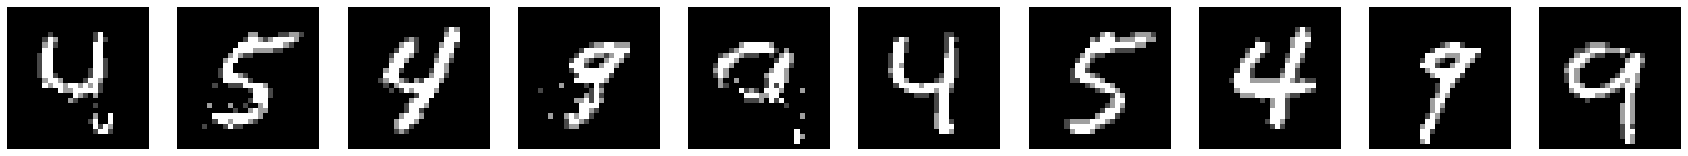

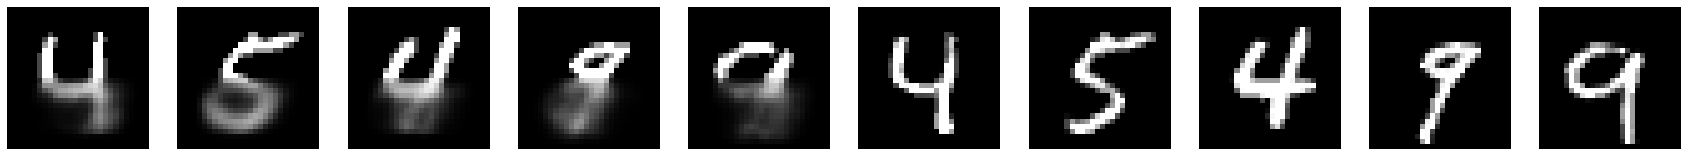

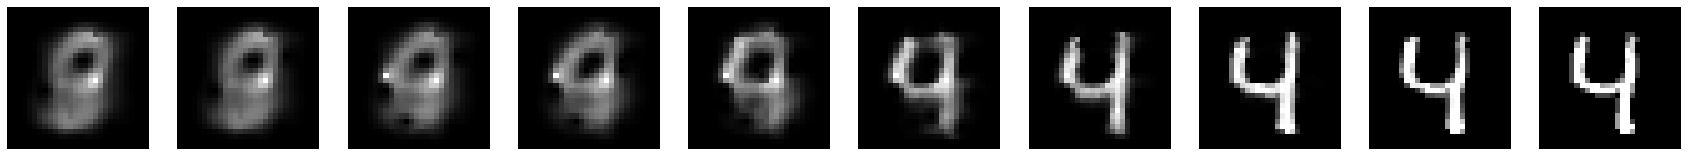

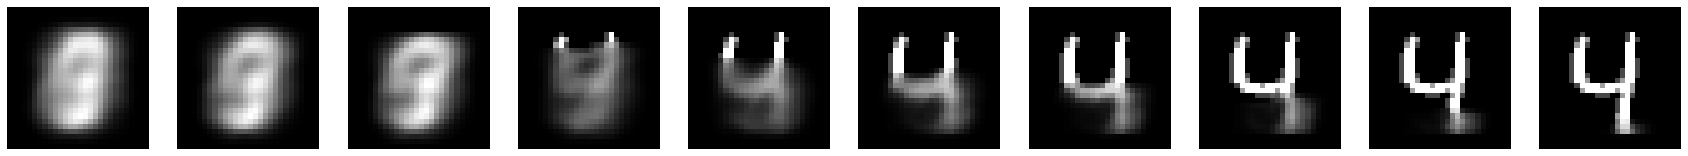

Step 116111, Loss (last minibatch): 0.18003389239311218, Loss (500 step avg.): 0.17909381022591314


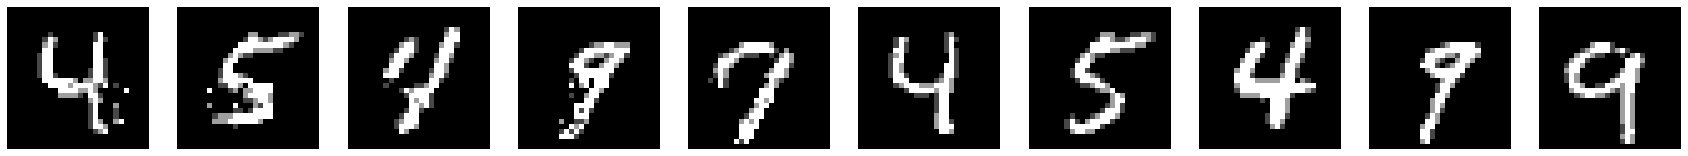

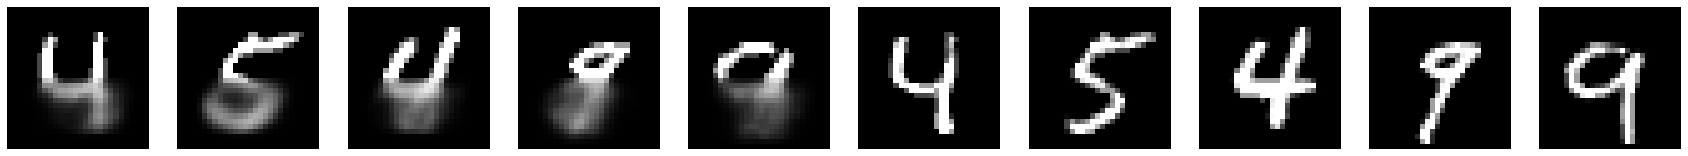

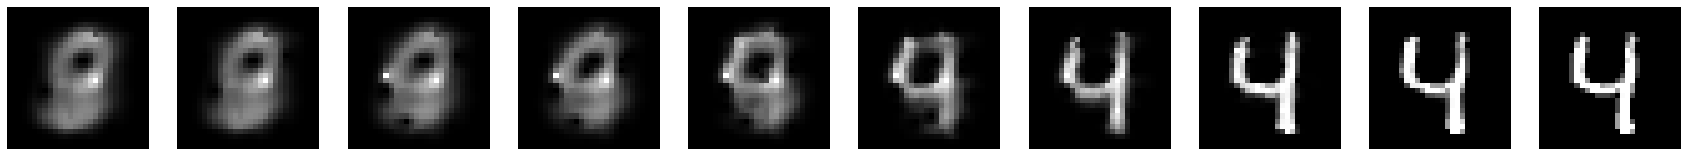

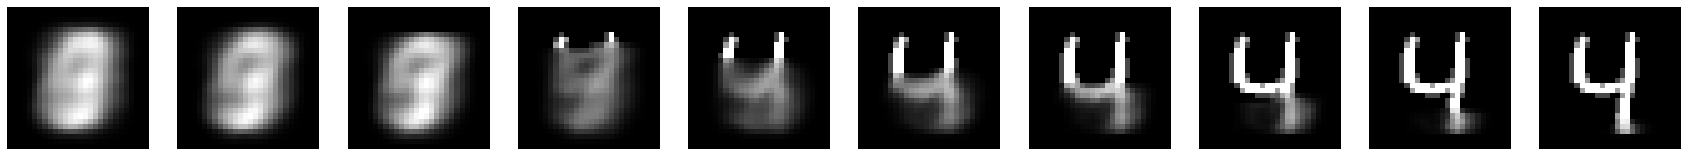

Step 117111, Loss (last minibatch): 0.1361357569694519, Loss (500 step avg.): 0.1779107402809366


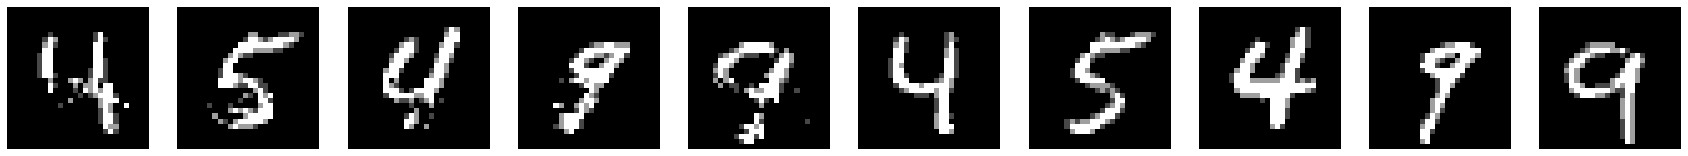

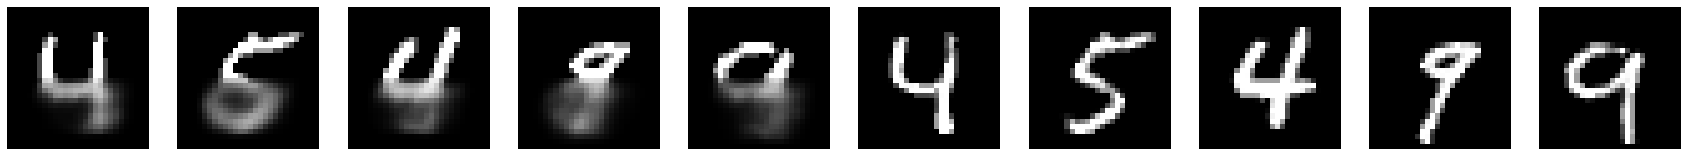

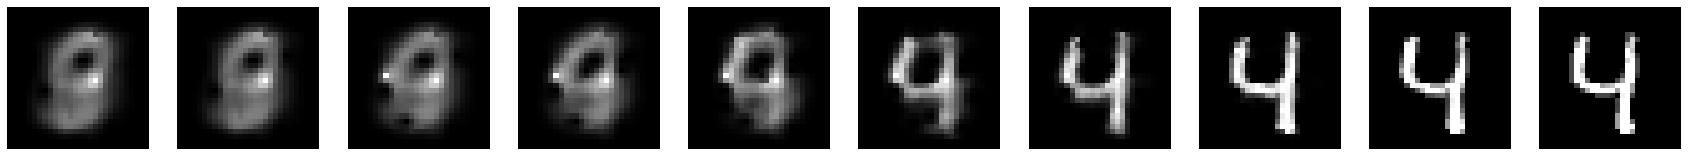

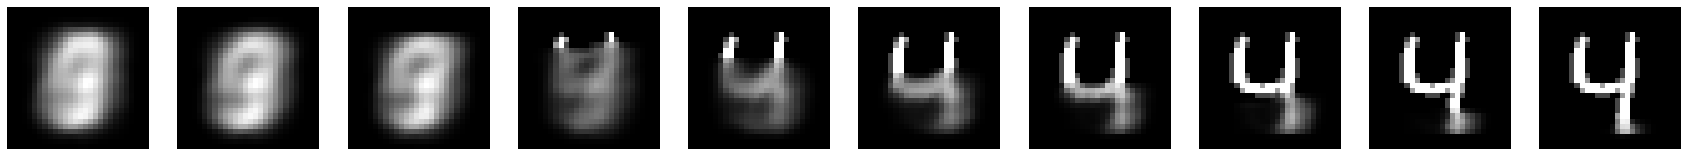

Step 118111, Loss (last minibatch): 0.2283192127943039, Loss (500 step avg.): 0.17822969669175004


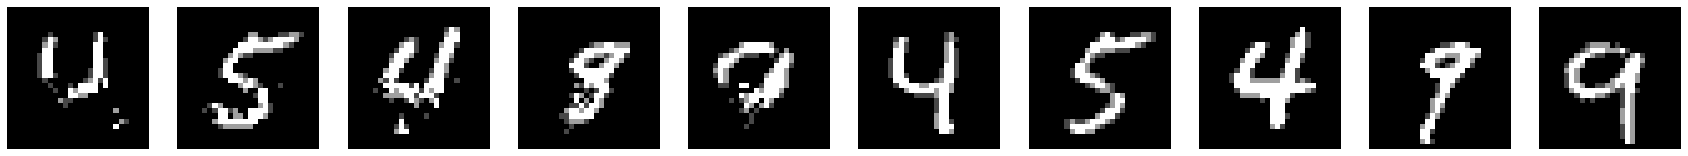

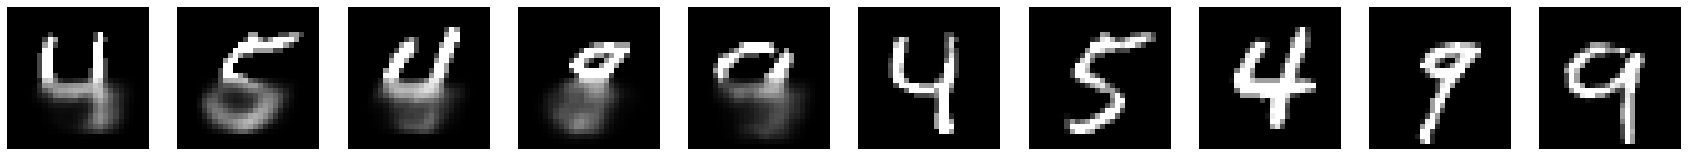

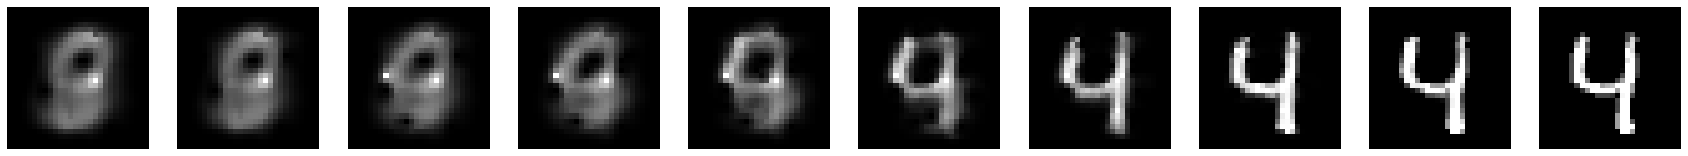

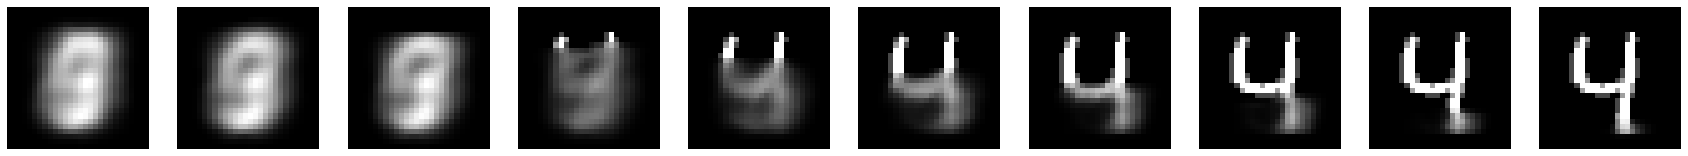

Step 119111, Loss (last minibatch): 0.10986053198575974, Loss (500 step avg.): 0.17790834028682784


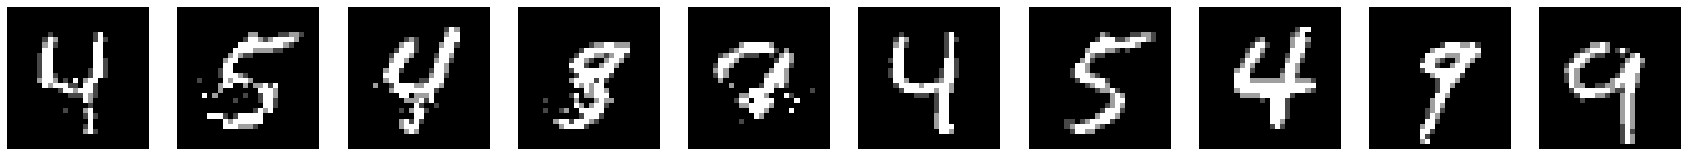

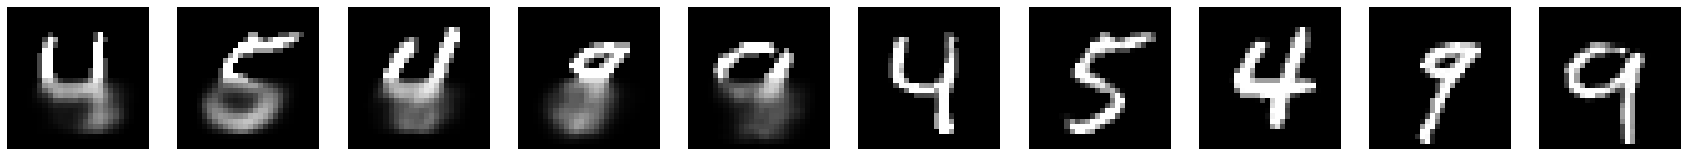

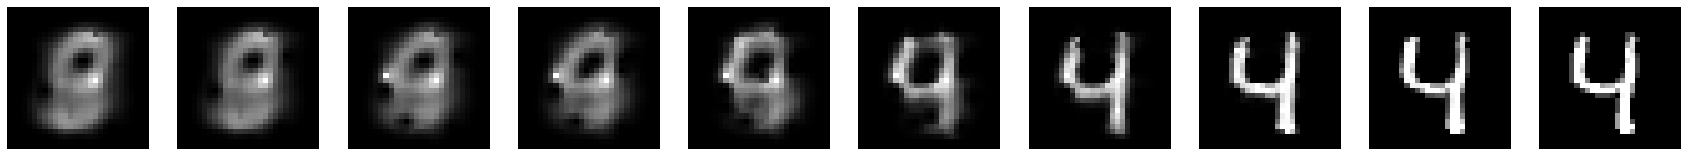

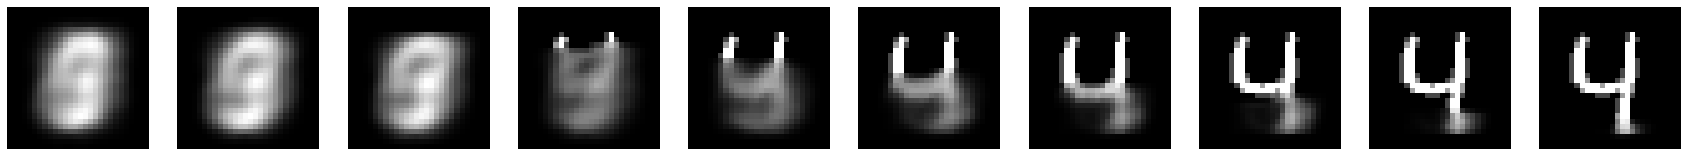

In [11]:

with strategy.scope():
    training_loop.train()

In [ ]:
training_loop.process_batch()
training_loop.new_test_batch()
training_loop.process_batch()


In [ ]:
model.save(f"models/{model_name}")